In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [3]:
rb_fp = pd.read_csv('rb_fantasy3.csv')
wr_fp = pd.read_csv('wr_fantasy3.csv')
te_fp = pd.read_csv('te_fantasy3.csv')
fp_df = rb_fp.append(wr_fp.append(te_fp))
fp_df

Full Name Position   Age Fantasy Points Per Game (2014)  \
0        A.J. Dillon       RB  24.1                              -   
1        Aaron Jones       RB  27.5                              -   
2    Aaron Ripkowski       RB  29.4                              -   
3    Adrian Peterson       RB  37.2                           11.3   
4     Ahmad Bradshaw       RB  36.2                           15.4   
..               ...      ...   ...                            ...   
300        Zach Ertz       TE  31.5                              9   
301      Zach Gentry       TE  25.7                              -   
302      Zach Miller       TE  37.6                              -   
303      Zach Miller       TE  36.5                            4.5   
304     Zach Sudfeld       TE  33.1                            2.2   

    Fantasy Points Per Game (2015) Fantasy Points Per Game (2016)  \
0                                -                              -   
1                                -                              -   
2                              2.8                            4.7   
3                             16.3                              3   
4                              7.1                              -   
..                             ...                            ...   
300                           11.4                           13.1   
301                              -                              -   
302                            8.3                             12   
303                              -                              -   
304                              -                              -   

    Fantasy Points Per Game (2017) Fantasy Points Per Game (2018)  \
0                                -                              -   
1                                8                           14.3   
2                              1.1                              -   
3                              7.9                           11.8   
4                                -                              -   
..                             ...                            ...   
300                           14.5                           17.5   
301                              -                              -   
302                              7                              -   
303                              -                              -   
304                              -                              -   

    Fantasy Points Per Game (2019) Fantasy Points Per Game (2020)  \
0                                -                         3.6636   
1                             19.7                        18.4929   
2                                -                              -   
3                              9.8                         7.7812   
4                                -                              -   
..                             ...                            ...   
300                           14.2                         7.0455   
301                            1.4                              0   
302                              -                              -   
303                              -                              -   
304                              -                              -   

    Fantasy Points Per Game (2021) Games (2014) Games (2015) Games (2016)  \
0                          10.9176            -            -            -   
1                          15.2667            -            -            -   
2                                -            -            1           10   
3                             6.65            1           16            3   
4                                -           10            6            -   
..                             ...          ...          ...          ...   
300                        10.6294           16           15           14   
301                            2.1            -            -       

In [4]:
fp_df['rb?'] = np.where(fp_df['Position'] == 'RB',1,0)
fp_df['wr?'] = np.where(fp_df['Position'] == 'WR',1,0)
fp_df['te?'] = np.where(fp_df['Position'] == 'TE',1,0)
fp_df

Full Name Position   Age Fantasy Points Per Game (2014)  \
0        A.J. Dillon       RB  24.1                              -   
1        Aaron Jones       RB  27.5                              -   
2    Aaron Ripkowski       RB  29.4                              -   
3    Adrian Peterson       RB  37.2                           11.3   
4     Ahmad Bradshaw       RB  36.2                           15.4   
..               ...      ...   ...                            ...   
300        Zach Ertz       TE  31.5                              9   
301      Zach Gentry       TE  25.7                              -   
302      Zach Miller       TE  37.6                              -   
303      Zach Miller       TE  36.5                            4.5   
304     Zach Sudfeld       TE  33.1                            2.2   

    Fantasy Points Per Game (2015) Fantasy Points Per Game (2016)  \
0                                -                              -   
1                                -                              -   
2                              2.8                            4.7   
3                             16.3                              3   
4                              7.1                              -   
..                             ...                            ...   
300                           11.4                           13.1   
301                              -                              -   
302                            8.3                             12   
303                              -                              -   
304                              -                              -   

    Fantasy Points Per Game (2017) Fantasy Points Per Game (2018)  \
0                                -                              -   
1                                8                           14.3   
2                              1.1                              -   
3                              7.9                           11.8   
4                                -                              -   
..                             ...                            ...   
300                           14.5                           17.5   
301                              -                              -   
302                              7                              -   
303                              -                              -   
304                              -                              -   

    Fantasy Points Per Game (2019) Fantasy Points Per Game (2020)  ...  \
0                                -                         3.6636  ...   
1                             19.7                        18.4929  ...   
2                                -                              -  ...   
3                              9.8                         7.7812  ...   
4                                -                              -  ...   
..                             ...                            ...  ...   
300                           14.2                         7.0455  ...   
301                            1.4                              0  ...   
302                              -                              -  ...   
303                              -                              -  ...   
304                              -                              -  ...   

    Games (2015) Games (2016) Games (2017) Games (2018) Games (2019)  \
0              -            -            -            -            -   
1              -            -           10           12           16   
2              1           10           11            -            -   
3             16            3           10           16           15   
4              6            -            -            -            -   
..           ...          ...          ...          ...          ...   
300           15           14           14           16           15   
301            -            -            -     

In [5]:
fp_clean = fp_df.replace('-',np.nan).set_index('Full Name').drop(columns=['Position'])
fp_final_df = fp_clean.apply(lambda x: pd.to_numeric(x))
fp_final_df

Age  Fantasy Points Per Game (2014)  \
Full Name                                               
A.J. Dillon      24.1                             NaN   
Aaron Jones      27.5                             NaN   
Aaron Ripkowski  29.4                             NaN   
Adrian Peterson  37.2                            11.3   
Ahmad Bradshaw   36.2                            15.4   
...               ...                             ...   
Zach Ertz        31.5                             9.0   
Zach Gentry      25.7                             NaN   
Zach Miller      37.6                             NaN   
Zach Miller      36.5                             4.5   
Zach Sudfeld     33.1                             2.2   

                 Fantasy Points Per Game (2015)  \
Full Name                                         
A.J. Dillon                                 NaN   
Aaron Jones                                 NaN   
Aaron Ripkowski                             2.8   
Adrian Peterson                            16.3   
Ahmad Bradshaw                              7.1   
...                                         ...   
Zach Ertz                                  11.4   
Zach Gentry                                 NaN   
Zach Miller                                 8.3   
Zach Miller                                 NaN   
Zach Sudfeld                                NaN   

                 Fantasy Points Per Game (2016)  \
Full Name                                         
A.J. Dillon                                 NaN   
Aaron Jones                                 NaN   
Aaron Ripkowski                             4.7   
Adrian Peterson                             3.0   
Ahmad Bradshaw                              NaN   
...                                         ...   
Zach Ertz                                  13.1   
Zach Gentry                                 NaN   
Zach Miller                                12.0   
Zach Miller                                 NaN   
Zach Sudfeld                                NaN   

                 Fantasy Points Per Game (2017)  \
Full Name                                         
A.J. Dillon                                 NaN   
Aaron Jones                                 8.0   
Aaron Ripkowski                             1.1   
Adrian Peterson                             7.9   
Ahmad Bradshaw                              NaN   
...                                         ...   
Zach Ertz                                  14.5   
Zach Gentry                                 NaN   
Zach Miller                                 7.0   
Zach Miller                                 NaN   
Zach Sudfeld                                NaN   

                 Fantasy Points Per Game (2018)  \
Full Name                                         
A.J. Dillon                                 NaN   
Aaron Jones                                14.3   
Aaron Ripkowski                             NaN   
Adrian Peterson                            11.8   
Ahmad Bradshaw                              NaN   
...                                         ...   
Zach Ertz                                  17.5   
Zach Gentry                                 NaN   
Zach Miller                                 NaN   
Zach Miller                                 NaN   
Zach Sudfeld                                NaN   

                 Fantasy Points Per Game (2019)  \
Full Name                                         
A.J. Dillon                                 NaN   
Aaron Jones                                19.7   
Aaron Ripkowski                             NaN   
Adrian Peterson                             9.8   
Ahmad Bradshaw                              NaN   
...                                         ...   
Zach Ertz                                  14.2   
Zach Gentry                                 1.4   
Zach Miller                                 NaN   
Zach Miller                                 NaN   
Zach Sud

In [6]:
fp_final_df['fpts_2014'] = fp_final_df['Fantasy Points Per Game (2014)'] * fp_final_df['Games (2014)']
fp_final_df['fpts_2015'] = fp_final_df['Fantasy Points Per Game (2015)'] * fp_final_df['Games (2015)']
fp_final_df['fpts_2016'] = fp_final_df['Fantasy Points Per Game (2016)'] * fp_final_df['Games (2016)']
fp_final_df['fpts_2017'] = fp_final_df['Fantasy Points Per Game (2017)'] * fp_final_df['Games (2017)']
fp_final_df['fpts_2018'] = fp_final_df['Fantasy Points Per Game (2018)'] * fp_final_df['Games (2018)']
fp_final_df['fpts_2019'] = fp_final_df['Fantasy Points Per Game (2019)'] * fp_final_df['Games (2019)']
fp_final_df['fpts_2020'] = fp_final_df['Fantasy Points Per Game (2020)'] * fp_final_df['Games (2020)']
fp_final_df['fpts_2021'] = fp_final_df['Fantasy Points Per Game (2021)'] * fp_final_df['Games (2021)']
fp_final_df.reset_index()

Full Name   Age  Fantasy Points Per Game (2014)  \
0         A.J. Dillon  24.1                             NaN   
1         Aaron Jones  27.5                             NaN   
2     Aaron Ripkowski  29.4                             NaN   
3     Adrian Peterson  37.2                            11.3   
4      Ahmad Bradshaw  36.2                            15.4   
...               ...   ...                             ...   
1293        Zach Ertz  31.5                             9.0   
1294      Zach Gentry  25.7                             NaN   
1295      Zach Miller  37.6                             NaN   
1296      Zach Miller  36.5                             4.5   
1297     Zach Sudfeld  33.1                             2.2   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                                NaN                             NaN   
1                                NaN                             NaN   
2                                2.8                             4.7   
3                               16.3                             3.0   
4                                7.1                             NaN   
...                              ...                             ...   
1293                            11.4                            13.1   
1294                             NaN                             NaN   
1295                             8.3                            12.0   
1296                             NaN                             NaN   
1297                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                                NaN                             NaN   
1                                8.0                            14.3   
2                                1.1                             NaN   
3                                7.9                            11.8   
4                                NaN                             NaN   
...                              ...                             ...   
1293                            14.5                            17.5   
1294                             NaN                             NaN   
1295                             7.0                             NaN   
1296                             NaN                             NaN   
1297                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  \
0                                NaN                          3.6636   
1                               19.7                         18.4929   
2                                NaN                             NaN   
3                                9.8                          7.7812   
4                                NaN                             NaN   
...                              ...                             ...   
1293                            14.2                          7.0455   
1294                             1.4                          0.0000   
1295                             NaN                             NaN   
1296                             NaN                             NaN   
1297                             NaN                             NaN   

      Fantasy Points Per Game (2021)  ...  wr?  te?  fpts_2014  fpts_2015  \
0                            10.9176  ...    0    0        NaN        NaN   
1                            15.2667  ...    0    0        NaN        NaN   
2                                NaN  ...    0    0        NaN        2.8   
3                             6.6500  ...    0    0       11.3      260.8   
4                                NaN  ...    0    0      154.0       42.6   
...                              ...  ...  ...  ...        ...        ...   
1293                         10.6294  ...    0    1      144.0      171.0   
1294                          2.1000  ...   

In [7]:
rb_dc = pd.read_csv('rb_dc.csv')
wr_dc = pd.read_csv('wr_dc.csv')
te_dc = pd.read_csv('te_dc.csv')

dc_df = rb_dc.append(wr_dc.append(te_dc))
dc_df

Full Name Position Draft Pick College Dominator Rating Breakout Age
0        A.J. Dillon       RB       2.30                    34.8%         19.3
1        Aaron Green       RB  Undrafted                    18.7%         20.9
2        Aaron Jones       RB       5.39                    47.0%         18.8
3    Aaron Ripkowski       RB       6.30                     3.9%            -
4        Abram Smith       RB  Undrafted                    25.5%           23
..               ...      ...        ...                      ...          ...
458   Xavier Grimble       TE  Undrafted                    13.1%            -
459        Zach Ertz       TE       2.03                    31.8%         21.8
460      Zach Gentry       TE       5.03                    15.6%            -
461      Zach Miller       TE       2.06                    18.1%         20.7
462     Zach Sudfeld       TE  Undrafted                    26.1%         23.4

[2277 rows x 5 columns]

In [8]:
dc_df['cdr'] = dc_df['College Dominator Rating'].str.strip('%')
dc_df

Full Name Position Draft Pick College Dominator Rating  \
0        A.J. Dillon       RB       2.30                    34.8%   
1        Aaron Green       RB  Undrafted                    18.7%   
2        Aaron Jones       RB       5.39                    47.0%   
3    Aaron Ripkowski       RB       6.30                     3.9%   
4        Abram Smith       RB  Undrafted                    25.5%   
..               ...      ...        ...                      ...   
458   Xavier Grimble       TE  Undrafted                    13.1%   
459        Zach Ertz       TE       2.03                    31.8%   
460      Zach Gentry       TE       5.03                    15.6%   
461      Zach Miller       TE       2.06                    18.1%   
462     Zach Sudfeld       TE  Undrafted                    26.1%   

    Breakout Age   cdr  
0           19.3  34.8  
1           20.9  18.7  
2           18.8  47.0  
3              -   3.9  
4             23  25.5  
..           ...   ...  
458            -  13.1  
459         21.8  31.8  
460            -  15.6  
461         20.7  18.1  
462         23.4  26.1  

[2277 rows x 6 columns]

In [9]:
dc_df['drafted'] = np.where(dc_df['Draft Pick'] != 'Undrafted', 1, 0)
dc_df

Full Name Position Draft Pick College Dominator Rating  \
0        A.J. Dillon       RB       2.30                    34.8%   
1        Aaron Green       RB  Undrafted                    18.7%   
2        Aaron Jones       RB       5.39                    47.0%   
3    Aaron Ripkowski       RB       6.30                     3.9%   
4        Abram Smith       RB  Undrafted                    25.5%   
..               ...      ...        ...                      ...   
458   Xavier Grimble       TE  Undrafted                    13.1%   
459        Zach Ertz       TE       2.03                    31.8%   
460      Zach Gentry       TE       5.03                    15.6%   
461      Zach Miller       TE       2.06                    18.1%   
462     Zach Sudfeld       TE  Undrafted                    26.1%   

    Breakout Age   cdr  drafted  
0           19.3  34.8        1  
1           20.9  18.7        0  
2           18.8  47.0        1  
3              -   3.9        1  
4             23  25.5        0  
..           ...   ...      ...  
458            -  13.1        0  
459         21.8  31.8        1  
460            -  15.6        1  
461         20.7  18.1        1  
462         23.4  26.1        0  

[2277 rows x 7 columns]

In [10]:
dc_df_clean = dc_df[['Draft Pick','Breakout Age','cdr','drafted']].set_index(dc_df['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_final = dc_df_clean.reset_index()
dc_df_final

Full Name  Draft Pick  Breakout Age   cdr  drafted
0         A.J. Dillon        2.30          19.3  34.8        1
1         Aaron Green         NaN          20.9  18.7        0
2         Aaron Jones        5.39          18.8  47.0        1
3     Aaron Ripkowski        6.30           NaN   3.9        1
4         Abram Smith         NaN          23.0  25.5        0
...               ...         ...           ...   ...      ...
2272   Xavier Grimble         NaN           NaN  13.1        0
2273        Zach Ertz        2.03          21.8  31.8        1
2274      Zach Gentry        5.03           NaN  15.6        1
2275      Zach Miller        2.06          20.7  18.1        1
2276     Zach Sudfeld         NaN          23.4  26.1        0

[2277 rows x 5 columns]

In [11]:
full_data = fp_final_df.merge(dc_df_final,on='Full Name',how='inner')
full_data

Full Name   Age  Fantasy Points Per Game (2014)  \
0         A.J. Dillon  24.1                             NaN   
1         Aaron Jones  27.5                             NaN   
2     Aaron Ripkowski  29.4                             NaN   
3     Adrian Peterson  37.2                            11.3   
4      Ahmad Bradshaw  36.2                            15.4   
...               ...   ...                             ...   
1251        Zach Ertz  31.5                             9.0   
1252      Zach Gentry  25.7                             NaN   
1253      Zach Miller  37.6                             NaN   
1254      Zach Miller  36.5                             4.5   
1255     Zach Sudfeld  33.1                             2.2   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                                NaN                             NaN   
1                                NaN                             NaN   
2                                2.8                             4.7   
3                               16.3                             3.0   
4                                7.1                             NaN   
...                              ...                             ...   
1251                            11.4                            13.1   
1252                             NaN                             NaN   
1253                             8.3                            12.0   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                                NaN                             NaN   
1                                8.0                            14.3   
2                                1.1                             NaN   
3                                7.9                            11.8   
4                                NaN                             NaN   
...                              ...                             ...   
1251                            14.5                            17.5   
1252                             NaN                             NaN   
1253                             7.0                             NaN   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  \
0                                NaN                          3.6636   
1                               19.7                         18.4929   
2                                NaN                             NaN   
3                                9.8                          7.7812   
4                                NaN                             NaN   
...                              ...                             ...   
1251                            14.2                          7.0455   
1252                             1.4                          0.0000   
1253                             NaN                             NaN   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2021)  ...  fpts_2016  fpts_2017  fpts_2018  \
0                            10.9176  ...        NaN        NaN        NaN   
1                            15.2667  ...        NaN       80.0      171.6   
2                                NaN  ...       47.0       12.1        NaN   
3                             6.6500  ...        9.0       79.0      188.8   
4                                NaN  ...        NaN        NaN        NaN   
...                              ...  ...        ...        ...        ...   
1251                         10.6294  ...      183.4      203.0      280.0   
1252                          2.1000

In [12]:
full_data.columns

Index(['Full Name', 'Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)',
       'Fantasy Points Per Game (2017)', 'Fantasy Points Per Game (2018)',
       'Fantasy Points Per Game (2019)', 'Fantasy Points Per Game (2020)',
       'Fantasy Points Per Game (2021)', 'Games (2014)', 'Games (2015)',
       'Games (2016)', 'Games (2017)', 'Games (2018)', 'Games (2019)',
       'Games (2020)', 'Games (2021)', 'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021', 'Draft Pick', 'Breakout Age', 'cdr',
       'drafted'],
      dtype='object')

In [13]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2017 predictions

In [14]:
fp_2017 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2017)'])
fp_2017

Full Name   Age  Fantasy Points Per Game (2014)  \
1         Aaron Jones  27.5                             NaN   
2     Aaron Ripkowski  29.4                             NaN   
3     Adrian Peterson  37.2                            11.3   
5          Akeem Hunt  29.3                             NaN   
7          Alex Armah  28.0                             NaN   
...               ...   ...                             ...   
1247     Virgil Green  33.8                             3.9   
1249         Will Tye  30.6                             NaN   
1250   Xavier Grimble  29.7                             NaN   
1251        Zach Ertz  31.5                             9.0   
1253      Zach Miller  37.6                             NaN   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
1                                NaN                             NaN   
2                                2.8                             4.7   
3                               16.3                             3.0   
5                                2.8                             2.1   
7                                NaN                             NaN   
...                              ...                             ...   
1247                             3.2                             5.2   
1249                             8.0                             5.8   
1250                             NaN                             4.3   
1251                            11.4                            13.1   
1253                             8.3                            12.0   

      Fantasy Points Per Game (2017)  Games (2014)  Games (2015)  \
1                                8.0           NaN           NaN   
2                                1.1           NaN           1.0   
3                                7.9           1.0          16.0   
5                                0.7           NaN           7.0   
7                                0.0           NaN           NaN   
...                              ...           ...           ...   
1247                             3.6           5.0          11.0   
1249                             3.9           NaN          13.0   
1250                             2.4           NaN           NaN   
1251                            14.5          16.0          15.0   
1253                             7.0           NaN          13.0   

      Games (2016)  rb?  wr?  te?  fpts_2014  fpts_2015  fpts_2016  fpts_2017  \
1              NaN    1    0    0        NaN        NaN        NaN       80.0   
2             10.0    1    0    0        NaN        2.8       47.0       12.1   
3              3.0    1    0    0       11.3      260.8        9.0       79.0   
5              8.0    1    0    0        NaN       19.6       16.8        9.8   
7              NaN    1    0    0        NaN        NaN        NaN        0.0   
...            ...  ...  ...  ...        ...        ...        ...        ...   
1247          10.0    0    0    1       19.5       35.2       52.0       39.6   
1249          16.0    0    0    1        NaN      104.0       92.8        7.8   
1250           8.0    0    0    1        NaN        NaN       34.4       14.4   
1251          14.0    0    0    1      144.0      171.0      183.4      203.0   
1253          10.0    0    0    1        NaN      107.9      120.0       56.0   

      Draft Pick  Breakout Age   cdr  drafted  
1           5.39          18.8  47.0        1  
2           6.30           NaN   3.9        1  
3           1.07          19.5  42.7        1  
5            NaN          20.5  27.1        0  
7           6.08           NaN   3.2        1  
...          ...           ...   ...      ...  
1247        7.01          21.1  19.5        1  
1249         NaN          21.8  36.1        0  
1250         NaN           NaN  13.1        0  
1251        2.03          21.8  31.8        1  
1253        2.06          20.7  18.1        1  

[471 rows x 20 columns]

In [15]:
fp_2017['y'] = np.where(fp_2017['fpts_2017'] > 200,1,0)
fp_2017['y'].value_counts()

0    438
1     33
Name: y, dtype: int64

In [16]:
fpts_df_2017 = fp_2017[['fpts_2014','fpts_2015', 'fpts_2016']]

In [17]:
injury_df_2017 = fp_2017[['Games (2014)','Games (2015)','Games (2016)']]

In [18]:
fppg_df_2017 = fp_2017[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)']]

In [19]:
df_2017 = fp_2017[['y','rb?','te?']]
df_2017

y  rb?  te?
1     0    1    0
2     0    1    0
3     0    1    0
5     0    1    0
7     0    1    0
...  ..  ...  ...
1247  0    0    1
1249  0    0    1
1250  0    0    1
1251  1    0    1
1253  0    0    1

[471 rows x 3 columns]

In [20]:
df_2017['age'] = fp_2017['Age'] - 5
df_2017

y  rb?  te?   age
1     0    1    0  22.5
2     0    1    0  24.4
3     0    1    0  32.2
5     0    1    0  24.3
7     0    1    0  23.0
...  ..  ...  ...   ...
1247  0    0    1  28.8
1249  0    0    1  25.6
1250  0    0    1  24.7
1251  1    0    1  26.5
1253  0    0    1  32.6

[471 rows x 4 columns]

In [21]:
df_2017['max_pts'] = fpts_df_2017.max(axis=1)
df_2017

y  rb?  te?   age  max_pts
1     0    1    0  22.5      NaN
2     0    1    0  24.4     47.0
3     0    1    0  32.2    260.8
5     0    1    0  24.3     19.6
7     0    1    0  23.0      NaN
...  ..  ...  ...   ...      ...
1247  0    0    1  28.8     52.0
1249  0    0    1  25.6    104.0
1250  0    0    1  24.7     34.4
1251  1    0    1  26.5    183.4
1253  0    0    1  32.6    120.0

[471 rows x 5 columns]

In [22]:
df_2017['avg_pts'] = fpts_df_2017.mean(axis=1)
df_2017

y  rb?  te?   age  max_pts     avg_pts
1     0    1    0  22.5      NaN         NaN
2     0    1    0  24.4     47.0   24.900000
3     0    1    0  32.2    260.8   93.700000
5     0    1    0  24.3     19.6   18.200000
7     0    1    0  23.0      NaN         NaN
...  ..  ...  ...   ...      ...         ...
1247  0    0    1  28.8     52.0   35.566667
1249  0    0    1  25.6    104.0   98.400000
1250  0    0    1  24.7     34.4   34.400000
1251  1    0    1  26.5    183.4  166.133333
1253  0    0    1  32.6    120.0  113.950000

[471 rows x 6 columns]

In [23]:
df_2017['last_pts'] = fpts_df_2017['fpts_2016']
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts
1     0    1    0  22.5      NaN         NaN       NaN
2     0    1    0  24.4     47.0   24.900000      47.0
3     0    1    0  32.2    260.8   93.700000       9.0
5     0    1    0  24.3     19.6   18.200000      16.8
7     0    1    0  23.0      NaN         NaN       NaN
...  ..  ...  ...   ...      ...         ...       ...
1247  0    0    1  28.8     52.0   35.566667      52.0
1249  0    0    1  25.6    104.0   98.400000      92.8
1250  0    0    1  24.7     34.4   34.400000      34.4
1251  1    0    1  26.5    183.4  166.133333     183.4
1253  0    0    1  32.6    120.0  113.950000     120.0

[471 rows x 7 columns]

In [24]:
df_2017['3_yr_trail_avg_fppg'] = fppg_df_2017.mean(axis=1)
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg
1     0    1    0  22.5      NaN         NaN       NaN                  NaN
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000
7     0    1    0  23.0      NaN         NaN       NaN                  NaN
...  ..  ...  ...   ...      ...         ...       ...                  ...
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000
1251  1    0    1  26.5    183.4  166.133333     183.4            11.166667
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000

[471 rows x 8 columns]

In [25]:
df_2017['injury_risk'] = injury_df_2017.sum(axis = 1) / (injury_df_2017.count(axis=1)*16)
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  1    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  
1             NaN  
2        0.343750  
3        0.416667  
5        0.468750  
7             NaN  
...           ...  
1247     0.541667  
1249     0.906250  
1250     0.500000  
1251     0.937500  
1253     0.718750  

[471 rows x 9 columns]

In [26]:
df_2017['last_yr_games_played'] = injury_df_2017['Games (2016)']
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  1    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  
1             NaN                   NaN  
2        0.343750                  10.0  
3        0.416667                   3.0  
5        0.468750                   8.0  
7             NaN                   NaN  
...           ...                   ...  
1247     0.541667                  10.0  
1249     0.906250                  16.0  
1250     0.500000                   8.0  
1251     0.937500                  14.0  
1253     0.718750                  10.0  

[471 rows x 10 columns]

In [27]:
df_2017['hit_rate'] = fpts_df_2017[fpts_df_2017 > 200].count(axis = 1) / fpts_df_2017.count(axis=1)
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  1    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  
1             NaN                   NaN       NaN  
2        0.343750                  10.0  0.000000  
3        0.416667                   3.0  0.333333  
5        0.468750                   8.0  0.000000  
7             NaN                   NaN       NaN  
...           ...                   ...       ...  
1247     0.541667                  10.0  0.000000  
1249     0.906250                  16.0  0.000000  
1250     0.500000                   8.0  0.000000  
1251     0.937500                  14.0  0.000000  
1253     0.718750                  10.0  0.000000  

[471 rows x 11 columns]

In [28]:
df_2017['Draft Pick'] = fp_2017['Draft Pick']
df_2017['Breakout Age'] = fp_2017['Breakout Age']
df_2017['cdr'] = fp_2017['cdr']
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  1    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0  0.000000        6.30           NaN   
3        0.416667                   3.0  0.333333        1.07          19.5   
5        0.468750                   8.0  0.000000         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.541667                  10.0  0.000000        7.01          21.1   
1249     0.906250                  16.0  0.000000         NaN          21.8   
1250     0.500000                   8.0  0.000000         NaN           NaN   
1251     0.937500                  14.0  0.000000        2.03          21.8   
1253     0.718750                  10.0  0.000000        2.06          20.7   

       cdr  
1     47.0  
2      3.9  
3     42.7  
5     27.1  
7      3.2  
...    ...  
1247  19.5  
1249  36.1  
1250  13.1  
1251  31.8  
1253  18.1  

[471 rows x 14 columns]

In [29]:
df_2017_id = df_2017.copy()
df_2017_id['id'] = fp_2017['Full Name']
df_2017_id['year'] = 2017
df_2017_id

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  1    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0  0.000000        6.30           NaN   
3        0.416667                   3.0  0.333333        1.07          19.5   
5        0.468750                   8.0  0.000000         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.541667                  10.0  0.000000        7.01          21.1   
1249     0.906250                  16.0  0.000000         NaN          21.8   
1250     0.500000                   8.0  0.000000         NaN           NaN   
1251     0.937500                  14.0  0.000000        2.03          21.8   
1253     0.718750                  10.0  0.000000        2.06          20.7   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1247  19.5     Virgil Green  2017  
1249  36.1         Will Tye  2017  
1250  13.1   Xavier Grimble  2017  
1251  31.8        Zach Ertz  2017  
1253  18.1      Zach Miller  2017  

[471 rows x 16 columns]

In [30]:
final_data = final_data.append(df_2017)
final_data

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  1    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0  0.000000        6.30           NaN   
3        0.416667                   3.0  0.333333        1.07          19.5   
5        0.468750                   8.0  0.000000         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.541667                  10.0  0.000000        7.01          21.1   
1249     0.906250                  16.0  0.000000         NaN          21.8   
1250     0.500000                   8.0  0.000000         NaN           NaN   
1251     0.937500                  14.0  0.000000        2.03          21.8   
1253     0.718750                  10.0  0.000000        2.06          20.7   

       cdr  
1     47.0  
2      3.9  
3     42.7  
5     27.1  
7      3.2  
...    ...  
1247  19.5  
1249  36.1  
1250  13.1  
1251  31.8  
1253  18.1  

[471 rows x 14 columns]

In [31]:
final_data_id = final_data_id.append(df_2017_id)
final_data_id

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  1    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0  0.000000        6.30           NaN   
3        0.416667                   3.0  0.333333        1.07          19.5   
5        0.468750                   8.0  0.000000         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.541667                  10.0  0.000000        7.01          21.1   
1249     0.906250                  16.0  0.000000         NaN          21.8   
1250     0.500000                   8.0  0.000000         NaN           NaN   
1251     0.937500                  14.0  0.000000        2.03          21.8   
1253     0.718750                  10.0  0.000000        2.06          20.7   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1247  19.5     Virgil Green  2017  
1249  36.1         Will Tye  2017  
1250  13.1   Xavier Grimble  2017  
1251  31.8        Zach Ertz  2017  
1253  18.1      Zach Miller  2017  

[471 rows x 16 columns]

### 2018

In [32]:
fp_2018 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2018)'])
fp_2018

Full Name   Age  Fantasy Points Per Game (2014)  \
1         Aaron Jones  27.5                             NaN   
3     Adrian Peterson  37.2                            11.3   
7          Alex Armah  28.0                             NaN   
8        Alex Collins  27.8                             NaN   
11        Alfred Blue  31.1                             6.1   
...               ...   ...                             ...   
1245     Vernon Davis  38.3                             4.8   
1247     Virgil Green  33.8                             3.9   
1248      Will Dissly  25.9                             NaN   
1250   Xavier Grimble  29.7                             NaN   
1251        Zach Ertz  31.5                             9.0   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
1                                NaN                             NaN   
3                               16.3                             3.0   
7                                NaN                             NaN   
8                                NaN                             4.0   
11                               8.0                             4.4   
...                              ...                             ...   
1245                             6.0                             7.6   
1247                             3.2                             5.2   
1248                             NaN                             NaN   
1250                             NaN                             4.3   
1251                            11.4                            13.1   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
1                                8.0                            14.3   
3                                7.9                            11.8   
7                                0.0                             1.9   
8                               11.4                            10.9   
11                               5.6                             6.1   
...                              ...                             ...   
1245                             7.6                             5.7   
1247                             3.6                             3.3   
1248                             NaN                             8.9   
1250                             2.4                             1.6   
1251                            14.5                            17.5   

      Games (2014)  Games (2015)  Games (2016)  ...  te?  fpts_2014  \
1              NaN           NaN           NaN  ...    0        NaN   
3              1.0          16.0           3.0  ...    0       11.3   
7              NaN           NaN           NaN  ...    0        NaN   
8              NaN           NaN           9.0  ...    0        NaN   
11            16.0          14.0          14.0  ...    0       97.6   
...            ...           ...           ...  ...  ...        ...   
1245          13.0          13.0          15.0  ...    1       62.4   
1247           5.0          11.0          10.0  ...    1       19.5   
1248           NaN           NaN           NaN  ...    1        NaN   
1250           NaN           NaN           8.0  ...    1        NaN   
1251          16.0          15.0          14.0  ...    1      144.0   

      fpts_2015  fpts_2016  fpts_2017  fpts_2018  Draft Pick  Breakout Age  \
1           NaN        NaN       80.0      171.6        5.39          18.8   
3         260.8        9.0       79.0      188.8        1.07          19.5   
7           NaN        NaN        0.0       15.2        6.08           NaN   
8           NaN       36.0      171.0      109.0        5.34          19.0   
11        112.0       61.6       44.8       97.6        6.05          21.4   
...         ...        ...        ...        ...         ...           ...   
1245       78.0      114.0      121.6       74.1        1.06          21.6   
1247       35.2       52.0       39.6       46.2

In [33]:
fp_2018['y'] = np.where(fp_2018['fpts_2018'] > 200,1,0)
fp_2018['y'].value_counts()

0    451
1     40
Name: y, dtype: int64

In [34]:
fpts_df_2018 = fp_2018[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]

injury_df_2018 = fp_2018[['Games (2014)','Games (2015)','Games (2016)','Games (2017)']]

fppg_df_2018 = fp_2018[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']]

df_2018 = fp_2018[['y','rb?','te?']]


df_2018['age'] = fp_2018['Age'] - 4


df_2018['max_pts'] = fpts_df_2018.max(axis=1)


df_2018['avg_pts'] = fpts_df_2018.mean(axis=1)


df_2018['last_pts'] = fpts_df_2018['fpts_2017']


df_2018['3_yr_trail_avg_fppg'] = fppg_df_2018.mean(axis=1)


df_2018['injury_risk'] = injury_df_2018.sum(axis = 1) / (injury_df_2018.count(axis=1)*16)


df_2018['last_yr_games_played'] = injury_df_2018['Games (2017)']


df_2018['hit_rate'] = fpts_df_2018[fpts_df_2018 > 200].count(axis = 1) / fpts_df_2018.count(axis=1)


df_2018['Draft Pick'] = fp_2018['Draft Pick']
df_2018['Breakout Age'] = fp_2018['Breakout Age']
df_2018['cdr'] = fp_2018['cdr']

df_2018_id = df_2018.copy()
df_2018_id['id'] = fp_2018['Full Name']
df_2018_id['year'] = 2018
df_2018_id


final_data = final_data.append(df_2018)
final_data

final_data_id = final_data_id.append(df_2018_id)
final_data_id

y  rb?  te?   age  max_pts  avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN      NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900      47.0                3.750   
3     0    1    0  32.2    260.8   93.700       9.0               10.200   
5     0    1    0  24.3     19.6   18.200      16.8                2.450   
7     0    1    0  23.0      NaN      NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...      ...       ...                  ...   
1245  0    0    1  34.3    121.6   94.000     121.6                6.500   
1247  0    0    1  29.8     52.0   36.575      39.6                3.975   
1248  0    0    1  21.9      NaN      NaN       NaN                  NaN   
1250  0    0    1  25.7     34.4   24.400      14.4                3.350   
1251  1    0    1  27.5    203.0  175.350     203.0               12.000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0  0.000000        6.30           NaN   
3        0.416667                   3.0  0.333333        1.07          19.5   
5        0.468750                   8.0  0.000000         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1245     0.890625                  16.0  0.000000        1.06          21.6   
1247     0.578125                  11.0  0.000000        7.01          21.1   
1248          NaN                   NaN       NaN        4.20           NaN   
1250     0.437500                   6.0  0.000000         NaN           NaN   
1251     0.921875                  14.0  0.250000        2.03          21.8   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1245  35.9     Vernon Davis  2018  
1247  19.5     Virgil Green  2018  
1248  10.3      Will Dissly  2018  
1250  13.1   Xavier Grimble  2018  
1251  31.8        Zach Ertz  2018  

[962 rows x 16 columns]

### 2019

In [35]:
fp_2019 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2019)'])
fp_2019

Full Name   Age  Fantasy Points Per Game (2014)  \
1            Aaron Jones  27.5                             NaN   
3        Adrian Peterson  37.2                            11.3   
6            Alec Ingold  25.9                             NaN   
7             Alex Armah  28.0                             NaN   
9     Alexander Mattison  23.9                             NaN   
...                  ...   ...                             ...   
1247        Virgil Green  33.8                             3.9   
1248         Will Dissly  25.9                             NaN   
1250      Xavier Grimble  29.7                             NaN   
1251           Zach Ertz  31.5                             9.0   
1252         Zach Gentry  25.7                             NaN   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
1                                NaN                             NaN   
3                               16.3                             3.0   
6                                NaN                             NaN   
7                                NaN                             NaN   
9                                NaN                             NaN   
...                              ...                             ...   
1247                             3.2                             5.2   
1248                             NaN                             NaN   
1250                             NaN                             4.3   
1251                            11.4                            13.1   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
1                                8.0                            14.3   
3                                7.9                            11.8   
6                                NaN                             NaN   
7                                0.0                             1.9   
9                                NaN                             NaN   
...                              ...                             ...   
1247                             3.6                             3.3   
1248                             NaN                             8.9   
1250                             2.4                             1.6   
1251                            14.5                            17.5   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Games (2014)  Games (2015)  ...  \
1                               19.7           NaN           NaN  ...   
3                                9.8           1.0          16.0  ...   
6                                1.6           NaN           NaN  ...   
7                                1.2           NaN           NaN  ...   
9                                5.3           NaN           NaN  ...   
...                              ...           ...           ...  ...   
1247                             1.9           5.0          11.0  ...   
1248                            12.3           NaN           NaN  ...   
1250                             0.6           NaN           NaN  ...   
1251                            14.2          16.0          15.0  ...   
1252                             1.4           NaN           NaN  ...   

      fpts_2014  fpts_2015  fpts_2016  fpts_2017  fpts_2018  fpts_2019  \
1           NaN        NaN        NaN       80.0      171.6      315.2   
3          11.3      260.8        9.0       79.0      188.8      147.0   
6           NaN        NaN        NaN        NaN        NaN       17.6   
7           NaN        NaN        NaN        0.0       15.2        9.6   
9           NaN        NaN        NaN        NaN        NaN       68.9   
...         ...        ...        ...        ...        ...        ...   
1247       19.5       35.2       52.0       39.6       46.2       22.8   
1248        NaN        

In [36]:
fp_2019['y'] = np.where(fp_2019['fpts_2019'] > 200,1,0)
fp_2019['y'].value_counts()

0    439
1     46
Name: y, dtype: int64

In [37]:
fpts_df_2019 = fp_2019[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]

injury_df_2019 = fp_2019[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)']]

fppg_df_2019 = fp_2019[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)']]

df_2019 = fp_2019[['y','rb?','te?']]


df_2019['age'] = fp_2019['Age'] - 3


df_2019['max_pts'] = fpts_df_2019.max(axis=1)


df_2019['avg_pts'] = fpts_df_2019.mean(axis=1)


df_2019['last_pts'] = fpts_df_2019['fpts_2018']


df_2019['3_yr_trail_avg_fppg'] = fppg_df_2019.mean(axis=1)


df_2019['injury_risk'] = injury_df_2019.sum(axis = 1) / (injury_df_2019.count(axis=1)*16)


df_2019['last_yr_games_played'] = injury_df_2019['Games (2018)']


df_2019['hit_rate'] = fpts_df_2019[fpts_df_2019 > 200].count(axis = 1) / fpts_df_2019.count(axis=1)


df_2019['Draft Pick'] = fp_2019['Draft Pick']
df_2019['Breakout Age'] = fp_2019['Breakout Age']
df_2019['cdr'] = fp_2019['cdr']

df_2019_id = df_2019.copy()
df_2019_id['id'] = fp_2019['Full Name']
df_2019_id['year'] = 2019
df_2019_id


final_data = final_data.append(df_2019)
final_data

final_data_id = final_data_id.append(df_2019_id)
final_data_id

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  30.8     52.0   38.500000      46.2             3.840000   
1248  0    0    1  22.9     35.6   35.600000      35.6             8.900000   
1250  0    0    1  26.7     34.4   20.533333      12.8             2.766667   
1251  1    0    1  28.5    280.0  196.280000     280.0            13.100000   
1252  0    0    1  22.7      NaN         NaN       NaN                  NaN   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0  0.000000        6.30           NaN   
3        0.416667                   3.0  0.333333        1.07          19.5   
5        0.468750                   8.0  0.000000         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.637500                  14.0  0.000000        7.01          21.1   
1248     0.250000                   4.0  0.000000        4.20           NaN   
1250     0.458333                   8.0  0.000000         NaN           NaN   
1251     0.937500                  16.0  0.400000        2.03          21.8   
1252          NaN                   NaN       NaN        5.03           NaN   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1247  19.5     Virgil Green  2019  
1248  10.3      Will Dissly  2019  
1250  13.1   Xavier Grimble  2019  
1251  31.8        Zach Ertz  2019  
1252  15.6      Zach Gentry  2019  

[1447 rows x 16 columns]

### 2020

In [38]:
fp_2020 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2020)'])
fp_2020

Full Name   Age  Fantasy Points Per Game (2014)  \
0         A.J. Dillon  24.1                             NaN   
1         Aaron Jones  27.5                             NaN   
3     Adrian Peterson  37.2                            11.3   
6         Alec Ingold  25.9                             NaN   
7          Alex Armah  28.0                             NaN   
...               ...   ...                             ...   
1244   Vance McDonald  32.0                             0.8   
1247     Virgil Green  33.8                             3.9   
1248      Will Dissly  25.9                             NaN   
1251        Zach Ertz  31.5                             9.0   
1252      Zach Gentry  25.7                             NaN   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                                NaN                             NaN   
1                                NaN                             NaN   
3                               16.3                             3.0   
6                                NaN                             NaN   
7                                NaN                             NaN   
...                              ...                             ...   
1244                             5.8                             8.7   
1247                             3.2                             5.2   
1248                             NaN                             NaN   
1251                            11.4                            13.1   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                                NaN                             NaN   
1                                8.0                            14.3   
3                                7.9                            11.8   
6                                NaN                             NaN   
7                                0.0                             1.9   
...                              ...                             ...   
1244                             4.3                             8.9   
1247                             3.6                             3.3   
1248                             NaN                             8.9   
1251                            14.5                            17.5   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  \
0                                NaN                          3.6636   
1                               19.7                         18.4929   
3                                9.8                          7.7812   
6                                1.6                          2.7000   
7                                1.2                          0.6000   
...                              ...                             ...   
1244                             6.0                          1.7786   
1247                             1.9                          2.3333   
1248                            12.3                          3.8188   
1251                            14.2                          7.0455   
1252                             1.4                          0.0000   

      Games (2014)  ...  fpts_2015  fpts_2016  fpts_2017  fpts_2018  \
0              NaN  ...        NaN        NaN        NaN        NaN   
1              NaN  ...        NaN        NaN       80.0      171.6   
3              1.0  ...      260.8        9.0       79.0      188.8   
6              NaN  ...        NaN        NaN        NaN        NaN   
7              NaN  ...        NaN        NaN        0.0       15.2   
...            ...  ...        ...        ...        ...        ...   
1244           4.0  ...       81.2       87.0       38.7      133.5   
1247           5.0  ...       35.2       52.0       39.6       46.2   
1248           NaN  .

In [39]:
fp_2020['y'] = np.where(fp_2020['fpts_2020'] > 200,1,0)
fp_2020['y'].value_counts()

0    500
1     43
Name: y, dtype: int64

In [40]:
fpts_df_2020 = fp_2020[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

injury_df_2020 = fp_2020[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)']]

fppg_df_2020 = fp_2020[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

df_2020 = fp_2020[['y','rb?','te?']]


df_2020['age'] = fp_2020['Age'] - 2


df_2020['max_pts'] = fpts_df_2020.max(axis=1)


df_2020['avg_pts'] = fpts_df_2020.mean(axis=1)


df_2020['last_pts'] = fpts_df_2020['fpts_2019']


df_2020['3_yr_trail_avg_fppg'] = fppg_df_2020.mean(axis=1)


df_2020['injury_risk'] = injury_df_2020.sum(axis = 1) / (injury_df_2020.count(axis=1)*16)


df_2020['last_yr_games_played'] = injury_df_2020['Games (2019)']


df_2020['hit_rate'] = fpts_df_2020[fpts_df_2020 > 200].count(axis = 1) / fpts_df_2020.count(axis=1)


df_2020['Draft Pick'] = fp_2020['Draft Pick']
df_2020['Breakout Age'] = fp_2020['Breakout Age']
df_2020['cdr'] = fp_2020['cdr']

df_2020_id = df_2020.copy()
df_2020_id['id'] = fp_2020['Full Name']
df_2020_id['year'] = 2020
df_2020_id

final_data = final_data.append(df_2020)
final_data

final_data_id = final_data_id.append(df_2020_id)
final_data_id

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1244  0    0    1  30.0    133.5   71.266667      84.0             5.750000   
1247  0    0    1  31.8     52.0   35.883333      22.8             3.516667   
1248  0    0    1  23.9     73.8   54.700000      73.8            10.600000   
1251  0    0    1  29.5    280.0  199.066667     213.0            13.283333   
1252  0    0    1  23.7      1.4    1.400000       1.4             1.400000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0  0.000000        6.30           NaN   
3        0.416667                   3.0  0.333333        1.07          19.5   
5        0.468750                   8.0  0.000000         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1244     0.687500                  14.0  0.000000        2.23          20.2   
1247     0.656250                  12.0  0.000000        7.01          21.1   
1248     0.312500                   6.0  0.000000        4.20           NaN   
1251     0.937500                  15.0  0.500000        2.03          21.8   
1252     0.062500                   1.0  0.000000        5.03           NaN   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1244  26.6   Vance McDonald  2020  
1247  19.5     Virgil Green  2020  
1248  10.3      Will Dissly  2020  
1251  31.8        Zach Ertz  2020  
1252  15.6      Zach Gentry  2020  

[1990 rows x 16 columns]

### 2021

In [41]:
fp_2021 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2021)'])
fp_2021

Full Name   Age  Fantasy Points Per Game (2014)  \
0            A.J. Dillon  24.1                             NaN   
1            Aaron Jones  27.5                             NaN   
3        Adrian Peterson  37.2                            11.3   
8           Alex Collins  27.8                             NaN   
9     Alexander Mattison  23.9                             NaN   
...                  ...   ...                             ...   
1242        Tyler Higbee  29.4                             NaN   
1243         Tyler Kroft  29.6                             NaN   
1248         Will Dissly  25.9                             NaN   
1251           Zach Ertz  31.5                             9.0   
1252         Zach Gentry  25.7                             NaN   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                                NaN                             NaN   
1                                NaN                             NaN   
3                               16.3                             3.0   
8                                NaN                             4.0   
9                                NaN                             NaN   
...                              ...                             ...   
1242                             NaN                             2.1   
1243                             3.7                             2.7   
1248                             NaN                             NaN   
1251                            11.4                            13.1   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                                NaN                             NaN   
1                                8.0                            14.3   
3                                7.9                            11.8   
8                               11.4                            10.9   
9                                NaN                             NaN   
...                              ...                             ...   
1242                             4.3                             4.7   
1243                             8.3                             1.5   
1248                             NaN                             8.9   
1251                            14.5                            17.5   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  \
0                                NaN                          3.6636   
1                               19.7                         18.4929   
3                                9.8                          7.7812   
8                                NaN                          7.0333   
9                                5.3                          6.6846   
...                              ...                             ...   
1242                            11.5                          8.5467   
1243                             2.1                          4.1900   
1248                            12.3                          3.8188   
1251                            14.2                          7.0455   
1252                             1.4                          0.0000   

      Fantasy Points Per Game (2021)  ...  fpts_2016  fpts_2017  fpts_2018  \
0                            10.9176  ...        NaN        NaN        NaN   
1                            15.2667  ...        NaN       80.0      171.6   
3                             6.6500  ...        9.0       79.0      188.8   
8                             6.2545  ...       36.0      171.0      109.0   
9                             7.8688  ...        NaN        NaN        NaN   
...                              ...  ...        ...        ...        ...   
1242                          9.8000  ...       25.2       60.2       65.8   
124

In [42]:
fp_2021['y'] = np.where(fp_2021['fpts_2021'] > 200,1,0)
fp_2021['y'].value_counts()

0    503
1     47
Name: y, dtype: int64

In [43]:
fpts_df_2021 = fp_2021[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]

injury_df_2021 = fp_2021[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)',
                         'Games (2020)']]

fppg_df_2021 = fp_2021[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)']]

df_2021 = fp_2021[['y','rb?','te?']]


df_2021['age'] = fp_2021['Age'] - 1


df_2021['max_pts'] = fpts_df_2021.max(axis=1)


df_2021['avg_pts'] = fpts_df_2021.mean(axis=1)


df_2021['last_pts'] = fpts_df_2021['fpts_2020']


df_2021['3_yr_trail_avg_fppg'] = fppg_df_2021.mean(axis=1)


df_2021['injury_risk'] = injury_df_2021.sum(axis = 1) / (injury_df_2021.count(axis=1)*16)


df_2021['last_yr_games_played'] = injury_df_2021['Games (2020)']


df_2021['hit_rate'] = fpts_df_2021[fpts_df_2021 > 200].count(axis = 1) / fpts_df_2021.count(axis=1)


df_2021['Draft Pick'] = fp_2021['Draft Pick']
df_2021['Breakout Age'] = fp_2021['Breakout Age']
df_2021['cdr'] = fp_2021['cdr']

df_2021_id = df_2021.copy()
df_2021_id['id'] = fp_2021['Full Name']
df_2021_id['year'] = 2021
df_2021_id

final_data = final_data.append(df_2021)
final_data

final_data_id = final_data_id.append(df_2021_id)
final_data_id

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000   47.0000             3.750000   
3     0    1    0  32.2    260.8   93.700000    9.0000            10.200000   
5     0    1    0  24.3     19.6   18.200000   16.8000             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1242  0    0    1  28.4    161.0   88.080100  128.2005             6.229340   
1243  0    0    1  28.6    124.5   40.216667   41.9000             3.748333   
1248  0    0    1  24.9     73.8   56.833600   61.1008             8.339600   
1251  0    0    1  30.5    280.0  181.700071   77.5005            12.392214   
1252  0    0    1  24.7      1.4    0.700000    0.0000             0.700000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0  0.000000        6.30           NaN   
3        0.416667                   3.0  0.333333        1.07          19.5   
5        0.468750                   8.0  0.000000         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1242     0.864583                  15.0  0.000000        4.12          22.7   
1243     0.562500                  10.0  0.000000        3.21          20.9   
1248     0.500000                  16.0  0.000000        4.20           NaN   
1251     0.906250                  11.0  0.428571        2.03          21.8   
1252     0.083333                   2.0  0.000000        5.03           NaN   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1242  15.6     Tyler Higbee  2021  
1243  11.5      Tyler Kroft  2021  
1248  10.3      Will Dissly  2021  
1251  31.8        Zach Ertz  2021  
1252  15.6      Zach Gentry  2021  

[2540 rows x 16 columns]

In [44]:
final_data.to_csv('final_data.csv')
final_data_id.to_csv('final_data_id.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [45]:
fp_2022 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)','Games (2021)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']]
fp_2022

Full Name   Age  Fantasy Points Per Game (2014)  \
0         A.J. Dillon  24.1                             NaN   
1         Aaron Jones  27.5                             NaN   
2     Aaron Ripkowski  29.4                             NaN   
3     Adrian Peterson  37.2                            11.3   
4      Ahmad Bradshaw  36.2                            15.4   
...               ...   ...                             ...   
1251        Zach Ertz  31.5                             9.0   
1252      Zach Gentry  25.7                             NaN   
1253      Zach Miller  37.6                             NaN   
1254      Zach Miller  36.5                             4.5   
1255     Zach Sudfeld  33.1                             2.2   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                                NaN                             NaN   
1                                NaN                             NaN   
2                                2.8                             4.7   
3                               16.3                             3.0   
4                                7.1                             NaN   
...                              ...                             ...   
1251                            11.4                            13.1   
1252                             NaN                             NaN   
1253                             8.3                            12.0   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                                NaN                             NaN   
1                                8.0                            14.3   
2                                1.1                             NaN   
3                                7.9                            11.8   
4                                NaN                             NaN   
...                              ...                             ...   
1251                            14.5                            17.5   
1252                             NaN                             NaN   
1253                             7.0                             NaN   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  \
0                                NaN                          3.6636   
1                               19.7                         18.4929   
2                                NaN                             NaN   
3                                9.8                          7.7812   
4                                NaN                             NaN   
...                              ...                             ...   
1251                            14.2                          7.0455   
1252                             1.4                          0.0000   
1253                             NaN                             NaN   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2021)  ...  fpts_2016  fpts_2017  fpts_2018  \
0                            10.9176  ...        NaN        NaN        NaN   
1                            15.2667  ...        NaN       80.0      171.6   
2                                NaN  ...       47.0       12.1        NaN   
3                             6.6500  ...        9.0       79.0      188.8   
4                                NaN  ...        NaN        NaN        NaN   
...                              ...  ...        ...        ...        ...   
1251                         10.6294  ...      183.4      203.0      280.0   
1252                          2.1000

In [46]:
fpts_df_2022 = fp_2022[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                        'fpts_2021']]

injury_df_2022 = fp_2022[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)',
                         'Games (2020)','Games (2021)']]

fppg_df_2022 = fp_2022[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

df_2022 = fp_2022[['rb?','te?']]


df_2022['age'] = fp_2022['Age']


df_2022['max_pts'] = fpts_df_2022.max(axis=1)


df_2022['avg_pts'] = fpts_df_2022.mean(axis=1)


df_2022['last_pts'] = fpts_df_2022['fpts_2021']


df_2022['3_yr_trail_avg_fppg'] = fppg_df_2022.mean(axis=1)


df_2022['injury_risk'] = injury_df_2022.sum(axis = 1) / (injury_df_2022.count(axis=1)*16)


df_2022['last_yr_games_played'] = injury_df_2022['Games (2021)']


df_2022['hit_rate'] = fpts_df_2022[fpts_df_2022 > 200].count(axis = 1) / fpts_df_2022.count(axis=1)


df_2022['Draft Pick'] = fp_2022['Draft Pick']
df_2022['Breakout Age'] = fp_2022['Breakout Age']
df_2022['cdr'] = fp_2022['cdr']

df_2022_id = df_2022.copy()
df_2022_id['id'] = fp_2022['Full Name']
df_2022_id['year'] = 2022

df_2022

rb?  te?   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0       1    0  24.1  185.5992  112.949400  185.5992             7.290600   
1       1    0  27.5  315.2000  210.940220  229.0005            15.151920   
2       1    0  29.4   47.0000   20.633333       NaN             2.866667   
3       1    0  37.2  260.8000  105.874900   26.6000             9.316400   
4       1    0  36.2  154.0000   98.300000       NaN            11.250000   
...   ...  ...   ...       ...         ...       ...                  ...   
1251    0    1  31.5  280.0000  181.575038  180.6998            12.171862   
1252    0    1  25.7   35.7000   12.366667   35.7000             1.166667   
1253    0    1  37.6  120.0000   94.633333       NaN             9.100000   
1254    0    1  36.5   13.5000   13.500000       NaN             4.500000   
1255    0    1  33.1   13.2000   13.200000       NaN             2.200000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
0        0.875000                  17.0     0.000        2.30          19.3   
1        0.864583                  15.0     0.600        5.39          18.8   
2        0.458333                   NaN     0.000        6.30           NaN   
3        0.666667                   4.0     0.125        1.07          19.5   
4        0.500000                   NaN     0.000        7.40          18.5   
...           ...                   ...       ...         ...           ...   
1251     0.923611                  17.0     0.375        2.03          21.8   
1252     0.328125                  17.0     0.000        5.03           NaN   
1253     0.645833                   NaN     0.000        2.06          20.7   
1254     0.187500                   NaN     0.000        2.06          20.7   
1255     0.375000                   NaN     0.000         NaN          23.4   

       cdr  
0     34.8  
1     47.0  
2      3.9  
3     42.7  
4     46.3  
...    ...  
1251  31.8  
1252  15.6  
1253  18.1  
1254  18.1  
1255  26.1  

[1256 rows x 13 columns]

In [47]:
rb_dc_rookie = pd.read_csv('rb_2022_rookie.csv')
wr_dc_rookie = pd.read_csv('wr_2022_rookie.csv')
te_dc_rookie = pd.read_csv('te_2022_rookie.csv')

dc_df_rookie = rb_dc_rookie.append(wr_dc_rookie.append(te_dc_rookie))
dc_df_rookie

dc_df_rookie['cdr'] = dc_df_rookie['College Dominator Rating'].str.strip('%')
dc_df_rookie

dc_df_rookie['rb?'] = np.where(dc_df_rookie['Position']=='RB',1,0)
dc_df_rookie['te?'] = np.where(dc_df_rookie['Position']=='TE',1,0)


dc_df_rookie_clean = dc_df_rookie[['Draft Pick','Breakout Age','cdr','rb?','te?','Age']].set_index(
    dc_df_rookie['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_rookie_final = dc_df_rookie_clean.reset_index()
dc_df_rookie_final

Full Name  Draft Pick  Breakout Age   cdr  rb?  te?   Age
0          Abram Smith         NaN          23.0  25.5    1    0  23.7
1           B.J. Smith         NaN          20.7  19.9    1    0  24.4
2            BJ Baylor         NaN          23.0  25.0    1    0  23.7
3          Breece Hall        2.04          18.3  43.9    1    0  21.0
4       Brian Robinson        3.34          22.5  24.4    1    0  23.2
..                 ...         ...           ...   ...  ...  ...   ...
144    Rodney Williams         NaN          22.4  20.8    0    1  24.1
145         Seth Green         NaN           NaN   6.9    0    1   0.0
146       Stone Smartt         NaN           NaN   4.9    0    1   0.0
147  Teagan Quitoriano        5.27           NaN  12.7    0    1  22.2
148       Trey McBride        2.23          20.8  46.3    0    1  22.5

[149 rows x 7 columns]

In [48]:
dc_df_rookie_final = dc_df_rookie_final.append({'Full Name':'Travis Etienne','Draft Pick':1.25,
                                                'Breakout Age':19,'cdr':25.7,'rb?':1,'te?':0,'Age':23.3
                                               },ignore_index=True)
dc_df_rookie_final

Full Name  Draft Pick  Breakout Age   cdr  rb?  te?   Age
0          Abram Smith         NaN          23.0  25.5    1    0  23.7
1           B.J. Smith         NaN          20.7  19.9    1    0  24.4
2            BJ Baylor         NaN          23.0  25.0    1    0  23.7
3          Breece Hall        2.04          18.3  43.9    1    0  21.0
4       Brian Robinson        3.34          22.5  24.4    1    0  23.2
..                 ...         ...           ...   ...  ...  ...   ...
145         Seth Green         NaN           NaN   6.9    0    1   0.0
146       Stone Smartt         NaN           NaN   4.9    0    1   0.0
147  Teagan Quitoriano        5.27           NaN  12.7    0    1  22.2
148       Trey McBride        2.23          20.8  46.3    0    1  22.5
149     Travis Etienne        1.25          19.0  25.7    1    0  23.3

[150 rows x 7 columns]

In [49]:
rookie_df = pd.DataFrame()
rookie_df[['id','rb?','te?','age']] = dc_df_rookie_final[['Full Name','rb?','te?','Age']]
rookie_df

id  rb?  te?   age
0          Abram Smith    1    0  23.7
1           B.J. Smith    1    0  24.4
2            BJ Baylor    1    0  23.7
3          Breece Hall    1    0  21.0
4       Brian Robinson    1    0  23.2
..                 ...  ...  ...   ...
145         Seth Green    0    1   0.0
146       Stone Smartt    0    1   0.0
147  Teagan Quitoriano    0    1  22.2
148       Trey McBride    0    1  22.5
149     Travis Etienne    1    0  23.3

[150 rows x 4 columns]

In [50]:
df_2022.columns

Index(['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

In [51]:
rookie_df[['max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate',]] = np.nan
rookie_df

id  rb?  te?   age  max_pts  avg_pts  last_pts  \
0          Abram Smith    1    0  23.7      NaN      NaN       NaN   
1           B.J. Smith    1    0  24.4      NaN      NaN       NaN   
2            BJ Baylor    1    0  23.7      NaN      NaN       NaN   
3          Breece Hall    1    0  21.0      NaN      NaN       NaN   
4       Brian Robinson    1    0  23.2      NaN      NaN       NaN   
..                 ...  ...  ...   ...      ...      ...       ...   
145         Seth Green    0    1   0.0      NaN      NaN       NaN   
146       Stone Smartt    0    1   0.0      NaN      NaN       NaN   
147  Teagan Quitoriano    0    1  22.2      NaN      NaN       NaN   
148       Trey McBride    0    1  22.5      NaN      NaN       NaN   
149     Travis Etienne    1    0  23.3      NaN      NaN       NaN   

     3_yr_trail_avg_fppg  injury_risk  last_yr_games_played  hit_rate  
0                    NaN          NaN                   NaN       NaN  
1                    NaN          NaN                   NaN       NaN  
2                    NaN          NaN                   NaN       NaN  
3                    NaN          NaN                   NaN       NaN  
4                    NaN          NaN                   NaN       NaN  
..                   ...          ...                   ...       ...  
145                  NaN          NaN                   NaN       NaN  
146                  NaN          NaN                   NaN       NaN  
147                  NaN          NaN                   NaN       NaN  
148                  NaN          NaN                   NaN       NaN  
149                  NaN          NaN                   NaN       NaN  

[150 rows x 11 columns]

In [52]:
rookie_df[['Draft Pick', 'Breakout Age', 'cdr']] = dc_df_rookie_final[['Draft Pick', 'Breakout Age', 'cdr']]
rookie_df

id  rb?  te?   age  max_pts  avg_pts  last_pts  \
0          Abram Smith    1    0  23.7      NaN      NaN       NaN   
1           B.J. Smith    1    0  24.4      NaN      NaN       NaN   
2            BJ Baylor    1    0  23.7      NaN      NaN       NaN   
3          Breece Hall    1    0  21.0      NaN      NaN       NaN   
4       Brian Robinson    1    0  23.2      NaN      NaN       NaN   
..                 ...  ...  ...   ...      ...      ...       ...   
145         Seth Green    0    1   0.0      NaN      NaN       NaN   
146       Stone Smartt    0    1   0.0      NaN      NaN       NaN   
147  Teagan Quitoriano    0    1  22.2      NaN      NaN       NaN   
148       Trey McBride    0    1  22.5      NaN      NaN       NaN   
149     Travis Etienne    1    0  23.3      NaN      NaN       NaN   

     3_yr_trail_avg_fppg  injury_risk  last_yr_games_played  hit_rate  \
0                    NaN          NaN                   NaN       NaN   
1                    NaN          NaN                   NaN       NaN   
2                    NaN          NaN                   NaN       NaN   
3                    NaN          NaN                   NaN       NaN   
4                    NaN          NaN                   NaN       NaN   
..                   ...          ...                   ...       ...   
145                  NaN          NaN                   NaN       NaN   
146                  NaN          NaN                   NaN       NaN   
147                  NaN          NaN                   NaN       NaN   
148                  NaN          NaN                   NaN       NaN   
149                  NaN          NaN                   NaN       NaN   

     Draft Pick  Breakout Age   cdr  
0           NaN          23.0  25.5  
1           NaN          20.7  19.9  
2           NaN          23.0  25.0  
3          2.04          18.3  43.9  
4          3.34          22.5  24.4  
..          ...           ...   ...  
145         NaN           NaN   6.9  
146         NaN           NaN   4.9  
147        5.27           NaN  12.7  
148        2.23          20.8  46.3  
149        1.25          19.0  25.7  

[150 rows x 14 columns]

In [53]:
df_2022_X_id = df_2022_id.append(rookie_df)
df_2022_X_id

rb?  te?   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0      1    0  24.1  185.5992  112.949400  185.5992             7.290600   
1      1    0  27.5  315.2000  210.940220  229.0005            15.151920   
2      1    0  29.4   47.0000   20.633333       NaN             2.866667   
3      1    0  37.2  260.8000  105.874900   26.6000             9.316400   
4      1    0  36.2  154.0000   98.300000       NaN            11.250000   
..   ...  ...   ...       ...         ...       ...                  ...   
145    0    1   0.0       NaN         NaN       NaN                  NaN   
146    0    1   0.0       NaN         NaN       NaN                  NaN   
147    0    1  22.2       NaN         NaN       NaN                  NaN   
148    0    1  22.5       NaN         NaN       NaN                  NaN   
149    1    0  23.3       NaN         NaN       NaN                  NaN   

     injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
0       0.875000                  17.0     0.000        2.30          19.3   
1       0.864583                  15.0     0.600        5.39          18.8   
2       0.458333                   NaN     0.000        6.30           NaN   
3       0.666667                   4.0     0.125        1.07          19.5   
4       0.500000                   NaN     0.000        7.40          18.5   
..           ...                   ...       ...         ...           ...   
145          NaN                   NaN       NaN         NaN           NaN   
146          NaN                   NaN       NaN         NaN           NaN   
147          NaN                   NaN       NaN        5.27           NaN   
148          NaN                   NaN       NaN        2.23          20.8   
149          NaN                   NaN       NaN        1.25          19.0   

      cdr                 id    year  
0    34.8        A.J. Dillon  2022.0  
1    47.0        Aaron Jones  2022.0  
2     3.9    Aaron Ripkowski  2022.0  
3    42.7    Adrian Peterson  2022.0  
4    46.3     Ahmad Bradshaw  2022.0  
..    ...                ...     ...  
145   6.9         Seth Green     NaN  
146   4.9       Stone Smartt     NaN  
147  12.7  Teagan Quitoriano     NaN  
148  46.3       Trey McBride     NaN  
149  25.7     Travis Etienne     NaN  

[1406 rows x 15 columns]

In [54]:
df_2022_X = df_2022.append(rookie_df)
df_2022_X

rb?  te?   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0      1    0  24.1  185.5992  112.949400  185.5992             7.290600   
1      1    0  27.5  315.2000  210.940220  229.0005            15.151920   
2      1    0  29.4   47.0000   20.633333       NaN             2.866667   
3      1    0  37.2  260.8000  105.874900   26.6000             9.316400   
4      1    0  36.2  154.0000   98.300000       NaN            11.250000   
..   ...  ...   ...       ...         ...       ...                  ...   
145    0    1   0.0       NaN         NaN       NaN                  NaN   
146    0    1   0.0       NaN         NaN       NaN                  NaN   
147    0    1  22.2       NaN         NaN       NaN                  NaN   
148    0    1  22.5       NaN         NaN       NaN                  NaN   
149    1    0  23.3       NaN         NaN       NaN                  NaN   

     injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
0       0.875000                  17.0     0.000        2.30          19.3   
1       0.864583                  15.0     0.600        5.39          18.8   
2       0.458333                   NaN     0.000        6.30           NaN   
3       0.666667                   4.0     0.125        1.07          19.5   
4       0.500000                   NaN     0.000        7.40          18.5   
..           ...                   ...       ...         ...           ...   
145          NaN                   NaN       NaN         NaN           NaN   
146          NaN                   NaN       NaN         NaN           NaN   
147          NaN                   NaN       NaN        5.27           NaN   
148          NaN                   NaN       NaN        2.23          20.8   
149          NaN                   NaN       NaN        1.25          19.0   

      cdr                 id  
0    34.8                NaN  
1    47.0                NaN  
2     3.9                NaN  
3    42.7                NaN  
4    46.3                NaN  
..    ...                ...  
145   6.9         Seth Green  
146   4.9       Stone Smartt  
147  12.7  Teagan Quitoriano  
148  46.3       Trey McBride  
149  25.7     Travis Etienne  

[1406 rows x 14 columns]

## XGBOOST

In [55]:
X = final_data.drop(columns=['y'])
y = final_data['y']

In [56]:
sum(y)/len(y)

0.08228346456692913

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)

In [58]:
sum(y_train)/len(y_train)

0.08241469816272966

In [59]:
sum(y_test)/len(y_test)

0.08188976377952756

In [320]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',seed=24,eval_metric='aucpr',early_stopping_rounds=74)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.47871
[1]	validation_0-aucpr:0.43415
[2]	validation_0-aucpr:0.43562
[3]	validation_0-aucpr:0.44684
[4]	validation_0-aucpr:0.43531
[5]	validation_0-aucpr:0.42464
[6]	validation_0-aucpr:0.43473
[7]	validation_0-aucpr:0.44675
[8]	validation_0-aucpr:0.44005
[9]	validation_0-aucpr:0.44212
[10]	validation_0-aucpr:0.44147
[11]	validation_0-aucpr:0.44280
[12]	validation_0-aucpr:0.44068
[13]	validation_0-aucpr:0.44429
[14]	validation_0-aucpr:0.44734
[15]	validation_0-aucpr:0.43847
[16]	validation_0-aucpr:0.44572
[17]	validation_0-aucpr:0.45090
[18]	validation_0-aucpr:0.45668
[19]	validation_0-aucpr:0.45979
[20]	validation_0-aucpr:0.44968
[21]	validation_0-aucpr:0.45096
[22]	validation_0-aucpr:0.45686
[23]	validation_0-aucpr:0.45577
[24]	validation_0-aucpr:0.45930
[25]	validation_0-aucpr:0.46059
[26]	validation_0-aucpr:0.47026
[27]	validation_0-aucpr:0.46859
[28]	validation_0-aucpr:0.46999
[29]	validation_0-aucpr:0.47273
[30]	validation_0-aucpr:0.46703
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=74, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, reg_lambda=1, ...)

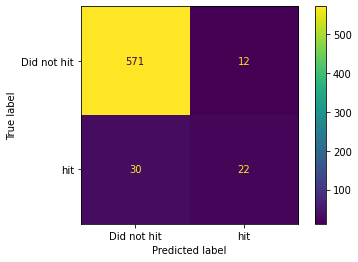

In [321]:
plot_confusion_matrix(clf_xgb,X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [322]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]
}

In [323]:
eval_set = [(X_test, y_test)]

In [327]:
gsearch1 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid, scoring='f1_micro'
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-aucpr:0.34751
[1]	validation_0-aucpr:0.41781
[2]	validation_0-aucpr:0.41838
[3]	validation_0-aucpr:0.44905
[4]	validation_0-aucpr:0.46253
[0]	validation_0-aucpr:0.39881
[0]	validation_0-aucpr:0.41509
[1]	validation_0-aucpr:0.43598
[5]	validation_0-aucpr:0.49351
[1]	validation_0-aucpr:0.44690
[6]	validation_0-aucpr:0.47477
[2]	validation_0-aucpr:0.46031
[0]	validation_0-aucpr:0.42673
[3]	validation_0-aucpr:0.46864
[2]	validation_0-aucpr:0.45110
[4]	validation_0-aucpr:0.47995
[3]	validation_0-aucpr:0.44414
[5]	validation_0-aucpr:0.49658
[6]	validation_0-aucpr:0.49294
[1]	validation_0-aucpr:0.47845
[7]	validation_0-aucpr:0.48654
[0]	validation_0-aucpr:0.43868
[2]	validation_0-aucpr:0.48236
[8]	validation_0-aucpr:0.50846
[1]	validation_0-aucpr:0.45422
[9]	validation_0-aucpr:0.51489
[4]	validation_0-aucpr:0.46168
[5]	validation_0-aucpr:0.46127
[6]	validation_0-aucpr:0.46570
[3]	validation_0-aucpr:0.46787
[7]	val

[48]	validation_0-aucpr:0.55062
[43]	validation_0-aucpr:0.50271
[31]	validation_0-aucpr:0.56183
[38]	validation_0-aucpr:0.56530
[49]	validation_0-aucpr:0.55107
[32]	validation_0-aucpr:0.56230
[37]	validation_0-aucpr:0.48058
[39]	validation_0-aucpr:0.56739
[57]	validation_0-aucpr:0.53598
[38]	validation_0-aucpr:0.47967
[46]	validation_0-aucpr:0.52884
[51]	validation_0-aucpr:0.50445
[58]	validation_0-aucpr:0.53890
[47]	validation_0-aucpr:0.52862
[33]	validation_0-aucpr:0.56027
[52]	validation_0-aucpr:0.50700
[43]	validation_0-aucpr:0.50996
[59]	validation_0-aucpr:0.53798
[50]	validation_0-aucpr:0.56030
[48]	validation_0-aucpr:0.54027
[44]	validation_0-aucpr:0.50383
[44]	validation_0-aucpr:0.50744
[40]	validation_0-aucpr:0.57439
[51]	validation_0-aucpr:0.56132
[45]	validation_0-aucpr:0.51253
[45]	validation_0-aucpr:0.50901
[41]	validation_0-aucpr:0.57476
[39]	validation_0-aucpr:0.47709
[52]	validation_0-aucpr:0.56104
[42]	validation_0-aucpr:0.57404
[40]	validation_0-aucpr:0.47485
[53]	val

[86]	validation_0-aucpr:0.55885
[80]	validation_0-aucpr:0.51025
[88]	validation_0-aucpr:0.51024
[81]	validation_0-aucpr:0.56680
[87]	validation_0-aucpr:0.56017
[81]	validation_0-aucpr:0.51057
[79]	validation_0-aucpr:0.51068
[82]	validation_0-aucpr:0.55994
[96]	validation_0-aucpr:0.57161
[76]	validation_0-aucpr:0.50458
[80]	validation_0-aucpr:0.50477
[83]	validation_0-aucpr:0.56275
[68]	validation_0-aucpr:0.53380
[97]	validation_0-aucpr:0.57086
[77]	validation_0-aucpr:0.50532
[81]	validation_0-aucpr:0.49577
[74]	validation_0-aucpr:0.51643
[69]	validation_0-aucpr:0.52213
[98]	validation_0-aucpr:0.56858
[82]	validation_0-aucpr:0.50953
[70]	validation_0-aucpr:0.51761
[99]	validation_0-aucpr:0.57009
[75]	validation_0-aucpr:0.51313
[83]	validation_0-aucpr:0.51058
[89]	validation_0-aucpr:0.50932
[76]	validation_0-aucpr:0.50899
[84]	validation_0-aucpr:0.51054
[90]	validation_0-aucpr:0.50790
[84]	validation_0-aucpr:0.55961
[91]	validation_0-aucpr:0.51033
[78]	validation_0-aucpr:0.50679
[82]	val

[28]	validation_0-aucpr:0.53827
[27]	validation_0-aucpr:0.58605
[35]	validation_0-aucpr:0.49143
[29]	validation_0-aucpr:0.53915
[28]	validation_0-aucpr:0.58827
[36]	validation_0-aucpr:0.49269
[28]	validation_0-aucpr:0.57029
[29]	validation_0-aucpr:0.57977
[16]	validation_0-aucpr:0.46707
[28]	validation_0-aucpr:0.47515
[29]	validation_0-aucpr:0.56610
[32]	validation_0-aucpr:0.53632
[17]	validation_0-aucpr:0.46869
[29]	validation_0-aucpr:0.47668
[20]	validation_0-aucpr:0.48647
[33]	validation_0-aucpr:0.53735
[18]	validation_0-aucpr:0.48309
[30]	validation_0-aucpr:0.47802
[21]	validation_0-aucpr:0.48396
[42]	validation_0-aucpr:0.50474
[37]	validation_0-aucpr:0.49514
[30]	validation_0-aucpr:0.54853
[22]	validation_0-aucpr:0.48388
[43]	validation_0-aucpr:0.50343
[38]	validation_0-aucpr:0.49787
[31]	validation_0-aucpr:0.54699
[44]	validation_0-aucpr:0.50460
[39]	validation_0-aucpr:0.49797
[30]	validation_0-aucpr:0.56849
[19]	validation_0-aucpr:0.48743
[31]	validation_0-aucpr:0.56926
[20]	val

[51]	validation_0-aucpr:0.51393
[62]	validation_0-aucpr:0.50170
[56]	validation_0-aucpr:0.52124
[63]	validation_0-aucpr:0.55106
[62]	validation_0-aucpr:0.54491
[57]	validation_0-aucpr:0.52982
[64]	validation_0-aucpr:0.54561
[76]	validation_0-aucpr:0.50338
[65]	validation_0-aucpr:0.57510
[71]	validation_0-aucpr:0.53639
[77]	validation_0-aucpr:0.50458
[66]	validation_0-aucpr:0.57310
[72]	validation_0-aucpr:0.53412
[78]	validation_0-aucpr:0.50354
[73]	validation_0-aucpr:0.52228
[63]	validation_0-aucpr:0.56647
[52]	validation_0-aucpr:0.51954
[63]	validation_0-aucpr:0.50167
[64]	validation_0-aucpr:0.56458
[53]	validation_0-aucpr:0.52233
[64]	validation_0-aucpr:0.50442
[63]	validation_0-aucpr:0.54502
[65]	validation_0-aucpr:0.50401
[58]	validation_0-aucpr:0.52647
[67]	validation_0-aucpr:0.57364
[64]	validation_0-aucpr:0.54593
[65]	validation_0-aucpr:0.54145
[59]	validation_0-aucpr:0.53402
[68]	validation_0-aucpr:0.57601
[66]	validation_0-aucpr:0.54947
[65]	validation_0-aucpr:0.54810
[69]	val

[98]	validation_0-aucpr:0.57970
[94]	validation_0-aucpr:0.57065
[97]	validation_0-aucpr:0.49580
[99]	validation_0-aucpr:0.58544
[98]	validation_0-aucpr:0.49532
[2]	validation_0-aucpr:0.47534
[95]	validation_0-aucpr:0.57134
[85]	validation_0-aucpr:0.55189
[96]	validation_0-aucpr:0.50444
[3]	validation_0-aucpr:0.48844
[96]	validation_0-aucpr:0.57608
[86]	validation_0-aucpr:0.55274
[97]	validation_0-aucpr:0.50468
[97]	validation_0-aucpr:0.57147
[90]	validation_0-aucpr:0.54744
[96]	validation_0-aucpr:0.52601
[91]	validation_0-aucpr:0.54662
[97]	validation_0-aucpr:0.52234
[92]	validation_0-aucpr:0.54937
[98]	validation_0-aucpr:0.52601
[99]	validation_0-aucpr:0.49304
[4]	validation_0-aucpr:0.49788
[5]	validation_0-aucpr:0.50567
[6]	validation_0-aucpr:0.53017
[87]	validation_0-aucpr:0.55783
[98]	validation_0-aucpr:0.57099
[88]	validation_0-aucpr:0.55434
[99]	validation_0-aucpr:0.57044
[89]	validation_0-aucpr:0.55145
[90]	validation_0-aucpr:0.55235
[99]	validation_0-aucpr:0.52587
[93]	validati

[44]	validation_0-aucpr:0.56809
[44]	validation_0-aucpr:0.50863
[47]	validation_0-aucpr:0.53354
[54]	validation_0-aucpr:0.50620
[27]	validation_0-aucpr:0.56607
[45]	validation_0-aucpr:0.56493
[43]	validation_0-aucpr:0.57275
[70]	validation_0-aucpr:0.51454
[55]	validation_0-aucpr:0.50582
[42]	validation_0-aucpr:0.54272
[44]	validation_0-aucpr:0.56739
[71]	validation_0-aucpr:0.51538
[56]	validation_0-aucpr:0.50450
[43]	validation_0-aucpr:0.54832
[72]	validation_0-aucpr:0.50836
[45]	validation_0-aucpr:0.50988
[38]	validation_0-aucpr:0.51286
[44]	validation_0-aucpr:0.53910
[46]	validation_0-aucpr:0.54916
[46]	validation_0-aucpr:0.51881
[28]	validation_0-aucpr:0.56999
[39]	validation_0-aucpr:0.51320
[47]	validation_0-aucpr:0.54561
[47]	validation_0-aucpr:0.52000
[29]	validation_0-aucpr:0.57097
[48]	validation_0-aucpr:0.55117
[57]	validation_0-aucpr:0.50802
[30]	validation_0-aucpr:0.55780
[45]	validation_0-aucpr:0.55495
[49]	validation_0-aucpr:0.55095
[58]	validation_0-aucpr:0.50551
[31]	val

[75]	validation_0-aucpr:0.53930
[89]	validation_0-aucpr:0.52228
[78]	validation_0-aucpr:0.55283
[76]	validation_0-aucpr:0.54197
[75]	validation_0-aucpr:0.55659
[79]	validation_0-aucpr:0.55434
[77]	validation_0-aucpr:0.54147
[76]	validation_0-aucpr:0.55462
[77]	validation_0-aucpr:0.54806
[70]	validation_0-aucpr:0.53669
[55]	validation_0-aucpr:0.56710
[78]	validation_0-aucpr:0.48706
[78]	validation_0-aucpr:0.55178
[71]	validation_0-aucpr:0.54084
[56]	validation_0-aucpr:0.57638
[79]	validation_0-aucpr:0.48500
[79]	validation_0-aucpr:0.55205
[80]	validation_0-aucpr:0.48300
[80]	validation_0-aucpr:0.55836
[90]	validation_0-aucpr:0.52475
[78]	validation_0-aucpr:0.53936
[91]	validation_0-aucpr:0.52821
[81]	validation_0-aucpr:0.56277
[77]	validation_0-aucpr:0.55332
[79]	validation_0-aucpr:0.54548
[80]	validation_0-aucpr:0.54645
[78]	validation_0-aucpr:0.55689
[72]	validation_0-aucpr:0.54103
[81]	validation_0-aucpr:0.54680
[79]	validation_0-aucpr:0.55613
[73]	validation_0-aucpr:0.54261
[57]	val

[35]	validation_0-aucpr:0.47884
[14]	validation_0-aucpr:0.49044
[48]	validation_0-aucpr:0.53003
[22]	validation_0-aucpr:0.53257
[36]	validation_0-aucpr:0.47661
[49]	validation_0-aucpr:0.53053
[15]	validation_0-aucpr:0.48687
[23]	validation_0-aucpr:0.53219
[19]	validation_0-aucpr:0.50891
[50]	validation_0-aucpr:0.51391
[24]	validation_0-aucpr:0.53402
[30]	validation_0-aucpr:0.55761
[20]	validation_0-aucpr:0.51489
[25]	validation_0-aucpr:0.53464
[22]	validation_0-aucpr:0.47860
[31]	validation_0-aucpr:0.56043
[21]	validation_0-aucpr:0.51547
[23]	validation_0-aucpr:0.48109
[16]	validation_0-aucpr:0.50350
[22]	validation_0-aucpr:0.52087
[21]	validation_0-aucpr:0.51316
[37]	validation_0-aucpr:0.47596
[17]	validation_0-aucpr:0.49830
[22]	validation_0-aucpr:0.52343
[38]	validation_0-aucpr:0.48888
[32]	validation_0-aucpr:0.56104
[33]	validation_0-aucpr:0.56393
[18]	validation_0-aucpr:0.50424
[34]	validation_0-aucpr:0.57096
[19]	validation_0-aucpr:0.50498
[23]	validation_0-aucpr:0.52818
[24]	val

[74]	validation_0-aucpr:0.48977
[36]	validation_0-aucpr:0.54913
[55]	validation_0-aucpr:0.48085
[50]	validation_0-aucpr:0.48235
[37]	validation_0-aucpr:0.55234
[56]	validation_0-aucpr:0.46265
[51]	validation_0-aucpr:0.48112
[38]	validation_0-aucpr:0.55380
[57]	validation_0-aucpr:0.54931
[58]	validation_0-aucpr:0.51212
[87]	validation_0-aucpr:0.50561
[58]	validation_0-aucpr:0.55128
[59]	validation_0-aucpr:0.50544
[88]	validation_0-aucpr:0.50609
[89]	validation_0-aucpr:0.50322
[70]	validation_0-aucpr:0.56815
[59]	validation_0-aucpr:0.50824
[57]	validation_0-aucpr:0.45745
[75]	validation_0-aucpr:0.48880
[71]	validation_0-aucpr:0.56971
[60]	validation_0-aucpr:0.49999
[58]	validation_0-aucpr:0.45843
[76]	validation_0-aucpr:0.49081
[60]	validation_0-aucpr:0.50639
[59]	validation_0-aucpr:0.56418
[52]	validation_0-aucpr:0.48392
[60]	validation_0-aucpr:0.54475
[53]	validation_0-aucpr:0.48212
[61]	validation_0-aucpr:0.50170
[61]	validation_0-aucpr:0.55581
[62]	validation_0-aucpr:0.49863
[62]	val

[82]	validation_0-aucpr:0.49472
[91]	validation_0-aucpr:0.48803
[27]	validation_0-aucpr:0.52150
[83]	validation_0-aucpr:0.49422
[5]	validation_0-aucpr:0.50794
[84]	validation_0-aucpr:0.48989
[90]	validation_0-aucpr:0.54209
[6]	validation_0-aucpr:0.50052
[13]	validation_0-aucpr:0.48629
[91]	validation_0-aucpr:0.54083
[68]	validation_0-aucpr:0.58888
[92]	validation_0-aucpr:0.48894
[14]	validation_0-aucpr:0.51030
[69]	validation_0-aucpr:0.57857
[93]	validation_0-aucpr:0.48911
[93]	validation_0-aucpr:0.49394
[28]	validation_0-aucpr:0.52095
[29]	validation_0-aucpr:0.51310
[94]	validation_0-aucpr:0.49656
[85]	validation_0-aucpr:0.49013
[86]	validation_0-aucpr:0.48851
[7]	validation_0-aucpr:0.48998
[92]	validation_0-aucpr:0.54062
[15]	validation_0-aucpr:0.51050
[8]	validation_0-aucpr:0.50318
[93]	validation_0-aucpr:0.53729
[70]	validation_0-aucpr:0.57797
[16]	validation_0-aucpr:0.50040
[94]	validation_0-aucpr:0.49108
[95]	validation_0-aucpr:0.49434
[71]	validation_0-aucpr:0.58133
[30]	validat

[66]	validation_0-aucpr:0.50402
[33]	validation_0-aucpr:0.50837
[11]	validation_0-aucpr:0.45807
[33]	validation_0-aucpr:0.54545
[34]	validation_0-aucpr:0.50840
[12]	validation_0-aucpr:0.46507
[35]	validation_0-aucpr:0.51470
[30]	validation_0-aucpr:0.48930
[41]	validation_0-aucpr:0.50923
[49]	validation_0-aucpr:0.58972
[31]	validation_0-aucpr:0.48979
[72]	validation_0-aucpr:0.51564
[42]	validation_0-aucpr:0.51734
[50]	validation_0-aucpr:0.59565
[33]	validation_0-aucpr:0.53170
[73]	validation_0-aucpr:0.51526
[13]	validation_0-aucpr:0.46948
[34]	validation_0-aucpr:0.54603
[34]	validation_0-aucpr:0.53762
[14]	validation_0-aucpr:0.47064
[35]	validation_0-aucpr:0.53713
[43]	validation_0-aucpr:0.48950
[44]	validation_0-aucpr:0.50295
[36]	validation_0-aucpr:0.51587
[67]	validation_0-aucpr:0.50420
[37]	validation_0-aucpr:0.51216
[32]	validation_0-aucpr:0.49391
[68]	validation_0-aucpr:0.50369
[51]	validation_0-aucpr:0.60008
[74]	validation_0-aucpr:0.52367
[33]	validation_0-aucpr:0.49578
[35]	val

[43]	validation_0-aucpr:0.55137
[86]	validation_0-aucpr:0.49338
[68]	validation_0-aucpr:0.52057
[16]	validation_0-aucpr:0.53320
[87]	validation_0-aucpr:0.49451
[17]	validation_0-aucpr:0.53410
[29]	validation_0-aucpr:0.49750
[90]	validation_0-aucpr:0.50563
[30]	validation_0-aucpr:0.49764
[91]	validation_0-aucpr:0.50834
[91]	validation_0-aucpr:0.54640
[44]	validation_0-aucpr:0.55355
[92]	validation_0-aucpr:0.54474
[69]	validation_0-aucpr:0.52246
[45]	validation_0-aucpr:0.55186
[70]	validation_0-aucpr:0.52084
[88]	validation_0-aucpr:0.50809
[93]	validation_0-aucpr:0.54383
[18]	validation_0-aucpr:0.53498
[89]	validation_0-aucpr:0.50735
[94]	validation_0-aucpr:0.54543
[92]	validation_0-aucpr:0.50465
[31]	validation_0-aucpr:0.49937
[93]	validation_0-aucpr:0.50153
[32]	validation_0-aucpr:0.49740
[19]	validation_0-aucpr:0.53212
[71]	validation_0-aucpr:0.51985
[46]	validation_0-aucpr:0.54705
[20]	validation_0-aucpr:0.53133
[90]	validation_0-aucpr:0.50954
[72]	validation_0-aucpr:0.52163
[47]	val

[86]	validation_0-aucpr:0.52432
[30]	validation_0-aucpr:0.54000
[19]	validation_0-aucpr:0.48123
[74]	validation_0-aucpr:0.53109
[33]	validation_0-aucpr:0.52977
[75]	validation_0-aucpr:0.53282
[34]	validation_0-aucpr:0.57077
[14]	validation_0-aucpr:0.53753
[34]	validation_0-aucpr:0.53201
[20]	validation_0-aucpr:0.58354
[35]	validation_0-aucpr:0.57416
[87]	validation_0-aucpr:0.51828
[61]	validation_0-aucpr:0.55340
[21]	validation_0-aucpr:0.57903
[31]	validation_0-aucpr:0.54343
[88]	validation_0-aucpr:0.51847
[20]	validation_0-aucpr:0.48205
[62]	validation_0-aucpr:0.55142
[32]	validation_0-aucpr:0.54722
[76]	validation_0-aucpr:0.53326
[21]	validation_0-aucpr:0.48256
[77]	validation_0-aucpr:0.53101
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-aucpr:0.35102
[36]	validation_0-aucpr:0.56974
[15]	validation_0-aucpr:0.54470
[37]	validation_0-aucpr:0.57175
[35]	validation_0-aucpr:0.53326
[16]	validation_0-aucpr:0.55019

[65]	validation_0-aucpr:0.51093
[64]	validation_0-aucpr:0.52204
[51]	validation_0-aucpr:0.56051
[66]	validation_0-aucpr:0.51134
[36]	validation_0-aucpr:0.51127
[52]	validation_0-aucpr:0.56278
[67]	validation_0-aucpr:0.51441
[37]	validation_0-aucpr:0.51430
[14]	validation_0-aucpr:0.47083
[78]	validation_0-aucpr:0.54475
[74]	validation_0-aucpr:0.58396
[79]	validation_0-aucpr:0.52820
[75]	validation_0-aucpr:0.58528
[80]	validation_0-aucpr:0.52887
[79]	validation_0-aucpr:0.55049
[5]	validation_0-aucpr:0.48282
[65]	validation_0-aucpr:0.52110
[66]	validation_0-aucpr:0.52227
[53]	validation_0-aucpr:0.56147
[38]	validation_0-aucpr:0.51251
[54]	validation_0-aucpr:0.55220
[81]	validation_0-aucpr:0.52713
[39]	validation_0-aucpr:0.50247
[15]	validation_0-aucpr:0.46735
[76]	validation_0-aucpr:0.58432
[82]	validation_0-aucpr:0.53001
[80]	validation_0-aucpr:0.54965
[77]	validation_0-aucpr:0.57972
[16]	validation_0-aucpr:0.47029
[6]	validation_0-aucpr:0.47923
[81]	validation_0-aucpr:0.54851
[67]	valid

[68]	validation_0-aucpr:0.47354
[32]	validation_0-aucpr:0.54575
[99]	validation_0-aucpr:0.51524
[99]	validation_0-aucpr:0.52904
[84]	validation_0-aucpr:0.55909
[20]	validation_0-aucpr:0.46787
[85]	validation_0-aucpr:0.55742
[21]	validation_0-aucpr:0.47265
[3]	validation_0-aucpr:0.42020
[69]	validation_0-aucpr:0.47494
[44]	validation_0-aucpr:0.49118
[70]	validation_0-aucpr:0.47860
[4]	validation_0-aucpr:0.44564
[45]	validation_0-aucpr:0.49147
[33]	validation_0-aucpr:0.55169
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   1.5s
[0]	validation_0-aucpr:0.40573
[1]	validation_0-aucpr:0.41102
[34]	validation_0-aucpr:0.55130
[35]	validation_0-aucpr:0.54900
[86]	validation_0-aucpr:0.56007
[22]	validation_0-aucpr:0.47060
[87]	validation_0-aucpr:0.55961
[5]	validation_0-aucpr:0.43923
[71]	validation_0-aucpr:0.47997
[46]	validation_0-aucpr:0.49116
[72]	validation_0-aucpr:0.47841
[47]	validation_0-aucpr:0.49115
[2]	validation_0-aucpr:0.47279
[36]

[16]	validation_0-aucpr:0.46295
[16]	validation_0-aucpr:0.51699
[51]	validation_0-aucpr:0.48694
[17]	validation_0-aucpr:0.47475
[52]	validation_0-aucpr:0.48055
[4]	validation_0-aucpr:0.49130
[32]	validation_0-aucpr:0.48543
[5]	validation_0-aucpr:0.47993
[65]	validation_0-aucpr:0.54424
[28]	validation_0-aucpr:0.52356
[66]	validation_0-aucpr:0.54389
[29]	validation_0-aucpr:0.52381
[17]	validation_0-aucpr:0.52167
[18]	validation_0-aucpr:0.46859
[18]	validation_0-aucpr:0.52600
[53]	validation_0-aucpr:0.48211
[19]	validation_0-aucpr:0.48242
[33]	validation_0-aucpr:0.48573
[79]	validation_0-aucpr:0.50327
[20]	validation_0-aucpr:0.49068
[6]	validation_0-aucpr:0.49287
[34]	validation_0-aucpr:0.48497
[26]	validation_0-aucpr:0.49505
[67]	validation_0-aucpr:0.54536
[30]	validation_0-aucpr:0.53045
[27]	validation_0-aucpr:0.48936
[19]	validation_0-aucpr:0.52668
[68]	validation_0-aucpr:0.54506
[31]	validation_0-aucpr:0.53595
[54]	validation_0-aucpr:0.48034
[20]	validation_0-aucpr:0.52851
[69]	valida

[82]	validation_0-aucpr:0.48938
[67]	validation_0-aucpr:0.47930
[78]	validation_0-aucpr:0.54905
[76]	validation_0-aucpr:0.47687
[83]	validation_0-aucpr:0.48931
[79]	validation_0-aucpr:0.55148
[77]	validation_0-aucpr:0.47745
[44]	validation_0-aucpr:0.48962
[69]	validation_0-aucpr:0.54317
[45]	validation_0-aucpr:0.49014
[70]	validation_0-aucpr:0.54366
[3]	validation_0-aucpr:0.41862
[56]	validation_0-aucpr:0.52795
[46]	validation_0-aucpr:0.48999
[33]	validation_0-aucpr:0.52949
[4]	validation_0-aucpr:0.41852
[68]	validation_0-aucpr:0.48065
[57]	validation_0-aucpr:0.53211
[69]	validation_0-aucpr:0.47879
[80]	validation_0-aucpr:0.55649
[84]	validation_0-aucpr:0.48934
[78]	validation_0-aucpr:0.47844
[34]	validation_0-aucpr:0.53230
[71]	validation_0-aucpr:0.54667
[79]	validation_0-aucpr:0.48001
[47]	validation_0-aucpr:0.48932
[72]	validation_0-aucpr:0.54422
[35]	validation_0-aucpr:0.51864
[58]	validation_0-aucpr:0.52982
[5]	validation_0-aucpr:0.42521
[73]	validation_0-aucpr:0.53759
[74]	valida

[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   2.3s
[0]	validation_0-aucpr:0.46497
[34]	validation_0-aucpr:0.47279
[35]	validation_0-aucpr:0.48132
[1]	validation_0-aucpr:0.47662
[80]	validation_0-aucpr:0.49165
[90]	validation_0-aucpr:0.50659
[2]	validation_0-aucpr:0.44687
[65]	validation_0-aucpr:0.54521
[23]	validation_0-aucpr:0.47460
[24]	validation_0-aucpr:0.47428
[66]	validation_0-aucpr:0.54188
[2]	validation_0-aucpr:0.50875
[67]	validation_0-aucpr:0.53807
[91]	validation_0-aucpr:0.51361
[36]	validation_0-aucpr:0.47471
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   2.4s
[0]	validation_0-aucpr:0.41317
[68]	validation_0-aucpr:0.53405
[92]	validation_0-aucpr:0.51330
[81]	validation_0-aucpr:0.48998
[69]	validation_0-aucpr:0.52915
[82]	validation_0-aucpr:0.49035
[3]	validation_0-aucpr:0.44179
[3]	validation_0-aucpr:0.50495
[25]	validation_0-aucpr:0.48717
[4]	validation_0-aucpr:0.52230
[4

[33]	validation_0-aucpr:0.50973
[26]	validation_0-aucpr:0.51959
[17]	validation_0-aucpr:0.46347
[27]	validation_0-aucpr:0.49359
[36]	validation_0-aucpr:0.48908
[37]	validation_0-aucpr:0.49113
[28]	validation_0-aucpr:0.49306
[27]	validation_0-aucpr:0.51922
[36]	validation_0-aucpr:0.50174
[8]	validation_0-aucpr:0.48517
[37]	validation_0-aucpr:0.49889
[61]	validation_0-aucpr:0.47670
[62]	validation_0-aucpr:0.47943
[9]	validation_0-aucpr:0.48670
[18]	validation_0-aucpr:0.46510
[63]	validation_0-aucpr:0.47716
[19]	validation_0-aucpr:0.46629
[34]	validation_0-aucpr:0.50539
[28]	validation_0-aucpr:0.51255
[38]	validation_0-aucpr:0.48983
[29]	validation_0-aucpr:0.52191
[29]	validation_0-aucpr:0.49279
[35]	validation_0-aucpr:0.50375
[75]	validation_0-aucpr:0.47066
[30]	validation_0-aucpr:0.51564
[38]	validation_0-aucpr:0.50126
[30]	validation_0-aucpr:0.49482
[10]	validation_0-aucpr:0.49507
[76]	validation_0-aucpr:0.49022
[11]	validation_0-aucpr:0.49564
[39]	validation_0-aucpr:0.49335
[20]	valid

[62]	validation_0-aucpr:0.51496
[67]	validation_0-aucpr:0.46651
[36]	validation_0-aucpr:0.51865
[56]	validation_0-aucpr:0.53516
[68]	validation_0-aucpr:0.46151
[66]	validation_0-aucpr:0.51135
[48]	validation_0-aucpr:0.50058
[67]	validation_0-aucpr:0.51123
[58]	validation_0-aucpr:0.51434
[92]	validation_0-aucpr:0.47585
[19]	validation_0-aucpr:0.52331
[59]	validation_0-aucpr:0.51508
[63]	validation_0-aucpr:0.51312
[93]	validation_0-aucpr:0.47922
[57]	validation_0-aucpr:0.53662
[37]	validation_0-aucpr:0.51652
[58]	validation_0-aucpr:0.53299
[68]	validation_0-aucpr:0.51152
[38]	validation_0-aucpr:0.51723
[49]	validation_0-aucpr:0.49905
[20]	validation_0-aucpr:0.50513
[69]	validation_0-aucpr:0.51059
[69]	validation_0-aucpr:0.46096
[50]	validation_0-aucpr:0.50038
[21]	validation_0-aucpr:0.49628
[94]	validation_0-aucpr:0.48015
[64]	validation_0-aucpr:0.51336
[59]	validation_0-aucpr:0.53266
[65]	validation_0-aucpr:0.51578
[39]	validation_0-aucpr:0.52085
[60]	validation_0-aucpr:0.51440
[60]	val

[89]	validation_0-aucpr:0.51571
[95]	validation_0-aucpr:0.48594
[90]	validation_0-aucpr:0.51241
[96]	validation_0-aucpr:0.48623
[79]	validation_0-aucpr:0.50968
[89]	validation_0-aucpr:0.52954
[97]	validation_0-aucpr:0.48657
[67]	validation_0-aucpr:0.55333
[49]	validation_0-aucpr:0.50302
[22]	validation_0-aucpr:0.47799
[80]	validation_0-aucpr:0.50904
[6]	validation_0-aucpr:0.51974
[23]	validation_0-aucpr:0.48134
[81]	validation_0-aucpr:0.51044
[90]	validation_0-aucpr:0.52805
[10]	validation_0-aucpr:0.53800
[91]	validation_0-aucpr:0.52995
[68]	validation_0-aucpr:0.55724
[7]	validation_0-aucpr:0.52431
[11]	validation_0-aucpr:0.52959
[69]	validation_0-aucpr:0.55858
[92]	validation_0-aucpr:0.53394
[8]	validation_0-aucpr:0.52078
[50]	validation_0-aucpr:0.50139
[91]	validation_0-aucpr:0.51438
[93]	validation_0-aucpr:0.53653
[24]	validation_0-aucpr:0.47837
[51]	validation_0-aucpr:0.50036
[92]	validation_0-aucpr:0.50737
[25]	validation_0-aucpr:0.47910
[82]	validation_0-aucpr:0.50747
[12]	valida

[22]	validation_0-aucpr:0.47362
[14]	validation_0-aucpr:0.47039
[23]	validation_0-aucpr:0.47696
[36]	validation_0-aucpr:0.50440
[24]	validation_0-aucpr:0.47145
[55]	validation_0-aucpr:0.48286
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   2.1s
[0]	validation_0-aucpr:0.42673
[21]	validation_0-aucpr:0.41250
[80]	validation_0-aucpr:0.48223
[40]	validation_0-aucpr:0.56311
[16]	validation_0-aucpr:0.43991
[22]	validation_0-aucpr:0.41473
[99]	validation_0-aucpr:0.56629
[17]	validation_0-aucpr:0.44300
[81]	validation_0-aucpr:0.48336
[41]	validation_0-aucpr:0.56506
[15]	validation_0-aucpr:0.47053
[37]	validation_0-aucpr:0.51630
[16]	validation_0-aucpr:0.47118
[23]	validation_0-aucpr:0.41250
[1]	validation_0-aucpr:0.42673
[17]	validation_0-aucpr:0.47325
[38]	validation_0-aucpr:0.51469
[24]	validation_0-aucpr:0.41473
[2]	validation_0-aucpr:0.42673
[25]	validation_0-aucpr:0.41250
[56]	validation_0-aucpr:0.48231
[18]	validation_0-aucpr:0.44209
[

[69]	validation_0-aucpr:0.49931
[63]	validation_0-aucpr:0.49859
[63]	validation_0-aucpr:0.52451
[70]	validation_0-aucpr:0.50745
[45]	validation_0-aucpr:0.47246
[64]	validation_0-aucpr:0.49543
[65]	validation_0-aucpr:0.49624
[46]	validation_0-aucpr:0.47888
[47]	validation_0-aucpr:0.47964
[54]	validation_0-aucpr:0.51346
[27]	validation_0-aucpr:0.46052
[28]	validation_0-aucpr:0.49536
[8]	validation_0-aucpr:0.44231
[67]	validation_0-aucpr:0.49500
[29]	validation_0-aucpr:0.49536
[9]	validation_0-aucpr:0.44635
[71]	validation_0-aucpr:0.59075
[86]	validation_0-aucpr:0.48750
[68]	validation_0-aucpr:0.50122
[64]	validation_0-aucpr:0.52451
[72]	validation_0-aucpr:0.59831
[71]	validation_0-aucpr:0.50755
[65]	validation_0-aucpr:0.52434
[72]	validation_0-aucpr:0.51132
[73]	validation_0-aucpr:0.59575
[66]	validation_0-aucpr:0.52452
[48]	validation_0-aucpr:0.48670
[55]	validation_0-aucpr:0.52574
[30]	validation_0-aucpr:0.49922
[49]	validation_0-aucpr:0.48828
[74]	validation_0-aucpr:0.59547
[10]	valid

[6]	validation_0-aucpr:0.43735
[7]	validation_0-aucpr:0.44460
[8]	validation_0-aucpr:0.44460
[75]	validation_0-aucpr:0.52032
[76]	validation_0-aucpr:0.51974
[55]	validation_0-aucpr:0.44899
[93]	validation_0-aucpr:0.49519
[12]	validation_0-aucpr:0.45144
[94]	validation_0-aucpr:0.49535
[13]	validation_0-aucpr:0.44993
[56]	validation_0-aucpr:0.44961
[57]	validation_0-aucpr:0.44522
[86]	validation_0-aucpr:0.49809
[77]	validation_0-aucpr:0.51841
[9]	validation_0-aucpr:0.44460
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.4s
[0]	validation_0-aucpr:0.41416
[95]	validation_0-aucpr:0.49530
[78]	validation_0-aucpr:0.51885
[10]	validation_0-aucpr:0.44460
[1]	validation_0-aucpr:0.42287
[96]	validation_0-aucpr:0.49494
[79]	validation_0-aucpr:0.51372
[58]	validation_0-aucpr:0.44102
[80]	validation_0-aucpr:0.51408
[14]	validation_0-aucpr:0.44943
[59]	validation_0-aucpr:0.44048
[81]	validation_0-aucpr:0.53026
[15]	validation_0-aucpr:0.45079
[87]	v

[2]	validation_0-aucpr:0.43868
[37]	validation_0-aucpr:0.45276
[42]	validation_0-aucpr:0.50618
[4]	validation_0-aucpr:0.35919
[56]	validation_0-aucpr:0.46842
[43]	validation_0-aucpr:0.50437
[39]	validation_0-aucpr:0.51870
[29]	validation_0-aucpr:0.51612
[40]	validation_0-aucpr:0.51912
[30]	validation_0-aucpr:0.51500
[41]	validation_0-aucpr:0.51912
[44]	validation_0-aucpr:0.50478
[38]	validation_0-aucpr:0.45591
[45]	validation_0-aucpr:0.50434
[57]	validation_0-aucpr:0.46816
[39]	validation_0-aucpr:0.45440
[5]	validation_0-aucpr:0.35888
[23]	validation_0-aucpr:0.48418
[3]	validation_0-aucpr:0.43868
[55]	validation_0-aucpr:0.47148
[6]	validation_0-aucpr:0.35888
[24]	validation_0-aucpr:0.48513
[4]	validation_0-aucpr:0.43868
[56]	validation_0-aucpr:0.47320
[7]	validation_0-aucpr:0.35888
[25]	validation_0-aucpr:0.48294
[31]	validation_0-aucpr:0.51411
[5]	validation_0-aucpr:0.43868
[46]	validation_0-aucpr:0.50509
[58]	validation_0-aucpr:0.46904
[32]	validation_0-aucpr:0.51371
[42]	validation_

[32]	validation_0-aucpr:0.47342
[13]	validation_0-aucpr:0.49389
[83]	validation_0-aucpr:0.46033
[32]	validation_0-aucpr:0.49970
[86]	validation_0-aucpr:0.48159
[14]	validation_0-aucpr:0.49324
[33]	validation_0-aucpr:0.52775
[59]	validation_0-aucpr:0.49444
[34]	validation_0-aucpr:0.52775
[60]	validation_0-aucpr:0.49559
[52]	validation_0-aucpr:0.48378
[61]	validation_0-aucpr:0.49540
[53]	validation_0-aucpr:0.48406
[54]	validation_0-aucpr:0.48496
[70]	validation_0-aucpr:0.52557
[55]	validation_0-aucpr:0.48432
[73]	validation_0-aucpr:0.50345
[67]	validation_0-aucpr:0.49567
[71]	validation_0-aucpr:0.52557
[56]	validation_0-aucpr:0.48415
[74]	validation_0-aucpr:0.50311
[68]	validation_0-aucpr:0.49544
[33]	validation_0-aucpr:0.46715
[75]	validation_0-aucpr:0.50408
[69]	validation_0-aucpr:0.49683
[84]	validation_0-aucpr:0.46008
[87]	validation_0-aucpr:0.48194
[34]	validation_0-aucpr:0.46743
[70]	validation_0-aucpr:0.49741
[85]	validation_0-aucpr:0.45993
[15]	validation_0-aucpr:0.49111
[71]	val

[99]	validation_0-aucpr:0.51695
[43]	validation_0-aucpr:0.53302
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-aucpr:0.43735
[92]	validation_0-aucpr:0.48015
[93]	validation_0-aucpr:0.47871
[82]	validation_0-aucpr:0.49158
[65]	validation_0-aucpr:0.52218
[62]	validation_0-aucpr:0.44583
[83]	validation_0-aucpr:0.49251
[44]	validation_0-aucpr:0.53673
[66]	validation_0-aucpr:0.52861
[63]	validation_0-aucpr:0.44366
[84]	validation_0-aucpr:0.49294
[45]	validation_0-aucpr:0.52263
[46]	validation_0-aucpr:0.52332
[1]	validation_0-aucpr:0.43735
[94]	validation_0-aucpr:0.48108
[2]	validation_0-aucpr:0.43735
[95]	validation_0-aucpr:0.48166
[85]	validation_0-aucpr:0.49334
[96]	validation_0-aucpr:0.48289
[67]	validation_0-aucpr:0.52872
[86]	validation_0-aucpr:0.49401
[64]	validation_0-aucpr:0.44301
[68]	validation_0-aucpr:0.52912
[65]	validation_0-aucpr:0.44066
[47]	validation_0-aucpr:0.52499
[69]	validation_0-aucpr:0.52793
[66

[32]	validation_0-aucpr:0.47688
[22]	validation_0-aucpr:0.47740
[45]	validation_0-aucpr:0.49720
[23]	validation_0-aucpr:0.47968
[33]	validation_0-aucpr:0.48588
[24]	validation_0-aucpr:0.47968
[46]	validation_0-aucpr:0.49708
[34]	validation_0-aucpr:0.48588
[25]	validation_0-aucpr:0.47909
[42]	validation_0-aucpr:0.49438
[11]	validation_0-aucpr:0.45747
[43]	validation_0-aucpr:0.49400
[12]	validation_0-aucpr:0.45044
[90]	validation_0-aucpr:0.50976
[30]	validation_0-aucpr:0.46757
[31]	validation_0-aucpr:0.46688
[91]	validation_0-aucpr:0.50937
[34]	validation_0-aucpr:0.35166
[32]	validation_0-aucpr:0.46778
[92]	validation_0-aucpr:0.50944
[35]	validation_0-aucpr:0.35645
[47]	validation_0-aucpr:0.49784
[44]	validation_0-aucpr:0.49438
[48]	validation_0-aucpr:0.49791
[36]	validation_0-aucpr:0.35559
[45]	validation_0-aucpr:0.49232
[49]	validation_0-aucpr:0.49791
[13]	validation_0-aucpr:0.45811
[35]	validation_0-aucpr:0.48588
[14]	validation_0-aucpr:0.45044
[93]	validation_0-aucpr:0.50956
[36]	val

[42]	validation_0-aucpr:0.52693
[72]	validation_0-aucpr:0.50236
[54]	validation_0-aucpr:0.50772
[61]	validation_0-aucpr:0.47621
[55]	validation_0-aucpr:0.50383
[3]	validation_0-aucpr:0.42951
[63]	validation_0-aucpr:0.51842
[4]	validation_0-aucpr:0.43368
[64]	validation_0-aucpr:0.51842
[62]	validation_0-aucpr:0.47616
[65]	validation_0-aucpr:0.51820
[63]	validation_0-aucpr:0.47619
[5]	validation_0-aucpr:0.43368
[65]	validation_0-aucpr:0.39321
[77]	validation_0-aucpr:0.54021
[23]	validation_0-aucpr:0.44587
[23]	validation_0-aucpr:0.47146
[66]	validation_0-aucpr:0.39401
[78]	validation_0-aucpr:0.53931
[24]	validation_0-aucpr:0.44587
[43]	validation_0-aucpr:0.52600
[24]	validation_0-aucpr:0.47249
[73]	validation_0-aucpr:0.50122
[25]	validation_0-aucpr:0.44587
[44]	validation_0-aucpr:0.52574
[45]	validation_0-aucpr:0.52551
[74]	validation_0-aucpr:0.50180
[64]	validation_0-aucpr:0.47552
[56]	validation_0-aucpr:0.50288
[65]	validation_0-aucpr:0.47555
[75]	validation_0-aucpr:0.50113
[66]	valida

[85]	validation_0-aucpr:0.50185
[53]	validation_0-aucpr:0.55685
[96]	validation_0-aucpr:0.49396
[86]	validation_0-aucpr:0.50178
[54]	validation_0-aucpr:0.55581
[97]	validation_0-aucpr:0.49383
[35]	validation_0-aucpr:0.51619
[56]	validation_0-aucpr:0.42929
[36]	validation_0-aucpr:0.51619
[57]	validation_0-aucpr:0.42837
[37]	validation_0-aucpr:0.51862
[98]	validation_0-aucpr:0.42199
[99]	validation_0-aucpr:0.42817
[55]	validation_0-aucpr:0.55747
[56]	validation_0-aucpr:0.55680
[98]	validation_0-aucpr:0.49113
[97]	validation_0-aucpr:0.47588
[87]	validation_0-aucpr:0.50650
[57]	validation_0-aucpr:0.55769
[76]	validation_0-aucpr:0.52333
[98]	validation_0-aucpr:0.47569
[88]	validation_0-aucpr:0.50686
[77]	validation_0-aucpr:0.52388
[89]	validation_0-aucpr:0.50731
[99]	validation_0-aucpr:0.47524
[58]	validation_0-aucpr:0.42784
[99]	validation_0-aucpr:0.49052
[38]	validation_0-aucpr:0.51646
[59]	validation_0-aucpr:0.42884
[39]	validation_0-aucpr:0.51924
[60]	validation_0-aucpr:0.42971
[58]	val

[18]	validation_0-aucpr:0.49528
[20]	validation_0-aucpr:0.45888
[35]	validation_0-aucpr:0.46040
[18]	validation_0-aucpr:0.51157
[19]	validation_0-aucpr:0.49930
[36]	validation_0-aucpr:0.46123
[19]	validation_0-aucpr:0.48333
[2]	validation_0-aucpr:0.45036
[11]	validation_0-aucpr:0.36896
[25]	validation_0-aucpr:0.43953
[82]	validation_0-aucpr:0.53979
[12]	validation_0-aucpr:0.36842
[3]	validation_0-aucpr:0.45944
[26]	validation_0-aucpr:0.44557
[83]	validation_0-aucpr:0.54005
[21]	validation_0-aucpr:0.47406
[84]	validation_0-aucpr:0.54016
[22]	validation_0-aucpr:0.47719
[20]	validation_0-aucpr:0.47834
[37]	validation_0-aucpr:0.46304
[21]	validation_0-aucpr:0.47914
[38]	validation_0-aucpr:0.46071
[20]	validation_0-aucpr:0.49808
[13]	validation_0-aucpr:0.36896
[39]	validation_0-aucpr:0.46200
[21]	validation_0-aucpr:0.48402
[27]	validation_0-aucpr:0.45984
[14]	validation_0-aucpr:0.36842
[4]	validation_0-aucpr:0.45796
[28]	validation_0-aucpr:0.45899
[23]	validation_0-aucpr:0.48148
[85]	valida

[56]	validation_0-aucpr:0.45844
[54]	validation_0-aucpr:0.48722
[53]	validation_0-aucpr:0.51554
[55]	validation_0-aucpr:0.48809
[56]	validation_0-aucpr:0.48737
[54]	validation_0-aucpr:0.51424
[20]	validation_0-aucpr:0.42746
[21]	validation_0-aucpr:0.42888
[6]	validation_0-aucpr:0.42631
[61]	validation_0-aucpr:0.51839
[20]	validation_0-aucpr:0.41822
[46]	validation_0-aucpr:0.46685
[82]	validation_0-aucpr:0.47165
[37]	validation_0-aucpr:0.49200
[21]	validation_0-aucpr:0.41695
[83]	validation_0-aucpr:0.47165
[47]	validation_0-aucpr:0.46848
[7]	validation_0-aucpr:0.42765
[38]	validation_0-aucpr:0.48983
[84]	validation_0-aucpr:0.47202
[57]	validation_0-aucpr:0.45655
[62]	validation_0-aucpr:0.52182
[22]	validation_0-aucpr:0.42888
[57]	validation_0-aucpr:0.48675
[55]	validation_0-aucpr:0.51666
[58]	validation_0-aucpr:0.45835
[23]	validation_0-aucpr:0.42827
[56]	validation_0-aucpr:0.51658
[22]	validation_0-aucpr:0.41608
[58]	validation_0-aucpr:0.48683
[48]	validation_0-aucpr:0.47570
[85]	valid

[55]	validation_0-aucpr:0.52058
[55]	validation_0-aucpr:0.43581
[56]	validation_0-aucpr:0.52229
[89]	validation_0-aucpr:0.50500
[98]	validation_0-aucpr:0.54505
[90]	validation_0-aucpr:0.50510
[95]	validation_0-aucpr:0.45412
[56]	validation_0-aucpr:0.43658
[96]	validation_0-aucpr:0.45876
[74]	validation_0-aucpr:0.49123
[83]	validation_0-aucpr:0.49781
[43]	validation_0-aucpr:0.43470
[75]	validation_0-aucpr:0.49740
[84]	validation_0-aucpr:0.50016
[20]	validation_0-aucpr:0.41332
[44]	validation_0-aucpr:0.43479
[99]	validation_0-aucpr:0.54333
[57]	validation_0-aucpr:0.52341
[91]	validation_0-aucpr:0.50416
[21]	validation_0-aucpr:0.40864
[58]	validation_0-aucpr:0.52382
[92]	validation_0-aucpr:0.50527
[97]	validation_0-aucpr:0.45711
[57]	validation_0-aucpr:0.43521
[98]	validation_0-aucpr:0.46107
[58]	validation_0-aucpr:0.43580
[76]	validation_0-aucpr:0.49718
[22]	validation_0-aucpr:0.41951
[85]	validation_0-aucpr:0.49861
[77]	validation_0-aucpr:0.49636
[45]	validation_0-aucpr:0.43665
[23]	val

[2]	validation_0-aucpr:0.45854
[57]	validation_0-aucpr:0.46409
[26]	validation_0-aucpr:0.44813
[13]	validation_0-aucpr:0.40403
[58]	validation_0-aucpr:0.46933
[14]	validation_0-aucpr:0.40418
[27]	validation_0-aucpr:0.45067
[77]	validation_0-aucpr:0.47461
[16]	validation_0-aucpr:0.51736
[78]	validation_0-aucpr:0.47461
[91]	validation_0-aucpr:0.46810
[17]	validation_0-aucpr:0.51736
[21]	validation_0-aucpr:0.49631
[92]	validation_0-aucpr:0.46809
[94]	validation_0-aucpr:0.53501
[22]	validation_0-aucpr:0.49443
[5]	validation_0-aucpr:0.47100
[95]	validation_0-aucpr:0.53524
[6]	validation_0-aucpr:0.47367
[3]	validation_0-aucpr:0.45854
[15]	validation_0-aucpr:0.40411
[7]	validation_0-aucpr:0.47012
[59]	validation_0-aucpr:0.46951
[4]	validation_0-aucpr:0.45854
[16]	validation_0-aucpr:0.40402
[18]	validation_0-aucpr:0.51974
[60]	validation_0-aucpr:0.47511
[28]	validation_0-aucpr:0.45348
[79]	validation_0-aucpr:0.47554
[93]	validation_0-aucpr:0.46809
[19]	validation_0-aucpr:0.51963
[80]	validatio

[40]	validation_0-aucpr:0.47232
[53]	validation_0-aucpr:0.51671
[12]	validation_0-aucpr:0.44636
[37]	validation_0-aucpr:0.47249
[41]	validation_0-aucpr:0.47481
[54]	validation_0-aucpr:0.51699
[14]	validation_0-aucpr:0.44851
[38]	validation_0-aucpr:0.47308
[50]	validation_0-aucpr:0.47375
[94]	validation_0-aucpr:0.52385
[51]	validation_0-aucpr:0.47397
[95]	validation_0-aucpr:0.52377
[15]	validation_0-aucpr:0.44958
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.8s
[0]	validation_0-aucpr:0.35491
[59]	validation_0-aucpr:0.50791
[66]	validation_0-aucpr:0.48747
[13]	validation_0-aucpr:0.44417
[42]	validation_0-aucpr:0.47794
[60]	validation_0-aucpr:0.50553
[67]	validation_0-aucpr:0.48462
[14]	validation_0-aucpr:0.44375
[43]	validation_0-aucpr:0.48920
[16]	validation_0-aucpr:0.44978
[55]	validation_0-aucpr:0.51559
[52]	validation_0-aucpr:0.47401
[39]	validation_0-aucpr:0.47315
[17]	validation_0-aucpr:0.44978
[53]	validation_0-aucpr:0.47382
[

[89]	validation_0-aucpr:0.52894
[96]	validation_0-aucpr:0.49389
[51]	validation_0-aucpr:0.51645
[73]	validation_0-aucpr:0.49588
[97]	validation_0-aucpr:0.49375
[90]	validation_0-aucpr:0.52699
[52]	validation_0-aucpr:0.52085
[53]	validation_0-aucpr:0.52106
[74]	validation_0-aucpr:0.49564
[38]	validation_0-aucpr:0.37627
[89]	validation_0-aucpr:0.48632
[39]	validation_0-aucpr:0.37603
[78]	validation_0-aucpr:0.50729
[50]	validation_0-aucpr:0.47017
[79]	validation_0-aucpr:0.50776
[19]	validation_0-aucpr:0.40788
[98]	validation_0-aucpr:0.49408
[51]	validation_0-aucpr:0.47023
[20]	validation_0-aucpr:0.41834
[91]	validation_0-aucpr:0.52833
[99]	validation_0-aucpr:0.49436
[40]	validation_0-aucpr:0.37630
[75]	validation_0-aucpr:0.49637
[41]	validation_0-aucpr:0.37647
[92]	validation_0-aucpr:0.53012
[52]	validation_0-aucpr:0.47152
[76]	validation_0-aucpr:0.49419
[90]	validation_0-aucpr:0.48574
[53]	validation_0-aucpr:0.47491
[80]	validation_0-aucpr:0.50657
[91]	validation_0-aucpr:0.48591
[54]	val

[87]	validation_0-aucpr:0.53129
[77]	validation_0-aucpr:0.42405
[11]	validation_0-aucpr:0.51467
[88]	validation_0-aucpr:0.53085
[28]	validation_0-aucpr:0.43954
[12]	validation_0-aucpr:0.51731
[29]	validation_0-aucpr:0.43848
[4]	validation_0-aucpr:0.45544
[20]	validation_0-aucpr:0.52620
[5]	validation_0-aucpr:0.45627
[21]	validation_0-aucpr:0.52402
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   1.8s
[0]	validation_0-aucpr:0.44965
[87]	validation_0-aucpr:0.49558
[1]	validation_0-aucpr:0.44965
[58]	validation_0-aucpr:0.51465
[11]	validation_0-aucpr:0.43565
[59]	validation_0-aucpr:0.51484
[78]	validation_0-aucpr:0.42590
[12]	validation_0-aucpr:0.43943
[89]	validation_0-aucpr:0.53115
[13]	validation_0-aucpr:0.51584
[30]	validation_0-aucpr:0.43861
[79]	validation_0-aucpr:0.42851
[90]	validation_0-aucpr:0.53110
[14]	validation_0-aucpr:0.51672
[31]	validation_0-aucpr:0.43870
[88]	validation_0-aucpr:0.49578
[6]	validation_0-aucpr:0.45544
[22

[43]	validation_0-aucpr:0.51324
[44]	validation_0-aucpr:0.51338
[2]	validation_0-aucpr:0.43630
[31]	validation_0-aucpr:0.48843
[51]	validation_0-aucpr:0.52330
[3]	validation_0-aucpr:0.43630
[32]	validation_0-aucpr:0.54940
[52]	validation_0-aucpr:0.52317
[90]	validation_0-aucpr:0.49075
[42]	validation_0-aucpr:0.44923
[91]	validation_0-aucpr:0.49046
[43]	validation_0-aucpr:0.44914
[44]	validation_0-aucpr:0.44870
[92]	validation_0-aucpr:0.49092
[45]	validation_0-aucpr:0.44858
[93]	validation_0-aucpr:0.49072
[63]	validation_0-aucpr:0.48546
[64]	validation_0-aucpr:0.48569
[3]	validation_0-aucpr:0.41824
[37]	validation_0-aucpr:0.57183
[45]	validation_0-aucpr:0.52589
[4]	validation_0-aucpr:0.43777
[4]	validation_0-aucpr:0.43630
[33]	validation_0-aucpr:0.55081
[46]	validation_0-aucpr:0.52543
[53]	validation_0-aucpr:0.52317
[5]	validation_0-aucpr:0.43654
[34]	validation_0-aucpr:0.55063
[38]	validation_0-aucpr:0.57225
[65]	validation_0-aucpr:0.48568
[39]	validation_0-aucpr:0.57358
[5]	validation

[25]	validation_0-aucpr:0.44185
[8]	validation_0-aucpr:0.47644
[84]	validation_0-aucpr:0.51381
[77]	validation_0-aucpr:0.48576
[85]	validation_0-aucpr:0.51400
[9]	validation_0-aucpr:0.47893
[78]	validation_0-aucpr:0.48600
[66]	validation_0-aucpr:0.54277
[10]	validation_0-aucpr:0.47913
[67]	validation_0-aucpr:0.54320
[69]	validation_0-aucpr:0.56428
[70]	validation_0-aucpr:0.56506
[97]	validation_0-aucpr:0.49405
[78]	validation_0-aucpr:0.54361
[31]	validation_0-aucpr:0.45414
[37]	validation_0-aucpr:0.48676
[98]	validation_0-aucpr:0.49352
[79]	validation_0-aucpr:0.54368
[32]	validation_0-aucpr:0.45918
[26]	validation_0-aucpr:0.44352
[38]	validation_0-aucpr:0.48539
[71]	validation_0-aucpr:0.56551
[86]	validation_0-aucpr:0.51454
[68]	validation_0-aucpr:0.54325
[99]	validation_0-aucpr:0.49372
[72]	validation_0-aucpr:0.56607
[69]	validation_0-aucpr:0.54242
[73]	validation_0-aucpr:0.56585
[39]	validation_0-aucpr:0.47993
[33]	validation_0-aucpr:0.45767
[27]	validation_0-aucpr:0.44413
[74]	valid

[38]	validation_0-aucpr:0.47063
[15]	validation_0-aucpr:0.41757
[39]	validation_0-aucpr:0.46953
[73]	validation_0-aucpr:0.48660
[5]	validation_0-aucpr:0.37717
[57]	validation_0-aucpr:0.45476
[6]	validation_0-aucpr:0.37750
[58]	validation_0-aucpr:0.45294
[61]	validation_0-aucpr:0.49509
[16]	validation_0-aucpr:0.42510
[62]	validation_0-aucpr:0.49387
[40]	validation_0-aucpr:0.47085
[17]	validation_0-aucpr:0.42146
[74]	validation_0-aucpr:0.48646
[7]	validation_0-aucpr:0.37161
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.0s
[0]	validation_0-aucpr:0.41145
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.0s
[0]	validation_0-aucpr:0.40573
[75]	validation_0-aucpr:0.48619
[8]	validation_0-aucpr:0.37565
[1]	validation_0-aucpr:0.39981
[59]	validation_0-aucpr:0.45512
[63]	validation_0-aucpr:0.49586
[18]	validation_0-aucpr:0.43207
[60]	validation_0-aucpr:0.45332
[41]	validation_0-aucpr:0

[30]	validation_0-aucpr:0.42259
[92]	validation_0-aucpr:0.51662
[45]	validation_0-aucpr:0.46482
[27]	validation_0-aucpr:0.47211
[69]	validation_0-aucpr:0.47532
[28]	validation_0-aucpr:0.46527
[22]	validation_0-aucpr:0.36566
[89]	validation_0-aucpr:0.44659
[23]	validation_0-aucpr:0.36563
[20]	validation_0-aucpr:0.40191
[36]	validation_0-aucpr:0.38362
[46]	validation_0-aucpr:0.46595
[24]	validation_0-aucpr:0.36605
[37]	validation_0-aucpr:0.38408
[93]	validation_0-aucpr:0.51921
[70]	validation_0-aucpr:0.47509
[94]	validation_0-aucpr:0.51950
[31]	validation_0-aucpr:0.42438
[90]	validation_0-aucpr:0.44625
[71]	validation_0-aucpr:0.47454
[29]	validation_0-aucpr:0.47253
[21]	validation_0-aucpr:0.39929
[91]	validation_0-aucpr:0.44596
[47]	validation_0-aucpr:0.46575
[38]	validation_0-aucpr:0.38455
[22]	validation_0-aucpr:0.40213
[48]	validation_0-aucpr:0.46870
[23]	validation_0-aucpr:0.40315
[32]	validation_0-aucpr:0.43201
[95]	validation_0-aucpr:0.52078
[72]	validation_0-aucpr:0.47319
[33]	val

[67]	validation_0-aucpr:0.43360
[56]	validation_0-aucpr:0.40748
[15]	validation_0-aucpr:0.44085
[82]	validation_0-aucpr:0.48185
[57]	validation_0-aucpr:0.40743
[18]	validation_0-aucpr:0.48130
[19]	validation_0-aucpr:0.48255
[74]	validation_0-aucpr:0.42278
[75]	validation_0-aucpr:0.42507
[18]	validation_0-aucpr:0.38759
[64]	validation_0-aucpr:0.48171
[16]	validation_0-aucpr:0.44275
[36]	validation_0-aucpr:0.45156
[59]	validation_0-aucpr:0.47701
[17]	validation_0-aucpr:0.44207
[60]	validation_0-aucpr:0.47659
[65]	validation_0-aucpr:0.48297
[68]	validation_0-aucpr:0.43338
[58]	validation_0-aucpr:0.41331
[83]	validation_0-aucpr:0.48127
[61]	validation_0-aucpr:0.46944
[69]	validation_0-aucpr:0.43701
[20]	validation_0-aucpr:0.48259
[19]	validation_0-aucpr:0.39631
[37]	validation_0-aucpr:0.44914
[76]	validation_0-aucpr:0.42372
[20]	validation_0-aucpr:0.39457
[21]	validation_0-aucpr:0.48067
[38]	validation_0-aucpr:0.45437
[84]	validation_0-aucpr:0.48060
[59]	validation_0-aucpr:0.41485
[66]	val

[66]	validation_0-aucpr:0.48650
[88]	validation_0-aucpr:0.46798
[97]	validation_0-aucpr:0.45046
[49]	validation_0-aucpr:0.45861
[89]	validation_0-aucpr:0.46878
[52]	validation_0-aucpr:0.48625
[50]	validation_0-aucpr:0.45857
[93]	validation_0-aucpr:0.49897
[87]	validation_0-aucpr:0.43433
[46]	validation_0-aucpr:0.50277
[88]	validation_0-aucpr:0.43366
[94]	validation_0-aucpr:0.49824
[47]	validation_0-aucpr:0.50510
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   2.2s
[0]	validation_0-aucpr:0.41903
[67]	validation_0-aucpr:0.49235
[98]	validation_0-aucpr:0.44732
[90]	validation_0-aucpr:0.46767
[68]	validation_0-aucpr:0.49468
[1]	validation_0-aucpr:0.42249
[53]	validation_0-aucpr:0.48592
[51]	validation_0-aucpr:0.45646
[54]	validation_0-aucpr:0.48230
[48]	validation_0-aucpr:0.50506
[89]	validation_0-aucpr:0.43117
[52]	validation_0-aucpr:0.45684
[95]	validation_0-aucpr:0.49807
[53]	validation_0-aucpr:0.46408
[69]	validation_0-aucpr:0.49599
[9

[4]	validation_0-aucpr:0.32939
[4]	validation_0-aucpr:0.43405
[5]	validation_0-aucpr:0.33138
[5]	validation_0-aucpr:0.42682
[6]	validation_0-aucpr:0.42910
[13]	validation_0-aucpr:0.49132
[74]	validation_0-aucpr:0.51259
[75]	validation_0-aucpr:0.51305
[82]	validation_0-aucpr:0.46523
[98]	validation_0-aucpr:0.49786
[76]	validation_0-aucpr:0.51328
[99]	validation_0-aucpr:0.50056
[11]	validation_0-aucpr:0.45763
[22]	validation_0-aucpr:0.43659
[31]	validation_0-aucpr:0.42083
[12]	validation_0-aucpr:0.44960
[6]	validation_0-aucpr:0.32939
[14]	validation_0-aucpr:0.49857
[7]	validation_0-aucpr:0.32969
[32]	validation_0-aucpr:0.42086
[83]	validation_0-aucpr:0.46309
[15]	validation_0-aucpr:0.50208
[84]	validation_0-aucpr:0.46528
[23]	validation_0-aucpr:0.43840
[7]	validation_0-aucpr:0.42417
[24]	validation_0-aucpr:0.43811
[13]	validation_0-aucpr:0.44712
[33]	validation_0-aucpr:0.42084
[77]	validation_0-aucpr:0.51379
[85]	validation_0-aucpr:0.46451
[8]	validation_0-aucpr:0.32939
[16]	validation_0

[41]	validation_0-aucpr:0.36251
[35]	validation_0-aucpr:0.42126
[2]	validation_0-aucpr:0.46715
[39]	validation_0-aucpr:0.43654
[40]	validation_0-aucpr:0.43602
[60]	validation_0-aucpr:0.42945
[24]	validation_0-aucpr:0.39117
[19]	validation_0-aucpr:0.43886
[52]	validation_0-aucpr:0.45056
[42]	validation_0-aucpr:0.36313
[20]	validation_0-aucpr:0.43923
[43]	validation_0-aucpr:0.36560
[44]	validation_0-aucpr:0.48791
[53]	validation_0-aucpr:0.45117
[25]	validation_0-aucpr:0.42841
[3]	validation_0-aucpr:0.46503
[41]	validation_0-aucpr:0.43483
[26]	validation_0-aucpr:0.42686
[61]	validation_0-aucpr:0.42985
[36]	validation_0-aucpr:0.42194
[21]	validation_0-aucpr:0.43941
[62]	validation_0-aucpr:0.43097
[37]	validation_0-aucpr:0.42158
[44]	validation_0-aucpr:0.36686
[22]	validation_0-aucpr:0.43853
[45]	validation_0-aucpr:0.48789
[54]	validation_0-aucpr:0.45297
[42]	validation_0-aucpr:0.43375
[45]	validation_0-aucpr:0.36507
[43]	validation_0-aucpr:0.43356
[46]	validation_0-aucpr:0.48840
[55]	valid

[82]	validation_0-aucpr:0.45707
[89]	validation_0-aucpr:0.43837
[83]	validation_0-aucpr:0.45845
[64]	validation_0-aucpr:0.44222
[57]	validation_0-aucpr:0.48467
[23]	validation_0-aucpr:0.47367
[32]	validation_0-aucpr:0.49452
[24]	validation_0-aucpr:0.47192
[33]	validation_0-aucpr:0.49585
[77]	validation_0-aucpr:0.38649
[25]	validation_0-aucpr:0.47114
[70]	validation_0-aucpr:0.50159
[78]	validation_0-aucpr:0.39150
[53]	validation_0-aucpr:0.46675
[26]	validation_0-aucpr:0.47283
[74]	validation_0-aucpr:0.50090
[65]	validation_0-aucpr:0.44909
[54]	validation_0-aucpr:0.46587
[84]	validation_0-aucpr:0.46021
[55]	validation_0-aucpr:0.46614
[90]	validation_0-aucpr:0.43893
[66]	validation_0-aucpr:0.44907
[58]	validation_0-aucpr:0.48601
[56]	validation_0-aucpr:0.46650
[34]	validation_0-aucpr:0.49575
[91]	validation_0-aucpr:0.43477
[59]	validation_0-aucpr:0.48601
[71]	validation_0-aucpr:0.50103
[79]	validation_0-aucpr:0.38860
[75]	validation_0-aucpr:0.50153
[72]	validation_0-aucpr:0.50054
[67]	val

[86]	validation_0-aucpr:0.47047
[93]	validation_0-aucpr:0.46310
[94]	validation_0-aucpr:0.46342
[63]	validation_0-aucpr:0.48018
[1]	validation_0-aucpr:0.44548
[64]	validation_0-aucpr:0.47986
[2]	validation_0-aucpr:0.44573
[7]	validation_0-aucpr:0.41916
[57]	validation_0-aucpr:0.48044
[99]	validation_0-aucpr:0.46876
[89]	validation_0-aucpr:0.48770
[8]	validation_0-aucpr:0.42084
[87]	validation_0-aucpr:0.47168
[90]	validation_0-aucpr:0.48549
[58]	validation_0-aucpr:0.48200
[88]	validation_0-aucpr:0.47226
[91]	validation_0-aucpr:0.48799
[59]	validation_0-aucpr:0.48514
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-aucpr:0.46876
[65]	validation_0-aucpr:0.48036
[1]	validation_0-aucpr:0.46876
[3]	validation_0-aucpr:0.45288
[66]	validation_0-aucpr:0.48123
[95]	validation_0-aucpr:0.46175
[9]	validation_0-aucpr:0.43143
[89]	validation_0-aucpr:0.47266
[90]	validation_0-aucpr:0.47312
[91]	validation_0-aucpr:0.47312
[96]	

[85]	validation_0-aucpr:0.51427
[91]	validation_0-aucpr:0.48492
[11]	validation_0-aucpr:0.48256
[35]	validation_0-aucpr:0.44949
[86]	validation_0-aucpr:0.51525
[36]	validation_0-aucpr:0.44920
[4]	validation_0-aucpr:0.48555
[5]	validation_0-aucpr:0.47115
[23]	validation_0-aucpr:0.50490
[28]	validation_0-aucpr:0.47547
[15]	validation_0-aucpr:0.51306
[24]	validation_0-aucpr:0.50915
[25]	validation_0-aucpr:0.51675
[16]	validation_0-aucpr:0.52556
[29]	validation_0-aucpr:0.47486
[26]	validation_0-aucpr:0.51924
[18]	validation_0-aucpr:0.44933
[92]	validation_0-aucpr:0.48676
[27]	validation_0-aucpr:0.52110
[31]	validation_0-aucpr:0.57076
[28]	validation_0-aucpr:0.52428
[19]	validation_0-aucpr:0.44864
[12]	validation_0-aucpr:0.48110
[32]	validation_0-aucpr:0.57139
[6]	validation_0-aucpr:0.46766
[93]	validation_0-aucpr:0.48714
[33]	validation_0-aucpr:0.57244
[7]	validation_0-aucpr:0.47699
[94]	validation_0-aucpr:0.48917
[8]	validation_0-aucpr:0.49192
[34]	validation_0-aucpr:0.57303
[13]	validati

[15]	validation_0-aucpr:0.51312
[16]	validation_0-aucpr:0.51278
[48]	validation_0-aucpr:0.45939
[4]	validation_0-aucpr:0.47564
[5]	validation_0-aucpr:0.47505
[56]	validation_0-aucpr:0.51961
[66]	validation_0-aucpr:0.44792
[67]	validation_0-aucpr:0.44874
[55]	validation_0-aucpr:0.48415
[56]	validation_0-aucpr:0.48217
[57]	validation_0-aucpr:0.51977
[52]	validation_0-aucpr:0.55155
[68]	validation_0-aucpr:0.44732
[53]	validation_0-aucpr:0.54983
[57]	validation_0-aucpr:0.48393
[61]	validation_0-aucpr:0.51284
[69]	validation_0-aucpr:0.44912
[62]	validation_0-aucpr:0.57347
[58]	validation_0-aucpr:0.48302
[17]	validation_0-aucpr:0.52949
[62]	validation_0-aucpr:0.51354
[18]	validation_0-aucpr:0.53016
[59]	validation_0-aucpr:0.48242
[63]	validation_0-aucpr:0.57401
[49]	validation_0-aucpr:0.45858
[6]	validation_0-aucpr:0.45550
[54]	validation_0-aucpr:0.55026
[50]	validation_0-aucpr:0.45773
[7]	validation_0-aucpr:0.43960
[58]	validation_0-aucpr:0.52006
[55]	validation_0-aucpr:0.55063
[72]	validat

[57]	validation_0-aucpr:0.58198
[58]	validation_0-aucpr:0.58155
[93]	validation_0-aucpr:0.46967
[87]	validation_0-aucpr:0.54124
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.4s
[0]	validation_0-aucpr:0.41509
[88]	validation_0-aucpr:0.54094
[76]	validation_0-aucpr:0.45413
[89]	validation_0-aucpr:0.53987
[94]	validation_0-aucpr:0.46964
[94]	validation_0-aucpr:0.54724
[95]	validation_0-aucpr:0.56163
[82]	validation_0-aucpr:0.51967
[83]	validation_0-aucpr:0.51946
[59]	validation_0-aucpr:0.57834
[1]	validation_0-aucpr:0.42153
[45]	validation_0-aucpr:0.48936
[60]	validation_0-aucpr:0.57833
[2]	validation_0-aucpr:0.44849
[61]	validation_0-aucpr:0.57727
[3]	validation_0-aucpr:0.44020
[46]	validation_0-aucpr:0.50024
[62]	validation_0-aucpr:0.57637
[77]	validation_0-aucpr:0.45390
[96]	validation_0-aucpr:0.56221
[78]	validation_0-aucpr:0.45305
[95]	validation_0-aucpr:0.46959
[97]	validation_0-aucpr:0.56295
[96]	validation_0-aucpr:0.47020
[84]

[89]	validation_0-aucpr:0.50147
[23]	validation_0-aucpr:0.51445
[38]	validation_0-aucpr:0.56150
[90]	validation_0-aucpr:0.50114
[91]	validation_0-aucpr:0.50150
[18]	validation_0-aucpr:0.52509
[19]	validation_0-aucpr:0.53200
[45]	validation_0-aucpr:0.54327
[20]	validation_0-aucpr:0.51568
[8]	validation_0-aucpr:0.49856
[46]	validation_0-aucpr:0.54327
[1]	validation_0-aucpr:0.46929
[47]	validation_0-aucpr:0.54723
[9]	validation_0-aucpr:0.50103
[2]	validation_0-aucpr:0.47750
[48]	validation_0-aucpr:0.55215
[10]	validation_0-aucpr:0.48659
[24]	validation_0-aucpr:0.51534
[25]	validation_0-aucpr:0.51190
[92]	validation_0-aucpr:0.50146
[49]	validation_0-aucpr:0.54139
[93]	validation_0-aucpr:0.49893
[39]	validation_0-aucpr:0.56394
[50]	validation_0-aucpr:0.54075
[33]	validation_0-aucpr:0.48205
[51]	validation_0-aucpr:0.54428
[34]	validation_0-aucpr:0.48201
[40]	validation_0-aucpr:0.56356
[21]	validation_0-aucpr:0.51101
[11]	validation_0-aucpr:0.48631
[41]	validation_0-aucpr:0.55270
[22]	validat

[3]	validation_0-aucpr:0.48473
[22]	validation_0-aucpr:0.55770
[60]	validation_0-aucpr:0.49205
[55]	validation_0-aucpr:0.53836
[61]	validation_0-aucpr:0.49290
[4]	validation_0-aucpr:0.49714
[30]	validation_0-aucpr:0.55839
[47]	validation_0-aucpr:0.52604
[31]	validation_0-aucpr:0.56007
[48]	validation_0-aucpr:0.52652
[32]	validation_0-aucpr:0.56065
[76]	validation_0-aucpr:0.57174
[13]	validation_0-aucpr:0.44368
[39]	validation_0-aucpr:0.47614
[67]	validation_0-aucpr:0.56241
[14]	validation_0-aucpr:0.45192
[40]	validation_0-aucpr:0.47573
[77]	validation_0-aucpr:0.57098
[68]	validation_0-aucpr:0.56121
[15]	validation_0-aucpr:0.45923
[23]	validation_0-aucpr:0.56538
[78]	validation_0-aucpr:0.57353
[69]	validation_0-aucpr:0.56337
[56]	validation_0-aucpr:0.53972
[24]	validation_0-aucpr:0.55531
[62]	validation_0-aucpr:0.47980
[70]	validation_0-aucpr:0.56353
[57]	validation_0-aucpr:0.54013
[63]	validation_0-aucpr:0.47976
[5]	validation_0-aucpr:0.48989
[71]	validation_0-aucpr:0.56524
[6]	validat

[98]	validation_0-aucpr:0.55709
[77]	validation_0-aucpr:0.52026
[33]	validation_0-aucpr:0.53340
[49]	validation_0-aucpr:0.58139
[78]	validation_0-aucpr:0.51164
[50]	validation_0-aucpr:0.58446
[51]	validation_0-aucpr:0.58107
[60]	validation_0-aucpr:0.57491
[61]	validation_0-aucpr:0.57411
[42]	validation_0-aucpr:0.47639
[43]	validation_0-aucpr:0.47552
[44]	validation_0-aucpr:0.48775
[85]	validation_0-aucpr:0.56539
[45]	validation_0-aucpr:0.48955
[71]	validation_0-aucpr:0.48872
[86]	validation_0-aucpr:0.56600
[72]	validation_0-aucpr:0.48999
[99]	validation_0-aucpr:0.55377
[79]	validation_0-aucpr:0.51063
[34]	validation_0-aucpr:0.54286
[80]	validation_0-aucpr:0.51087
[52]	validation_0-aucpr:0.58147
[62]	validation_0-aucpr:0.57269
[35]	validation_0-aucpr:0.54064
[81]	validation_0-aucpr:0.52340
[53]	validation_0-aucpr:0.58168
[63]	validation_0-aucpr:0.57141
[46]	validation_0-aucpr:0.48728
[87]	validation_0-aucpr:0.56900
[47]	validation_0-aucpr:0.48642
[88]	validation_0-aucpr:0.56702
[89]	val

[17]	validation_0-aucpr:0.49573
[26]	validation_0-aucpr:0.45679
[97]	validation_0-aucpr:0.56423
[88]	validation_0-aucpr:0.49349
[18]	validation_0-aucpr:0.49674
[89]	validation_0-aucpr:0.49487
[98]	validation_0-aucpr:0.56438
[10]	validation_0-aucpr:0.51461
[11]	validation_0-aucpr:0.52604
[15]	validation_0-aucpr:0.47250
[35]	validation_0-aucpr:0.54724
[78]	validation_0-aucpr:0.57094
[33]	validation_0-aucpr:0.49133
[16]	validation_0-aucpr:0.47475
[36]	validation_0-aucpr:0.54605
[79]	validation_0-aucpr:0.57280
[34]	validation_0-aucpr:0.49002
[19]	validation_0-aucpr:0.52840
[27]	validation_0-aucpr:0.46366
[90]	validation_0-aucpr:0.49534
[20]	validation_0-aucpr:0.52905
[28]	validation_0-aucpr:0.46889
[99]	validation_0-aucpr:0.56415
[91]	validation_0-aucpr:0.49515
[21]	validation_0-aucpr:0.52615
[12]	validation_0-aucpr:0.52266
[92]	validation_0-aucpr:0.49579
[17]	validation_0-aucpr:0.47462
[13]	validation_0-aucpr:0.51305
[37]	validation_0-aucpr:0.54405
[18]	validation_0-aucpr:0.47522
[29]	val

[75]	validation_0-aucpr:0.51147
[24]	validation_0-aucpr:0.46799
[3]	validation_0-aucpr:0.46242
[53]	validation_0-aucpr:0.53548
[79]	validation_0-aucpr:0.56215
[4]	validation_0-aucpr:0.46675
[54]	validation_0-aucpr:0.53475
[25]	validation_0-aucpr:0.47020
[55]	validation_0-aucpr:0.53381
[80]	validation_0-aucpr:0.56262
[26]	validation_0-aucpr:0.46733
[27]	validation_0-aucpr:0.46932
[28]	validation_0-aucpr:0.47059
[81]	validation_0-aucpr:0.56275
[14]	validation_0-aucpr:0.48987
[60]	validation_0-aucpr:0.49635
[82]	validation_0-aucpr:0.56443
[64]	validation_0-aucpr:0.55390
[15]	validation_0-aucpr:0.49131
[83]	validation_0-aucpr:0.56287
[61]	validation_0-aucpr:0.49550
[65]	validation_0-aucpr:0.55439
[16]	validation_0-aucpr:0.51346
[71]	validation_0-aucpr:0.49575
[31]	validation_0-aucpr:0.55993
[76]	validation_0-aucpr:0.51189
[56]	validation_0-aucpr:0.53212
[72]	validation_0-aucpr:0.49578
[5]	validation_0-aucpr:0.46758
[77]	validation_0-aucpr:0.51165
[32]	validation_0-aucpr:0.55846
[73]	valida

[54]	validation_0-aucpr:0.51884
[32]	validation_0-aucpr:0.55151
[55]	validation_0-aucpr:0.51594
[33]	validation_0-aucpr:0.54885
[61]	validation_0-aucpr:0.59478
[34]	validation_0-aucpr:0.54363
[89]	validation_0-aucpr:0.49874
[43]	validation_0-aucpr:0.56646
[62]	validation_0-aucpr:0.59491
[93]	validation_0-aucpr:0.55554
[90]	validation_0-aucpr:0.50163
[44]	validation_0-aucpr:0.56462
[94]	validation_0-aucpr:0.55502
[45]	validation_0-aucpr:0.56787
[56]	validation_0-aucpr:0.51765
[91]	validation_0-aucpr:0.50313
[57]	validation_0-aucpr:0.51718
[35]	validation_0-aucpr:0.55894
[63]	validation_0-aucpr:0.59604
[86]	validation_0-aucpr:0.54081
[36]	validation_0-aucpr:0.55935
[87]	validation_0-aucpr:0.54394
[95]	validation_0-aucpr:0.55351
[64]	validation_0-aucpr:0.59257
[65]	validation_0-aucpr:0.59291
[96]	validation_0-aucpr:0.55453
[92]	validation_0-aucpr:0.50008
[46]	validation_0-aucpr:0.56952
[93]	validation_0-aucpr:0.50650
[97]	validation_0-aucpr:0.54827
[47]	validation_0-aucpr:0.56222
[58]	val

[76]	validation_0-aucpr:0.58165
[98]	validation_0-aucpr:0.52906
[35]	validation_0-aucpr:0.47339
[15]	validation_0-aucpr:0.48487
[77]	validation_0-aucpr:0.58074
[36]	validation_0-aucpr:0.47734
[78]	validation_0-aucpr:0.57655
[16]	validation_0-aucpr:0.49155
[17]	validation_0-aucpr:0.48710
[24]	validation_0-aucpr:0.54293
[18]	validation_0-aucpr:0.48509
[25]	validation_0-aucpr:0.54606
[87]	validation_0-aucpr:0.54725
[88]	validation_0-aucpr:0.54933
[9]	validation_0-aucpr:0.44801
[99]	validation_0-aucpr:0.52810
[21]	validation_0-aucpr:0.47972
[13]	validation_0-aucpr:0.53821
[79]	validation_0-aucpr:0.57842
[22]	validation_0-aucpr:0.48786
[14]	validation_0-aucpr:0.52406
[80]	validation_0-aucpr:0.57936
[37]	validation_0-aucpr:0.47720
[38]	validation_0-aucpr:0.47694
[26]	validation_0-aucpr:0.54827
[39]	validation_0-aucpr:0.47834
[27]	validation_0-aucpr:0.54448
[89]	validation_0-aucpr:0.55037
[23]	validation_0-aucpr:0.50366
[10]	validation_0-aucpr:0.44873
[90]	validation_0-aucpr:0.55063
[24]	vali

[45]	validation_0-aucpr:0.54406
[61]	validation_0-aucpr:0.56292
[52]	validation_0-aucpr:0.48962
[62]	validation_0-aucpr:0.56331
[53]	validation_0-aucpr:0.48910
[46]	validation_0-aucpr:0.54487
[81]	validation_0-aucpr:0.51173
[47]	validation_0-aucpr:0.53818
[82]	validation_0-aucpr:0.51229
[49]	validation_0-aucpr:0.53556
[50]	validation_0-aucpr:0.53627
[12]	validation_0-aucpr:0.52460
[21]	validation_0-aucpr:0.49340
[29]	validation_0-aucpr:0.49610
[13]	validation_0-aucpr:0.52643
[22]	validation_0-aucpr:0.49660
[58]	validation_0-aucpr:0.54045
[6]	validation_0-aucpr:0.42345
[63]	validation_0-aucpr:0.56631
[59]	validation_0-aucpr:0.54395
[54]	validation_0-aucpr:0.49241
[51]	validation_0-aucpr:0.53747
[83]	validation_0-aucpr:0.51250
[55]	validation_0-aucpr:0.49475
[14]	validation_0-aucpr:0.52634
[64]	validation_0-aucpr:0.56870
[84]	validation_0-aucpr:0.51191
[52]	validation_0-aucpr:0.54251
[85]	validation_0-aucpr:0.51227
[15]	validation_0-aucpr:0.54037
[53]	validation_0-aucpr:0.55280
[30]	vali

[80]	validation_0-aucpr:0.53911
[39]	validation_0-aucpr:0.47274
[85]	validation_0-aucpr:0.55402
[47]	validation_0-aucpr:0.52494
[40]	validation_0-aucpr:0.48144
[55]	validation_0-aucpr:0.51096
[56]	validation_0-aucpr:0.50818
[7]	validation_0-aucpr:0.42944
[94]	validation_0-aucpr:0.54224
[8]	validation_0-aucpr:0.44891
[63]	validation_0-aucpr:0.49443
[81]	validation_0-aucpr:0.53793
[86]	validation_0-aucpr:0.55022
[48]	validation_0-aucpr:0.52217
[64]	validation_0-aucpr:0.50029
[82]	validation_0-aucpr:0.53747
[41]	validation_0-aucpr:0.48264
[49]	validation_0-aucpr:0.52097
[87]	validation_0-aucpr:0.55135
[57]	validation_0-aucpr:0.50728
[42]	validation_0-aucpr:0.48158
[95]	validation_0-aucpr:0.54224
[58]	validation_0-aucpr:0.50637
[96]	validation_0-aucpr:0.54028
[9]	validation_0-aucpr:0.46073
[65]	validation_0-aucpr:0.49949
[10]	validation_0-aucpr:0.46728
[83]	validation_0-aucpr:0.53766
[66]	validation_0-aucpr:0.48659
[97]	validation_0-aucpr:0.54200
[88]	validation_0-aucpr:0.55137
[98]	valida

[91]	validation_0-aucpr:0.54148
[76]	validation_0-aucpr:0.47015
[21]	validation_0-aucpr:0.48841
[77]	validation_0-aucpr:0.46923
[30]	validation_0-aucpr:0.51684
[31]	validation_0-aucpr:0.51422
[42]	validation_0-aucpr:0.54498
[83]	validation_0-aucpr:0.51427
[43]	validation_0-aucpr:0.54502
[84]	validation_0-aucpr:0.51393
[85]	validation_0-aucpr:0.51726
[15]	validation_0-aucpr:0.53398
[44]	validation_0-aucpr:0.54640
[16]	validation_0-aucpr:0.53381
[2]	validation_0-aucpr:0.46089
[6]	validation_0-aucpr:0.47228
[45]	validation_0-aucpr:0.54688
[3]	validation_0-aucpr:0.46762
[7]	validation_0-aucpr:0.46738
[92]	validation_0-aucpr:0.53663
[22]	validation_0-aucpr:0.48770
[32]	validation_0-aucpr:0.51686
[93]	validation_0-aucpr:0.53709
[33]	validation_0-aucpr:0.51502
[94]	validation_0-aucpr:0.53832
[23]	validation_0-aucpr:0.48666
[95]	validation_0-aucpr:0.54541
[86]	validation_0-aucpr:0.51491
[17]	validation_0-aucpr:0.53122
[4]	validation_0-aucpr:0.49109
[78]	validation_0-aucpr:0.48592
[87]	validati

[38]	validation_0-aucpr:0.50891
[19]	validation_0-aucpr:0.50262
[20]	validation_0-aucpr:0.49935
[39]	validation_0-aucpr:0.51030
[56]	validation_0-aucpr:0.50114
[57]	validation_0-aucpr:0.50132
[10]	validation_0-aucpr:0.46238
[11]	validation_0-aucpr:0.46167
[65]	validation_0-aucpr:0.52168
[58]	validation_0-aucpr:0.49875
[49]	validation_0-aucpr:0.56712
[66]	validation_0-aucpr:0.52868
[59]	validation_0-aucpr:0.49890
[50]	validation_0-aucpr:0.56830
[37]	validation_0-aucpr:0.51358
[67]	validation_0-aucpr:0.52189
[68]	validation_0-aucpr:0.52430
[12]	validation_0-aucpr:0.52167
[40]	validation_0-aucpr:0.51133
[21]	validation_0-aucpr:0.50383
[13]	validation_0-aucpr:0.52647
[22]	validation_0-aucpr:0.50607
[12]	validation_0-aucpr:0.47600
[14]	validation_0-aucpr:0.52441
[41]	validation_0-aucpr:0.52876
[80]	validation_0-aucpr:0.54850
[15]	validation_0-aucpr:0.53356
[13]	validation_0-aucpr:0.48059
[38]	validation_0-aucpr:0.51574
[51]	validation_0-aucpr:0.57129
[81]	validation_0-aucpr:0.54819
[39]	val

[42]	validation_0-aucpr:0.51483
[30]	validation_0-aucpr:0.49056
[43]	validation_0-aucpr:0.50454
[43]	validation_0-aucpr:0.50969
[44]	validation_0-aucpr:0.50429
[45]	validation_0-aucpr:0.50599
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-aucpr:0.41015
[52]	validation_0-aucpr:0.54854
[70]	validation_0-aucpr:0.52241
[70]	validation_0-aucpr:0.52632
[99]	validation_0-aucpr:0.50656
[71]	validation_0-aucpr:0.52400
[71]	validation_0-aucpr:0.52834
[72]	validation_0-aucpr:0.52364
[83]	validation_0-aucpr:0.57867
[73]	validation_0-aucpr:0.51793
[74]	validation_0-aucpr:0.52055
[84]	validation_0-aucpr:0.57938
[53]	validation_0-aucpr:0.54839
[75]	validation_0-aucpr:0.51850
[85]	validation_0-aucpr:0.57966
[54]	validation_0-aucpr:0.54763
[31]	validation_0-aucpr:0.50161
[44]	validation_0-aucpr:0.50893
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-aucp

[25]	validation_0-aucpr:0.49927
[28]	validation_0-aucpr:0.50113
[82]	validation_0-aucpr:0.54955
[26]	validation_0-aucpr:0.50546
[72]	validation_0-aucpr:0.50591
[59]	validation_0-aucpr:0.49949
[83]	validation_0-aucpr:0.54757
[84]	validation_0-aucpr:0.54831
[73]	validation_0-aucpr:0.47802
[73]	validation_0-aucpr:0.50932
[74]	validation_0-aucpr:0.50790
[74]	validation_0-aucpr:0.48137
[13]	validation_0-aucpr:0.50001
[60]	validation_0-aucpr:0.49876
[14]	validation_0-aucpr:0.50346
[61]	validation_0-aucpr:0.49775
[62]	validation_0-aucpr:0.49936
[27]	validation_0-aucpr:0.50901
[29]	validation_0-aucpr:0.50076
[28]	validation_0-aucpr:0.50870
[30]	validation_0-aucpr:0.50084
[75]	validation_0-aucpr:0.48256
[75]	validation_0-aucpr:0.50971
[15]	validation_0-aucpr:0.50580
[76]	validation_0-aucpr:0.47933
[76]	validation_0-aucpr:0.50987
[77]	validation_0-aucpr:0.48098
[16]	validation_0-aucpr:0.50697
[85]	validation_0-aucpr:0.54956
[86]	validation_0-aucpr:0.55001
[63]	validation_0-aucpr:0.49977
[CV] END

[94]	validation_0-aucpr:0.49999
[22]	validation_0-aucpr:0.48376
[62]	validation_0-aucpr:0.54458
[47]	validation_0-aucpr:0.52557
[63]	validation_0-aucpr:0.54400
[48]	validation_0-aucpr:0.52530
[21]	validation_0-aucpr:0.54614
[64]	validation_0-aucpr:0.54349
[1]	validation_0-aucpr:0.44409
[49]	validation_0-aucpr:0.53187
[2]	validation_0-aucpr:0.45771
[95]	validation_0-aucpr:0.50096
[3]	validation_0-aucpr:0.46718
[23]	validation_0-aucpr:0.48084
[96]	validation_0-aucpr:0.50045
[4]	validation_0-aucpr:0.48442
[24]	validation_0-aucpr:0.48646
[22]	validation_0-aucpr:0.54883
[5]	validation_0-aucpr:0.48999
[6]	validation_0-aucpr:0.49433
[23]	validation_0-aucpr:0.54974
[65]	validation_0-aucpr:0.49526
[36]	validation_0-aucpr:0.57744
[65]	validation_0-aucpr:0.54530
[66]	validation_0-aucpr:0.49355
[37]	validation_0-aucpr:0.57603
[50]	validation_0-aucpr:0.53037
[38]	validation_0-aucpr:0.57858
[66]	validation_0-aucpr:0.54482
[39]	validation_0-aucpr:0.57329
[51]	validation_0-aucpr:0.52984
[97]	validatio

[77]	validation_0-aucpr:0.53125
[93]	validation_0-aucpr:0.51326
[94]	validation_0-aucpr:0.52586
[22]	validation_0-aucpr:0.49493
[18]	validation_0-aucpr:0.50529
[92]	validation_0-aucpr:0.53284
[19]	validation_0-aucpr:0.51505
[50]	validation_0-aucpr:0.56547
[29]	validation_0-aucpr:0.53039
[8]	validation_0-aucpr:0.44603
[30]	validation_0-aucpr:0.53033
[65]	validation_0-aucpr:0.56916
[20]	validation_0-aucpr:0.51590
[53]	validation_0-aucpr:0.48862
[66]	validation_0-aucpr:0.56969
[9]	validation_0-aucpr:0.44027
[23]	validation_0-aucpr:0.49568
[67]	validation_0-aucpr:0.56955
[54]	validation_0-aucpr:0.48898
[95]	validation_0-aucpr:0.52679
[24]	validation_0-aucpr:0.49809
[55]	validation_0-aucpr:0.48884
[78]	validation_0-aucpr:0.53180
[25]	validation_0-aucpr:0.49553
[93]	validation_0-aucpr:0.53291
[56]	validation_0-aucpr:0.48794
[51]	validation_0-aucpr:0.56544
[79]	validation_0-aucpr:0.53454
[26]	validation_0-aucpr:0.49811
[94]	validation_0-aucpr:0.53163
[52]	validation_0-aucpr:0.56623
[31]	valid

[58]	validation_0-aucpr:0.47543
[50]	validation_0-aucpr:0.54953
[12]	validation_0-aucpr:0.46766
[89]	validation_0-aucpr:0.52708
[59]	validation_0-aucpr:0.47488
[51]	validation_0-aucpr:0.54586
[90]	validation_0-aucpr:0.52690
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.6s
[0]	validation_0-aucpr:0.35431
[38]	validation_0-aucpr:0.49229
[10]	validation_0-aucpr:0.48220
[39]	validation_0-aucpr:0.49287
[11]	validation_0-aucpr:0.48015
[64]	validation_0-aucpr:0.57696
[40]	validation_0-aucpr:0.49228
[60]	validation_0-aucpr:0.47448
[65]	validation_0-aucpr:0.57646
[61]	validation_0-aucpr:0.47302
[91]	validation_0-aucpr:0.52603
[13]	validation_0-aucpr:0.47103
[92]	validation_0-aucpr:0.52592
[52]	validation_0-aucpr:0.54851
[1]	validation_0-aucpr:0.36705
[12]	validation_0-aucpr:0.48646
[2]	validation_0-aucpr:0.37444
[66]	validation_0-aucpr:0.58089
[62]	validation_0-aucpr:0.47082
[67]	validation_0-aucpr:0.57983
[63]	validation_0-aucpr:0.47215


[34]	validation_0-aucpr:0.56202
[78]	validation_0-aucpr:0.52682
[38]	validation_0-aucpr:0.46511
[79]	validation_0-aucpr:0.52850
[39]	validation_0-aucpr:0.46592
[15]	validation_0-aucpr:0.43780
[35]	validation_0-aucpr:0.56175
[66]	validation_0-aucpr:0.52231
[13]	validation_0-aucpr:0.48615
[96]	validation_0-aucpr:0.55962
[14]	validation_0-aucpr:0.48220
[25]	validation_0-aucpr:0.46979
[93]	validation_0-aucpr:0.49837
[97]	validation_0-aucpr:0.55986
[7]	validation_0-aucpr:0.39161
[15]	validation_0-aucpr:0.48184
[36]	validation_0-aucpr:0.56931
[40]	validation_0-aucpr:0.46628
[8]	validation_0-aucpr:0.42295
[67]	validation_0-aucpr:0.51973
[37]	validation_0-aucpr:0.56050
[41]	validation_0-aucpr:0.46804
[9]	validation_0-aucpr:0.44487
[68]	validation_0-aucpr:0.52328
[38]	validation_0-aucpr:0.55692
[26]	validation_0-aucpr:0.45780
[80]	validation_0-aucpr:0.52985
[16]	validation_0-aucpr:0.43755
[98]	validation_0-aucpr:0.56015
[27]	validation_0-aucpr:0.46836
[94]	validation_0-aucpr:0.49812
[99]	valida

[12]	validation_0-aucpr:0.47266
[44]	validation_0-aucpr:0.47542
[13]	validation_0-aucpr:0.49105
[64]	validation_0-aucpr:0.54980
[15]	validation_0-aucpr:0.43766
[65]	validation_0-aucpr:0.55012
[66]	validation_0-aucpr:0.54990
[67]	validation_0-aucpr:0.54952
[99]	validation_0-aucpr:0.51188
[42]	validation_0-aucpr:0.50731
[38]	validation_0-aucpr:0.46356
[43]	validation_0-aucpr:0.51919
[70]	validation_0-aucpr:0.47710
[56]	validation_0-aucpr:0.48711
[14]	validation_0-aucpr:0.50888
[45]	validation_0-aucpr:0.47683
[16]	validation_0-aucpr:0.43415
[15]	validation_0-aucpr:0.50033
[46]	validation_0-aucpr:0.47761
[16]	validation_0-aucpr:0.50831
[17]	validation_0-aucpr:0.43869
[71]	validation_0-aucpr:0.47685
[39]	validation_0-aucpr:0.46442
[72]	validation_0-aucpr:0.47873
[73]	validation_0-aucpr:0.47833
[40]	validation_0-aucpr:0.46074
[74]	validation_0-aucpr:0.47998
[57]	validation_0-aucpr:0.48587
[44]	validation_0-aucpr:0.51030
[68]	validation_0-aucpr:0.54802
[58]	validation_0-aucpr:0.48669
[69]	val

[40]	validation_0-aucpr:0.54441
[44]	validation_0-aucpr:0.47828
[72]	validation_0-aucpr:0.50403
[65]	validation_0-aucpr:0.48059
[68]	validation_0-aucpr:0.51986
[41]	validation_0-aucpr:0.54541
[45]	validation_0-aucpr:0.48077
[10]	validation_0-aucpr:0.50665
[15]	validation_0-aucpr:0.48197
[46]	validation_0-aucpr:0.48406
[66]	validation_0-aucpr:0.47166
[97]	validation_0-aucpr:0.55590
[73]	validation_0-aucpr:0.50402
[69]	validation_0-aucpr:0.51437
[98]	validation_0-aucpr:0.55037
[87]	validation_0-aucpr:0.49336
[70]	validation_0-aucpr:0.51853
[29]	validation_0-aucpr:0.49380
[88]	validation_0-aucpr:0.48570
[74]	validation_0-aucpr:0.50325
[30]	validation_0-aucpr:0.49945
[67]	validation_0-aucpr:0.47422
[11]	validation_0-aucpr:0.51217
[75]	validation_0-aucpr:0.50281
[42]	validation_0-aucpr:0.54546
[12]	validation_0-aucpr:0.50785
[47]	validation_0-aucpr:0.48590
[16]	validation_0-aucpr:0.48146
[43]	validation_0-aucpr:0.54516
[99]	validation_0-aucpr:0.55229
[71]	validation_0-aucpr:0.51475
[17]	val

[59]	validation_0-aucpr:0.52682
[75]	validation_0-aucpr:0.47332
[48]	validation_0-aucpr:0.47086
[76]	validation_0-aucpr:0.47362
[73]	validation_0-aucpr:0.55245
[49]	validation_0-aucpr:0.47258
[60]	validation_0-aucpr:0.52386
[42]	validation_0-aucpr:0.53999
[74]	validation_0-aucpr:0.55330
[43]	validation_0-aucpr:0.53777
[44]	validation_0-aucpr:0.53568
[19]	validation_0-aucpr:0.45391
[50]	validation_0-aucpr:0.47413
[77]	validation_0-aucpr:0.47184
[75]	validation_0-aucpr:0.55285
[61]	validation_0-aucpr:0.52574
[76]	validation_0-aucpr:0.55352
[10]	validation_0-aucpr:0.45462
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   4.5s
[0]	validation_0-aucpr:0.46497
[11]	validation_0-aucpr:0.45802
[78]	validation_0-aucpr:0.47221
[51]	validation_0-aucpr:0.47694
[20]	validation_0-aucpr:0.43996
[62]	validation_0-aucpr:0.51931
[79]	validation_0-aucpr:0.47296
[52]	validation_0-aucpr:0.47851
[21]	validation_0-aucpr:0.43729
[63]	validation_0-aucpr:0.51818
[

[51]	validation_0-aucpr:0.47398
[84]	validation_0-aucpr:0.49055
[22]	validation_0-aucpr:0.46863
[26]	validation_0-aucpr:0.48459
[74]	validation_0-aucpr:0.52250
[39]	validation_0-aucpr:0.46599
[23]	validation_0-aucpr:0.47144
[91]	validation_0-aucpr:0.50143
[75]	validation_0-aucpr:0.52280
[40]	validation_0-aucpr:0.46512
[24]	validation_0-aucpr:0.45869
[52]	validation_0-aucpr:0.47421
[92]	validation_0-aucpr:0.50407
[53]	validation_0-aucpr:0.47638
[27]	validation_0-aucpr:0.48625
[76]	validation_0-aucpr:0.52387
[28]	validation_0-aucpr:0.48581
[77]	validation_0-aucpr:0.52439
[93]	validation_0-aucpr:0.50485
[41]	validation_0-aucpr:0.46988
[94]	validation_0-aucpr:0.50385
[54]	validation_0-aucpr:0.48148
[25]	validation_0-aucpr:0.45529
[29]	validation_0-aucpr:0.48681
[42]	validation_0-aucpr:0.46997
[17]	validation_0-aucpr:0.45816
[95]	validation_0-aucpr:0.50641
[78]	validation_0-aucpr:0.52803
[18]	validation_0-aucpr:0.45338
[96]	validation_0-aucpr:0.50679
[43]	validation_0-aucpr:0.47266
[79]	val

[5]	validation_0-aucpr:0.49918
[24]	validation_0-aucpr:0.43794
[30]	validation_0-aucpr:0.47701
[6]	validation_0-aucpr:0.49430
[77]	validation_0-aucpr:0.48418
[42]	validation_0-aucpr:0.48215
[52]	validation_0-aucpr:0.51909
[78]	validation_0-aucpr:0.48563
[43]	validation_0-aucpr:0.50731
[49]	validation_0-aucpr:0.51711
[25]	validation_0-aucpr:0.43643
[31]	validation_0-aucpr:0.49872
[50]	validation_0-aucpr:0.51932
[26]	validation_0-aucpr:0.43784
[7]	validation_0-aucpr:0.50194
[68]	validation_0-aucpr:0.47000
[32]	validation_0-aucpr:0.49377
[27]	validation_0-aucpr:0.46058
[8]	validation_0-aucpr:0.50573
[69]	validation_0-aucpr:0.47127
[28]	validation_0-aucpr:0.46250
[33]	validation_0-aucpr:0.50098
[44]	validation_0-aucpr:0.50954
[53]	validation_0-aucpr:0.51808
[79]	validation_0-aucpr:0.48260
[45]	validation_0-aucpr:0.51111
[54]	validation_0-aucpr:0.51870
[46]	validation_0-aucpr:0.51004
[51]	validation_0-aucpr:0.52111
[9]	validation_0-aucpr:0.51169
[80]	validation_0-aucpr:0.48249
[52]	validati

[31]	validation_0-aucpr:0.52951
[96]	validation_0-aucpr:0.48504
[69]	validation_0-aucpr:0.49556
[97]	validation_0-aucpr:0.48283
[98]	validation_0-aucpr:0.48523
[70]	validation_0-aucpr:0.49458
[32]	validation_0-aucpr:0.52818
[71]	validation_0-aucpr:0.49526
[76]	validation_0-aucpr:0.49770
[77]	validation_0-aucpr:0.49649
[59]	validation_0-aucpr:0.52221
[47]	validation_0-aucpr:0.47465
[17]	validation_0-aucpr:0.51481
[79]	validation_0-aucpr:0.51727
[48]	validation_0-aucpr:0.47892
[60]	validation_0-aucpr:0.52737
[18]	validation_0-aucpr:0.51801
[80]	validation_0-aucpr:0.51165
[53]	validation_0-aucpr:0.49262
[19]	validation_0-aucpr:0.52169
[81]	validation_0-aucpr:0.51415
[54]	validation_0-aucpr:0.49154
[33]	validation_0-aucpr:0.53054
[78]	validation_0-aucpr:0.49448
[49]	validation_0-aucpr:0.47972
[34]	validation_0-aucpr:0.52886
[55]	validation_0-aucpr:0.49007
[72]	validation_0-aucpr:0.49748
[50]	validation_0-aucpr:0.47975
[61]	validation_0-aucpr:0.52746
[73]	validation_0-aucpr:0.49739
[99]	val

[44]	validation_0-aucpr:0.51210
[87]	validation_0-aucpr:0.54067
[59]	validation_0-aucpr:0.53056
[77]	validation_0-aucpr:0.50046
[60]	validation_0-aucpr:0.52972
[21]	validation_0-aucpr:0.46612
[12]	validation_0-aucpr:0.55949
[45]	validation_0-aucpr:0.51087
[13]	validation_0-aucpr:0.56261
[88]	validation_0-aucpr:0.54101
[14]	validation_0-aucpr:0.56715
[84]	validation_0-aucpr:0.49183
[89]	validation_0-aucpr:0.54014
[90]	validation_0-aucpr:0.54084
[78]	validation_0-aucpr:0.49914
[79]	validation_0-aucpr:0.49736
[22]	validation_0-aucpr:0.45994
[61]	validation_0-aucpr:0.52605
[46]	validation_0-aucpr:0.50930
[23]	validation_0-aucpr:0.47049
[47]	validation_0-aucpr:0.50940
[85]	validation_0-aucpr:0.49209
[48]	validation_0-aucpr:0.50832
[62]	validation_0-aucpr:0.52768
[80]	validation_0-aucpr:0.49871
[86]	validation_0-aucpr:0.49342
[24]	validation_0-aucpr:0.47078
[63]	validation_0-aucpr:0.52117
[91]	validation_0-aucpr:0.54063
[15]	validation_0-aucpr:0.56307
[92]	validation_0-aucpr:0.54141
[16]	val

[56]	validation_0-aucpr:0.48777
[75]	validation_0-aucpr:0.48365
[1]	validation_0-aucpr:0.44690
[91]	validation_0-aucpr:0.53847
[27]	validation_0-aucpr:0.51161
[2]	validation_0-aucpr:0.46031
[28]	validation_0-aucpr:0.51456
[13]	validation_0-aucpr:0.51037
[29]	validation_0-aucpr:0.52356
[25]	validation_0-aucpr:0.44767
[14]	validation_0-aucpr:0.51405
[15]	validation_0-aucpr:0.51045
[26]	validation_0-aucpr:0.44801
[16]	validation_0-aucpr:0.51069
[30]	validation_0-aucpr:0.52627
[27]	validation_0-aucpr:0.44969
[17]	validation_0-aucpr:0.51795
[76]	validation_0-aucpr:0.48360
[31]	validation_0-aucpr:0.52919
[3]	validation_0-aucpr:0.46864
[4]	validation_0-aucpr:0.47995
[92]	validation_0-aucpr:0.53871
[5]	validation_0-aucpr:0.49658
[77]	validation_0-aucpr:0.49658
[93]	validation_0-aucpr:0.54703
[46]	validation_0-aucpr:0.53401
[29]	validation_0-aucpr:0.51656
[57]	validation_0-aucpr:0.48649
[32]	validation_0-aucpr:0.53870
[47]	validation_0-aucpr:0.53438
[33]	validation_0-aucpr:0.53360
[28]	validati

[42]	validation_0-aucpr:0.49760
[54]	validation_0-aucpr:0.50709
[43]	validation_0-aucpr:0.49849
[55]	validation_0-aucpr:0.50610
[8]	validation_0-aucpr:0.51526
[71]	validation_0-aucpr:0.53615
[9]	validation_0-aucpr:0.52437
[56]	validation_0-aucpr:0.50659
[38]	validation_0-aucpr:0.53589
[39]	validation_0-aucpr:0.52763
[72]	validation_0-aucpr:0.53502
[40]	validation_0-aucpr:0.52413
[58]	validation_0-aucpr:0.52228
[41]	validation_0-aucpr:0.52514
[59]	validation_0-aucpr:0.51506
[53]	validation_0-aucpr:0.48917
[74]	validation_0-aucpr:0.56504
[84]	validation_0-aucpr:0.49479
[75]	validation_0-aucpr:0.54862
[54]	validation_0-aucpr:0.49724
[85]	validation_0-aucpr:0.49571
[10]	validation_0-aucpr:0.52575
[44]	validation_0-aucpr:0.49675
[11]	validation_0-aucpr:0.48570
[45]	validation_0-aucpr:0.49822
[12]	validation_0-aucpr:0.48637
[73]	validation_0-aucpr:0.53860
[46]	validation_0-aucpr:0.49867
[55]	validation_0-aucpr:0.50062
[47]	validation_0-aucpr:0.49755
[60]	validation_0-aucpr:0.51384
[48]	valid

[78]	validation_0-aucpr:0.50061
[79]	validation_0-aucpr:0.55479
[80]	validation_0-aucpr:0.55803
[81]	validation_0-aucpr:0.55836
[82]	validation_0-aucpr:0.55732
[25]	validation_0-aucpr:0.48114
[82]	validation_0-aucpr:0.49932
[26]	validation_0-aucpr:0.48472
[49]	validation_0-aucpr:0.56764
[80]	validation_0-aucpr:0.48674
[83]	validation_0-aucpr:0.50229
[50]	validation_0-aucpr:0.56818
[84]	validation_0-aucpr:0.50071
[79]	validation_0-aucpr:0.50189
[27]	validation_0-aucpr:0.47840
[80]	validation_0-aucpr:0.50112
[85]	validation_0-aucpr:0.50024
[86]	validation_0-aucpr:0.49994
[28]	validation_0-aucpr:0.48663
[81]	validation_0-aucpr:0.48552
[82]	validation_0-aucpr:0.48597
[51]	validation_0-aucpr:0.56860
[83]	validation_0-aucpr:0.55774
[52]	validation_0-aucpr:0.56478
[29]	validation_0-aucpr:0.48699
[84]	validation_0-aucpr:0.55428
[81]	validation_0-aucpr:0.50642
[87]	validation_0-aucpr:0.49521
[53]	validation_0-aucpr:0.55686
[30]	validation_0-aucpr:0.48616
[CV] END gamma=0, learning_rate=0.05, ma

[38]	validation_0-aucpr:0.47908
[48]	validation_0-aucpr:0.55110
[72]	validation_0-aucpr:0.51987
[26]	validation_0-aucpr:0.51916
[39]	validation_0-aucpr:0.47611
[11]	validation_0-aucpr:0.50451
[27]	validation_0-aucpr:0.52136
[12]	validation_0-aucpr:0.48675
[49]	validation_0-aucpr:0.55226
[50]	validation_0-aucpr:0.55629
[19]	validation_0-aucpr:0.53527
[20]	validation_0-aucpr:0.53382
[95]	validation_0-aucpr:0.51508
[8]	validation_0-aucpr:0.48989
[96]	validation_0-aucpr:0.50915
[42]	validation_0-aucpr:0.58390
[28]	validation_0-aucpr:0.52052
[40]	validation_0-aucpr:0.47391
[9]	validation_0-aucpr:0.49709
[43]	validation_0-aucpr:0.58266
[29]	validation_0-aucpr:0.51278
[41]	validation_0-aucpr:0.47487
[21]	validation_0-aucpr:0.52551
[10]	validation_0-aucpr:0.49945
[30]	validation_0-aucpr:0.51396
[42]	validation_0-aucpr:0.47972
[73]	validation_0-aucpr:0.52195
[22]	validation_0-aucpr:0.52828
[11]	validation_0-aucpr:0.49719
[74]	validation_0-aucpr:0.52101
[23]	validation_0-aucpr:0.52302
[51]	valid

[68]	validation_0-aucpr:0.50577
[56]	validation_0-aucpr:0.55545
[25]	validation_0-aucpr:0.54370
[38]	validation_0-aucpr:0.49765
[26]	validation_0-aucpr:0.53484
[46]	validation_0-aucpr:0.50515
[27]	validation_0-aucpr:0.53859
[47]	validation_0-aucpr:0.50540
[39]	validation_0-aucpr:0.49759
[4]	validation_0-aucpr:0.45317
[5]	validation_0-aucpr:0.44414
[70]	validation_0-aucpr:0.53985
[6]	validation_0-aucpr:0.42991
[71]	validation_0-aucpr:0.53941
[35]	validation_0-aucpr:0.53383
[72]	validation_0-aucpr:0.53933
[79]	validation_0-aucpr:0.58654
[36]	validation_0-aucpr:0.53749
[69]	validation_0-aucpr:0.50477
[80]	validation_0-aucpr:0.58398
[57]	validation_0-aucpr:0.55691
[70]	validation_0-aucpr:0.50436
[40]	validation_0-aucpr:0.49802
[81]	validation_0-aucpr:0.58517
[58]	validation_0-aucpr:0.55842
[48]	validation_0-aucpr:0.50276
[41]	validation_0-aucpr:0.50228
[59]	validation_0-aucpr:0.56162
[49]	validation_0-aucpr:0.50284
[42]	validation_0-aucpr:0.51328
[7]	validation_0-aucpr:0.42177
[50]	validat

[98]	validation_0-aucpr:0.52105
[32]	validation_0-aucpr:0.49037
[97]	validation_0-aucpr:0.51177
[9]	validation_0-aucpr:0.51597
[99]	validation_0-aucpr:0.52271
[33]	validation_0-aucpr:0.49430
[98]	validation_0-aucpr:0.51126
[10]	validation_0-aucpr:0.52143
[68]	validation_0-aucpr:0.51439
[69]	validation_0-aucpr:0.51435
[70]	validation_0-aucpr:0.51321
[85]	validation_0-aucpr:0.55004
[77]	validation_0-aucpr:0.48238
[86]	validation_0-aucpr:0.55139
[70]	validation_0-aucpr:0.57737
[78]	validation_0-aucpr:0.48195
[87]	validation_0-aucpr:0.55317
[56]	validation_0-aucpr:0.55219
[71]	validation_0-aucpr:0.57748
[57]	validation_0-aucpr:0.54866
[34]	validation_0-aucpr:0.48116
[99]	validation_0-aucpr:0.51164
[11]	validation_0-aucpr:0.50082
[35]	validation_0-aucpr:0.48371
[71]	validation_0-aucpr:0.51341
[12]	validation_0-aucpr:0.50073
[13]	validation_0-aucpr:0.50734
[79]	validation_0-aucpr:0.48211
[88]	validation_0-aucpr:0.55090
[72]	validation_0-aucpr:0.51093
[80]	validation_0-aucpr:0.48173
[89]	vali

[22]	validation_0-aucpr:0.49043
[16]	validation_0-aucpr:0.54640
[14]	validation_0-aucpr:0.48314
[23]	validation_0-aucpr:0.49207
[17]	validation_0-aucpr:0.55395
[15]	validation_0-aucpr:0.47990
[24]	validation_0-aucpr:0.48892
[25]	validation_0-aucpr:0.49287
[26]	validation_0-aucpr:0.49465
[25]	validation_0-aucpr:0.48590
[32]	validation_0-aucpr:0.57579
[55]	validation_0-aucpr:0.56931
[33]	validation_0-aucpr:0.57550
[56]	validation_0-aucpr:0.57961
[26]	validation_0-aucpr:0.48797
[57]	validation_0-aucpr:0.58207
[13]	validation_0-aucpr:0.50358
[79]	validation_0-aucpr:0.52575
[14]	validation_0-aucpr:0.51118
[18]	validation_0-aucpr:0.55128
[80]	validation_0-aucpr:0.52440
[19]	validation_0-aucpr:0.55840
[16]	validation_0-aucpr:0.48414
[34]	validation_0-aucpr:0.57367
[20]	validation_0-aucpr:0.56494
[17]	validation_0-aucpr:0.48284
[58]	validation_0-aucpr:0.58499
[18]	validation_0-aucpr:0.48430
[59]	validation_0-aucpr:0.58058
[35]	validation_0-aucpr:0.57347
[27]	validation_0-aucpr:0.49099
[81]	val

[56]	validation_0-aucpr:0.50707
[14]	validation_0-aucpr:0.48314
[52]	validation_0-aucpr:0.51901
[62]	validation_0-aucpr:0.54491
[53]	validation_0-aucpr:0.51563
[85]	validation_0-aucpr:0.57697
[63]	validation_0-aucpr:0.54502
[86]	validation_0-aucpr:0.57356
[48]	validation_0-aucpr:0.54102
[87]	validation_0-aucpr:0.57365
[49]	validation_0-aucpr:0.53526
[50]	validation_0-aucpr:0.52469
[23]	validation_0-aucpr:0.58559
[24]	validation_0-aucpr:0.58529
[42]	validation_0-aucpr:0.53274
[46]	validation_0-aucpr:0.50149
[57]	validation_0-aucpr:0.50761
[54]	validation_0-aucpr:0.51507
[47]	validation_0-aucpr:0.50498
[43]	validation_0-aucpr:0.53656
[58]	validation_0-aucpr:0.50840
[55]	validation_0-aucpr:0.51660
[64]	validation_0-aucpr:0.54655
[59]	validation_0-aucpr:0.51999
[88]	validation_0-aucpr:0.57438
[65]	validation_0-aucpr:0.54870
[15]	validation_0-aucpr:0.48033
[89]	validation_0-aucpr:0.56709
[66]	validation_0-aucpr:0.54816
[51]	validation_0-aucpr:0.53214
[16]	validation_0-aucpr:0.47915
[25]	val

[85]	validation_0-aucpr:0.52826
[83]	validation_0-aucpr:0.54004
[41]	validation_0-aucpr:0.50235
[92]	validation_0-aucpr:0.51629
[86]	validation_0-aucpr:0.52398
[42]	validation_0-aucpr:0.50129
[93]	validation_0-aucpr:0.51316
[79]	validation_0-aucpr:0.50774
[19]	validation_0-aucpr:0.55787
[43]	validation_0-aucpr:0.50226
[80]	validation_0-aucpr:0.50881
[71]	validation_0-aucpr:0.54584
[75]	validation_0-aucpr:0.52221
[20]	validation_0-aucpr:0.56031
[76]	validation_0-aucpr:0.52072
[21]	validation_0-aucpr:0.55203
[77]	validation_0-aucpr:0.52227
[72]	validation_0-aucpr:0.54912
[73]	validation_0-aucpr:0.55802
[87]	validation_0-aucpr:0.52353
[84]	validation_0-aucpr:0.54066
[88]	validation_0-aucpr:0.52390
[85]	validation_0-aucpr:0.54439
[86]	validation_0-aucpr:0.54486
[89]	validation_0-aucpr:0.52753
[94]	validation_0-aucpr:0.51452
[55]	validation_0-aucpr:0.54511
[44]	validation_0-aucpr:0.52466
[95]	validation_0-aucpr:0.51553
[56]	validation_0-aucpr:0.53639
[96]	validation_0-aucpr:0.51417
[45]	val

[61]	validation_0-aucpr:0.55455
[16]	validation_0-aucpr:0.46868
[4]	validation_0-aucpr:0.50157
[17]	validation_0-aucpr:0.47512
[18]	validation_0-aucpr:0.47166
[5]	validation_0-aucpr:0.50104
[12]	validation_0-aucpr:0.53296
[40]	validation_0-aucpr:0.57696
[8]	validation_0-aucpr:0.43895
[97]	validation_0-aucpr:0.49565
[85]	validation_0-aucpr:0.51483
[41]	validation_0-aucpr:0.57392
[98]	validation_0-aucpr:0.49913
[9]	validation_0-aucpr:0.43385
[86]	validation_0-aucpr:0.53638
[42]	validation_0-aucpr:0.57446
[87]	validation_0-aucpr:0.52900
[62]	validation_0-aucpr:0.55545
[99]	validation_0-aucpr:0.49831
[13]	validation_0-aucpr:0.53432
[63]	validation_0-aucpr:0.56506
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-aucpr:0.42503
[64]	validation_0-aucpr:0.56511
[14]	validation_0-aucpr:0.53197
[19]	validation_0-aucpr:0.48006
[1]	validation_0-aucpr:0.48645
[6]	validation_0-aucpr:0.47859
[20]	validation_0-aucpr:0.48354
[4

[44]	validation_0-aucpr:0.52982
[40]	validation_0-aucpr:0.48552
[45]	validation_0-aucpr:0.52958
[61]	validation_0-aucpr:0.53422
[62]	validation_0-aucpr:0.53532
[4]	validation_0-aucpr:0.47905
[31]	validation_0-aucpr:0.52313
[5]	validation_0-aucpr:0.52397
[35]	validation_0-aucpr:0.54409
[87]	validation_0-aucpr:0.54597
[36]	validation_0-aucpr:0.54132
[88]	validation_0-aucpr:0.54949
[48]	validation_0-aucpr:0.58109
[19]	validation_0-aucpr:0.47336
[89]	validation_0-aucpr:0.54950
[41]	validation_0-aucpr:0.48778
[49]	validation_0-aucpr:0.58575
[20]	validation_0-aucpr:0.47803
[42]	validation_0-aucpr:0.48848
[46]	validation_0-aucpr:0.52770
[6]	validation_0-aucpr:0.53466
[63]	validation_0-aucpr:0.53536
[47]	validation_0-aucpr:0.52416
[10]	validation_0-aucpr:0.46190
[64]	validation_0-aucpr:0.53268
[7]	validation_0-aucpr:0.54774
[32]	validation_0-aucpr:0.52267
[11]	validation_0-aucpr:0.47335
[48]	validation_0-aucpr:0.52561
[65]	validation_0-aucpr:0.53373
[37]	validation_0-aucpr:0.54712
[33]	validat

[40]	validation_0-aucpr:0.52909
[67]	validation_0-aucpr:0.51710
[10]	validation_0-aucpr:0.49481
[68]	validation_0-aucpr:0.52243
[85]	validation_0-aucpr:0.49114
[11]	validation_0-aucpr:0.48860
[86]	validation_0-aucpr:0.48898
[86]	validation_0-aucpr:0.57145
[87]	validation_0-aucpr:0.57218
[44]	validation_0-aucpr:0.53047
[45]	validation_0-aucpr:0.54036
[88]	validation_0-aucpr:0.56948
[89]	validation_0-aucpr:0.56931
[90]	validation_0-aucpr:0.56988
[57]	validation_0-aucpr:0.50559
[41]	validation_0-aucpr:0.52344
[69]	validation_0-aucpr:0.52085
[70]	validation_0-aucpr:0.52101
[73]	validation_0-aucpr:0.57393
[42]	validation_0-aucpr:0.52404
[12]	validation_0-aucpr:0.49623
[87]	validation_0-aucpr:0.49370
[74]	validation_0-aucpr:0.58025
[13]	validation_0-aucpr:0.49529
[75]	validation_0-aucpr:0.57732
[88]	validation_0-aucpr:0.49265
[58]	validation_0-aucpr:0.50427
[76]	validation_0-aucpr:0.57823
[46]	validation_0-aucpr:0.54068
[47]	validation_0-aucpr:0.54132
[91]	validation_0-aucpr:0.56926
[92]	val

[81]	validation_0-aucpr:0.56735
[6]	validation_0-aucpr:0.52631
[21]	validation_0-aucpr:0.50096
[7]	validation_0-aucpr:0.52776
[22]	validation_0-aucpr:0.50436
[78]	validation_0-aucpr:0.47662
[47]	validation_0-aucpr:0.46857
[79]	validation_0-aucpr:0.46801
[48]	validation_0-aucpr:0.46854
[27]	validation_0-aucpr:0.53979
[49]	validation_0-aucpr:0.47076
[11]	validation_0-aucpr:0.48227
[28]	validation_0-aucpr:0.54234
[50]	validation_0-aucpr:0.47460
[12]	validation_0-aucpr:0.48211
[96]	validation_0-aucpr:0.50989
[23]	validation_0-aucpr:0.50569
[8]	validation_0-aucpr:0.51352
[82]	validation_0-aucpr:0.56718
[24]	validation_0-aucpr:0.52456
[97]	validation_0-aucpr:0.50999
[9]	validation_0-aucpr:0.53228
[83]	validation_0-aucpr:0.56571
[29]	validation_0-aucpr:0.55990
[80]	validation_0-aucpr:0.46257
[13]	validation_0-aucpr:0.48749
[30]	validation_0-aucpr:0.55270
[14]	validation_0-aucpr:0.48409
[51]	validation_0-aucpr:0.47323
[52]	validation_0-aucpr:0.47177
[98]	validation_0-aucpr:0.50853
[25]	validat

[29]	validation_0-aucpr:0.52591
[29]	validation_0-aucpr:0.50858
[3]	validation_0-aucpr:0.47015
[65]	validation_0-aucpr:0.53128
[85]	validation_0-aucpr:0.46677
[30]	validation_0-aucpr:0.51247
[86]	validation_0-aucpr:0.46794
[43]	validation_0-aucpr:0.57965
[44]	validation_0-aucpr:0.57330
[18]	validation_0-aucpr:0.51979
[60]	validation_0-aucpr:0.52022
[19]	validation_0-aucpr:0.52494
[30]	validation_0-aucpr:0.52035
[16]	validation_0-aucpr:0.49942
[66]	validation_0-aucpr:0.53122
[67]	validation_0-aucpr:0.53572
[31]	validation_0-aucpr:0.51608
[61]	validation_0-aucpr:0.51648
[4]	validation_0-aucpr:0.46682
[31]	validation_0-aucpr:0.51454
[87]	validation_0-aucpr:0.46697
[49]	validation_0-aucpr:0.50262
[32]	validation_0-aucpr:0.52031
[50]	validation_0-aucpr:0.50049
[5]	validation_0-aucpr:0.47602
[88]	validation_0-aucpr:0.46487
[45]	validation_0-aucpr:0.57264
[17]	validation_0-aucpr:0.49205
[20]	validation_0-aucpr:0.52596
[46]	validation_0-aucpr:0.57798
[18]	validation_0-aucpr:0.49443
[21]	valida

[64]	validation_0-aucpr:0.50235
[50]	validation_0-aucpr:0.52034
[51]	validation_0-aucpr:0.52035
[66]	validation_0-aucpr:0.52373
[67]	validation_0-aucpr:0.52223
[52]	validation_0-aucpr:0.52471
[98]	validation_0-aucpr:0.48133
[99]	validation_0-aucpr:0.48024
[52]	validation_0-aucpr:0.56170
[84]	validation_0-aucpr:0.50106
[53]	validation_0-aucpr:0.56177
[16]	validation_0-aucpr:0.47406
[85]	validation_0-aucpr:0.49925
[65]	validation_0-aucpr:0.50400
[37]	validation_0-aucpr:0.49036
[17]	validation_0-aucpr:0.48775
[66]	validation_0-aucpr:0.50248
[38]	validation_0-aucpr:0.49099
[54]	validation_0-aucpr:0.56335
[53]	validation_0-aucpr:0.52524
[39]	validation_0-aucpr:0.48866
[55]	validation_0-aucpr:0.56390
[86]	validation_0-aucpr:0.50039
[40]	validation_0-aucpr:0.48757
[54]	validation_0-aucpr:0.52545
[18]	validation_0-aucpr:0.49202
[87]	validation_0-aucpr:0.50270
[68]	validation_0-aucpr:0.51677
[19]	validation_0-aucpr:0.49530
[88]	validation_0-aucpr:0.50171
[67]	validation_0-aucpr:0.50385
[69]	val

[3]	validation_0-aucpr:0.52726
[88]	validation_0-aucpr:0.56671
[18]	validation_0-aucpr:0.47118
[89]	validation_0-aucpr:0.55707
[19]	validation_0-aucpr:0.48086
[71]	validation_0-aucpr:0.52702
[90]	validation_0-aucpr:0.55517
[72]	validation_0-aucpr:0.51943
[91]	validation_0-aucpr:0.55980
[50]	validation_0-aucpr:0.49642
[87]	validation_0-aucpr:0.49382
[21]	validation_0-aucpr:0.53671
[4]	validation_0-aucpr:0.53368
[22]	validation_0-aucpr:0.53813
[88]	validation_0-aucpr:0.48637
[5]	validation_0-aucpr:0.53155
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   1.6s
[0]	validation_0-aucpr:0.40928
[5]	validation_0-aucpr:0.52695
[89]	validation_0-aucpr:0.47425
[51]	validation_0-aucpr:0.49826
[73]	validation_0-aucpr:0.51976
[74]	validation_0-aucpr:0.51979
[52]	validation_0-aucpr:0.49683
[6]	validation_0-aucpr:0.51387
[6]	validation_0-aucpr:0.54327
[7]	validation_0-aucpr:0.51490
[23]	validation_0-aucpr:0.53852
[20]	validation_0-aucpr:0.47373
[7]	

[37]	validation_0-aucpr:0.53891
[52]	validation_0-aucpr:0.49550
[7]	validation_0-aucpr:0.47015
[38]	validation_0-aucpr:0.53672
[8]	validation_0-aucpr:0.47226
[86]	validation_0-aucpr:0.52942
[53]	validation_0-aucpr:0.49579
[87]	validation_0-aucpr:0.53005
[9]	validation_0-aucpr:0.47186
[21]	validation_0-aucpr:0.55621
[33]	validation_0-aucpr:0.50826
[10]	validation_0-aucpr:0.48345
[34]	validation_0-aucpr:0.50677
[22]	validation_0-aucpr:0.55252
[8]	validation_0-aucpr:0.53569
[39]	validation_0-aucpr:0.57041
[56]	validation_0-aucpr:0.51929
[9]	validation_0-aucpr:0.53465
[40]	validation_0-aucpr:0.56979
[57]	validation_0-aucpr:0.52115
[39]	validation_0-aucpr:0.54048
[88]	validation_0-aucpr:0.52904
[54]	validation_0-aucpr:0.49939
[40]	validation_0-aucpr:0.53768
[89]	validation_0-aucpr:0.53038
[55]	validation_0-aucpr:0.49938
[23]	validation_0-aucpr:0.54651
[35]	validation_0-aucpr:0.50778
[41]	validation_0-aucpr:0.56881
[58]	validation_0-aucpr:0.50682
[24]	validation_0-aucpr:0.54829
[36]	validati

[69]	validation_0-aucpr:0.53778
[41]	validation_0-aucpr:0.56502
[89]	validation_0-aucpr:0.51335
[42]	validation_0-aucpr:0.53514
[43]	validation_0-aucpr:0.50954
[5]	validation_0-aucpr:0.44343
[23]	validation_0-aucpr:0.56296
[6]	validation_0-aucpr:0.44267
[56]	validation_0-aucpr:0.56988
[73]	validation_0-aucpr:0.58279
[57]	validation_0-aucpr:0.57196
[74]	validation_0-aucpr:0.53799
[42]	validation_0-aucpr:0.56037
[74]	validation_0-aucpr:0.58153
[90]	validation_0-aucpr:0.51445
[44]	validation_0-aucpr:0.51062
[75]	validation_0-aucpr:0.53806
[92]	validation_0-aucpr:0.50259
[45]	validation_0-aucpr:0.51282
[91]	validation_0-aucpr:0.51525
[43]	validation_0-aucpr:0.56272
[93]	validation_0-aucpr:0.50143
[70]	validation_0-aucpr:0.54152
[24]	validation_0-aucpr:0.56860
[44]	validation_0-aucpr:0.56438
[7]	validation_0-aucpr:0.45551
[71]	validation_0-aucpr:0.53896
[25]	validation_0-aucpr:0.56762
[58]	validation_0-aucpr:0.57247
[76]	validation_0-aucpr:0.53820
[8]	validation_0-aucpr:0.45546
[75]	validat

[53]	validation_0-aucpr:0.57624
[92]	validation_0-aucpr:0.55784
[54]	validation_0-aucpr:0.57548
[93]	validation_0-aucpr:0.56056
[94]	validation_0-aucpr:0.55953
[78]	validation_0-aucpr:0.53055
[10]	validation_0-aucpr:0.47525
[11]	validation_0-aucpr:0.46336
[8]	validation_0-aucpr:0.49609
[36]	validation_0-aucpr:0.51561
[78]	validation_0-aucpr:0.50979
[79]	validation_0-aucpr:0.52816
[37]	validation_0-aucpr:0.51633
[79]	validation_0-aucpr:0.50981
[80]	validation_0-aucpr:0.52452
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   1.8s
[0]	validation_0-aucpr:0.35431
[55]	validation_0-aucpr:0.57676
[80]	validation_0-aucpr:0.51205
[81]	validation_0-aucpr:0.51094
[56]	validation_0-aucpr:0.57389
[1]	validation_0-aucpr:0.36656
[95]	validation_0-aucpr:0.55748
[12]	validation_0-aucpr:0.45245
[96]	validation_0-aucpr:0.55884
[9]	validation_0-aucpr:0.50209
[13]	validation_0-aucpr:0.45953
[81]	validation_0-aucpr:0.52597
[38]	validation_0-aucpr:0.51684

[19]	validation_0-aucpr:0.52093
[25]	validation_0-aucpr:0.47562
[36]	validation_0-aucpr:0.55640
[37]	validation_0-aucpr:0.55549
[10]	validation_0-aucpr:0.45737
[39]	validation_0-aucpr:0.48121
[87]	validation_0-aucpr:0.56581
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   1.8s
[0]	validation_0-aucpr:0.37182
[11]	validation_0-aucpr:0.44425
[40]	validation_0-aucpr:0.48082
[88]	validation_0-aucpr:0.56620
[20]	validation_0-aucpr:0.52266
[28]	validation_0-aucpr:0.48536
[21]	validation_0-aucpr:0.52290
[71]	validation_0-aucpr:0.49764
[26]	validation_0-aucpr:0.47497
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   1.8s
[0]	validation_0-aucpr:0.38798
[29]	validation_0-aucpr:0.48527
[27]	validation_0-aucpr:0.47755
[72]	validation_0-aucpr:0.49859
[1]	validation_0-aucpr:0.36928
[12]	validation_0-aucpr:0.46044
[73]	validation_0-aucpr:0.49585
[38]	validation_0-aucpr:0.55257
[41]	validation_0

[6]	validation_0-aucpr:0.49312
[39]	validation_0-aucpr:0.48146
[30]	validation_0-aucpr:0.55058
[72]	validation_0-aucpr:0.48455
[73]	validation_0-aucpr:0.48626
[28]	validation_0-aucpr:0.47671
[49]	validation_0-aucpr:0.50679
[31]	validation_0-aucpr:0.55261
[50]	validation_0-aucpr:0.50714
[32]	validation_0-aucpr:0.55075
[61]	validation_0-aucpr:0.47869
[57]	validation_0-aucpr:0.47236
[7]	validation_0-aucpr:0.48747
[62]	validation_0-aucpr:0.48551
[58]	validation_0-aucpr:0.47281
[40]	validation_0-aucpr:0.48089
[63]	validation_0-aucpr:0.48690
[29]	validation_0-aucpr:0.47245
[69]	validation_0-aucpr:0.54433
[74]	validation_0-aucpr:0.48680
[41]	validation_0-aucpr:0.48194
[75]	validation_0-aucpr:0.48938
[30]	validation_0-aucpr:0.47290
[70]	validation_0-aucpr:0.54736
[51]	validation_0-aucpr:0.50594
[59]	validation_0-aucpr:0.47239
[64]	validation_0-aucpr:0.47848
[71]	validation_0-aucpr:0.54940
[8]	validation_0-aucpr:0.49217
[52]	validation_0-aucpr:0.50702
[42]	validation_0-aucpr:0.48304
[9]	validat

[58]	validation_0-aucpr:0.47607
[94]	validation_0-aucpr:0.48454
[89]	validation_0-aucpr:0.48485
[59]	validation_0-aucpr:0.47487
[72]	validation_0-aucpr:0.45811
[73]	validation_0-aucpr:0.45639
[10]	validation_0-aucpr:0.52778
[64]	validation_0-aucpr:0.54221
[81]	validation_0-aucpr:0.51623
[11]	validation_0-aucpr:0.52437
[38]	validation_0-aucpr:0.51894
[24]	validation_0-aucpr:0.47897
[82]	validation_0-aucpr:0.51665
[90]	validation_0-aucpr:0.48494
[39]	validation_0-aucpr:0.52234
[95]	validation_0-aucpr:0.48472
[60]	validation_0-aucpr:0.49175
[91]	validation_0-aucpr:0.48412
[96]	validation_0-aucpr:0.48144
[61]	validation_0-aucpr:0.49528
[65]	validation_0-aucpr:0.54980
[74]	validation_0-aucpr:0.45498
[12]	validation_0-aucpr:0.52941
[25]	validation_0-aucpr:0.47754
[66]	validation_0-aucpr:0.54742
[75]	validation_0-aucpr:0.45495
[26]	validation_0-aucpr:0.47714
[83]	validation_0-aucpr:0.51470
[40]	validation_0-aucpr:0.52475
[84]	validation_0-aucpr:0.51855
[97]	validation_0-aucpr:0.48190
[92]	val

[95]	validation_0-aucpr:0.54424
[89]	validation_0-aucpr:0.47977
[5]	validation_0-aucpr:0.53437
[96]	validation_0-aucpr:0.54512
[90]	validation_0-aucpr:0.47959
[13]	validation_0-aucpr:0.45694
[6]	validation_0-aucpr:0.53068
[14]	validation_0-aucpr:0.46175
[97]	validation_0-aucpr:0.54233
[91]	validation_0-aucpr:0.47431
[98]	validation_0-aucpr:0.54399
[22]	validation_0-aucpr:0.46333
[92]	validation_0-aucpr:0.47756
[99]	validation_0-aucpr:0.54433
[56]	validation_0-aucpr:0.50410
[93]	validation_0-aucpr:0.47744
[57]	validation_0-aucpr:0.50471
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   1.9s
[0]	validation_0-aucpr:0.45426
[94]	validation_0-aucpr:0.47630
[40]	validation_0-aucpr:0.52759
[71]	validation_0-aucpr:0.52607
[95]	validation_0-aucpr:0.47501
[1]	validation_0-aucpr:0.43995
[41]	validation_0-aucpr:0.53053
[72]	validation_0-aucpr:0.52568
[96]	validation_0-aucpr:0.47529
[7]	validation_0-aucpr:0.51344
[97]	validation_0-aucpr:0.47502
[2]

[11]	validation_0-aucpr:0.44839
[35]	validation_0-aucpr:0.52913
[28]	validation_0-aucpr:0.47311
[46]	validation_0-aucpr:0.48157
[36]	validation_0-aucpr:0.52572
[29]	validation_0-aucpr:0.46988
[54]	validation_0-aucpr:0.46720
[47]	validation_0-aucpr:0.49023
[55]	validation_0-aucpr:0.46918
[71]	validation_0-aucpr:0.53779
[72]	validation_0-aucpr:0.53755
[18]	validation_0-aucpr:0.46902
[12]	validation_0-aucpr:0.45125
[30]	validation_0-aucpr:0.51291
[13]	validation_0-aucpr:0.46942
[19]	validation_0-aucpr:0.48591
[37]	validation_0-aucpr:0.51942
[90]	validation_0-aucpr:0.49184
[48]	validation_0-aucpr:0.48741
[30]	validation_0-aucpr:0.47207
[91]	validation_0-aucpr:0.49067
[56]	validation_0-aucpr:0.47054
[31]	validation_0-aucpr:0.50037
[73]	validation_0-aucpr:0.53883
[57]	validation_0-aucpr:0.47132
[14]	validation_0-aucpr:0.46910
[74]	validation_0-aucpr:0.54371
[32]	validation_0-aucpr:0.50033
[38]	validation_0-aucpr:0.52544
[20]	validation_0-aucpr:0.49047
[31]	validation_0-aucpr:0.47552
[92]	val

[83]	validation_0-aucpr:0.48682
[73]	validation_0-aucpr:0.51311
[13]	validation_0-aucpr:0.51500
[74]	validation_0-aucpr:0.51393
[52]	validation_0-aucpr:0.51360
[75]	validation_0-aucpr:0.50872
[53]	validation_0-aucpr:0.50354
[47]	validation_0-aucpr:0.51770
[48]	validation_0-aucpr:0.51742
[27]	validation_0-aucpr:0.47134
[66]	validation_0-aucpr:0.49705
[66]	validation_0-aucpr:0.48226
[28]	validation_0-aucpr:0.47131
[93]	validation_0-aucpr:0.46110
[84]	validation_0-aucpr:0.48545
[67]	validation_0-aucpr:0.48385
[94]	validation_0-aucpr:0.46297
[54]	validation_0-aucpr:0.50411
[14]	validation_0-aucpr:0.51231
[85]	validation_0-aucpr:0.48706
[76]	validation_0-aucpr:0.50860
[15]	validation_0-aucpr:0.50954
[49]	validation_0-aucpr:0.51247
[77]	validation_0-aucpr:0.51073
[67]	validation_0-aucpr:0.49858
[29]	validation_0-aucpr:0.46980
[68]	validation_0-aucpr:0.48137
[95]	validation_0-aucpr:0.46391
[68]	validation_0-aucpr:0.50326
[30]	validation_0-aucpr:0.47133
[69]	validation_0-aucpr:0.48360
[96]	val

[58]	validation_0-aucpr:0.49677
[43]	validation_0-aucpr:0.53505
[77]	validation_0-aucpr:0.49396
[98]	validation_0-aucpr:0.49042
[59]	validation_0-aucpr:0.49416
[78]	validation_0-aucpr:0.49525
[99]	validation_0-aucpr:0.49018
[2]	validation_0-aucpr:0.47307
[3]	validation_0-aucpr:0.47816
[12]	validation_0-aucpr:0.47767
[25]	validation_0-aucpr:0.49759
[13]	validation_0-aucpr:0.48050
[84]	validation_0-aucpr:0.52043
[26]	validation_0-aucpr:0.50183
[44]	validation_0-aucpr:0.53185
[6]	validation_0-aucpr:0.58065
[85]	validation_0-aucpr:0.52108
[4]	validation_0-aucpr:0.53405
[7]	validation_0-aucpr:0.58290
[79]	validation_0-aucpr:0.49811
[60]	validation_0-aucpr:0.49457
[8]	validation_0-aucpr:0.55451
[80]	validation_0-aucpr:0.49309
[14]	validation_0-aucpr:0.47510
[27]	validation_0-aucpr:0.50846
[86]	validation_0-aucpr:0.52216
[45]	validation_0-aucpr:0.53264
[15]	validation_0-aucpr:0.48132
[5]	validation_0-aucpr:0.53349
[61]	validation_0-aucpr:0.49738
[46]	validation_0-aucpr:0.53256
[6]	validation_

[4]	validation_0-aucpr:0.45219
[30]	validation_0-aucpr:0.48819
[41]	validation_0-aucpr:0.53858
[38]	validation_0-aucpr:0.50316
[42]	validation_0-aucpr:0.54400
[31]	validation_0-aucpr:0.48954
[39]	validation_0-aucpr:0.49602
[32]	validation_0-aucpr:0.49165
[43]	validation_0-aucpr:0.54506
[60]	validation_0-aucpr:0.48676
[61]	validation_0-aucpr:0.49046
[36]	validation_0-aucpr:0.47081
[80]	validation_0-aucpr:0.57440
[37]	validation_0-aucpr:0.47190
[97]	validation_0-aucpr:0.50819
[49]	validation_0-aucpr:0.48744
[13]	validation_0-aucpr:0.44177
[38]	validation_0-aucpr:0.47026
[5]	validation_0-aucpr:0.48113
[14]	validation_0-aucpr:0.44177
[98]	validation_0-aucpr:0.50803
[6]	validation_0-aucpr:0.47336
[15]	validation_0-aucpr:0.43970
[50]	validation_0-aucpr:0.48678
[7]	validation_0-aucpr:0.47740
[51]	validation_0-aucpr:0.49025
[40]	validation_0-aucpr:0.51057
[81]	validation_0-aucpr:0.57439
[62]	validation_0-aucpr:0.48722
[82]	validation_0-aucpr:0.57711
[39]	validation_0-aucpr:0.47190
[33]	validat

[61]	validation_0-aucpr:0.49901
[20]	validation_0-aucpr:0.48597
[67]	validation_0-aucpr:0.48916
[71]	validation_0-aucpr:0.57665
[89]	validation_0-aucpr:0.49737
[90]	validation_0-aucpr:0.49693
[81]	validation_0-aucpr:0.51541
[82]	validation_0-aucpr:0.51527
[59]	validation_0-aucpr:0.52370
[60]	validation_0-aucpr:0.52408
[72]	validation_0-aucpr:0.57756
[61]	validation_0-aucpr:0.52439
[78]	validation_0-aucpr:0.49844
[21]	validation_0-aucpr:0.48597
[51]	validation_0-aucpr:0.49609
[73]	validation_0-aucpr:0.57899
[79]	validation_0-aucpr:0.49987
[22]	validation_0-aucpr:0.48597
[52]	validation_0-aucpr:0.49601
[23]	validation_0-aucpr:0.48597
[53]	validation_0-aucpr:0.49784
[62]	validation_0-aucpr:0.49741
[83]	validation_0-aucpr:0.51631
[68]	validation_0-aucpr:0.48927
[91]	validation_0-aucpr:0.49769
[84]	validation_0-aucpr:0.51722
[69]	validation_0-aucpr:0.49068
[92]	validation_0-aucpr:0.49576
[85]	validation_0-aucpr:0.51712
[62]	validation_0-aucpr:0.52454
[24]	validation_0-aucpr:0.48938
[63]	val

[39]	validation_0-aucpr:0.53880
[10]	validation_0-aucpr:0.45345
[40]	validation_0-aucpr:0.53605
[11]	validation_0-aucpr:0.45329
[12]	validation_0-aucpr:0.45144
[66]	validation_0-aucpr:0.48540
[41]	validation_0-aucpr:0.53551
[67]	validation_0-aucpr:0.48600
[42]	validation_0-aucpr:0.53739
[68]	validation_0-aucpr:0.48612
[43]	validation_0-aucpr:0.53695
[97]	validation_0-aucpr:0.49447
[91]	validation_0-aucpr:0.48502
[98]	validation_0-aucpr:0.49360
[20]	validation_0-aucpr:0.48396
[21]	validation_0-aucpr:0.49147
[69]	validation_0-aucpr:0.48661
[22]	validation_0-aucpr:0.50164
[23]	validation_0-aucpr:0.50389
[99]	validation_0-aucpr:0.49397
[70]	validation_0-aucpr:0.48676
[92]	validation_0-aucpr:0.48432
[24]	validation_0-aucpr:0.50606
[93]	validation_0-aucpr:0.48463
[13]	validation_0-aucpr:0.44993
[44]	validation_0-aucpr:0.53679
[14]	validation_0-aucpr:0.44943
[15]	validation_0-aucpr:0.45079
[45]	validation_0-aucpr:0.53707
[46]	validation_0-aucpr:0.53615
[16]	validation_0-aucpr:0.45052
[71]	val

[63]	validation_0-aucpr:0.43490
[23]	validation_0-aucpr:0.50814
[85]	validation_0-aucpr:0.53081
[64]	validation_0-aucpr:0.43844
[24]	validation_0-aucpr:0.50594
[86]	validation_0-aucpr:0.53063
[25]	validation_0-aucpr:0.50754
[87]	validation_0-aucpr:0.53040
[26]	validation_0-aucpr:0.50982
[88]	validation_0-aucpr:0.53075
[37]	validation_0-aucpr:0.43197
[11]	validation_0-aucpr:0.47285
[55]	validation_0-aucpr:0.46841
[24]	validation_0-aucpr:0.51533
[38]	validation_0-aucpr:0.43188
[12]	validation_0-aucpr:0.47285
[25]	validation_0-aucpr:0.51314
[56]	validation_0-aucpr:0.46842
[25]	validation_0-aucpr:0.38232
[65]	validation_0-aucpr:0.44171
[26]	validation_0-aucpr:0.43265
[31]	validation_0-aucpr:0.50467
[27]	validation_0-aucpr:0.50982
[32]	validation_0-aucpr:0.50176
[89]	validation_0-aucpr:0.52990
[66]	validation_0-aucpr:0.44260
[28]	validation_0-aucpr:0.50961
[90]	validation_0-aucpr:0.52985
[39]	validation_0-aucpr:0.43485
[13]	validation_0-aucpr:0.48677
[29]	validation_0-aucpr:0.50739
[26]	val

[97]	validation_0-aucpr:0.48444
[72]	validation_0-aucpr:0.50329
[73]	validation_0-aucpr:0.50345
[67]	validation_0-aucpr:0.49567
[68]	validation_0-aucpr:0.49544
[68]	validation_0-aucpr:0.52998
[98]	validation_0-aucpr:0.48393
[99]	validation_0-aucpr:0.48469
[69]	validation_0-aucpr:0.49683
[70]	validation_0-aucpr:0.49741
[69]	validation_0-aucpr:0.52460
[71]	validation_0-aucpr:0.49577
[70]	validation_0-aucpr:0.52557
[52]	validation_0-aucpr:0.48378
[78]	validation_0-aucpr:0.46144
[36]	validation_0-aucpr:0.53478
[53]	validation_0-aucpr:0.48406
[79]	validation_0-aucpr:0.46095
[66]	validation_0-aucpr:0.49611
[37]	validation_0-aucpr:0.53283
[67]	validation_0-aucpr:0.49596
[54]	validation_0-aucpr:0.48496
[9]	validation_0-aucpr:0.45018
[74]	validation_0-aucpr:0.50311
[80]	validation_0-aucpr:0.46119
[68]	validation_0-aucpr:0.49486
[10]	validation_0-aucpr:0.45018
[75]	validation_0-aucpr:0.50408
[38]	validation_0-aucpr:0.53370
[81]	validation_0-aucpr:0.46098
[11]	validation_0-aucpr:0.45018
[76]	vali

[21]	validation_0-aucpr:0.46055
[97]	validation_0-aucpr:0.49733
[54]	validation_0-aucpr:0.45086
[55]	validation_0-aucpr:0.44953
[22]	validation_0-aucpr:0.46047
[98]	validation_0-aucpr:0.49795
[33]	validation_0-aucpr:0.50150
[81]	validation_0-aucpr:0.53391
[34]	validation_0-aucpr:0.52959
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-aucpr:0.39974
[3]	validation_0-aucpr:0.43167
[82]	validation_0-aucpr:0.53345
[4]	validation_0-aucpr:0.47210
[23]	validation_0-aucpr:0.46219
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.6s
[0]	validation_0-aucpr:0.34179
[56]	validation_0-aucpr:0.44659
[24]	validation_0-aucpr:0.46373
[57]	validation_0-aucpr:0.44817
[25]	validation_0-aucpr:0.46219
[99]	validation_0-aucpr:0.49838
[83]	validation_0-aucpr:0.53386
[35]	validation_0-aucpr:0.53100
[84]	validation_0-aucpr:0.53429
[36]	validation_0-aucpr:0.52974
[85]	validation_0-au

[36]	validation_0-aucpr:0.46683
[46]	validation_0-aucpr:0.50183
[66]	validation_0-aucpr:0.55542
[33]	validation_0-aucpr:0.48767
[7]	validation_0-aucpr:0.43749
[37]	validation_0-aucpr:0.46773
[67]	validation_0-aucpr:0.55502
[8]	validation_0-aucpr:0.43465
[34]	validation_0-aucpr:0.48831
[35]	validation_0-aucpr:0.48831
[9]	validation_0-aucpr:0.43465
[39]	validation_0-aucpr:0.49603
[21]	validation_0-aucpr:0.50291
[40]	validation_0-aucpr:0.49746
[22]	validation_0-aucpr:0.49241
[41]	validation_0-aucpr:0.52547
[42]	validation_0-aucpr:0.37159
[43]	validation_0-aucpr:0.37125
[97]	validation_0-aucpr:0.45322
[77]	validation_0-aucpr:0.50239
[44]	validation_0-aucpr:0.37237
[98]	validation_0-aucpr:0.45248
[47]	validation_0-aucpr:0.50282
[78]	validation_0-aucpr:0.50192
[99]	validation_0-aucpr:0.45208
[10]	validation_0-aucpr:0.43465
[48]	validation_0-aucpr:0.50201
[38]	validation_0-aucpr:0.46782
[68]	validation_0-aucpr:0.55458
[36]	validation_0-aucpr:0.48728
[39]	validation_0-aucpr:0.46782
[42]	valida

[71]	validation_0-aucpr:0.52317
[74]	validation_0-aucpr:0.50180
[63]	validation_0-aucpr:0.49105
[51]	validation_0-aucpr:0.52674
[75]	validation_0-aucpr:0.50031
[64]	validation_0-aucpr:0.49201
[72]	validation_0-aucpr:0.39489
[52]	validation_0-aucpr:0.52807
[73]	validation_0-aucpr:0.39489
[74]	validation_0-aucpr:0.39783
[76]	validation_0-aucpr:0.50040
[9]	validation_0-aucpr:0.48923
[77]	validation_0-aucpr:0.50003
[38]	validation_0-aucpr:0.42095
[10]	validation_0-aucpr:0.48654
[39]	validation_0-aucpr:0.42193
[97]	validation_0-aucpr:0.53113
[68]	validation_0-aucpr:0.47546
[40]	validation_0-aucpr:0.42162
[98]	validation_0-aucpr:0.53056
[69]	validation_0-aucpr:0.47403
[41]	validation_0-aucpr:0.42372
[72]	validation_0-aucpr:0.52475
[42]	validation_0-aucpr:0.42493
[70]	validation_0-aucpr:0.47428
[73]	validation_0-aucpr:0.52504
[65]	validation_0-aucpr:0.49174
[53]	validation_0-aucpr:0.53161
[74]	validation_0-aucpr:0.52475
[75]	validation_0-aucpr:0.39621
[66]	validation_0-aucpr:0.49185
[54]	vali

[69]	validation_0-aucpr:0.43212
[17]	validation_0-aucpr:0.46417
[82]	validation_0-aucpr:0.53269
[70]	validation_0-aucpr:0.43237
[18]	validation_0-aucpr:0.46216
[83]	validation_0-aucpr:0.53269
[19]	validation_0-aucpr:0.46689
[84]	validation_0-aucpr:0.53215
[38]	validation_0-aucpr:0.47828
[85]	validation_0-aucpr:0.53270
[86]	validation_0-aucpr:0.53228
[39]	validation_0-aucpr:0.47813
[8]	validation_0-aucpr:0.44025
[87]	validation_0-aucpr:0.53270
[9]	validation_0-aucpr:0.44025
[95]	validation_0-aucpr:0.51609
[71]	validation_0-aucpr:0.43366
[96]	validation_0-aucpr:0.51628
[72]	validation_0-aucpr:0.43306
[40]	validation_0-aucpr:0.48037
[10]	validation_0-aucpr:0.45174
[41]	validation_0-aucpr:0.47947
[97]	validation_0-aucpr:0.51632
[11]	validation_0-aucpr:0.45086
[42]	validation_0-aucpr:0.48087
[98]	validation_0-aucpr:0.51622
[12]	validation_0-aucpr:0.45616
[99]	validation_0-aucpr:0.51687
[20]	validation_0-aucpr:0.46488
[21]	validation_0-aucpr:0.46689
[73]	validation_0-aucpr:0.43279
[43]	valid

[83]	validation_0-aucpr:0.54295
[53]	validation_0-aucpr:0.47535
[6]	validation_0-aucpr:0.45843
[84]	validation_0-aucpr:0.54349
[54]	validation_0-aucpr:0.47486
[22]	validation_0-aucpr:0.49286
[61]	validation_0-aucpr:0.55329
[62]	validation_0-aucpr:0.55337
[23]	validation_0-aucpr:0.47554
[63]	validation_0-aucpr:0.55317
[7]	validation_0-aucpr:0.46014
[20]	validation_0-aucpr:0.49808
[16]	validation_0-aucpr:0.36842
[21]	validation_0-aucpr:0.48402
[17]	validation_0-aucpr:0.36842
[24]	validation_0-aucpr:0.47746
[55]	validation_0-aucpr:0.47448
[26]	validation_0-aucpr:0.44557
[25]	validation_0-aucpr:0.47680
[56]	validation_0-aucpr:0.47281
[64]	validation_0-aucpr:0.55317
[27]	validation_0-aucpr:0.45984
[24]	validation_0-aucpr:0.47478
[8]	validation_0-aucpr:0.45908
[85]	validation_0-aucpr:0.54428
[65]	validation_0-aucpr:0.55317
[25]	validation_0-aucpr:0.47665
[86]	validation_0-aucpr:0.54526
[9]	validation_0-aucpr:0.46189
[18]	validation_0-aucpr:0.38424
[19]	validation_0-aucpr:0.38260
[28]	validat

[52]	validation_0-aucpr:0.47727
[42]	validation_0-aucpr:0.48940
[59]	validation_0-aucpr:0.48161
[62]	validation_0-aucpr:0.52198
[54]	validation_0-aucpr:0.52655
[8]	validation_0-aucpr:0.40520
[55]	validation_0-aucpr:0.52891
[9]	validation_0-aucpr:0.40542
[61]	validation_0-aucpr:0.45876
[62]	validation_0-aucpr:0.45963
[63]	validation_0-aucpr:0.45880
[64]	validation_0-aucpr:0.45746
[43]	validation_0-aucpr:0.48597
[34]	validation_0-aucpr:0.42577
[44]	validation_0-aucpr:0.50686
[35]	validation_0-aucpr:0.42932
[53]	validation_0-aucpr:0.47772
[60]	validation_0-aucpr:0.48130
[63]	validation_0-aucpr:0.51941
[54]	validation_0-aucpr:0.47912
[61]	validation_0-aucpr:0.48074
[56]	validation_0-aucpr:0.53033
[64]	validation_0-aucpr:0.52939
[10]	validation_0-aucpr:0.40520
[57]	validation_0-aucpr:0.52976
[11]	validation_0-aucpr:0.39912
[45]	validation_0-aucpr:0.50387
[12]	validation_0-aucpr:0.41526
[46]	validation_0-aucpr:0.50782
[36]	validation_0-aucpr:0.42831
[55]	validation_0-aucpr:0.48012
[62]	valid

[69]	validation_0-aucpr:0.44337
[87]	validation_0-aucpr:0.49958
[27]	validation_0-aucpr:0.41814
[28]	validation_0-aucpr:0.42320
[90]	validation_0-aucpr:0.52370
[98]	validation_0-aucpr:0.54491
[91]	validation_0-aucpr:0.53068
[99]	validation_0-aucpr:0.54529
[79]	validation_0-aucpr:0.49464
[43]	validation_0-aucpr:0.47870
[80]	validation_0-aucpr:0.49392
[30]	validation_0-aucpr:0.43019
[44]	validation_0-aucpr:0.47354
[31]	validation_0-aucpr:0.43126
[70]	validation_0-aucpr:0.44537
[29]	validation_0-aucpr:0.42279
[88]	validation_0-aucpr:0.49819
[71]	validation_0-aucpr:0.44469
[89]	validation_0-aucpr:0.49927
[30]	validation_0-aucpr:0.42171
[92]	validation_0-aucpr:0.53083
[81]	validation_0-aucpr:0.49637
[93]	validation_0-aucpr:0.53120
[82]	validation_0-aucpr:0.49106
[45]	validation_0-aucpr:0.47429
[32]	validation_0-aucpr:0.42913
[72]	validation_0-aucpr:0.44410
[46]	validation_0-aucpr:0.47349
[33]	validation_0-aucpr:0.43014
[90]	validation_0-aucpr:0.49840
[73]	validation_0-aucpr:0.44591
[31]	val

[7]	validation_0-aucpr:0.47012
[64]	validation_0-aucpr:0.47642
[6]	validation_0-aucpr:0.46142
[65]	validation_0-aucpr:0.47541
[7]	validation_0-aucpr:0.46324
[21]	validation_0-aucpr:0.48945
[30]	validation_0-aucpr:0.45931
[77]	validation_0-aucpr:0.53780
[20]	validation_0-aucpr:0.51999
[12]	validation_0-aucpr:0.40199
[78]	validation_0-aucpr:0.53807
[21]	validation_0-aucpr:0.52099
[13]	validation_0-aucpr:0.40403
[65]	validation_0-aucpr:0.49086
[8]	validation_0-aucpr:0.46414
[66]	validation_0-aucpr:0.49353
[22]	validation_0-aucpr:0.49444
[23]	validation_0-aucpr:0.49510
[31]	validation_0-aucpr:0.47383
[66]	validation_0-aucpr:0.47448
[32]	validation_0-aucpr:0.47401
[8]	validation_0-aucpr:0.46474
[67]	validation_0-aucpr:0.47443
[79]	validation_0-aucpr:0.53794
[14]	validation_0-aucpr:0.40418
[9]	validation_0-aucpr:0.46462
[22]	validation_0-aucpr:0.52115
[9]	validation_0-aucpr:0.46534
[80]	validation_0-aucpr:0.53810
[15]	validation_0-aucpr:0.40411
[23]	validation_0-aucpr:0.52099
[10]	validation

[54]	validation_0-aucpr:0.51529
[99]	validation_0-aucpr:0.52794
[41]	validation_0-aucpr:0.47471
[42]	validation_0-aucpr:0.47794
[99]	validation_0-aucpr:0.47687
[55]	validation_0-aucpr:0.51502
[43]	validation_0-aucpr:0.48920
[67]	validation_0-aucpr:0.48474
[68]	validation_0-aucpr:0.48515
[58]	validation_0-aucpr:0.50062
[25]	validation_0-aucpr:0.52275
[48]	validation_0-aucpr:0.47343
[59]	validation_0-aucpr:0.50026
[42]	validation_0-aucpr:0.47557
[60]	validation_0-aucpr:0.50080
[44]	validation_0-aucpr:0.48956
[61]	validation_0-aucpr:0.49975
[43]	validation_0-aucpr:0.47890
[56]	validation_0-aucpr:0.51592
[69]	validation_0-aucpr:0.48472
[45]	validation_0-aucpr:0.48713
[26]	validation_0-aucpr:0.52597
[57]	validation_0-aucpr:0.51569
[70]	validation_0-aucpr:0.48721
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.9s
[0]	validation_0-aucpr:0.41072
[49]	validation_0-aucpr:0.47291
[27]	validation_0-aucpr:0.52470
[50]	validation_0-aucpr:0.4735

[94]	validation_0-aucpr:0.49066
[82]	validation_0-aucpr:0.49742
[23]	validation_0-aucpr:0.36061
[24]	validation_0-aucpr:0.36061
[88]	validation_0-aucpr:0.52826
[89]	validation_0-aucpr:0.52614
[32]	validation_0-aucpr:0.45783
[58]	validation_0-aucpr:0.52139
[33]	validation_0-aucpr:0.45981
[76]	validation_0-aucpr:0.49419
[20]	validation_0-aucpr:0.41834
[77]	validation_0-aucpr:0.49455
[59]	validation_0-aucpr:0.52076
[21]	validation_0-aucpr:0.41729
[79]	validation_0-aucpr:0.50776
[22]	validation_0-aucpr:0.42875
[80]	validation_0-aucpr:0.50727
[25]	validation_0-aucpr:0.36239
[90]	validation_0-aucpr:0.52734
[23]	validation_0-aucpr:0.47953
[26]	validation_0-aucpr:0.36189
[91]	validation_0-aucpr:0.52864
[83]	validation_0-aucpr:0.48891
[60]	validation_0-aucpr:0.52036
[95]	validation_0-aucpr:0.49122
[34]	validation_0-aucpr:0.46253
[61]	validation_0-aucpr:0.52062
[84]	validation_0-aucpr:0.48781
[96]	validation_0-aucpr:0.49050
[35]	validation_0-aucpr:0.46110
[78]	validation_0-aucpr:0.49711
[81]	val

[15]	validation_0-aucpr:0.51575
[56]	validation_0-aucpr:0.51418
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=3; total time=   1.8s
[0]	validation_0-aucpr:0.44965
[6]	validation_0-aucpr:0.42585
[57]	validation_0-aucpr:0.51491
[93]	validation_0-aucpr:0.53261
[94]	validation_0-aucpr:0.53181
[3]	validation_0-aucpr:0.45311
[28]	validation_0-aucpr:0.44969
[4]	validation_0-aucpr:0.45544
[29]	validation_0-aucpr:0.44969
[62]	validation_0-aucpr:0.40165
[10]	validation_0-aucpr:0.51748
[68]	validation_0-aucpr:0.48610
[63]	validation_0-aucpr:0.40240
[16]	validation_0-aucpr:0.51575
[69]	validation_0-aucpr:0.48700
[11]	validation_0-aucpr:0.51467
[17]	validation_0-aucpr:0.51503
[30]	validation_0-aucpr:0.44957
[7]	validation_0-aucpr:0.42009
[58]	validation_0-aucpr:0.51465
[95]	validation_0-aucpr:0.52840
[1]	validation_0-aucpr:0.44965
[8]	validation_0-aucpr:0.42640
[96]	validation_0-aucpr:0.53055
[59]	validation_0-aucpr:0.51484
[2]	validation_0-aucpr:0.44046
[5]

[93]	validation_0-aucpr:0.49088
[40]	validation_0-aucpr:0.44950
[64]	validation_0-aucpr:0.48357
[94]	validation_0-aucpr:0.49004
[13]	validation_0-aucpr:0.47100
[41]	validation_0-aucpr:0.44975
[98]	validation_0-aucpr:0.44679
[14]	validation_0-aucpr:0.46996
[99]	validation_0-aucpr:0.44710
[15]	validation_0-aucpr:0.47252
[16]	validation_0-aucpr:0.47345
[38]	validation_0-aucpr:0.57351
[45]	validation_0-aucpr:0.52589
[65]	validation_0-aucpr:0.48371
[46]	validation_0-aucpr:0.52521
[34]	validation_0-aucpr:0.55063
[66]	validation_0-aucpr:0.48323
[51]	validation_0-aucpr:0.52334
[35]	validation_0-aucpr:0.54992
[36]	validation_0-aucpr:0.54926
[95]	validation_0-aucpr:0.48992
[39]	validation_0-aucpr:0.57350
[42]	validation_0-aucpr:0.44867
[47]	validation_0-aucpr:0.52521
[96]	validation_0-aucpr:0.48973
[40]	validation_0-aucpr:0.57240
[67]	validation_0-aucpr:0.48274
[48]	validation_0-aucpr:0.52914
[52]	validation_0-aucpr:0.52321
[68]	validation_0-aucpr:0.48144
[17]	validation_0-aucpr:0.47442
[53]	val

[75]	validation_0-aucpr:0.48377
[69]	validation_0-aucpr:0.54267
[72]	validation_0-aucpr:0.56543
[12]	validation_0-aucpr:0.47047
[15]	validation_0-aucpr:0.38702
[73]	validation_0-aucpr:0.56546
[83]	validation_0-aucpr:0.54361
[19]	validation_0-aucpr:0.45293
[84]	validation_0-aucpr:0.54339
[16]	validation_0-aucpr:0.40318
[20]	validation_0-aucpr:0.45144
[21]	validation_0-aucpr:0.45363
[50]	validation_0-aucpr:0.49716
[51]	validation_0-aucpr:0.49744
[52]	validation_0-aucpr:0.49761
[70]	validation_0-aucpr:0.54328
[71]	validation_0-aucpr:0.54337
[76]	validation_0-aucpr:0.48477
[13]	validation_0-aucpr:0.47207
[86]	validation_0-aucpr:0.51406
[72]	validation_0-aucpr:0.54314
[77]	validation_0-aucpr:0.48456
[87]	validation_0-aucpr:0.51285
[74]	validation_0-aucpr:0.56572
[73]	validation_0-aucpr:0.53869
[75]	validation_0-aucpr:0.56534
[17]	validation_0-aucpr:0.40630
[53]	validation_0-aucpr:0.49691
[54]	validation_0-aucpr:0.49396
[14]	validation_0-aucpr:0.47023
[85]	validation_0-aucpr:0.54408
[78]	val

[5]	validation_0-aucpr:0.37600
[45]	validation_0-aucpr:0.45298
[48]	validation_0-aucpr:0.46610
[46]	validation_0-aucpr:0.45481
[85]	validation_0-aucpr:0.49010
[49]	validation_0-aucpr:0.46847
[18]	validation_0-aucpr:0.43209
[86]	validation_0-aucpr:0.49030
[42]	validation_0-aucpr:0.46725
[3]	validation_0-aucpr:0.40122
[6]	validation_0-aucpr:0.37633
[47]	validation_0-aucpr:0.45782
[4]	validation_0-aucpr:0.40039
[7]	validation_0-aucpr:0.37161
[8]	validation_0-aucpr:0.37565
[19]	validation_0-aucpr:0.43349
[50]	validation_0-aucpr:0.47436
[87]	validation_0-aucpr:0.48973
[51]	validation_0-aucpr:0.47380
[20]	validation_0-aucpr:0.43668
[88]	validation_0-aucpr:0.48935
[52]	validation_0-aucpr:0.47952
[43]	validation_0-aucpr:0.46664
[48]	validation_0-aucpr:0.45739
[5]	validation_0-aucpr:0.39948
[44]	validation_0-aucpr:0.46738
[49]	validation_0-aucpr:0.46103
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   1.9s
[0]	validation_0-aucpr:0.40573
[8

[70]	validation_0-aucpr:0.46880
[80]	validation_0-aucpr:0.51446
[27]	validation_0-aucpr:0.47193
[71]	validation_0-aucpr:0.46908
[5]	validation_0-aucpr:0.36949
[31]	validation_0-aucpr:0.42445
[6]	validation_0-aucpr:0.37175
[20]	validation_0-aucpr:0.40210
[32]	validation_0-aucpr:0.43202
[48]	validation_0-aucpr:0.46904
[76]	validation_0-aucpr:0.44120
[36]	validation_0-aucpr:0.38362
[21]	validation_0-aucpr:0.39920
[24]	validation_0-aucpr:0.36555
[77]	validation_0-aucpr:0.44253
[37]	validation_0-aucpr:0.38408
[25]	validation_0-aucpr:0.36556
[72]	validation_0-aucpr:0.46817
[33]	validation_0-aucpr:0.43330
[7]	validation_0-aucpr:0.37307
[49]	validation_0-aucpr:0.46877
[73]	validation_0-aucpr:0.46830
[34]	validation_0-aucpr:0.43720
[50]	validation_0-aucpr:0.46805
[81]	validation_0-aucpr:0.51563
[78]	validation_0-aucpr:0.44259
[38]	validation_0-aucpr:0.38455
[82]	validation_0-aucpr:0.51817
[79]	validation_0-aucpr:0.44114
[28]	validation_0-aucpr:0.46461
[26]	validation_0-aucpr:0.35639
[22]	valida

[62]	validation_0-aucpr:0.44978
[53]	validation_0-aucpr:0.44652
[10]	validation_0-aucpr:0.38624
[78]	validation_0-aucpr:0.48258
[49]	validation_0-aucpr:0.40274
[56]	validation_0-aucpr:0.49304
[50]	validation_0-aucpr:0.40355
[51]	validation_0-aucpr:0.40486
[79]	validation_0-aucpr:0.48268
[38]	validation_0-aucpr:0.45342
[52]	validation_0-aucpr:0.40065
[80]	validation_0-aucpr:0.48241
[53]	validation_0-aucpr:0.40155
[39]	validation_0-aucpr:0.45069
[66]	validation_0-aucpr:0.41941
[54]	validation_0-aucpr:0.40493
[67]	validation_0-aucpr:0.42097
[55]	validation_0-aucpr:0.40612
[63]	validation_0-aucpr:0.44834
[54]	validation_0-aucpr:0.44725
[11]	validation_0-aucpr:0.38488
[57]	validation_0-aucpr:0.48870
[40]	validation_0-aucpr:0.44882
[12]	validation_0-aucpr:0.38579
[58]	validation_0-aucpr:0.48833
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   2.1s
[0]	validation_0-aucpr:0.46182
[41]	validation_0-aucpr:0.45341
[68]	validation_0-aucpr:0.4212

[94]	validation_0-aucpr:0.42965
[80]	validation_0-aucpr:0.47352
[90]	validation_0-aucpr:0.44407
[68]	validation_0-aucpr:0.49979
[91]	validation_0-aucpr:0.44472
[95]	validation_0-aucpr:0.42969
[23]	validation_0-aucpr:0.46464
[84]	validation_0-aucpr:0.49933
[24]	validation_0-aucpr:0.46413
[69]	validation_0-aucpr:0.49964
[39]	validation_0-aucpr:0.45198
[29]	validation_0-aucpr:0.48407
[70]	validation_0-aucpr:0.50058
[40]	validation_0-aucpr:0.45362
[79]	validation_0-aucpr:0.43408
[71]	validation_0-aucpr:0.50218
[81]	validation_0-aucpr:0.47360
[30]	validation_0-aucpr:0.48332
[92]	validation_0-aucpr:0.44306
[82]	validation_0-aucpr:0.47382
[96]	validation_0-aucpr:0.43141
[85]	validation_0-aucpr:0.49882
[25]	validation_0-aucpr:0.46661
[41]	validation_0-aucpr:0.45038
[86]	validation_0-aucpr:0.50172
[42]	validation_0-aucpr:0.45073
[26]	validation_0-aucpr:0.47067
[80]	validation_0-aucpr:0.43614
[31]	validation_0-aucpr:0.48327
[87]	validation_0-aucpr:0.49998
[81]	validation_0-aucpr:0.43652
[27]	val

[20]	validation_0-aucpr:0.43477
[80]	validation_0-aucpr:0.46329
[71]	validation_0-aucpr:0.48208
[10]	validation_0-aucpr:0.45807
[6]	validation_0-aucpr:0.42832
[11]	validation_0-aucpr:0.45732
[34]	validation_0-aucpr:0.42266
[35]	validation_0-aucpr:0.42365
[63]	validation_0-aucpr:0.50614
[81]	validation_0-aucpr:0.46193
[21]	validation_0-aucpr:0.43529
[17]	validation_0-aucpr:0.50489
[6]	validation_0-aucpr:0.34190
[22]	validation_0-aucpr:0.43425
[82]	validation_0-aucpr:0.46311
[18]	validation_0-aucpr:0.50216
[7]	validation_0-aucpr:0.34309
[72]	validation_0-aucpr:0.48018
[19]	validation_0-aucpr:0.50414
[7]	validation_0-aucpr:0.42401
[73]	validation_0-aucpr:0.48102
[12]	validation_0-aucpr:0.44948
[64]	validation_0-aucpr:0.50771
[8]	validation_0-aucpr:0.42324
[36]	validation_0-aucpr:0.42324
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   2.1s
[0]	validation_0-aucpr:0.38444
[74]	validation_0-aucpr:0.48159
[65]	validation_0-aucpr:0.50712
[

[91]	validation_0-aucpr:0.51904
[45]	validation_0-aucpr:0.48789
[39]	validation_0-aucpr:0.36438
[10]	validation_0-aucpr:0.43654
[40]	validation_0-aucpr:0.36397
[11]	validation_0-aucpr:0.43936
[28]	validation_0-aucpr:0.44348
[38]	validation_0-aucpr:0.43616
[39]	validation_0-aucpr:0.43616
[29]	validation_0-aucpr:0.44278
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   2.1s
[0]	validation_0-aucpr:0.46359
[50]	validation_0-aucpr:0.45223
[1]	validation_0-aucpr:0.46286
[51]	validation_0-aucpr:0.45163
[62]	validation_0-aucpr:0.43283
[92]	validation_0-aucpr:0.51942
[46]	validation_0-aucpr:0.48840
[36]	validation_0-aucpr:0.42734
[63]	validation_0-aucpr:0.43297
[93]	validation_0-aucpr:0.52021
[47]	validation_0-aucpr:0.48734
[41]	validation_0-aucpr:0.36690
[12]	validation_0-aucpr:0.43553
[30]	validation_0-aucpr:0.44614
[42]	validation_0-aucpr:0.36706
[48]	validation_0-aucpr:0.48753
[13]	validation_0-aucpr:0.43574
[37]	validation_0-aucpr:0.424

[91]	validation_0-aucpr:0.43728
[74]	validation_0-aucpr:0.39559
[9]	validation_0-aucpr:0.46390
[45]	validation_0-aucpr:0.44992
[66]	validation_0-aucpr:0.45513
[75]	validation_0-aucpr:0.39528
[67]	validation_0-aucpr:0.45335
[60]	validation_0-aucpr:0.48495
[30]	validation_0-aucpr:0.49619
[31]	validation_0-aucpr:0.49647
[61]	validation_0-aucpr:0.48553
[76]	validation_0-aucpr:0.39765
[68]	validation_0-aucpr:0.50237
[82]	validation_0-aucpr:0.45684
[76]	validation_0-aucpr:0.50252
[77]	validation_0-aucpr:0.39862
[69]	validation_0-aucpr:0.50263
[10]	validation_0-aucpr:0.46400
[46]	validation_0-aucpr:0.44963
[92]	validation_0-aucpr:0.43819
[68]	validation_0-aucpr:0.45675
[11]	validation_0-aucpr:0.46105
[47]	validation_0-aucpr:0.45013
[62]	validation_0-aucpr:0.48586
[77]	validation_0-aucpr:0.49866
[83]	validation_0-aucpr:0.45344
[32]	validation_0-aucpr:0.49774
[84]	validation_0-aucpr:0.45554
[33]	validation_0-aucpr:0.49774
[78]	validation_0-aucpr:0.50038
[78]	validation_0-aucpr:0.39717
[93]	vali

[47]	validation_0-aucpr:0.46197
[15]	validation_0-aucpr:0.44360
[2]	validation_0-aucpr:0.47493
[16]	validation_0-aucpr:0.44527
[3]	validation_0-aucpr:0.47030
[87]	validation_0-aucpr:0.48946
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.3s
[0]	validation_0-aucpr:0.40662
[7]	validation_0-aucpr:0.45805
[88]	validation_0-aucpr:0.48913
[1]	validation_0-aucpr:0.41270
[48]	validation_0-aucpr:0.46180
[8]	validation_0-aucpr:0.46262
[67]	validation_0-aucpr:0.48223
[49]	validation_0-aucpr:0.46327
[9]	validation_0-aucpr:0.46696
[68]	validation_0-aucpr:0.48229
[4]	validation_0-aucpr:0.47030
[17]	validation_0-aucpr:0.44401
[18]	validation_0-aucpr:0.44390
[89]	validation_0-aucpr:0.48998
[50]	validation_0-aucpr:0.46288
[2]	validation_0-aucpr:0.41352
[69]	validation_0-aucpr:0.48270
[5]	validation_0-aucpr:0.47030
[90]	validation_0-aucpr:0.48971
[10]	validation_0-aucpr:0.46869
[19]	validation_0-aucpr:0.45288
[6]	validation_0-aucpr:0.47030
[91]	v

[33]	validation_0-aucpr:0.51165
[28]	validation_0-aucpr:0.45646
[26]	validation_0-aucpr:0.47922
[76]	validation_0-aucpr:0.50734
[31]	validation_0-aucpr:0.52492
[32]	validation_0-aucpr:0.52474
[77]	validation_0-aucpr:0.50701
[44]	validation_0-aucpr:0.42561
[33]	validation_0-aucpr:0.52258
[45]	validation_0-aucpr:0.42638
[94]	validation_0-aucpr:0.48785
[35]	validation_0-aucpr:0.57279
[6]	validation_0-aucpr:0.46766
[32]	validation_0-aucpr:0.47712
[7]	validation_0-aucpr:0.47699
[27]	validation_0-aucpr:0.48005
[8]	validation_0-aucpr:0.49192
[28]	validation_0-aucpr:0.47605
[34]	validation_0-aucpr:0.50700
[35]	validation_0-aucpr:0.51160
[78]	validation_0-aucpr:0.50732
[29]	validation_0-aucpr:0.47825
[29]	validation_0-aucpr:0.45731
[95]	validation_0-aucpr:0.48866
[34]	validation_0-aucpr:0.52772
[79]	validation_0-aucpr:0.50756
[96]	validation_0-aucpr:0.48903
[35]	validation_0-aucpr:0.52680
[46]	validation_0-aucpr:0.42671
[80]	validation_0-aucpr:0.50728
[36]	validation_0-aucpr:0.57216
[33]	valida

[61]	validation_0-aucpr:0.57338
[78]	validation_0-aucpr:0.51985
[50]	validation_0-aucpr:0.55046
[62]	validation_0-aucpr:0.57447
[76]	validation_0-aucpr:0.56129
[17]	validation_0-aucpr:0.52949
[77]	validation_0-aucpr:0.55961
[18]	validation_0-aucpr:0.53016
[74]	validation_0-aucpr:0.45767
[78]	validation_0-aucpr:0.55761
[60]	validation_0-aucpr:0.51897
[79]	validation_0-aucpr:0.51937
[51]	validation_0-aucpr:0.55095
[80]	validation_0-aucpr:0.52135
[52]	validation_0-aucpr:0.55187
[63]	validation_0-aucpr:0.56317
[75]	validation_0-aucpr:0.45856
[72]	validation_0-aucpr:0.48131
[64]	validation_0-aucpr:0.56445
[73]	validation_0-aucpr:0.47836
[19]	validation_0-aucpr:0.54831
[79]	validation_0-aucpr:0.56985
[74]	validation_0-aucpr:0.47912
[20]	validation_0-aucpr:0.54858
[80]	validation_0-aucpr:0.57331
[76]	validation_0-aucpr:0.45995
[60]	validation_0-aucpr:0.46120
[81]	validation_0-aucpr:0.52052
[61]	validation_0-aucpr:0.51910
[82]	validation_0-aucpr:0.52284
[75]	validation_0-aucpr:0.47820
[76]	val

[84]	validation_0-aucpr:0.45235
[99]	validation_0-aucpr:0.46177
[85]	validation_0-aucpr:0.45373
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-aucpr:0.41416
[55]	validation_0-aucpr:0.57936
[1]	validation_0-aucpr:0.45528
[56]	validation_0-aucpr:0.58285
[57]	validation_0-aucpr:0.58198
[88]	validation_0-aucpr:0.57103
[33]	validation_0-aucpr:0.48891
[89]	validation_0-aucpr:0.57200
[34]	validation_0-aucpr:0.49057
[84]	validation_0-aucpr:0.51465
[90]	validation_0-aucpr:0.57147
[88]	validation_0-aucpr:0.54753
[85]	validation_0-aucpr:0.51077
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.7s
[0]	validation_0-aucpr:0.43735
[91]	validation_0-aucpr:0.57248
[89]	validation_0-aucpr:0.54191
[92]	validation_0-aucpr:0.56804
[86]	validation_0-aucpr:0.45430
[16]	validation_0-aucpr:0.45054
[93]	validation_0-aucpr:0.56816
[17]	validation_0-aucpr:0.45339
[94]	validation_0-auc

[1]	validation_0-aucpr:0.46929
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   2.6s
[0]	validation_0-aucpr:0.34818
[41]	validation_0-aucpr:0.55278
[26]	validation_0-aucpr:0.52087
[2]	validation_0-aucpr:0.47750
[42]	validation_0-aucpr:0.55151
[3]	validation_0-aucpr:0.48412
[43]	validation_0-aucpr:0.55155
[41]	validation_0-aucpr:0.47308
[44]	validation_0-aucpr:0.54610
[42]	validation_0-aucpr:0.47470
[27]	validation_0-aucpr:0.52038
[6]	validation_0-aucpr:0.50833
[28]	validation_0-aucpr:0.52244
[7]	validation_0-aucpr:0.49549
[77]	validation_0-aucpr:0.49974
[43]	validation_0-aucpr:0.47177
[8]	validation_0-aucpr:0.49856
[78]	validation_0-aucpr:0.49967
[9]	validation_0-aucpr:0.50103
[44]	validation_0-aucpr:0.47130
[79]	validation_0-aucpr:0.49960
[10]	validation_0-aucpr:0.48659
[16]	validation_0-aucpr:0.52138
[11]	validation_0-aucpr:0.48631
[1]	validation_0-aucpr:0.35888
[17]	validation_0-aucpr:0.49975
[60]	validation_0-aucpr:0.54702
[4]

[11]	validation_0-aucpr:0.44662
[36]	validation_0-aucpr:0.47583
[28]	validation_0-aucpr:0.55795
[12]	validation_0-aucpr:0.44527
[37]	validation_0-aucpr:0.47518
[29]	validation_0-aucpr:0.54196
[38]	validation_0-aucpr:0.47585
[31]	validation_0-aucpr:0.55219
[87]	validation_0-aucpr:0.58240
[32]	validation_0-aucpr:0.54772
[88]	validation_0-aucpr:0.58629
[71]	validation_0-aucpr:0.56721
[89]	validation_0-aucpr:0.57011
[72]	validation_0-aucpr:0.56673
[13]	validation_0-aucpr:0.44368
[56]	validation_0-aucpr:0.54152
[45]	validation_0-aucpr:0.52670
[57]	validation_0-aucpr:0.53723
[46]	validation_0-aucpr:0.52213
[73]	validation_0-aucpr:0.56721
[58]	validation_0-aucpr:0.53783
[72]	validation_0-aucpr:0.48050
[47]	validation_0-aucpr:0.52278
[39]	validation_0-aucpr:0.47520
[73]	validation_0-aucpr:0.47960
[40]	validation_0-aucpr:0.47486
[74]	validation_0-aucpr:0.47972
[30]	validation_0-aucpr:0.52605
[33]	validation_0-aucpr:0.54927
[31]	validation_0-aucpr:0.56216
[14]	validation_0-aucpr:0.45192
[34]	val

[75]	validation_0-aucpr:0.57865
[57]	validation_0-aucpr:0.49239
[76]	validation_0-aucpr:0.57833
[58]	validation_0-aucpr:0.48761
[14]	validation_0-aucpr:0.55368
[77]	validation_0-aucpr:0.57865
[78]	validation_0-aucpr:0.57876
[15]	validation_0-aucpr:0.55280
[79]	validation_0-aucpr:0.58202
[29]	validation_0-aucpr:0.53828
[30]	validation_0-aucpr:0.53906
[31]	validation_0-aucpr:0.53300
[13]	validation_0-aucpr:0.49958
[72]	validation_0-aucpr:0.58095
[14]	validation_0-aucpr:0.49979
[73]	validation_0-aucpr:0.58267
[16]	validation_0-aucpr:0.53232
[17]	validation_0-aucpr:0.53185
[32]	validation_0-aucpr:0.53423
[18]	validation_0-aucpr:0.53240
[59]	validation_0-aucpr:0.49047
[33]	validation_0-aucpr:0.53538
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-aucpr:0.34179
[80]	validation_0-aucpr:0.58128
[60]	validation_0-aucpr:0.49090
[1]	validation_0-aucpr:0.33049
[81]	validation_0-aucpr:0.58105
[15]	validation_0-aucpr:0.50165

[2]	validation_0-aucpr:0.45044
[43]	validation_0-aucpr:0.48450
[25]	validation_0-aucpr:0.47081
[74]	validation_0-aucpr:0.56450
[3]	validation_0-aucpr:0.49950
[44]	validation_0-aucpr:0.48428
[4]	validation_0-aucpr:0.49084
[60]	validation_0-aucpr:0.57701
[56]	validation_0-aucpr:0.49937
[61]	validation_0-aucpr:0.57571
[57]	validation_0-aucpr:0.50201
[5]	validation_0-aucpr:0.49997
[58]	validation_0-aucpr:0.50290
[6]	validation_0-aucpr:0.49230
[26]	validation_0-aucpr:0.47569
[75]	validation_0-aucpr:0.56369
[25]	validation_0-aucpr:0.52500
[27]	validation_0-aucpr:0.47811
[26]	validation_0-aucpr:0.52491
[76]	validation_0-aucpr:0.56134
[45]	validation_0-aucpr:0.48690
[28]	validation_0-aucpr:0.47828
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=3; total time=   1.5s
[0]	validation_0-aucpr:0.43030
[33]	validation_0-aucpr:0.54864
[77]	validation_0-aucpr:0.56559
[46]	validation_0-aucpr:0.48565
[1]	validation_0-aucpr:0.43750
[78]	validation_0-aucpr:0.56550
[3

[28]	validation_0-aucpr:0.47034
[55]	validation_0-aucpr:0.48350
[73]	validation_0-aucpr:0.49501
[29]	validation_0-aucpr:0.47225
[32]	validation_0-aucpr:0.55858
[74]	validation_0-aucpr:0.49348
[86]	validation_0-aucpr:0.51124
[60]	validation_0-aucpr:0.55123
[33]	validation_0-aucpr:0.56589
[87]	validation_0-aucpr:0.51459
[61]	validation_0-aucpr:0.55034
[53]	validation_0-aucpr:0.53548
[62]	validation_0-aucpr:0.55261
[88]	validation_0-aucpr:0.51502
[54]	validation_0-aucpr:0.53475
[89]	validation_0-aucpr:0.51876
[90]	validation_0-aucpr:0.51671
[55]	validation_0-aucpr:0.53381
[12]	validation_0-aucpr:0.49156
[90]	validation_0-aucpr:0.56098
[13]	validation_0-aucpr:0.48619
[91]	validation_0-aucpr:0.56077
[56]	validation_0-aucpr:0.48312
[30]	validation_0-aucpr:0.47204
[31]	validation_0-aucpr:0.47274
[57]	validation_0-aucpr:0.48344
[75]	validation_0-aucpr:0.49394
[32]	validation_0-aucpr:0.47368
[34]	validation_0-aucpr:0.56481
[76]	validation_0-aucpr:0.49382
[35]	validation_0-aucpr:0.58908
[63]	val

[17]	validation_0-aucpr:0.47773
[56]	validation_0-aucpr:0.55248
[74]	validation_0-aucpr:0.49361
[30]	validation_0-aucpr:0.54505
[57]	validation_0-aucpr:0.54719
[58]	validation_0-aucpr:0.54483
[31]	validation_0-aucpr:0.54586
[CV] END gamma=0.25, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-aucpr:0.35294
[78]	validation_0-aucpr:0.58000
[79]	validation_0-aucpr:0.57847
[12]	validation_0-aucpr:0.50848
[80]	validation_0-aucpr:0.58033
[18]	validation_0-aucpr:0.47505
[13]	validation_0-aucpr:0.51280
[75]	validation_0-aucpr:0.49204
[19]	validation_0-aucpr:0.47593
[76]	validation_0-aucpr:0.50960
[32]	validation_0-aucpr:0.55151
[1]	validation_0-aucpr:0.34200
[59]	validation_0-aucpr:0.54629
[33]	validation_0-aucpr:0.54885
[2]	validation_0-aucpr:0.36049
[60]	validation_0-aucpr:0.54158
[34]	validation_0-aucpr:0.54363
[14]	validation_0-aucpr:0.53199
[77]	validation_0-aucpr:0.51030
[3]	validation_0-aucpr:0.40261
[15]	validation_0-aucpr:0.5348

[19]	validation_0-aucpr:0.54067
[1]	validation_0-aucpr:0.41415
[3]	validation_0-aucpr:0.50342
[20]	validation_0-aucpr:0.54231
[25]	validation_0-aucpr:0.47979
[26]	validation_0-aucpr:0.48197
[2]	validation_0-aucpr:0.41351
[3]	validation_0-aucpr:0.42806
[47]	validation_0-aucpr:0.56496
[48]	validation_0-aucpr:0.56480
[62]	validation_0-aucpr:0.49098
[76]	validation_0-aucpr:0.55350
[21]	validation_0-aucpr:0.50361
[63]	validation_0-aucpr:0.49175
[77]	validation_0-aucpr:0.54183
[37]	validation_0-aucpr:0.51420
[22]	validation_0-aucpr:0.50305
[78]	validation_0-aucpr:0.54133
[4]	validation_0-aucpr:0.51819
[21]	validation_0-aucpr:0.54239
[38]	validation_0-aucpr:0.51648
[27]	validation_0-aucpr:0.48231
[22]	validation_0-aucpr:0.54246
[28]	validation_0-aucpr:0.48054
[49]	validation_0-aucpr:0.56320
[64]	validation_0-aucpr:0.49279
[5]	validation_0-aucpr:0.49941
[65]	validation_0-aucpr:0.49483
[50]	validation_0-aucpr:0.56428
[6]	validation_0-aucpr:0.49912
[4]	validation_0-aucpr:0.42688
[39]	validation_

[83]	validation_0-aucpr:0.58418
[36]	validation_0-aucpr:0.52025
[1]	validation_0-aucpr:0.40221
[37]	validation_0-aucpr:0.52318
[55]	validation_0-aucpr:0.51319
[56]	validation_0-aucpr:0.51368
[54]	validation_0-aucpr:0.55169
[70]	validation_0-aucpr:0.54662
[37]	validation_0-aucpr:0.51450
[71]	validation_0-aucpr:0.54821
[61]	validation_0-aucpr:0.49622
[72]	validation_0-aucpr:0.54859
[22]	validation_0-aucpr:0.51002
[62]	validation_0-aucpr:0.49597
[73]	validation_0-aucpr:0.55062
[2]	validation_0-aucpr:0.39340
[84]	validation_0-aucpr:0.58393
[23]	validation_0-aucpr:0.53890
[55]	validation_0-aucpr:0.54976
[3]	validation_0-aucpr:0.40839
[85]	validation_0-aucpr:0.58246
[38]	validation_0-aucpr:0.50983
[57]	validation_0-aucpr:0.51247
[56]	validation_0-aucpr:0.54966
[58]	validation_0-aucpr:0.52015
[39]	validation_0-aucpr:0.51090
[63]	validation_0-aucpr:0.49499
[4]	validation_0-aucpr:0.41490
[24]	validation_0-aucpr:0.53565
[86]	validation_0-aucpr:0.58129
[5]	validation_0-aucpr:0.41828
[64]	validati

[70]	validation_0-aucpr:0.52231
[92]	validation_0-aucpr:0.54558
[37]	validation_0-aucpr:0.49299
[56]	validation_0-aucpr:0.51185
[38]	validation_0-aucpr:0.48612
[71]	validation_0-aucpr:0.52200
[73]	validation_0-aucpr:0.50886
[74]	validation_0-aucpr:0.50984
[7]	validation_0-aucpr:0.47224
[29]	validation_0-aucpr:0.52567
[99]	validation_0-aucpr:0.49178
[8]	validation_0-aucpr:0.46944
[30]	validation_0-aucpr:0.52712
[57]	validation_0-aucpr:0.51813
[94]	validation_0-aucpr:0.52632
[93]	validation_0-aucpr:0.54985
[58]	validation_0-aucpr:0.51764
[39]	validation_0-aucpr:0.49066
[95]	validation_0-aucpr:0.52640
[94]	validation_0-aucpr:0.55740
[75]	validation_0-aucpr:0.50649
[72]	validation_0-aucpr:0.52369
[40]	validation_0-aucpr:0.48469
[31]	validation_0-aucpr:0.53003
[76]	validation_0-aucpr:0.50635
[73]	validation_0-aucpr:0.52486
[59]	validation_0-aucpr:0.51665
[32]	validation_0-aucpr:0.53292
[9]	validation_0-aucpr:0.45844
[95]	validation_0-aucpr:0.55748
[60]	validation_0-aucpr:0.51721
[96]	valida

[13]	validation_0-aucpr:0.47727
[29]	validation_0-aucpr:0.49435
[11]	validation_0-aucpr:0.48297
[14]	validation_0-aucpr:0.47957
[40]	validation_0-aucpr:0.51949
[12]	validation_0-aucpr:0.49285
[41]	validation_0-aucpr:0.51889
[13]	validation_0-aucpr:0.49628
[64]	validation_0-aucpr:0.54277
[71]	validation_0-aucpr:0.46514
[65]	validation_0-aucpr:0.54306
[18]	validation_0-aucpr:0.53158
[72]	validation_0-aucpr:0.46573
[19]	validation_0-aucpr:0.53394
[12]	validation_0-aucpr:0.48291
[13]	validation_0-aucpr:0.49831
[30]	validation_0-aucpr:0.49436
[42]	validation_0-aucpr:0.52229
[73]	validation_0-aucpr:0.46596
[31]	validation_0-aucpr:0.49475
[43]	validation_0-aucpr:0.52379
[74]	validation_0-aucpr:0.46499
[15]	validation_0-aucpr:0.47791
[14]	validation_0-aucpr:0.49645
[20]	validation_0-aucpr:0.54043
[66]	validation_0-aucpr:0.54450
[15]	validation_0-aucpr:0.50319
[21]	validation_0-aucpr:0.54754
[14]	validation_0-aucpr:0.49412
[67]	validation_0-aucpr:0.54316
[15]	validation_0-aucpr:0.50136
[32]	val

[77]	validation_0-aucpr:0.52266
[46]	validation_0-aucpr:0.53564
[27]	validation_0-aucpr:0.52220
[78]	validation_0-aucpr:0.52629
[47]	validation_0-aucpr:0.55156
[28]	validation_0-aucpr:0.53113
[66]	validation_0-aucpr:0.50481
[21]	validation_0-aucpr:0.50242
[67]	validation_0-aucpr:0.50296
[22]	validation_0-aucpr:0.50243
[49]	validation_0-aucpr:0.53031
[55]	validation_0-aucpr:0.57743
[50]	validation_0-aucpr:0.52669
[51]	validation_0-aucpr:0.55229
[56]	validation_0-aucpr:0.58034
[52]	validation_0-aucpr:0.54681
[79]	validation_0-aucpr:0.53241
[48]	validation_0-aucpr:0.55284
[29]	validation_0-aucpr:0.52947
[80]	validation_0-aucpr:0.53097
[49]	validation_0-aucpr:0.55071
[30]	validation_0-aucpr:0.52924
[23]	validation_0-aucpr:0.51775
[68]	validation_0-aucpr:0.50234
[51]	validation_0-aucpr:0.52282
[57]	validation_0-aucpr:0.58032
[24]	validation_0-aucpr:0.51710
[69]	validation_0-aucpr:0.50630
[52]	validation_0-aucpr:0.52300
[58]	validation_0-aucpr:0.58141
[53]	validation_0-aucpr:0.55080
[50]	val

[22]	validation_0-aucpr:0.46381
[4]	validation_0-aucpr:0.44399
[84]	validation_0-aucpr:0.52857
[5]	validation_0-aucpr:0.44701
[23]	validation_0-aucpr:0.46902
[85]	validation_0-aucpr:0.52775
[84]	validation_0-aucpr:0.49921
[88]	validation_0-aucpr:0.59236
[85]	validation_0-aucpr:0.50191
[89]	validation_0-aucpr:0.59397
[81]	validation_0-aucpr:0.54762
[82]	validation_0-aucpr:0.54799
[24]	validation_0-aucpr:0.47255
[25]	validation_0-aucpr:0.47728
[86]	validation_0-aucpr:0.51829
[61]	validation_0-aucpr:0.51311
[56]	validation_0-aucpr:0.48810
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-aucpr:0.49599
[87]	validation_0-aucpr:0.52048
[30]	validation_0-aucpr:0.48129
[62]	validation_0-aucpr:0.51478
[57]	validation_0-aucpr:0.48747
[31]	validation_0-aucpr:0.48295
[90]	validation_0-aucpr:0.59077
[83]	validation_0-aucpr:0.54848
[6]	validation_0-aucpr:0.46543
[32]	validation_0-aucpr:0.47963
[84]	validation_0-aucpr:0.55152

[4]	validation_0-aucpr:0.49358
[98]	validation_0-aucpr:0.53056
[41]	validation_0-aucpr:0.48423
[5]	validation_0-aucpr:0.56264
[8]	validation_0-aucpr:0.51601
[9]	validation_0-aucpr:0.51223
[31]	validation_0-aucpr:0.54888
[1]	validation_0-aucpr:0.44409
[10]	validation_0-aucpr:0.51682
[32]	validation_0-aucpr:0.55031
[92]	validation_0-aucpr:0.49578
[33]	validation_0-aucpr:0.54870
[11]	validation_0-aucpr:0.53168
[65]	validation_0-aucpr:0.50278
[34]	validation_0-aucpr:0.54927
[93]	validation_0-aucpr:0.49745
[59]	validation_0-aucpr:0.54057
[66]	validation_0-aucpr:0.49949
[42]	validation_0-aucpr:0.48128
[60]	validation_0-aucpr:0.54020
[43]	validation_0-aucpr:0.48062
[6]	validation_0-aucpr:0.57635
[9]	validation_0-aucpr:0.43548
[44]	validation_0-aucpr:0.48775
[7]	validation_0-aucpr:0.57207
[10]	validation_0-aucpr:0.44393
[11]	validation_0-aucpr:0.46256
[8]	validation_0-aucpr:0.57548
[2]	validation_0-aucpr:0.45771
[12]	validation_0-aucpr:0.47082
[9]	validation_0-aucpr:0.57341
[67]	validation_0-a

[8]	validation_0-aucpr:0.45292
[94]	validation_0-aucpr:0.50115
[72]	validation_0-aucpr:0.49831
[95]	validation_0-aucpr:0.50182
[73]	validation_0-aucpr:0.49756
[31]	validation_0-aucpr:0.53149
[38]	validation_0-aucpr:0.48359
[32]	validation_0-aucpr:0.53100
[39]	validation_0-aucpr:0.48377
[62]	validation_0-aucpr:0.54052
[63]	validation_0-aucpr:0.53878
[39]	validation_0-aucpr:0.56002
[36]	validation_0-aucpr:0.55056
[40]	validation_0-aucpr:0.55750
[90]	validation_0-aucpr:0.53430
[37]	validation_0-aucpr:0.54981
[96]	validation_0-aucpr:0.50244
[74]	validation_0-aucpr:0.49984
[91]	validation_0-aucpr:0.53400
[33]	validation_0-aucpr:0.53254
[97]	validation_0-aucpr:0.50706
[75]	validation_0-aucpr:0.49914
[16]	validation_0-aucpr:0.49421
[34]	validation_0-aucpr:0.53917
[9]	validation_0-aucpr:0.45484
[40]	validation_0-aucpr:0.48461
[17]	validation_0-aucpr:0.49471
[64]	validation_0-aucpr:0.54501
[41]	validation_0-aucpr:0.48372
[10]	validation_0-aucpr:0.46399
[41]	validation_0-aucpr:0.55837
[65]	valid

[36]	validation_0-aucpr:0.54547
[70]	validation_0-aucpr:0.54810
[10]	validation_0-aucpr:0.45993
[71]	validation_0-aucpr:0.54685
[14]	validation_0-aucpr:0.44450
[15]	validation_0-aucpr:0.44566
[51]	validation_0-aucpr:0.48472
[67]	validation_0-aucpr:0.58822
[99]	validation_0-aucpr:0.55962
[37]	validation_0-aucpr:0.54850
[76]	validation_0-aucpr:0.50995
[76]	validation_0-aucpr:0.56844
[77]	validation_0-aucpr:0.51259
[38]	validation_0-aucpr:0.54586
[77]	validation_0-aucpr:0.56934
[39]	validation_0-aucpr:0.54855
[72]	validation_0-aucpr:0.54052
[11]	validation_0-aucpr:0.46683
[52]	validation_0-aucpr:0.48238
[40]	validation_0-aucpr:0.54658
[12]	validation_0-aucpr:0.46484
[68]	validation_0-aucpr:0.58598
[69]	validation_0-aucpr:0.58495
[16]	validation_0-aucpr:0.44236
[73]	validation_0-aucpr:0.55082
[53]	validation_0-aucpr:0.48315
[78]	validation_0-aucpr:0.51168
[54]	validation_0-aucpr:0.48105
[78]	validation_0-aucpr:0.56846
[79]	validation_0-aucpr:0.51334
[79]	validation_0-aucpr:0.56775
[13]	val

[18]	validation_0-aucpr:0.41449
[45]	validation_0-aucpr:0.51646
[90]	validation_0-aucpr:0.50439
[71]	validation_0-aucpr:0.55213
[42]	validation_0-aucpr:0.46218
[91]	validation_0-aucpr:0.50497
[72]	validation_0-aucpr:0.53447
[9]	validation_0-aucpr:0.43520
[43]	validation_0-aucpr:0.46129
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.2s
[0]	validation_0-aucpr:0.40573
[46]	validation_0-aucpr:0.50879
[10]	validation_0-aucpr:0.44174
[1]	validation_0-aucpr:0.41453
[1]	validation_0-aucpr:0.37094
[30]	validation_0-aucpr:0.54308
[19]	validation_0-aucpr:0.41796
[47]	validation_0-aucpr:0.51082
[31]	validation_0-aucpr:0.54478
[20]	validation_0-aucpr:0.43085
[32]	validation_0-aucpr:0.55221
[92]	validation_0-aucpr:0.50512
[73]	validation_0-aucpr:0.53424
[93]	validation_0-aucpr:0.50445
[74]	validation_0-aucpr:0.53385
[44]	validation_0-aucpr:0.46376
[2]	validation_0-aucpr:0.37564
[11]	validation_0-aucpr:0.44383
[45]	validation_0-aucpr:0.46346

[20]	validation_0-aucpr:0.44193
[74]	validation_0-aucpr:0.52250
[6]	validation_0-aucpr:0.43211
[75]	validation_0-aucpr:0.51894
[7]	validation_0-aucpr:0.43881
[76]	validation_0-aucpr:0.51948
[77]	validation_0-aucpr:0.52086
[56]	validation_0-aucpr:0.54162
[78]	validation_0-aucpr:0.51978
[36]	validation_0-aucpr:0.45921
[27]	validation_0-aucpr:0.45589
[57]	validation_0-aucpr:0.54120
[46]	validation_0-aucpr:0.52155
[71]	validation_0-aucpr:0.48454
[27]	validation_0-aucpr:0.51945
[8]	validation_0-aucpr:0.43948
[47]	validation_0-aucpr:0.51700
[9]	validation_0-aucpr:0.46394
[21]	validation_0-aucpr:0.43929
[28]	validation_0-aucpr:0.51156
[37]	validation_0-aucpr:0.45745
[58]	validation_0-aucpr:0.54328
[22]	validation_0-aucpr:0.44101
[59]	validation_0-aucpr:0.54916
[38]	validation_0-aucpr:0.45877
[72]	validation_0-aucpr:0.48174
[28]	validation_0-aucpr:0.45498
[73]	validation_0-aucpr:0.48337
[29]	validation_0-aucpr:0.45517
[48]	validation_0-aucpr:0.51955
[10]	validation_0-aucpr:0.46595
[29]	validat

[55]	validation_0-aucpr:0.51583
[50]	validation_0-aucpr:0.45840
[76]	validation_0-aucpr:0.50470
[67]	validation_0-aucpr:0.48834
[77]	validation_0-aucpr:0.50130
[23]	validation_0-aucpr:0.46103
[68]	validation_0-aucpr:0.48800
[90]	validation_0-aucpr:0.53566
[24]	validation_0-aucpr:0.47327
[91]	validation_0-aucpr:0.53516
[57]	validation_0-aucpr:0.47182
[41]	validation_0-aucpr:0.53977
[51]	validation_0-aucpr:0.45759
[42]	validation_0-aucpr:0.54206
[56]	validation_0-aucpr:0.50846
[57]	validation_0-aucpr:0.50831
[78]	validation_0-aucpr:0.49914
[79]	validation_0-aucpr:0.50224
[69]	validation_0-aucpr:0.47268
[25]	validation_0-aucpr:0.48760
[58]	validation_0-aucpr:0.47823
[70]	validation_0-aucpr:0.47471
[59]	validation_0-aucpr:0.48019
[92]	validation_0-aucpr:0.53609
[43]	validation_0-aucpr:0.54122
[93]	validation_0-aucpr:0.53586
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   2.6s
[0]	validation_0-aucpr:0.46182
[1]	validation_0-aucpr:0.48018

[59]	validation_0-aucpr:0.52445
[2]	validation_0-aucpr:0.44984
[84]	validation_0-aucpr:0.46205
[60]	validation_0-aucpr:0.52477
[77]	validation_0-aucpr:0.53703
[93]	validation_0-aucpr:0.51222
[14]	validation_0-aucpr:0.45186
[78]	validation_0-aucpr:0.53782
[37]	validation_0-aucpr:0.47432
[94]	validation_0-aucpr:0.51171
[30]	validation_0-aucpr:0.53591
[15]	validation_0-aucpr:0.44212
[85]	validation_0-aucpr:0.45986
[38]	validation_0-aucpr:0.47534
[31]	validation_0-aucpr:0.53779
[86]	validation_0-aucpr:0.46002
[3]	validation_0-aucpr:0.44581
[4]	validation_0-aucpr:0.44095
[61]	validation_0-aucpr:0.51803
[79]	validation_0-aucpr:0.53950
[95]	validation_0-aucpr:0.51212
[16]	validation_0-aucpr:0.44787
[80]	validation_0-aucpr:0.54181
[32]	validation_0-aucpr:0.53694
[39]	validation_0-aucpr:0.47773
[87]	validation_0-aucpr:0.46095
[40]	validation_0-aucpr:0.47857
[88]	validation_0-aucpr:0.46023
[5]	validation_0-aucpr:0.43760
[62]	validation_0-aucpr:0.51663
[81]	validation_0-aucpr:0.54248
[96]	validat

[32]	validation_0-aucpr:0.47046
[59]	validation_0-aucpr:0.52853
[90]	validation_0-aucpr:0.50670
[19]	validation_0-aucpr:0.49890
[33]	validation_0-aucpr:0.47279
[60]	validation_0-aucpr:0.53001
[12]	validation_0-aucpr:0.44225
[70]	validation_0-aucpr:0.49406
[44]	validation_0-aucpr:0.46981
[71]	validation_0-aucpr:0.49354
[5]	validation_0-aucpr:0.35705
[34]	validation_0-aucpr:0.47368
[22]	validation_0-aucpr:0.48704
[61]	validation_0-aucpr:0.52943
[6]	validation_0-aucpr:0.36363
[20]	validation_0-aucpr:0.49251
[91]	validation_0-aucpr:0.50448
[23]	validation_0-aucpr:0.48708
[92]	validation_0-aucpr:0.50686
[13]	validation_0-aucpr:0.44869
[21]	validation_0-aucpr:0.46817
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   2.6s
[0]	validation_0-aucpr:0.38444
[45]	validation_0-aucpr:0.46305
[72]	validation_0-aucpr:0.49375
[14]	validation_0-aucpr:0.46759
[35]	validation_0-aucpr:0.47359
[46]	validation_0-aucpr:0.46539
[62]	validation_0-aucpr:0.5249

[91]	validation_0-aucpr:0.52968
[51]	validation_0-aucpr:0.51824
[9]	validation_0-aucpr:0.46799
[10]	validation_0-aucpr:0.46795
[92]	validation_0-aucpr:0.53015
[37]	validation_0-aucpr:0.47874
[38]	validation_0-aucpr:0.47692
[49]	validation_0-aucpr:0.49782
[41]	validation_0-aucpr:0.49414
[75]	validation_0-aucpr:0.47482
[50]	validation_0-aucpr:0.49519
[42]	validation_0-aucpr:0.49158
[65]	validation_0-aucpr:0.46373
[51]	validation_0-aucpr:0.49707
[52]	validation_0-aucpr:0.52092
[66]	validation_0-aucpr:0.46532
[31]	validation_0-aucpr:0.48950
[53]	validation_0-aucpr:0.52261
[93]	validation_0-aucpr:0.53017
[11]	validation_0-aucpr:0.46779
[39]	validation_0-aucpr:0.47946
[94]	validation_0-aucpr:0.53140
[76]	validation_0-aucpr:0.47674
[40]	validation_0-aucpr:0.48333
[12]	validation_0-aucpr:0.46587
[43]	validation_0-aucpr:0.49519
[67]	validation_0-aucpr:0.46831
[77]	validation_0-aucpr:0.47531
[32]	validation_0-aucpr:0.50227
[68]	validation_0-aucpr:0.46802
[54]	validation_0-aucpr:0.52454
[33]	vali

[61]	validation_0-aucpr:0.52445
[44]	validation_0-aucpr:0.47385
[12]	validation_0-aucpr:0.48409
[82]	validation_0-aucpr:0.52238
[13]	validation_0-aucpr:0.49912
[81]	validation_0-aucpr:0.47131
[68]	validation_0-aucpr:0.49654
[73]	validation_0-aucpr:0.47803
[22]	validation_0-aucpr:0.50620
[69]	validation_0-aucpr:0.49633
[74]	validation_0-aucpr:0.47998
[82]	validation_0-aucpr:0.47208
[62]	validation_0-aucpr:0.51641
[98]	validation_0-aucpr:0.47719
[45]	validation_0-aucpr:0.47426
[63]	validation_0-aucpr:0.50266
[83]	validation_0-aucpr:0.51560
[14]	validation_0-aucpr:0.50423
[99]	validation_0-aucpr:0.47797
[84]	validation_0-aucpr:0.51861
[23]	validation_0-aucpr:0.51165
[70]	validation_0-aucpr:0.49761
[75]	validation_0-aucpr:0.48068
[24]	validation_0-aucpr:0.51662
[83]	validation_0-aucpr:0.47233
[15]	validation_0-aucpr:0.50870
[76]	validation_0-aucpr:0.48300
[46]	validation_0-aucpr:0.47509
[84]	validation_0-aucpr:0.47179
[64]	validation_0-aucpr:0.52330
[47]	validation_0-aucpr:0.47649
[85]	val

[73]	validation_0-aucpr:0.49010
[90]	validation_0-aucpr:0.52914
[74]	validation_0-aucpr:0.49599
[14]	validation_0-aucpr:0.56780
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.2s
[0]	validation_0-aucpr:0.40662
[91]	validation_0-aucpr:0.52909
[11]	validation_0-aucpr:0.53631
[97]	validation_0-aucpr:0.50361
[1]	validation_0-aucpr:0.41546
[12]	validation_0-aucpr:0.52411
[98]	validation_0-aucpr:0.50308
[41]	validation_0-aucpr:0.52050
[26]	validation_0-aucpr:0.47574
[50]	validation_0-aucpr:0.52830
[42]	validation_0-aucpr:0.51900
[27]	validation_0-aucpr:0.48165
[15]	validation_0-aucpr:0.56362
[92]	validation_0-aucpr:0.52854
[75]	validation_0-aucpr:0.49744
[93]	validation_0-aucpr:0.52946
[16]	validation_0-aucpr:0.56685
[99]	validation_0-aucpr:0.50409
[76]	validation_0-aucpr:0.49489
[13]	validation_0-aucpr:0.51909
[43]	validation_0-aucpr:0.51958
[2]	validation_0-aucpr:0.46698
[51]	validation_0-aucpr:0.52489
[28]	validation_0-aucpr:0.4808

[31]	validation_0-aucpr:0.53854
[40]	validation_0-aucpr:0.50787
[32]	validation_0-aucpr:0.53985
[78]	validation_0-aucpr:0.52212
[43]	validation_0-aucpr:0.53844
[33]	validation_0-aucpr:0.54188
[79]	validation_0-aucpr:0.52212
[30]	validation_0-aucpr:0.46077
[44]	validation_0-aucpr:0.53925
[23]	validation_0-aucpr:0.51413
[14]	validation_0-aucpr:0.48575
[31]	validation_0-aucpr:0.45901
[24]	validation_0-aucpr:0.51108
[58]	validation_0-aucpr:0.48590
[15]	validation_0-aucpr:0.48331
[71]	validation_0-aucpr:0.50213
[72]	validation_0-aucpr:0.50198
[34]	validation_0-aucpr:0.54485
[41]	validation_0-aucpr:0.49668
[35]	validation_0-aucpr:0.54966
[25]	validation_0-aucpr:0.51328
[80]	validation_0-aucpr:0.52940
[32]	validation_0-aucpr:0.45709
[26]	validation_0-aucpr:0.51488
[59]	validation_0-aucpr:0.48763
[16]	validation_0-aucpr:0.48926
[27]	validation_0-aucpr:0.51635
[45]	validation_0-aucpr:0.53728
[17]	validation_0-aucpr:0.49100
[60]	validation_0-aucpr:0.48572
[18]	validation_0-aucpr:0.49075
[73]	val

[33]	validation_0-aucpr:0.51989
[68]	validation_0-aucpr:0.49024
[77]	validation_0-aucpr:0.57026
[86]	validation_0-aucpr:0.49900
[71]	validation_0-aucpr:0.54649
[78]	validation_0-aucpr:0.57117
[59]	validation_0-aucpr:0.51086
[79]	validation_0-aucpr:0.57131
[70]	validation_0-aucpr:0.51951
[72]	validation_0-aucpr:0.54581
[60]	validation_0-aucpr:0.51372
[71]	validation_0-aucpr:0.51761
[61]	validation_0-aucpr:0.51302
[87]	validation_0-aucpr:0.49780
[34]	validation_0-aucpr:0.51000
[88]	validation_0-aucpr:0.49782
[69]	validation_0-aucpr:0.48983
[61]	validation_0-aucpr:0.47622
[35]	validation_0-aucpr:0.52957
[36]	validation_0-aucpr:0.53842
[62]	validation_0-aucpr:0.48227
[80]	validation_0-aucpr:0.57067
[73]	validation_0-aucpr:0.54674
[81]	validation_0-aucpr:0.57591
[62]	validation_0-aucpr:0.51769
[72]	validation_0-aucpr:0.51440
[63]	validation_0-aucpr:0.53080
[73]	validation_0-aucpr:0.51515
[64]	validation_0-aucpr:0.53138
[74]	validation_0-aucpr:0.51646
[89]	validation_0-aucpr:0.49729
[70]	val

[80]	validation_0-aucpr:0.56505
[92]	validation_0-aucpr:0.48495
[81]	validation_0-aucpr:0.56748
[82]	validation_0-aucpr:0.56590
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1; total time=   1.6s
[0]	validation_0-aucpr:0.35434
[6]	validation_0-aucpr:0.50011
[1]	validation_0-aucpr:0.39962
[7]	validation_0-aucpr:0.50673
[2]	validation_0-aucpr:0.36846
[28]	validation_0-aucpr:0.48579
[41]	validation_0-aucpr:0.57247
[15]	validation_0-aucpr:0.49075
[2]	validation_0-aucpr:0.51254
[29]	validation_0-aucpr:0.48917
[42]	validation_0-aucpr:0.57276
[16]	validation_0-aucpr:0.49683
[3]	validation_0-aucpr:0.51082
[8]	validation_0-aucpr:0.45892
[83]	validation_0-aucpr:0.56579
[93]	validation_0-aucpr:0.48449
[9]	validation_0-aucpr:0.45817
[84]	validation_0-aucpr:0.56984
[8]	validation_0-aucpr:0.50731
[10]	validation_0-aucpr:0.45969
[85]	validation_0-aucpr:0.56837
[3]	validation_0-aucpr:0.42169
[4]	validation_0-aucpr:0.47307
[9]	validation_0-aucpr:0.50957
[5]	validati

[76]	validation_0-aucpr:0.51916
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=3; total time=   1.7s
[0]	validation_0-aucpr:0.34818
[40]	validation_0-aucpr:0.53496
[1]	validation_0-aucpr:0.35888
[77]	validation_0-aucpr:0.51686
[2]	validation_0-aucpr:0.37400
[6]	validation_0-aucpr:0.48549
[37]	validation_0-aucpr:0.52657
[42]	validation_0-aucpr:0.58390
[38]	validation_0-aucpr:0.52813
[43]	validation_0-aucpr:0.58266
[49]	validation_0-aucpr:0.54351
[39]	validation_0-aucpr:0.52897
[66]	validation_0-aucpr:0.53776
[44]	validation_0-aucpr:0.56944
[42]	validation_0-aucpr:0.49968
[50]	validation_0-aucpr:0.55440
[28]	validation_0-aucpr:0.49675
[67]	validation_0-aucpr:0.54090
[43]	validation_0-aucpr:0.51721
[41]	validation_0-aucpr:0.53868
[29]	validation_0-aucpr:0.49534
[78]	validation_0-aucpr:0.51777
[7]	validation_0-aucpr:0.49660
[30]	validation_0-aucpr:0.49821
[42]	validation_0-aucpr:0.54662
[8]	validation_0-aucpr:0.48989
[79]	validation_0-aucpr:0.52285
[43]	

[92]	validation_0-aucpr:0.56673
[68]	validation_0-aucpr:0.51329
[93]	validation_0-aucpr:0.56948
[83]	validation_0-aucpr:0.57834
[94]	validation_0-aucpr:0.57466
[41]	validation_0-aucpr:0.58081
[84]	validation_0-aucpr:0.57856
[95]	validation_0-aucpr:0.57312
[46]	validation_0-aucpr:0.55408
[42]	validation_0-aucpr:0.58076
[47]	validation_0-aucpr:0.55468
[1]	validation_0-aucpr:0.45422
[2]	validation_0-aucpr:0.48235
[48]	validation_0-aucpr:0.54698
[85]	validation_0-aucpr:0.52503
[81]	validation_0-aucpr:0.51076
[86]	validation_0-aucpr:0.51741
[82]	validation_0-aucpr:0.51043
[87]	validation_0-aucpr:0.51745
[69]	validation_0-aucpr:0.51516
[85]	validation_0-aucpr:0.53515
[70]	validation_0-aucpr:0.52654
[86]	validation_0-aucpr:0.52507
[71]	validation_0-aucpr:0.51461
[85]	validation_0-aucpr:0.57418
[43]	validation_0-aucpr:0.58069
[49]	validation_0-aucpr:0.55292
[44]	validation_0-aucpr:0.58226
[86]	validation_0-aucpr:0.57597
[3]	validation_0-aucpr:0.46914
[50]	validation_0-aucpr:0.55880
[87]	valida

[36]	validation_0-aucpr:0.57641
[43]	validation_0-aucpr:0.48708
[93]	validation_0-aucpr:0.56467
[9]	validation_0-aucpr:0.40118
[37]	validation_0-aucpr:0.58390
[10]	validation_0-aucpr:0.41820
[13]	validation_0-aucpr:0.49141
[85]	validation_0-aucpr:0.50579
[17]	validation_0-aucpr:0.58722
[8]	validation_0-aucpr:0.49028
[14]	validation_0-aucpr:0.48079
[18]	validation_0-aucpr:0.59270
[86]	validation_0-aucpr:0.50732
[19]	validation_0-aucpr:0.59902
[87]	validation_0-aucpr:0.50005
[9]	validation_0-aucpr:0.49324
[8]	validation_0-aucpr:0.49081
[10]	validation_0-aucpr:0.54400
[44]	validation_0-aucpr:0.48933
[94]	validation_0-aucpr:0.56347
[9]	validation_0-aucpr:0.49435
[11]	validation_0-aucpr:0.55700
[45]	validation_0-aucpr:0.48893
[95]	validation_0-aucpr:0.56443
[12]	validation_0-aucpr:0.54414
[15]	validation_0-aucpr:0.48205
[46]	validation_0-aucpr:0.48190
[96]	validation_0-aucpr:0.57169
[16]	validation_0-aucpr:0.47960
[20]	validation_0-aucpr:0.59352
[11]	validation_0-aucpr:0.43069
[88]	validati

[55]	validation_0-aucpr:0.55198
[48]	validation_0-aucpr:0.56546
[85]	validation_0-aucpr:0.52487
[52]	validation_0-aucpr:0.50640
[50]	validation_0-aucpr:0.54966
[53]	validation_0-aucpr:0.50276
[51]	validation_0-aucpr:0.55088
[86]	validation_0-aucpr:0.51614
[87]	validation_0-aucpr:0.51891
[9]	validation_0-aucpr:0.47162
[88]	validation_0-aucpr:0.51311
[76]	validation_0-aucpr:0.59453
[10]	validation_0-aucpr:0.46037
[14]	validation_0-aucpr:0.55658
[59]	validation_0-aucpr:0.55201
[77]	validation_0-aucpr:0.59490
[60]	validation_0-aucpr:0.55229
[78]	validation_0-aucpr:0.59611
[15]	validation_0-aucpr:0.55787
[16]	validation_0-aucpr:0.55937
[56]	validation_0-aucpr:0.55305
[49]	validation_0-aucpr:0.56138
[52]	validation_0-aucpr:0.55087
[59]	validation_0-aucpr:0.53027
[57]	validation_0-aucpr:0.55479
[50]	validation_0-aucpr:0.55867
[53]	validation_0-aucpr:0.54571
[11]	validation_0-aucpr:0.46533
[60]	validation_0-aucpr:0.52732
[54]	validation_0-aucpr:0.53654
[58]	validation_0-aucpr:0.55532
[55]	vali

[93]	validation_0-aucpr:0.53461
[83]	validation_0-aucpr:0.55771
[87]	validation_0-aucpr:0.51221
[84]	validation_0-aucpr:0.55917
[88]	validation_0-aucpr:0.50888
[88]	validation_0-aucpr:0.53252
[94]	validation_0-aucpr:0.53714
[89]	validation_0-aucpr:0.53252
[1]	validation_0-aucpr:0.47341
[95]	validation_0-aucpr:0.53658
[2]	validation_0-aucpr:0.47933
[51]	validation_0-aucpr:0.50613
[52]	validation_0-aucpr:0.50450
[45]	validation_0-aucpr:0.51944
[96]	validation_0-aucpr:0.51980
[94]	validation_0-aucpr:0.55030
[97]	validation_0-aucpr:0.52554
[46]	validation_0-aucpr:0.51748
[95]	validation_0-aucpr:0.55030
[85]	validation_0-aucpr:0.56285
[96]	validation_0-aucpr:0.55030
[97]	validation_0-aucpr:0.55030
[89]	validation_0-aucpr:0.50931
[86]	validation_0-aucpr:0.55999
[98]	validation_0-aucpr:0.55030
[90]	validation_0-aucpr:0.50943
[90]	validation_0-aucpr:0.53252
[3]	validation_0-aucpr:0.47193
[96]	validation_0-aucpr:0.52923
[53]	validation_0-aucpr:0.50994
[4]	validation_0-aucpr:0.49886
[97]	validat

[35]	validation_0-aucpr:0.57397
[36]	validation_0-aucpr:0.57436
[14]	validation_0-aucpr:0.52052
[93]	validation_0-aucpr:0.48725
[14]	validation_0-aucpr:0.55287
[15]	validation_0-aucpr:0.55093
[94]	validation_0-aucpr:0.48779
[44]	validation_0-aucpr:0.56770
[85]	validation_0-aucpr:0.53125
[95]	validation_0-aucpr:0.50625
[45]	validation_0-aucpr:0.56529
[13]	validation_0-aucpr:0.48047
[86]	validation_0-aucpr:0.53218
[14]	validation_0-aucpr:0.47855
[46]	validation_0-aucpr:0.56808
[8]	validation_0-aucpr:0.47653
[22]	validation_0-aucpr:0.47386
[15]	validation_0-aucpr:0.48262
[8]	validation_0-aucpr:0.51686
[9]	validation_0-aucpr:0.46858
[23]	validation_0-aucpr:0.46884
[16]	validation_0-aucpr:0.48012
[9]	validation_0-aucpr:0.50601
[24]	validation_0-aucpr:0.47058
[15]	validation_0-aucpr:0.50485
[37]	validation_0-aucpr:0.57444
[16]	validation_0-aucpr:0.56042
[96]	validation_0-aucpr:0.50531
[38]	validation_0-aucpr:0.57377
[16]	validation_0-aucpr:0.51690
[39]	validation_0-aucpr:0.57588
[17]	validat

[40]	validation_0-aucpr:0.57049
[79]	validation_0-aucpr:0.56313
[47]	validation_0-aucpr:0.52971
[86]	validation_0-aucpr:0.57718
[41]	validation_0-aucpr:0.56441
[80]	validation_0-aucpr:0.56283
[48]	validation_0-aucpr:0.52373
[87]	validation_0-aucpr:0.57353
[81]	validation_0-aucpr:0.56305
[64]	validation_0-aucpr:0.53712
[41]	validation_0-aucpr:0.50527
[42]	validation_0-aucpr:0.50656
[65]	validation_0-aucpr:0.54148
[49]	validation_0-aucpr:0.49827
[50]	validation_0-aucpr:0.56322
[50]	validation_0-aucpr:0.50122
[7]	validation_0-aucpr:0.43188
[51]	validation_0-aucpr:0.56456
[43]	validation_0-aucpr:0.50679
[82]	validation_0-aucpr:0.56140
[8]	validation_0-aucpr:0.45362
[15]	validation_0-aucpr:0.49236
[83]	validation_0-aucpr:0.56533
[44]	validation_0-aucpr:0.50775
[66]	validation_0-aucpr:0.54341
[16]	validation_0-aucpr:0.49446
[49]	validation_0-aucpr:0.52571
[88]	validation_0-aucpr:0.57444
[67]	validation_0-aucpr:0.54385
[50]	validation_0-aucpr:0.52681
[42]	validation_0-aucpr:0.56336
[89]	valid

[9]	validation_0-aucpr:0.53017
[4]	validation_0-aucpr:0.46319
[86]	validation_0-aucpr:0.53453
[87]	validation_0-aucpr:0.53458
[5]	validation_0-aucpr:0.47390
[85]	validation_0-aucpr:0.50492
[88]	validation_0-aucpr:0.53839
[77]	validation_0-aucpr:0.58235
[86]	validation_0-aucpr:0.50492
[78]	validation_0-aucpr:0.58514
[87]	validation_0-aucpr:0.58458
[41]	validation_0-aucpr:0.52028
[88]	validation_0-aucpr:0.58458
[50]	validation_0-aucpr:0.51433
[42]	validation_0-aucpr:0.51987
[89]	validation_0-aucpr:0.58458
[51]	validation_0-aucpr:0.51071
[10]	validation_0-aucpr:0.53522
[81]	validation_0-aucpr:0.50435
[87]	validation_0-aucpr:0.50492
[11]	validation_0-aucpr:0.53485
[6]	validation_0-aucpr:0.49107
[82]	validation_0-aucpr:0.50178
[88]	validation_0-aucpr:0.50492
[89]	validation_0-aucpr:0.53912
[79]	validation_0-aucpr:0.58539
[89]	validation_0-aucpr:0.50492
[90]	validation_0-aucpr:0.58458
[80]	validation_0-aucpr:0.58614
[43]	validation_0-aucpr:0.51798
[91]	validation_0-aucpr:0.58458
[52]	validat

[27]	validation_0-aucpr:0.53574
[3]	validation_0-aucpr:0.47050
[10]	validation_0-aucpr:0.46332
[7]	validation_0-aucpr:0.52926
[28]	validation_0-aucpr:0.53257
[4]	validation_0-aucpr:0.45300
[11]	validation_0-aucpr:0.48129
[5]	validation_0-aucpr:0.46087
[8]	validation_0-aucpr:0.49528
[9]	validation_0-aucpr:0.49246
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=3; total time=   1.9s
[0]	validation_0-aucpr:0.47618
[39]	validation_0-aucpr:0.49366
[77]	validation_0-aucpr:0.53983
[78]	validation_0-aucpr:0.54113
[47]	validation_0-aucpr:0.49847
[40]	validation_0-aucpr:0.49962
[48]	validation_0-aucpr:0.50038
[29]	validation_0-aucpr:0.53295
[8]	validation_0-aucpr:0.51516
[12]	validation_0-aucpr:0.49157
[9]	validation_0-aucpr:0.53325
[1]	validation_0-aucpr:0.45816
[30]	validation_0-aucpr:0.53594
[2]	validation_0-aucpr:0.48884
[31]	validation_0-aucpr:0.53789
[79]	validation_0-aucpr:0.54409
[13]	validation_0-aucpr:0.50500
[80]	validation_0-aucpr:0.54700
[6]	valida

[26]	validation_0-aucpr:0.50192
[27]	validation_0-aucpr:0.50779
[38]	validation_0-aucpr:0.50215
[78]	validation_0-aucpr:0.50085
[39]	validation_0-aucpr:0.50298
[34]	validation_0-aucpr:0.57459
[35]	validation_0-aucpr:0.57554
[69]	validation_0-aucpr:0.51251
[57]	validation_0-aucpr:0.53880
[31]	validation_0-aucpr:0.55102
[70]	validation_0-aucpr:0.51351
[32]	validation_0-aucpr:0.54677
[79]	validation_0-aucpr:0.50082
[58]	validation_0-aucpr:0.53669
[80]	validation_0-aucpr:0.50411
[81]	validation_0-aucpr:0.50078
[40]	validation_0-aucpr:0.51648
[21]	validation_0-aucpr:0.52156
[28]	validation_0-aucpr:0.51796
[41]	validation_0-aucpr:0.51825
[22]	validation_0-aucpr:0.54663
[29]	validation_0-aucpr:0.51461
[36]	validation_0-aucpr:0.57309
[37]	validation_0-aucpr:0.57427
[59]	validation_0-aucpr:0.53997
[40]	validation_0-aucpr:0.50270
[71]	validation_0-aucpr:0.51718
[33]	validation_0-aucpr:0.54151
[60]	validation_0-aucpr:0.54144
[41]	validation_0-aucpr:0.50444
[72]	validation_0-aucpr:0.49016
[34]	val

[70]	validation_0-aucpr:0.56937
[24]	validation_0-aucpr:0.50395
[71]	validation_0-aucpr:0.58078
[25]	validation_0-aucpr:0.49530
[72]	validation_0-aucpr:0.58194
[73]	validation_0-aucpr:0.58290
[94]	validation_0-aucpr:0.55852
[67]	validation_0-aucpr:0.49023
[74]	validation_0-aucpr:0.58834
[68]	validation_0-aucpr:0.48628
[75]	validation_0-aucpr:0.58845
[95]	validation_0-aucpr:0.55852
[78]	validation_0-aucpr:0.50236
[78]	validation_0-aucpr:0.50863
[19]	validation_0-aucpr:0.49209
[65]	validation_0-aucpr:0.53632
[79]	validation_0-aucpr:0.50863
[79]	validation_0-aucpr:0.50261
[20]	validation_0-aucpr:0.49236
[56]	validation_0-aucpr:0.56392
[80]	validation_0-aucpr:0.50207
[80]	validation_0-aucpr:0.50863
[66]	validation_0-aucpr:0.53559
[57]	validation_0-aucpr:0.56600
[81]	validation_0-aucpr:0.50357
[81]	validation_0-aucpr:0.50863
[82]	validation_0-aucpr:0.50279
[82]	validation_0-aucpr:0.50863
[58]	validation_0-aucpr:0.56724
[26]	validation_0-aucpr:0.50066
[59]	validation_0-aucpr:0.56541
[60]	val

[89]	validation_0-aucpr:0.54171
[90]	validation_0-aucpr:0.54325
[11]	validation_0-aucpr:0.47018
[21]	validation_0-aucpr:0.49604
[12]	validation_0-aucpr:0.50525
[22]	validation_0-aucpr:0.49874
[51]	validation_0-aucpr:0.51180
[98]	validation_0-aucpr:0.52416
[91]	validation_0-aucpr:0.54093
[58]	validation_0-aucpr:0.51326
[99]	validation_0-aucpr:0.52731
[59]	validation_0-aucpr:0.51980
[92]	validation_0-aucpr:0.55121
[13]	validation_0-aucpr:0.51127
[52]	validation_0-aucpr:0.51002
[14]	validation_0-aucpr:0.51688
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   2.6s
[0]	validation_0-aucpr:0.52027
[15]	validation_0-aucpr:0.50815
[23]	validation_0-aucpr:0.49917
[1]	validation_0-aucpr:0.43995
[53]	validation_0-aucpr:0.50887
[24]	validation_0-aucpr:0.50040
[2]	validation_0-aucpr:0.43292
[54]	validation_0-aucpr:0.50909
[60]	validation_0-aucpr:0.51315
[93]	validation_0-aucpr:0.55095
[61]	validation_0-aucpr:0.51323
[94]	validation_0-aucpr:0.55111


[22]	validation_0-aucpr:0.57609
[15]	validation_0-aucpr:0.55971
[9]	validation_0-aucpr:0.53369
[33]	validation_0-aucpr:0.48070
[16]	validation_0-aucpr:0.55314
[34]	validation_0-aucpr:0.49325
[45]	validation_0-aucpr:0.54349
[18]	validation_0-aucpr:0.48903
[19]	validation_0-aucpr:0.48729
[46]	validation_0-aucpr:0.54401
[31]	validation_0-aucpr:0.53127
[47]	validation_0-aucpr:0.54181
[10]	validation_0-aucpr:0.53567
[54]	validation_0-aucpr:0.52451
[48]	validation_0-aucpr:0.54309
[32]	validation_0-aucpr:0.52822
[11]	validation_0-aucpr:0.53400
[85]	validation_0-aucpr:0.50792
[55]	validation_0-aucpr:0.52473
[23]	validation_0-aucpr:0.57560
[17]	validation_0-aucpr:0.56031
[86]	validation_0-aucpr:0.50838
[24]	validation_0-aucpr:0.56711
[18]	validation_0-aucpr:0.56017
[33]	validation_0-aucpr:0.53010
[35]	validation_0-aucpr:0.49201
[20]	validation_0-aucpr:0.48829
[34]	validation_0-aucpr:0.53213
[36]	validation_0-aucpr:0.49547
[56]	validation_0-aucpr:0.52728
[21]	validation_0-aucpr:0.49035
[87]	vali

[53]	validation_0-aucpr:0.52839
[22]	validation_0-aucpr:0.49842
[52]	validation_0-aucpr:0.56553
[81]	validation_0-aucpr:0.52940
[54]	validation_0-aucpr:0.51698
[23]	validation_0-aucpr:0.48834
[53]	validation_0-aucpr:0.56958
[82]	validation_0-aucpr:0.52940
[5]	validation_0-aucpr:0.48408
[67]	validation_0-aucpr:0.54561
[90]	validation_0-aucpr:0.53565
[44]	validation_0-aucpr:0.57572
[91]	validation_0-aucpr:0.53565
[45]	validation_0-aucpr:0.57104
[68]	validation_0-aucpr:0.54991
[55]	validation_0-aucpr:0.51308
[58]	validation_0-aucpr:0.55948
[24]	validation_0-aucpr:0.49449
[71]	validation_0-aucpr:0.51103
[56]	validation_0-aucpr:0.51089
[25]	validation_0-aucpr:0.49339
[59]	validation_0-aucpr:0.56441
[72]	validation_0-aucpr:0.51455
[6]	validation_0-aucpr:0.49738
[83]	validation_0-aucpr:0.52940
[69]	validation_0-aucpr:0.54871
[7]	validation_0-aucpr:0.48688
[70]	validation_0-aucpr:0.53651
[92]	validation_0-aucpr:0.53565
[46]	validation_0-aucpr:0.57760
[93]	validation_0-aucpr:0.53565
[84]	valida

[3]	validation_0-aucpr:0.45448
[80]	validation_0-aucpr:0.54421
[9]	validation_0-aucpr:0.44863
[10]	validation_0-aucpr:0.44934
[90]	validation_0-aucpr:0.51553
[59]	validation_0-aucpr:0.52981
[91]	validation_0-aucpr:0.51455
[60]	validation_0-aucpr:0.53455
[92]	validation_0-aucpr:0.51281
[36]	validation_0-aucpr:0.53294
[93]	validation_0-aucpr:0.51482
[81]	validation_0-aucpr:0.54173
[4]	validation_0-aucpr:0.47192
[11]	validation_0-aucpr:0.45953
[61]	validation_0-aucpr:0.53558
[37]	validation_0-aucpr:0.55009
[62]	validation_0-aucpr:0.53652
[5]	validation_0-aucpr:0.46420
[38]	validation_0-aucpr:0.55036
[82]	validation_0-aucpr:0.53941
[83]	validation_0-aucpr:0.53992
[6]	validation_0-aucpr:0.45804
[94]	validation_0-aucpr:0.51683
[12]	validation_0-aucpr:0.48960
[84]	validation_0-aucpr:0.52644
[95]	validation_0-aucpr:0.51738
[63]	validation_0-aucpr:0.55045
[64]	validation_0-aucpr:0.53651
[39]	validation_0-aucpr:0.54880
[40]	validation_0-aucpr:0.55030
[7]	validation_0-aucpr:0.46462
[85]	validatio

[9]	validation_0-aucpr:0.44259
[21]	validation_0-aucpr:0.46274
[19]	validation_0-aucpr:0.50050
[10]	validation_0-aucpr:0.45699
[38]	validation_0-aucpr:0.51828
[22]	validation_0-aucpr:0.46310
[11]	validation_0-aucpr:0.45870
[1]	validation_0-aucpr:0.36915
[12]	validation_0-aucpr:0.45302
[32]	validation_0-aucpr:0.47079
[94]	validation_0-aucpr:0.52374
[33]	validation_0-aucpr:0.47028
[95]	validation_0-aucpr:0.52352
[23]	validation_0-aucpr:0.55468
[68]	validation_0-aucpr:0.54936
[16]	validation_0-aucpr:0.52956
[20]	validation_0-aucpr:0.49440
[24]	validation_0-aucpr:0.54968
[69]	validation_0-aucpr:0.54413
[39]	validation_0-aucpr:0.51965
[2]	validation_0-aucpr:0.39109
[23]	validation_0-aucpr:0.46771
[34]	validation_0-aucpr:0.46991
[40]	validation_0-aucpr:0.51617
[3]	validation_0-aucpr:0.39677
[24]	validation_0-aucpr:0.47103
[35]	validation_0-aucpr:0.46872
[21]	validation_0-aucpr:0.48574
[96]	validation_0-aucpr:0.52066
[70]	validation_0-aucpr:0.54464
[17]	validation_0-aucpr:0.52900
[97]	validat

[38]	validation_0-aucpr:0.48783
[54]	validation_0-aucpr:0.55067
[45]	validation_0-aucpr:0.51663
[39]	validation_0-aucpr:0.48644
[55]	validation_0-aucpr:0.55053
[50]	validation_0-aucpr:0.48888
[54]	validation_0-aucpr:0.49402
[14]	validation_0-aucpr:0.49347
[73]	validation_0-aucpr:0.51851
[74]	validation_0-aucpr:0.51851
[15]	validation_0-aucpr:0.50285
[68]	validation_0-aucpr:0.48553
[31]	validation_0-aucpr:0.46903
[46]	validation_0-aucpr:0.51706
[32]	validation_0-aucpr:0.47430
[69]	validation_0-aucpr:0.48553
[51]	validation_0-aucpr:0.48955
[55]	validation_0-aucpr:0.49585
[40]	validation_0-aucpr:0.48343
[56]	validation_0-aucpr:0.49574
[52]	validation_0-aucpr:0.49134
[16]	validation_0-aucpr:0.50266
[70]	validation_0-aucpr:0.48553
[75]	validation_0-aucpr:0.51851
[71]	validation_0-aucpr:0.48553
[56]	validation_0-aucpr:0.54574
[47]	validation_0-aucpr:0.51226
[33]	validation_0-aucpr:0.47578
[57]	validation_0-aucpr:0.54677
[41]	validation_0-aucpr:0.47967
[48]	validation_0-aucpr:0.51133
[42]	val

[44]	validation_0-aucpr:0.53392
[70]	validation_0-aucpr:0.48333
[85]	validation_0-aucpr:0.48714
[45]	validation_0-aucpr:0.53598
[86]	validation_0-aucpr:0.48629
[84]	validation_0-aucpr:0.55041
[62]	validation_0-aucpr:0.46806
[20]	validation_0-aucpr:0.51409
[81]	validation_0-aucpr:0.49603
[21]	validation_0-aucpr:0.51559
[76]	validation_0-aucpr:0.54721
[82]	validation_0-aucpr:0.49805
[77]	validation_0-aucpr:0.54141
[83]	validation_0-aucpr:0.50582
[71]	validation_0-aucpr:0.48220
[46]	validation_0-aucpr:0.53686
[85]	validation_0-aucpr:0.54784
[84]	validation_0-aucpr:0.50627
[72]	validation_0-aucpr:0.48511
[86]	validation_0-aucpr:0.54864
[47]	validation_0-aucpr:0.53767
[87]	validation_0-aucpr:0.48568
[63]	validation_0-aucpr:0.47634
[78]	validation_0-aucpr:0.54234
[88]	validation_0-aucpr:0.48948
[64]	validation_0-aucpr:0.46534
[22]	validation_0-aucpr:0.52829
[79]	validation_0-aucpr:0.54225
[48]	validation_0-aucpr:0.53865
[73]	validation_0-aucpr:0.48357
[49]	validation_0-aucpr:0.52581
[74]	val

[8]	validation_0-aucpr:0.42042
[3]	validation_0-aucpr:0.44228
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   2.1s
[0]	validation_0-aucpr:0.46497
[24]	validation_0-aucpr:0.46428
[9]	validation_0-aucpr:0.42871
[79]	validation_0-aucpr:0.53899
[52]	validation_0-aucpr:0.50076
[53]	validation_0-aucpr:0.50046
[95]	validation_0-aucpr:0.48889
[96]	validation_0-aucpr:0.48817
[20]	validation_0-aucpr:0.51927
[4]	validation_0-aucpr:0.44582
[1]	validation_0-aucpr:0.47662
[25]	validation_0-aucpr:0.47130
[80]	validation_0-aucpr:0.53583
[5]	validation_0-aucpr:0.45590
[26]	validation_0-aucpr:0.47120
[54]	validation_0-aucpr:0.49667
[81]	validation_0-aucpr:0.53593
[21]	validation_0-aucpr:0.51838
[10]	validation_0-aucpr:0.42494
[97]	validation_0-aucpr:0.48874
[2]	validation_0-aucpr:0.50760
[3]	validation_0-aucpr:0.50394
[6]	validation_0-aucpr:0.44889
[27]	validation_0-aucpr:0.47256
[22]	validation_0-aucpr:0.53020
[7]	validation_0-aucpr:0.44454
[28]	valid

[19]	validation_0-aucpr:0.46426
[87]	validation_0-aucpr:0.49983
[39]	validation_0-aucpr:0.47822
[29]	validation_0-aucpr:0.51454
[58]	validation_0-aucpr:0.48197
[20]	validation_0-aucpr:0.46629
[51]	validation_0-aucpr:0.52511
[30]	validation_0-aucpr:0.51349
[52]	validation_0-aucpr:0.54793
[59]	validation_0-aucpr:0.48088
[35]	validation_0-aucpr:0.48715
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-aucpr:0.37293
[88]	validation_0-aucpr:0.49983
[16]	validation_0-aucpr:0.44682
[36]	validation_0-aucpr:0.48838
[89]	validation_0-aucpr:0.49983
[25]	validation_0-aucpr:0.46940
[40]	validation_0-aucpr:0.47472
[37]	validation_0-aucpr:0.48694
[21]	validation_0-aucpr:0.46597
[38]	validation_0-aucpr:0.48392
[41]	validation_0-aucpr:0.47588
[26]	validation_0-aucpr:0.46865
[39]	validation_0-aucpr:0.50001
[60]	validation_0-aucpr:0.48159
[31]	validation_0-aucpr:0.51176
[27]	validation_0-aucpr:0.47149
[53]	validation_0-aucpr:0.5474

[82]	validation_0-aucpr:0.55291
[55]	validation_0-aucpr:0.45662
[60]	validation_0-aucpr:0.55230
[83]	validation_0-aucpr:0.55328
[45]	validation_0-aucpr:0.50515
[72]	validation_0-aucpr:0.44632
[46]	validation_0-aucpr:0.50501
[8]	validation_0-aucpr:0.46999
[66]	validation_0-aucpr:0.49103
[9]	validation_0-aucpr:0.47120
[51]	validation_0-aucpr:0.48297
[29]	validation_0-aucpr:0.52386
[52]	validation_0-aucpr:0.48429
[30]	validation_0-aucpr:0.52724
[73]	validation_0-aucpr:0.44795
[56]	validation_0-aucpr:0.46143
[84]	validation_0-aucpr:0.55359
[47]	validation_0-aucpr:0.50898
[57]	validation_0-aucpr:0.46183
[61]	validation_0-aucpr:0.55313
[67]	validation_0-aucpr:0.48588
[62]	validation_0-aucpr:0.54804
[10]	validation_0-aucpr:0.46998
[74]	validation_0-aucpr:0.44737
[68]	validation_0-aucpr:0.48540
[53]	validation_0-aucpr:0.48542
[11]	validation_0-aucpr:0.46600
[31]	validation_0-aucpr:0.53018
[85]	validation_0-aucpr:0.55500
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_

[28]	validation_0-aucpr:0.52780
[82]	validation_0-aucpr:0.50510
[59]	validation_0-aucpr:0.53878
[77]	validation_0-aucpr:0.51751
[83]	validation_0-aucpr:0.50280
[60]	validation_0-aucpr:0.53826
[78]	validation_0-aucpr:0.51717
[92]	validation_0-aucpr:0.54541
[2]	validation_0-aucpr:0.48714
[42]	validation_0-aucpr:0.50928
[43]	validation_0-aucpr:0.50794
[3]	validation_0-aucpr:0.50408
[29]	validation_0-aucpr:0.51959
[84]	validation_0-aucpr:0.50270
[99]	validation_0-aucpr:0.48309
[85]	validation_0-aucpr:0.50327
[93]	validation_0-aucpr:0.54636
[61]	validation_0-aucpr:0.53857
[79]	validation_0-aucpr:0.51498
[94]	validation_0-aucpr:0.54483
[62]	validation_0-aucpr:0.53830
[30]	validation_0-aucpr:0.52391
[31]	validation_0-aucpr:0.52106
[44]	validation_0-aucpr:0.50901
[4]	validation_0-aucpr:0.50139
[95]	validation_0-aucpr:0.54483
[96]	validation_0-aucpr:0.54483
[5]	validation_0-aucpr:0.51655
[80]	validation_0-aucpr:0.51522
[86]	validation_0-aucpr:0.50304
[6]	validation_0-aucpr:0.53044
[81]	validati

[20]	validation_0-aucpr:0.53068
[1]	validation_0-aucpr:0.32983
[60]	validation_0-aucpr:0.56217
[2]	validation_0-aucpr:0.36373
[21]	validation_0-aucpr:0.52938
[10]	validation_0-aucpr:0.46962
[31]	validation_0-aucpr:0.52007
[11]	validation_0-aucpr:0.46003
[27]	validation_0-aucpr:0.49600
[73]	validation_0-aucpr:0.52396
[28]	validation_0-aucpr:0.49503
[92]	validation_0-aucpr:0.53096
[3]	validation_0-aucpr:0.38885
[22]	validation_0-aucpr:0.53537
[4]	validation_0-aucpr:0.37401
[74]	validation_0-aucpr:0.52175
[16]	validation_0-aucpr:0.51542
[32]	validation_0-aucpr:0.51132
[75]	validation_0-aucpr:0.52289
[17]	validation_0-aucpr:0.51616
[33]	validation_0-aucpr:0.51286
[29]	validation_0-aucpr:0.49889
[12]	validation_0-aucpr:0.46277
[93]	validation_0-aucpr:0.53096
[5]	validation_0-aucpr:0.38943
[34]	validation_0-aucpr:0.51124
[30]	validation_0-aucpr:0.49335
[61]	validation_0-aucpr:0.56173
[6]	validation_0-aucpr:0.37401
[94]	validation_0-aucpr:0.53096
[62]	validation_0-aucpr:0.56245
[23]	validatio

[40]	validation_0-aucpr:0.50145
[60]	validation_0-aucpr:0.49855
[43]	validation_0-aucpr:0.53299
[41]	validation_0-aucpr:0.51298
[42]	validation_0-aucpr:0.49849
[44]	validation_0-aucpr:0.53238
[48]	validation_0-aucpr:0.48438
[14]	validation_0-aucpr:0.47794
[49]	validation_0-aucpr:0.48596
[15]	validation_0-aucpr:0.47812
[50]	validation_0-aucpr:0.48472
[41]	validation_0-aucpr:0.49094
[51]	validation_0-aucpr:0.57450
[59]	validation_0-aucpr:0.50282
[42]	validation_0-aucpr:0.49075
[89]	validation_0-aucpr:0.56610
[43]	validation_0-aucpr:0.49049
[60]	validation_0-aucpr:0.50491
[52]	validation_0-aucpr:0.57691
[90]	validation_0-aucpr:0.56670
[61]	validation_0-aucpr:0.49815
[45]	validation_0-aucpr:0.53243
[91]	validation_0-aucpr:0.56538
[16]	validation_0-aucpr:0.47826
[17]	validation_0-aucpr:0.47800
[61]	validation_0-aucpr:0.50369
[53]	validation_0-aucpr:0.57497
[51]	validation_0-aucpr:0.48515
[18]	validation_0-aucpr:0.47699
[52]	validation_0-aucpr:0.48525
[43]	validation_0-aucpr:0.49852
[44]	val

[80]	validation_0-aucpr:0.56278
[61]	validation_0-aucpr:0.49183
[88]	validation_0-aucpr:0.50609
[9]	validation_0-aucpr:0.35888
[10]	validation_0-aucpr:0.35824
[89]	validation_0-aucpr:0.50493
[94]	validation_0-aucpr:0.51818
[71]	validation_0-aucpr:0.48594
[95]	validation_0-aucpr:0.51821
[72]	validation_0-aucpr:0.48828
[90]	validation_0-aucpr:0.50733
[33]	validation_0-aucpr:0.47304
[91]	validation_0-aucpr:0.50380
[90]	validation_0-aucpr:0.50607
[34]	validation_0-aucpr:0.46734
[62]	validation_0-aucpr:0.49394
[74]	validation_0-aucpr:0.50311
[81]	validation_0-aucpr:0.56356
[91]	validation_0-aucpr:0.50817
[63]	validation_0-aucpr:0.49333
[82]	validation_0-aucpr:0.55894
[11]	validation_0-aucpr:0.35888
[90]	validation_0-aucpr:0.53211
[96]	validation_0-aucpr:0.51424
[12]	validation_0-aucpr:0.37336
[91]	validation_0-aucpr:0.53209
[97]	validation_0-aucpr:0.51424
[73]	validation_0-aucpr:0.48852
[35]	validation_0-aucpr:0.46704
[92]	validation_0-aucpr:0.53003
[75]	validation_0-aucpr:0.51647
[36]	vali

[8]	validation_0-aucpr:0.45049
[54]	validation_0-aucpr:0.52132
[9]	validation_0-aucpr:0.44755
[10]	validation_0-aucpr:0.44903
[19]	validation_0-aucpr:0.44294
[20]	validation_0-aucpr:0.44180
[77]	validation_0-aucpr:0.48945
[21]	validation_0-aucpr:0.44300
[78]	validation_0-aucpr:0.48969
[22]	validation_0-aucpr:0.50164
[15]	validation_0-aucpr:0.44857
[79]	validation_0-aucpr:0.48927
[23]	validation_0-aucpr:0.50389
[16]	validation_0-aucpr:0.44857
[55]	validation_0-aucpr:0.51932
[17]	validation_0-aucpr:0.45865
[11]	validation_0-aucpr:0.45044
[56]	validation_0-aucpr:0.51929
[12]	validation_0-aucpr:0.46866
[22]	validation_0-aucpr:0.44302
[57]	validation_0-aucpr:0.51751
[24]	validation_0-aucpr:0.50606
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   2.2s
[0]	validation_0-aucpr:0.35434
[23]	validation_0-aucpr:0.44223
[80]	validation_0-aucpr:0.48889
[25]	validation_0-aucpr:0.50606
[81]	validation_0-aucpr:0.48938
[26]	validation_0-aucpr:0.49854

[22]	validation_0-aucpr:0.48535
[59]	validation_0-aucpr:0.44048
[49]	validation_0-aucpr:0.43298
[60]	validation_0-aucpr:0.43948
[28]	validation_0-aucpr:0.50961
[50]	validation_0-aucpr:0.43298
[24]	validation_0-aucpr:0.50667
[56]	validation_0-aucpr:0.46858
[25]	validation_0-aucpr:0.50449
[26]	validation_0-aucpr:0.50322
[92]	validation_0-aucpr:0.51566
[57]	validation_0-aucpr:0.46840
[35]	validation_0-aucpr:0.45433
[47]	validation_0-aucpr:0.50590
[93]	validation_0-aucpr:0.51567
[58]	validation_0-aucpr:0.46904
[36]	validation_0-aucpr:0.45484
[48]	validation_0-aucpr:0.50538
[94]	validation_0-aucpr:0.52814
[37]	validation_0-aucpr:0.45276
[49]	validation_0-aucpr:0.50713
[23]	validation_0-aucpr:0.48418
[24]	validation_0-aucpr:0.48513
[25]	validation_0-aucpr:0.48294
[26]	validation_0-aucpr:0.48294
[61]	validation_0-aucpr:0.43703
[29]	validation_0-aucpr:0.50739
[51]	validation_0-aucpr:0.43468
[30]	validation_0-aucpr:0.51713
[27]	validation_0-aucpr:0.51316
[62]	validation_0-aucpr:0.43570
[52]	val

[64]	validation_0-aucpr:0.49844
[52]	validation_0-aucpr:0.48378
[1]	validation_0-aucpr:0.44655
[26]	validation_0-aucpr:0.46008
[53]	validation_0-aucpr:0.48406
[27]	validation_0-aucpr:0.46008
[2]	validation_0-aucpr:0.43868
[56]	validation_0-aucpr:0.52456
[78]	validation_0-aucpr:0.46144
[57]	validation_0-aucpr:0.52456
[79]	validation_0-aucpr:0.46095
[55]	validation_0-aucpr:0.49728
[58]	validation_0-aucpr:0.52579
[28]	validation_0-aucpr:0.46008
[56]	validation_0-aucpr:0.49772
[57]	validation_0-aucpr:0.49882
[29]	validation_0-aucpr:0.46008
[77]	validation_0-aucpr:0.50343
[88]	validation_0-aucpr:0.46258
[30]	validation_0-aucpr:0.49970
[78]	validation_0-aucpr:0.50153
[89]	validation_0-aucpr:0.46236
[65]	validation_0-aucpr:0.49559
[86]	validation_0-aucpr:0.48183
[79]	validation_0-aucpr:0.50238
[90]	validation_0-aucpr:0.46465
[87]	validation_0-aucpr:0.48209
[66]	validation_0-aucpr:0.49750
[3]	validation_0-aucpr:0.43868
[80]	validation_0-aucpr:0.46119
[54]	validation_0-aucpr:0.48496
[4]	validat

[45]	validation_0-aucpr:0.45284
[9]	validation_0-aucpr:0.44857
[2]	validation_0-aucpr:0.32383
[2]	validation_0-aucpr:0.43167
[46]	validation_0-aucpr:0.45553
[13]	validation_0-aucpr:0.49389
[47]	validation_0-aucpr:0.45514
[14]	validation_0-aucpr:0.49324
[48]	validation_0-aucpr:0.45624
[49]	validation_0-aucpr:0.45536
[95]	validation_0-aucpr:0.49658
[96]	validation_0-aucpr:0.49725
[97]	validation_0-aucpr:0.49733
[3]	validation_0-aucpr:0.43167
[73]	validation_0-aucpr:0.52881
[4]	validation_0-aucpr:0.47423
[74]	validation_0-aucpr:0.52957
[10]	validation_0-aucpr:0.44857
[3]	validation_0-aucpr:0.32246
[15]	validation_0-aucpr:0.49111
[75]	validation_0-aucpr:0.53033
[11]	validation_0-aucpr:0.44460
[4]	validation_0-aucpr:0.32383
[76]	validation_0-aucpr:0.53127
[16]	validation_0-aucpr:0.48762
[5]	validation_0-aucpr:0.32246
[5]	validation_0-aucpr:0.47423
[17]	validation_0-aucpr:0.48663
[98]	validation_0-aucpr:0.49795
[12]	validation_0-aucpr:0.44857
[18]	validation_0-aucpr:0.49200
[99]	validation_0

[91]	validation_0-aucpr:0.44947
[25]	validation_0-aucpr:0.45609
[59]	validation_0-aucpr:0.50782
[26]	validation_0-aucpr:0.45776
[49]	validation_0-aucpr:0.37207
[50]	validation_0-aucpr:0.37096
[27]	validation_0-aucpr:0.45621
[36]	validation_0-aucpr:0.48609
[37]	validation_0-aucpr:0.48609
[54]	validation_0-aucpr:0.49666
[38]	validation_0-aucpr:0.49624
[25]	validation_0-aucpr:0.47909
[55]	validation_0-aucpr:0.49666
[26]	validation_0-aucpr:0.48233
[47]	validation_0-aucpr:0.49004
[56]	validation_0-aucpr:0.49782
[23]	validation_0-aucpr:0.50291
[48]	validation_0-aucpr:0.48891
[57]	validation_0-aucpr:0.55873
[24]	validation_0-aucpr:0.49241
[58]	validation_0-aucpr:0.55912
[25]	validation_0-aucpr:0.49241
[27]	validation_0-aucpr:0.48401
[49]	validation_0-aucpr:0.49781
[51]	validation_0-aucpr:0.37096
[92]	validation_0-aucpr:0.45249
[28]	validation_0-aucpr:0.45609
[60]	validation_0-aucpr:0.50836
[93]	validation_0-aucpr:0.45096
[29]	validation_0-aucpr:0.46622
[61]	validation_0-aucpr:0.50833
[CV] END

[80]	validation_0-aucpr:0.39599
[66]	validation_0-aucpr:0.51933
[55]	validation_0-aucpr:0.50383
[56]	validation_0-aucpr:0.50288
[67]	validation_0-aucpr:0.52830
[81]	validation_0-aucpr:0.39690
[68]	validation_0-aucpr:0.53124
[82]	validation_0-aucpr:0.39799
[69]	validation_0-aucpr:0.52820
[83]	validation_0-aucpr:0.39690
[70]	validation_0-aucpr:0.52454
[4]	validation_0-aucpr:0.45713
[71]	validation_0-aucpr:0.52317
[76]	validation_0-aucpr:0.49916
[5]	validation_0-aucpr:0.45713
[53]	validation_0-aucpr:0.53161
[28]	validation_0-aucpr:0.44607
[56]	validation_0-aucpr:0.48585
[54]	validation_0-aucpr:0.53039
[57]	validation_0-aucpr:0.48573
[29]	validation_0-aucpr:0.44858
[58]	validation_0-aucpr:0.48567
[83]	validation_0-aucpr:0.53869
[77]	validation_0-aucpr:0.49930
[55]	validation_0-aucpr:0.53018
[84]	validation_0-aucpr:0.53900
[78]	validation_0-aucpr:0.49993
[89]	validation_0-aucpr:0.50968
[85]	validation_0-aucpr:0.53840
[6]	validation_0-aucpr:0.45713
[90]	validation_0-aucpr:0.50965
[59]	valida

[13]	validation_0-aucpr:0.45690
[48]	validation_0-aucpr:0.48096
[6]	validation_0-aucpr:0.41088
[49]	validation_0-aucpr:0.48271
[97]	validation_0-aucpr:0.54688
[7]	validation_0-aucpr:0.42549
[98]	validation_0-aucpr:0.54637
[99]	validation_0-aucpr:0.54464
[8]	validation_0-aucpr:0.42321
[75]	validation_0-aucpr:0.44967
[76]	validation_0-aucpr:0.45509
[14]	validation_0-aucpr:0.48239
[77]	validation_0-aucpr:0.45518
[15]	validation_0-aucpr:0.46733
[50]	validation_0-aucpr:0.48211
[78]	validation_0-aucpr:0.45497
[14]	validation_0-aucpr:0.46091
[7]	validation_0-aucpr:0.41302
[51]	validation_0-aucpr:0.48318
[79]	validation_0-aucpr:0.45543
[15]	validation_0-aucpr:0.46459
[8]	validation_0-aucpr:0.41043
[9]	validation_0-aucpr:0.42377
[10]	validation_0-aucpr:0.42649
[11]	validation_0-aucpr:0.42858
[12]	validation_0-aucpr:0.42421
[16]	validation_0-aucpr:0.46668
[16]	validation_0-aucpr:0.46258
[52]	validation_0-aucpr:0.55574
[17]	validation_0-aucpr:0.46896
[53]	validation_0-aucpr:0.55685
[80]	validatio

[58]	validation_0-aucpr:0.55498
[42]	validation_0-aucpr:0.47146
[93]	validation_0-aucpr:0.54432
[3]	validation_0-aucpr:0.41595
[94]	validation_0-aucpr:0.54515
[95]	validation_0-aucpr:0.54554
[4]	validation_0-aucpr:0.41558
[59]	validation_0-aucpr:0.55601
[32]	validation_0-aucpr:0.49007
[58]	validation_0-aucpr:0.47787
[59]	validation_0-aucpr:0.47790
[20]	validation_0-aucpr:0.38329
[33]	validation_0-aucpr:0.48904
[60]	validation_0-aucpr:0.47796
[43]	validation_0-aucpr:0.48151
[21]	validation_0-aucpr:0.38235
[19]	validation_0-aucpr:0.51122
[34]	validation_0-aucpr:0.49258
[44]	validation_0-aucpr:0.48162
[35]	validation_0-aucpr:0.49233
[20]	validation_0-aucpr:0.50110
[60]	validation_0-aucpr:0.55329
[36]	validation_0-aucpr:0.49533
[43]	validation_0-aucpr:0.46875
[24]	validation_0-aucpr:0.47556
[37]	validation_0-aucpr:0.49499
[44]	validation_0-aucpr:0.45898
[25]	validation_0-aucpr:0.47383
[61]	validation_0-aucpr:0.55269
[22]	validation_0-aucpr:0.38318
[45]	validation_0-aucpr:0.48659
[61]	valid

[70]	validation_0-aucpr:0.48554
[80]	validation_0-aucpr:0.54301
[79]	validation_0-aucpr:0.46000
[80]	validation_0-aucpr:0.45965
[81]	validation_0-aucpr:0.54376
[71]	validation_0-aucpr:0.48759
[81]	validation_0-aucpr:0.45955
[82]	validation_0-aucpr:0.46347
[83]	validation_0-aucpr:0.46042
[72]	validation_0-aucpr:0.48742
[57]	validation_0-aucpr:0.47780
[84]	validation_0-aucpr:0.46071
[58]	validation_0-aucpr:0.47968
[39]	validation_0-aucpr:0.43126
[56]	validation_0-aucpr:0.49516
[17]	validation_0-aucpr:0.41639
[61]	validation_0-aucpr:0.53172
[57]	validation_0-aucpr:0.49364
[40]	validation_0-aucpr:0.43187
[82]	validation_0-aucpr:0.54352
[18]	validation_0-aucpr:0.41678
[73]	validation_0-aucpr:0.48603
[59]	validation_0-aucpr:0.47996
[83]	validation_0-aucpr:0.54388
[74]	validation_0-aucpr:0.48711
[60]	validation_0-aucpr:0.47986
[84]	validation_0-aucpr:0.54366
[62]	validation_0-aucpr:0.53242
[41]	validation_0-aucpr:0.43217
[19]	validation_0-aucpr:0.41636
[63]	validation_0-aucpr:0.53042
[42]	val

[94]	validation_0-aucpr:0.53103
[72]	validation_0-aucpr:0.44448
[90]	validation_0-aucpr:0.49876
[49]	validation_0-aucpr:0.51722
[91]	validation_0-aucpr:0.49864
[73]	validation_0-aucpr:0.44585
[50]	validation_0-aucpr:0.51881
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.7s
[0]	validation_0-aucpr:0.36671
[25]	validation_0-aucpr:0.40517
[1]	validation_0-aucpr:0.42345
[2]	validation_0-aucpr:0.40918
[89]	validation_0-aucpr:0.49046
[26]	validation_0-aucpr:0.40453
[90]	validation_0-aucpr:0.49016
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-aucpr:0.48272
[95]	validation_0-aucpr:0.53065
[1]	validation_0-aucpr:0.50238
[74]	validation_0-aucpr:0.44734
[51]	validation_0-aucpr:0.52471
[96]	validation_0-aucpr:0.53127
[52]	validation_0-aucpr:0.52495
[75]	validation_0-aucpr:0.44862
[92]	validation_0-aucpr:0.49979
[26]	validation_0-aucpr:0.43163
[93]	validation_0-aucpr:0

[57]	validation_0-aucpr:0.46050
[38]	validation_0-aucpr:0.46418
[14]	validation_0-aucpr:0.47380
[11]	validation_0-aucpr:0.46437
[27]	validation_0-aucpr:0.52068
[15]	validation_0-aucpr:0.47372
[28]	validation_0-aucpr:0.52157
[12]	validation_0-aucpr:0.46583
[85]	validation_0-aucpr:0.53733
[86]	validation_0-aucpr:0.53796
[58]	validation_0-aucpr:0.47701
[11]	validation_0-aucpr:0.46244
[59]	validation_0-aucpr:0.47428
[62]	validation_0-aucpr:0.48869
[12]	validation_0-aucpr:0.49560
[36]	validation_0-aucpr:0.53520
[37]	validation_0-aucpr:0.53341
[63]	validation_0-aucpr:0.48990
[39]	validation_0-aucpr:0.46426
[16]	validation_0-aucpr:0.47422
[13]	validation_0-aucpr:0.46507
[40]	validation_0-aucpr:0.46601
[14]	validation_0-aucpr:0.46658
[17]	validation_0-aucpr:0.47422
[29]	validation_0-aucpr:0.52341
[87]	validation_0-aucpr:0.53844
[41]	validation_0-aucpr:0.46523
[60]	validation_0-aucpr:0.47534
[30]	validation_0-aucpr:0.52753
[42]	validation_0-aucpr:0.46563
[88]	validation_0-aucpr:0.53831
[61]	val

[46]	validation_0-aucpr:0.47986
[97]	validation_0-aucpr:0.51287
[72]	validation_0-aucpr:0.51245
[98]	validation_0-aucpr:0.51235
[73]	validation_0-aucpr:0.51235
[8]	validation_0-aucpr:0.44693
[30]	validation_0-aucpr:0.53011
[50]	validation_0-aucpr:0.49325
[51]	validation_0-aucpr:0.49375
[74]	validation_0-aucpr:0.51102
[31]	validation_0-aucpr:0.53142
[75]	validation_0-aucpr:0.51171
[63]	validation_0-aucpr:0.51953
[94]	validation_0-aucpr:0.47799
[53]	validation_0-aucpr:0.49628
[77]	validation_0-aucpr:0.47937
[64]	validation_0-aucpr:0.52096
[54]	validation_0-aucpr:0.49603
[95]	validation_0-aucpr:0.47688
[78]	validation_0-aucpr:0.48105
[9]	validation_0-aucpr:0.44048
[47]	validation_0-aucpr:0.48206
[99]	validation_0-aucpr:0.51237
[48]	validation_0-aucpr:0.48164
[32]	validation_0-aucpr:0.53181
[10]	validation_0-aucpr:0.44559
[65]	validation_0-aucpr:0.52190
[33]	validation_0-aucpr:0.53075
[55]	validation_0-aucpr:0.49808
[96]	validation_0-aucpr:0.47971
[79]	validation_0-aucpr:0.48357
[66]	valid

[79]	validation_0-aucpr:0.49545
[43]	validation_0-aucpr:0.46125
[14]	validation_0-aucpr:0.40855
[80]	validation_0-aucpr:0.49706
[19]	validation_0-aucpr:0.31792
[64]	validation_0-aucpr:0.52312
[20]	validation_0-aucpr:0.34657
[65]	validation_0-aucpr:0.52424
[99]	validation_0-aucpr:0.53290
[87]	validation_0-aucpr:0.48852
[85]	validation_0-aucpr:0.50774
[15]	validation_0-aucpr:0.40757
[88]	validation_0-aucpr:0.48786
[86]	validation_0-aucpr:0.50732
[16]	validation_0-aucpr:0.40855
[66]	validation_0-aucpr:0.52307
[44]	validation_0-aucpr:0.46369
[21]	validation_0-aucpr:0.34705
[81]	validation_0-aucpr:0.49650
[67]	validation_0-aucpr:0.52514
[45]	validation_0-aucpr:0.46186
[22]	validation_0-aucpr:0.34705
[82]	validation_0-aucpr:0.49565
[89]	validation_0-aucpr:0.48638
[90]	validation_0-aucpr:0.48629
[87]	validation_0-aucpr:0.50708
[17]	validation_0-aucpr:0.40757
[88]	validation_0-aucpr:0.50665
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1

[78]	validation_0-aucpr:0.49098
[56]	validation_0-aucpr:0.38757
[98]	validation_0-aucpr:0.53203
[6]	validation_0-aucpr:0.43769
[79]	validation_0-aucpr:0.49055
[7]	validation_0-aucpr:0.44325
[99]	validation_0-aucpr:0.53193
[8]	validation_0-aucpr:0.45931
[29]	validation_0-aucpr:0.51938
[36]	validation_0-aucpr:0.44558
[30]	validation_0-aucpr:0.52343
[37]	validation_0-aucpr:0.44469
[11]	validation_0-aucpr:0.42819
[12]	validation_0-aucpr:0.43197
[31]	validation_0-aucpr:0.52327
[53]	validation_0-aucpr:0.51111
[38]	validation_0-aucpr:0.44558
[54]	validation_0-aucpr:0.51060
[32]	validation_0-aucpr:0.52884
[22]	validation_0-aucpr:0.51436
[39]	validation_0-aucpr:0.44469
[9]	validation_0-aucpr:0.49918
[23]	validation_0-aucpr:0.51546
[57]	validation_0-aucpr:0.38723
[80]	validation_0-aucpr:0.48986
[10]	validation_0-aucpr:0.49955
[58]	validation_0-aucpr:0.38822
[9]	validation_0-aucpr:0.45833
[81]	validation_0-aucpr:0.48958
[13]	validation_0-aucpr:0.42997
[82]	validation_0-aucpr:0.48984
[14]	validati

[43]	validation_0-aucpr:0.56797
[64]	validation_0-aucpr:0.52225
[40]	validation_0-aucpr:0.55330
[65]	validation_0-aucpr:0.52234
[41]	validation_0-aucpr:0.54346
[20]	validation_0-aucpr:0.47868
[93]	validation_0-aucpr:0.40308
[21]	validation_0-aucpr:0.47523
[94]	validation_0-aucpr:0.42674
[89]	validation_0-aucpr:0.49898
[46]	validation_0-aucpr:0.43732
[90]	validation_0-aucpr:0.49731
[57]	validation_0-aucpr:0.53792
[58]	validation_0-aucpr:0.53900
[75]	validation_0-aucpr:0.48286
[59]	validation_0-aucpr:0.53903
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.8s
[0]	validation_0-aucpr:0.36423
[44]	validation_0-aucpr:0.56754
[76]	validation_0-aucpr:0.48268
[45]	validation_0-aucpr:0.56842
[66]	validation_0-aucpr:0.51577
[22]	validation_0-aucpr:0.48058
[42]	validation_0-aucpr:0.54377
[47]	validation_0-aucpr:0.43675
[67]	validation_0-aucpr:0.51578
[23]	validation_0-aucpr:0.48036
[43]	validation_0-aucpr:0.54358
[95]	validation_0-aucpr:0.426

[55]	validation_0-aucpr:0.49766
[29]	validation_0-aucpr:0.46335
[56]	validation_0-aucpr:0.49682
[74]	validation_0-aucpr:0.53886
[30]	validation_0-aucpr:0.45903
[75]	validation_0-aucpr:0.53885
[99]	validation_0-aucpr:0.53198
[80]	validation_0-aucpr:0.48378
[81]	validation_0-aucpr:0.48382
[14]	validation_0-aucpr:0.39674
[78]	validation_0-aucpr:0.56553
[92]	validation_0-aucpr:0.53327
[57]	validation_0-aucpr:0.49416
[15]	validation_0-aucpr:0.39658
[79]	validation_0-aucpr:0.56649
[93]	validation_0-aucpr:0.53336
[76]	validation_0-aucpr:0.53949
[58]	validation_0-aucpr:0.49545
[8]	validation_0-aucpr:0.48811
[77]	validation_0-aucpr:0.54018
[9]	validation_0-aucpr:0.47219
[82]	validation_0-aucpr:0.48390
[31]	validation_0-aucpr:0.45953
[83]	validation_0-aucpr:0.48335
[16]	validation_0-aucpr:0.41274
[32]	validation_0-aucpr:0.46400
[80]	validation_0-aucpr:0.56409
[94]	validation_0-aucpr:0.53400
[17]	validation_0-aucpr:0.41586
[81]	validation_0-aucpr:0.56372
[95]	validation_0-aucpr:0.53477
[59]	valid

[45]	validation_0-aucpr:0.45708
[16]	validation_0-aucpr:0.36602
[17]	validation_0-aucpr:0.37332
[1]	validation_0-aucpr:0.40573
[10]	validation_0-aucpr:0.39608
[11]	validation_0-aucpr:0.39672
[91]	validation_0-aucpr:0.48975
[25]	validation_0-aucpr:0.44971
[92]	validation_0-aucpr:0.48850
[38]	validation_0-aucpr:0.46604
[46]	validation_0-aucpr:0.45588
[60]	validation_0-aucpr:0.49075
[61]	validation_0-aucpr:0.49228
[18]	validation_0-aucpr:0.37352
[2]	validation_0-aucpr:0.40573
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   1.9s
[0]	validation_0-aucpr:0.36397
[26]	validation_0-aucpr:0.45559
[93]	validation_0-aucpr:0.48823
[12]	validation_0-aucpr:0.39401
[27]	validation_0-aucpr:0.45262
[94]	validation_0-aucpr:0.48794
[39]	validation_0-aucpr:0.46783
[47]	validation_0-aucpr:0.45564
[3]	validation_0-aucpr:0.40785
[40]	validation_0-aucpr:0.46623
[48]	validation_0-aucpr:0.45734
[62]	validation_0-aucpr:0.49581
[19]	validation_0-aucpr:0.37952

[39]	validation_0-aucpr:0.44156
[89]	validation_0-aucpr:0.51657
[29]	validation_0-aucpr:0.47221
[27]	validation_0-aucpr:0.36458
[76]	validation_0-aucpr:0.43684
[53]	validation_0-aucpr:0.47084
[9]	validation_0-aucpr:0.38990
[28]	validation_0-aucpr:0.36410
[54]	validation_0-aucpr:0.47475
[66]	validation_0-aucpr:0.47123
[10]	validation_0-aucpr:0.39956
[24]	validation_0-aucpr:0.41252
[67]	validation_0-aucpr:0.46917
[25]	validation_0-aucpr:0.40967
[11]	validation_0-aucpr:0.40155
[26]	validation_0-aucpr:0.40815
[46]	validation_0-aucpr:0.37784
[12]	validation_0-aucpr:0.40629
[40]	validation_0-aucpr:0.44192
[47]	validation_0-aucpr:0.37872
[90]	validation_0-aucpr:0.51572
[30]	validation_0-aucpr:0.47064
[41]	validation_0-aucpr:0.44134
[77]	validation_0-aucpr:0.44101
[91]	validation_0-aucpr:0.51678
[78]	validation_0-aucpr:0.44139
[29]	validation_0-aucpr:0.36352
[55]	validation_0-aucpr:0.47616
[68]	validation_0-aucpr:0.46726
[48]	validation_0-aucpr:0.37456
[30]	validation_0-aucpr:0.35473
[31]	vali

[80]	validation_0-aucpr:0.48241
[74]	validation_0-aucpr:0.42276
[1]	validation_0-aucpr:0.48553
[39]	validation_0-aucpr:0.45345
[40]	validation_0-aucpr:0.45096
[81]	validation_0-aucpr:0.48259
[6]	validation_0-aucpr:0.38327
[67]	validation_0-aucpr:0.44976
[56]	validation_0-aucpr:0.49124
[55]	validation_0-aucpr:0.44842
[68]	validation_0-aucpr:0.44949
[52]	validation_0-aucpr:0.40404
[2]	validation_0-aucpr:0.48651
[56]	validation_0-aucpr:0.47389
[75]	validation_0-aucpr:0.42399
[53]	validation_0-aucpr:0.40399
[3]	validation_0-aucpr:0.48306
[69]	validation_0-aucpr:0.44939
[7]	validation_0-aucpr:0.38290
[41]	validation_0-aucpr:0.45078
[57]	validation_0-aucpr:0.48893
[8]	validation_0-aucpr:0.38598
[42]	validation_0-aucpr:0.45244
[57]	validation_0-aucpr:0.47286
[58]	validation_0-aucpr:0.48963
[82]	validation_0-aucpr:0.48312
[76]	validation_0-aucpr:0.42535
[54]	validation_0-aucpr:0.40539
[4]	validation_0-aucpr:0.48415
[83]	validation_0-aucpr:0.48271
[77]	validation_0-aucpr:0.42469
[70]	validation

[97]	validation_0-aucpr:0.45646
[23]	validation_0-aucpr:0.46651
[84]	validation_0-aucpr:0.46507
[24]	validation_0-aucpr:0.46601
[25]	validation_0-aucpr:0.46852
[85]	validation_0-aucpr:0.45804
[69]	validation_0-aucpr:0.49173
[82]	validation_0-aucpr:0.49064
[31]	validation_0-aucpr:0.49485
[36]	validation_0-aucpr:0.44846
[32]	validation_0-aucpr:0.49710
[80]	validation_0-aucpr:0.43206
[83]	validation_0-aucpr:0.49244
[70]	validation_0-aucpr:0.48933
[84]	validation_0-aucpr:0.49262
[37]	validation_0-aucpr:0.44971
[33]	validation_0-aucpr:0.49619
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=3; total time=   2.3s
[0]	validation_0-aucpr:0.42163
[81]	validation_0-aucpr:0.43211
[38]	validation_0-aucpr:0.45104
[34]	validation_0-aucpr:0.49600
[1]	validation_0-aucpr:0.42314
[82]	validation_0-aucpr:0.42933
[85]	validation_0-aucpr:0.49320
[71]	validation_0-aucpr:0.48776
[98]	validation_0-aucpr:0.45747
[72]	validation_0-aucpr:0.48912
[99]	validation_0-aucpr:0.45962


[38]	validation_0-aucpr:0.42492
[59]	validation_0-aucpr:0.51278
[39]	validation_0-aucpr:0.42205
[22]	validation_0-aucpr:0.50747
[10]	validation_0-aucpr:0.43201
[30]	validation_0-aucpr:0.43495
[31]	validation_0-aucpr:0.43717
[8]	validation_0-aucpr:0.45986
[78]	validation_0-aucpr:0.47320
[74]	validation_0-aucpr:0.47853
[32]	validation_0-aucpr:0.43688
[79]	validation_0-aucpr:0.47105
[9]	validation_0-aucpr:0.45672
[75]	validation_0-aucpr:0.47793
[8]	validation_0-aucpr:0.33142
[60]	validation_0-aucpr:0.51110
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   2.1s
[0]	validation_0-aucpr:0.37293
[9]	validation_0-aucpr:0.33005
[61]	validation_0-aucpr:0.50979
[40]	validation_0-aucpr:0.42821
[11]	validation_0-aucpr:0.42873
[23]	validation_0-aucpr:0.50621
[1]	validation_0-aucpr:0.37196
[12]	validation_0-aucpr:0.43088
[80]	validation_0-aucpr:0.47087
[24]	validation_0-aucpr:0.50596
[10]	validation_0-aucpr:0.45831
[76]	validation_0-aucpr:0.47769
[8

[37]	validation_0-aucpr:0.43731
[68]	validation_0-aucpr:0.44370
[14]	validation_0-aucpr:0.43226
[15]	validation_0-aucpr:0.43226
[31]	validation_0-aucpr:0.44111
[16]	validation_0-aucpr:0.43226
[40]	validation_0-aucpr:0.42284
[32]	validation_0-aucpr:0.44057
[51]	validation_0-aucpr:0.50395
[88]	validation_0-aucpr:0.51528
[41]	validation_0-aucpr:0.42461
[43]	validation_0-aucpr:0.36449
[52]	validation_0-aucpr:0.50463
[89]	validation_0-aucpr:0.51743
[61]	validation_0-aucpr:0.44859
[69]	validation_0-aucpr:0.44385
[38]	validation_0-aucpr:0.43924
[62]	validation_0-aucpr:0.45167
[17]	validation_0-aucpr:0.43500
[70]	validation_0-aucpr:0.44239
[39]	validation_0-aucpr:0.44028
[33]	validation_0-aucpr:0.44333
[18]	validation_0-aucpr:0.43206
[44]	validation_0-aucpr:0.36355
[42]	validation_0-aucpr:0.42378
[34]	validation_0-aucpr:0.45266
[90]	validation_0-aucpr:0.51839
[45]	validation_0-aucpr:0.36644
[53]	validation_0-aucpr:0.50551
[63]	validation_0-aucpr:0.45197
[54]	validation_0-aucpr:0.50332
[40]	val

[76]	validation_0-aucpr:0.38707
[5]	validation_0-aucpr:0.50999
[80]	validation_0-aucpr:0.49409
[50]	validation_0-aucpr:0.45950
[6]	validation_0-aucpr:0.51104
[51]	validation_0-aucpr:0.46211
[97]	validation_0-aucpr:0.43465
[52]	validation_0-aucpr:0.46211
[98]	validation_0-aucpr:0.43397
[53]	validation_0-aucpr:0.46164
[67]	validation_0-aucpr:0.49630
[66]	validation_0-aucpr:0.48272
[28]	validation_0-aucpr:0.49802
[91]	validation_0-aucpr:0.45547
[70]	validation_0-aucpr:0.46075
[29]	validation_0-aucpr:0.50031
[92]	validation_0-aucpr:0.45703
[81]	validation_0-aucpr:0.49507
[71]	validation_0-aucpr:0.46109
[68]	validation_0-aucpr:0.49330
[77]	validation_0-aucpr:0.39202
[7]	validation_0-aucpr:0.50930
[78]	validation_0-aucpr:0.39130
[8]	validation_0-aucpr:0.50885
[99]	validation_0-aucpr:0.43334
[54]	validation_0-aucpr:0.46156
[30]	validation_0-aucpr:0.49961
[93]	validation_0-aucpr:0.45862
[69]	validation_0-aucpr:0.49338
[55]	validation_0-aucpr:0.46196
[31]	validation_0-aucpr:0.50350
[67]	validat

[60]	validation_0-aucpr:0.50297
[99]	validation_0-aucpr:0.47180
[19]	validation_0-aucpr:0.44700
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.5s
[0]	validation_0-aucpr:0.46876
[98]	validation_0-aucpr:0.45535
[11]	validation_0-aucpr:0.49329
[40]	validation_0-aucpr:0.48802
[99]	validation_0-aucpr:0.45517
[41]	validation_0-aucpr:0.48716
[87]	validation_0-aucpr:0.46990
[12]	validation_0-aucpr:0.49831
[88]	validation_0-aucpr:0.47013
[61]	validation_0-aucpr:0.50304
[62]	validation_0-aucpr:0.50061
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   2.1s
[0]	validation_0-aucpr:0.40662
[20]	validation_0-aucpr:0.44663
[1]	validation_0-aucpr:0.41270
[21]	validation_0-aucpr:0.44599
[1]	validation_0-aucpr:0.46876
[42]	validation_0-aucpr:0.48205
[89]	validation_0-aucpr:0.46976
[90]	validation_0-aucpr:0.46997
[13]	validation_0-aucpr:0.49828
[63]	validation_0-aucpr:0.50179
[14]	validation_0-a

[20]	validation_0-aucpr:0.48570
[5]	validation_0-aucpr:0.47115
[23]	validation_0-aucpr:0.51719
[21]	validation_0-aucpr:0.47977
[22]	validation_0-aucpr:0.47818
[23]	validation_0-aucpr:0.47498
[88]	validation_0-aucpr:0.49581
[24]	validation_0-aucpr:0.51996
[25]	validation_0-aucpr:0.52186
[37]	validation_0-aucpr:0.57254
[28]	validation_0-aucpr:0.48133
[21]	validation_0-aucpr:0.49930
[47]	validation_0-aucpr:0.44137
[29]	validation_0-aucpr:0.48072
[38]	validation_0-aucpr:0.57184
[22]	validation_0-aucpr:0.49694
[48]	validation_0-aucpr:0.44095
[69]	validation_0-aucpr:0.51776
[23]	validation_0-aucpr:0.51072
[26]	validation_0-aucpr:0.45760
[6]	validation_0-aucpr:0.46766
[24]	validation_0-aucpr:0.47650
[70]	validation_0-aucpr:0.51800
[7]	validation_0-aucpr:0.47699
[25]	validation_0-aucpr:0.48003
[89]	validation_0-aucpr:0.49666
[26]	validation_0-aucpr:0.52223
[90]	validation_0-aucpr:0.49636
[27]	validation_0-aucpr:0.52078
[28]	validation_0-aucpr:0.52679
[39]	validation_0-aucpr:0.57155
[30]	valida

[66]	validation_0-aucpr:0.51736
[52]	validation_0-aucpr:0.54539
[7]	validation_0-aucpr:0.49922
[67]	validation_0-aucpr:0.51895
[8]	validation_0-aucpr:0.53747
[68]	validation_0-aucpr:0.51936
[69]	validation_0-aucpr:0.56403
[55]	validation_0-aucpr:0.47090
[70]	validation_0-aucpr:0.56352
[77]	validation_0-aucpr:0.45408
[67]	validation_0-aucpr:0.48919
[68]	validation_0-aucpr:0.49036
[98]	validation_0-aucpr:0.53025
[78]	validation_0-aucpr:0.45722
[57]	validation_0-aucpr:0.52229
[67]	validation_0-aucpr:0.56990
[53]	validation_0-aucpr:0.54736
[99]	validation_0-aucpr:0.52924
[58]	validation_0-aucpr:0.52304
[54]	validation_0-aucpr:0.54711
[9]	validation_0-aucpr:0.53640
[68]	validation_0-aucpr:0.57118
[56]	validation_0-aucpr:0.47111
[10]	validation_0-aucpr:0.52507
[71]	validation_0-aucpr:0.56594
[69]	validation_0-aucpr:0.52866
[11]	validation_0-aucpr:0.52452
[57]	validation_0-aucpr:0.47128
[70]	validation_0-aucpr:0.52853
[69]	validation_0-aucpr:0.48602
[72]	validation_0-aucpr:0.56719
[71]	valida

[13]	validation_0-aucpr:0.46888
[51]	validation_0-aucpr:0.58042
[52]	validation_0-aucpr:0.58001
[85]	validation_0-aucpr:0.47749
[86]	validation_0-aucpr:0.47842
[84]	validation_0-aucpr:0.51400
[24]	validation_0-aucpr:0.49174
[85]	validation_0-aucpr:0.51406
[25]	validation_0-aucpr:0.49043
[87]	validation_0-aucpr:0.48012
[14]	validation_0-aucpr:0.46937
[95]	validation_0-aucpr:0.53938
[97]	validation_0-aucpr:0.55971
[15]	validation_0-aucpr:0.45959
[53]	validation_0-aucpr:0.58175
[98]	validation_0-aucpr:0.56028
[54]	validation_0-aucpr:0.57971
[16]	validation_0-aucpr:0.45834
[17]	validation_0-aucpr:0.45965
[15]	validation_0-aucpr:0.44860
[86]	validation_0-aucpr:0.51357
[18]	validation_0-aucpr:0.45791
[16]	validation_0-aucpr:0.45087
[26]	validation_0-aucpr:0.48726
[96]	validation_0-aucpr:0.54004
[17]	validation_0-aucpr:0.45350
[27]	validation_0-aucpr:0.48697
[87]	validation_0-aucpr:0.51322
[99]	validation_0-aucpr:0.56004
[97]	validation_0-aucpr:0.53540
[18]	validation_0-aucpr:0.45340
[88]	val

[68]	validation_0-aucpr:0.50082
[41]	validation_0-aucpr:0.47478
[97]	validation_0-aucpr:0.57678
[69]	validation_0-aucpr:0.50203
[16]	validation_0-aucpr:0.48761
[21]	validation_0-aucpr:0.51130
[17]	validation_0-aucpr:0.48639
[56]	validation_0-aucpr:0.54544
[22]	validation_0-aucpr:0.51034
[18]	validation_0-aucpr:0.48155
[23]	validation_0-aucpr:0.51750
[57]	validation_0-aucpr:0.54302
[58]	validation_0-aucpr:0.54120
[24]	validation_0-aucpr:0.51319
[37]	validation_0-aucpr:0.51532
[25]	validation_0-aucpr:0.51578
[3]	validation_0-aucpr:0.48412
[26]	validation_0-aucpr:0.52331
[38]	validation_0-aucpr:0.51428
[58]	validation_0-aucpr:0.55886
[4]	validation_0-aucpr:0.48536
[27]	validation_0-aucpr:0.52029
[5]	validation_0-aucpr:0.48355
[59]	validation_0-aucpr:0.56148
[1]	validation_0-aucpr:0.35888
[42]	validation_0-aucpr:0.47588
[70]	validation_0-aucpr:0.50463
[2]	validation_0-aucpr:0.35888
[98]	validation_0-aucpr:0.57513
[43]	validation_0-aucpr:0.47323
[71]	validation_0-aucpr:0.50429
[99]	validati

[85]	validation_0-aucpr:0.56812
[67]	validation_0-aucpr:0.53277
[7]	validation_0-aucpr:0.47425
[86]	validation_0-aucpr:0.56161
[68]	validation_0-aucpr:0.53196
[98]	validation_0-aucpr:0.51434
[8]	validation_0-aucpr:0.46078
[86]	validation_0-aucpr:0.57650
[87]	validation_0-aucpr:0.58009
[71]	validation_0-aucpr:0.48273
[32]	validation_0-aucpr:0.54757
[72]	validation_0-aucpr:0.48407
[33]	validation_0-aucpr:0.54920
[47]	validation_0-aucpr:0.47555
[34]	validation_0-aucpr:0.55033
[48]	validation_0-aucpr:0.47763
[87]	validation_0-aucpr:0.56855
[49]	validation_0-aucpr:0.48011
[99]	validation_0-aucpr:0.51427
[30]	validation_0-aucpr:0.52605
[88]	validation_0-aucpr:0.56869
[9]	validation_0-aucpr:0.45187
[31]	validation_0-aucpr:0.56216
[88]	validation_0-aucpr:0.58029
[10]	validation_0-aucpr:0.45018
[32]	validation_0-aucpr:0.57077
[89]	validation_0-aucpr:0.57967
[53]	validation_0-aucpr:0.52265
[11]	validation_0-aucpr:0.44662
[73]	validation_0-aucpr:0.48253
[90]	validation_0-aucpr:0.58000
[54]	valida

[73]	validation_0-aucpr:0.58276
[15]	validation_0-aucpr:0.55280
[76]	validation_0-aucpr:0.58071
[16]	validation_0-aucpr:0.53232
[77]	validation_0-aucpr:0.57951
[13]	validation_0-aucpr:0.39527
[14]	validation_0-aucpr:0.39562
[15]	validation_0-aucpr:0.39862
[53]	validation_0-aucpr:0.49014
[54]	validation_0-aucpr:0.49360
[55]	validation_0-aucpr:0.49182
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-aucpr:0.39998
[24]	validation_0-aucpr:0.52181
[1]	validation_0-aucpr:0.40545
[25]	validation_0-aucpr:0.52500
[12]	validation_0-aucpr:0.48501
[2]	validation_0-aucpr:0.41159
[26]	validation_0-aucpr:0.52508
[13]	validation_0-aucpr:0.49642
[3]	validation_0-aucpr:0.41348
[74]	validation_0-aucpr:0.58129
[17]	validation_0-aucpr:0.53185
[75]	validation_0-aucpr:0.58264
[18]	validation_0-aucpr:0.53240
[78]	validation_0-aucpr:0.58403
[76]	validation_0-aucpr:0.58487
[79]	validation_0-aucpr:0.58432
[19]	validation_0-aucpr:0.52601


[28]	validation_0-aucpr:0.54069
[22]	validation_0-aucpr:0.49572
[44]	validation_0-aucpr:0.58233
[44]	validation_0-aucpr:0.49625
[45]	validation_0-aucpr:0.49365
[45]	validation_0-aucpr:0.58609
[18]	validation_0-aucpr:0.51387
[46]	validation_0-aucpr:0.58577
[19]	validation_0-aucpr:0.52181
[20]	validation_0-aucpr:0.52254
[53]	validation_0-aucpr:0.55455
[83]	validation_0-aucpr:0.50045
[54]	validation_0-aucpr:0.55825
[84]	validation_0-aucpr:0.50016
[29]	validation_0-aucpr:0.53082
[85]	validation_0-aucpr:0.50324
[23]	validation_0-aucpr:0.49660
[86]	validation_0-aucpr:0.50398
[21]	validation_0-aucpr:0.52682
[24]	validation_0-aucpr:0.49472
[87]	validation_0-aucpr:0.50259
[22]	validation_0-aucpr:0.52179
[30]	validation_0-aucpr:0.52670
[47]	validation_0-aucpr:0.58561
[46]	validation_0-aucpr:0.49510
[48]	validation_0-aucpr:0.58792
[31]	validation_0-aucpr:0.52300
[55]	validation_0-aucpr:0.55753
[49]	validation_0-aucpr:0.57671
[47]	validation_0-aucpr:0.49223
[43]	validation_0-aucpr:0.48290
[56]	val

[48]	validation_0-aucpr:0.54400
[72]	validation_0-aucpr:0.51130
[74]	validation_0-aucpr:0.57445
[49]	validation_0-aucpr:0.54697
[75]	validation_0-aucpr:0.57399
[16]	validation_0-aucpr:0.52298
[73]	validation_0-aucpr:0.51185
[17]	validation_0-aucpr:0.52465
[74]	validation_0-aucpr:0.51230
[16]	validation_0-aucpr:0.45341
[18]	validation_0-aucpr:0.52723
[82]	validation_0-aucpr:0.55896
[17]	validation_0-aucpr:0.46443
[83]	validation_0-aucpr:0.55826
[70]	validation_0-aucpr:0.49072
[84]	validation_0-aucpr:0.56192
[71]	validation_0-aucpr:0.48964
[52]	validation_0-aucpr:0.48729
[72]	validation_0-aucpr:0.49002
[53]	validation_0-aucpr:0.48790
[54]	validation_0-aucpr:0.48091
[50]	validation_0-aucpr:0.54184
[60]	validation_0-aucpr:0.54905
[75]	validation_0-aucpr:0.51432
[76]	validation_0-aucpr:0.57398
[51]	validation_0-aucpr:0.53838
[61]	validation_0-aucpr:0.55066
[77]	validation_0-aucpr:0.57664
[76]	validation_0-aucpr:0.51496
[19]	validation_0-aucpr:0.53644
[18]	validation_0-aucpr:0.46191
[73]	val

[26]	validation_0-aucpr:0.51012
[88]	validation_0-aucpr:0.55053
[27]	validation_0-aucpr:0.51089
[81]	validation_0-aucpr:0.49197
[28]	validation_0-aucpr:0.51355
[45]	validation_0-aucpr:0.47334
[46]	validation_0-aucpr:0.47173
[47]	validation_0-aucpr:0.47055
[46]	validation_0-aucpr:0.59489
[47]	validation_0-aucpr:0.59620
[79]	validation_0-aucpr:0.55492
[80]	validation_0-aucpr:0.55765
[82]	validation_0-aucpr:0.49263
[89]	validation_0-aucpr:0.55033
[83]	validation_0-aucpr:0.49316
[90]	validation_0-aucpr:0.55082
[91]	validation_0-aucpr:0.55209
[48]	validation_0-aucpr:0.47414
[48]	validation_0-aucpr:0.59456
[81]	validation_0-aucpr:0.55712
[49]	validation_0-aucpr:0.47217
[49]	validation_0-aucpr:0.59578
[82]	validation_0-aucpr:0.55621
[50]	validation_0-aucpr:0.59513
[83]	validation_0-aucpr:0.55533
[84]	validation_0-aucpr:0.55614
[51]	validation_0-aucpr:0.59613
[29]	validation_0-aucpr:0.51389
[85]	validation_0-aucpr:0.55565
[52]	validation_0-aucpr:0.59413
[30]	validation_0-aucpr:0.53927
[84]	val

[10]	validation_0-aucpr:0.47169
[37]	validation_0-aucpr:0.54465
[24]	validation_0-aucpr:0.52137
[38]	validation_0-aucpr:0.56144
[11]	validation_0-aucpr:0.48029
[90]	validation_0-aucpr:0.49522
[24]	validation_0-aucpr:0.54283
[70]	validation_0-aucpr:0.55269
[32]	validation_0-aucpr:0.47679
[33]	validation_0-aucpr:0.47374
[71]	validation_0-aucpr:0.55139
[4]	validation_0-aucpr:0.39357
[72]	validation_0-aucpr:0.55174
[5]	validation_0-aucpr:0.40955
[93]	validation_0-aucpr:0.54925
[94]	validation_0-aucpr:0.54323
[91]	validation_0-aucpr:0.50318
[25]	validation_0-aucpr:0.52494
[6]	validation_0-aucpr:0.50782
[92]	validation_0-aucpr:0.50336
[25]	validation_0-aucpr:0.54156
[93]	validation_0-aucpr:0.51124
[26]	validation_0-aucpr:0.52485
[7]	validation_0-aucpr:0.51437
[94]	validation_0-aucpr:0.51258
[26]	validation_0-aucpr:0.54180
[39]	validation_0-aucpr:0.56414
[12]	validation_0-aucpr:0.48420
[95]	validation_0-aucpr:0.51550
[34]	validation_0-aucpr:0.47387
[40]	validation_0-aucpr:0.55993
[13]	validat

[46]	validation_0-aucpr:0.47913
[47]	validation_0-aucpr:0.47792
[59]	validation_0-aucpr:0.54947
[75]	validation_0-aucpr:0.51045
[76]	validation_0-aucpr:0.50936
[60]	validation_0-aucpr:0.54954
[77]	validation_0-aucpr:0.50961
[13]	validation_0-aucpr:0.43752
[39]	validation_0-aucpr:0.52748
[14]	validation_0-aucpr:0.43756
[40]	validation_0-aucpr:0.52478
[14]	validation_0-aucpr:0.50171
[61]	validation_0-aucpr:0.55058
[15]	validation_0-aucpr:0.49818
[84]	validation_0-aucpr:0.58175
[41]	validation_0-aucpr:0.55285
[60]	validation_0-aucpr:0.56240
[85]	validation_0-aucpr:0.56859
[61]	validation_0-aucpr:0.56081
[78]	validation_0-aucpr:0.51035
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-aucpr:0.39563
[48]	validation_0-aucpr:0.47986
[15]	validation_0-aucpr:0.44867
[79]	validation_0-aucpr:0.51046
[41]	validation_0-aucpr:0.52269
[49]	validation_0-aucpr:0.48148
[16]	validation_0-aucpr:0.45438
[86]	validation_0-aucpr:0.57

[96]	validation_0-aucpr:0.56985
[6]	validation_0-aucpr:0.42346
[75]	validation_0-aucpr:0.56513
[1]	validation_0-aucpr:0.37799
[7]	validation_0-aucpr:0.41971
[2]	validation_0-aucpr:0.39547
[76]	validation_0-aucpr:0.55970
[48]	validation_0-aucpr:0.52617
[49]	validation_0-aucpr:0.52340
[97]	validation_0-aucpr:0.57798
[98]	validation_0-aucpr:0.57861
[33]	validation_0-aucpr:0.50618
[75]	validation_0-aucpr:0.53008
[97]	validation_0-aucpr:0.53205
[34]	validation_0-aucpr:0.49890
[76]	validation_0-aucpr:0.52350
[98]	validation_0-aucpr:0.53160
[49]	validation_0-aucpr:0.53116
[8]	validation_0-aucpr:0.43944
[3]	validation_0-aucpr:0.39711
[77]	validation_0-aucpr:0.55808
[9]	validation_0-aucpr:0.46658
[50]	validation_0-aucpr:0.52488
[4]	validation_0-aucpr:0.40074
[78]	validation_0-aucpr:0.55747
[50]	validation_0-aucpr:0.52113
[35]	validation_0-aucpr:0.49850
[99]	validation_0-aucpr:0.57828
[51]	validation_0-aucpr:0.51380
[77]	validation_0-aucpr:0.52551
[36]	validation_0-aucpr:0.49987
[99]	validation_

[36]	validation_0-aucpr:0.52789
[17]	validation_0-aucpr:0.51101
[25]	validation_0-aucpr:0.50183
[15]	validation_0-aucpr:0.52181
[81]	validation_0-aucpr:0.53796
[37]	validation_0-aucpr:0.52855
[82]	validation_0-aucpr:0.53870
[84]	validation_0-aucpr:0.50763
[85]	validation_0-aucpr:0.50766
[41]	validation_0-aucpr:0.48930
[83]	validation_0-aucpr:0.53824
[42]	validation_0-aucpr:0.49570
[84]	validation_0-aucpr:0.53984
[85]	validation_0-aucpr:0.54024
[86]	validation_0-aucpr:0.54193
[16]	validation_0-aucpr:0.52216
[26]	validation_0-aucpr:0.50209
[27]	validation_0-aucpr:0.50128
[17]	validation_0-aucpr:0.52076
[38]	validation_0-aucpr:0.53003
[67]	validation_0-aucpr:0.50941
[18]	validation_0-aucpr:0.51132
[39]	validation_0-aucpr:0.53504
[19]	validation_0-aucpr:0.52442
[68]	validation_0-aucpr:0.50953
[86]	validation_0-aucpr:0.50893
[43]	validation_0-aucpr:0.49461
[87]	validation_0-aucpr:0.50561
[44]	validation_0-aucpr:0.48612
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale

[31]	validation_0-aucpr:0.52237
[72]	validation_0-aucpr:0.55525
[32]	validation_0-aucpr:0.52227
[73]	validation_0-aucpr:0.55757
[76]	validation_0-aucpr:0.48340
[5]	validation_0-aucpr:0.49111
[77]	validation_0-aucpr:0.48410
[4]	validation_0-aucpr:0.46153
[54]	validation_0-aucpr:0.49592
[5]	validation_0-aucpr:0.52773
[55]	validation_0-aucpr:0.49778
[6]	validation_0-aucpr:0.49494
[7]	validation_0-aucpr:0.49829
[56]	validation_0-aucpr:0.49787
[50]	validation_0-aucpr:0.58110
[60]	validation_0-aucpr:0.51500
[8]	validation_0-aucpr:0.47837
[57]	validation_0-aucpr:0.49999
[33]	validation_0-aucpr:0.50549
[33]	validation_0-aucpr:0.51736
[61]	validation_0-aucpr:0.51429
[74]	validation_0-aucpr:0.55735
[34]	validation_0-aucpr:0.50511
[75]	validation_0-aucpr:0.56420
[78]	validation_0-aucpr:0.48529
[34]	validation_0-aucpr:0.51133
[76]	validation_0-aucpr:0.56527
[51]	validation_0-aucpr:0.58419
[79]	validation_0-aucpr:0.48733
[77]	validation_0-aucpr:0.56437
[6]	validation_0-aucpr:0.53079
[62]	validation

[67]	validation_0-aucpr:0.52552
[95]	validation_0-aucpr:0.52611
[39]	validation_0-aucpr:0.52832
[37]	validation_0-aucpr:0.52021
[38]	validation_0-aucpr:0.51869
[85]	validation_0-aucpr:0.58399
[30]	validation_0-aucpr:0.48608
[86]	validation_0-aucpr:0.58403
[31]	validation_0-aucpr:0.48821
[67]	validation_0-aucpr:0.52113
[96]	validation_0-aucpr:0.52570
[97]	validation_0-aucpr:0.52424
[68]	validation_0-aucpr:0.52099
[40]	validation_0-aucpr:0.52815
[68]	validation_0-aucpr:0.52078
[39]	validation_0-aucpr:0.51966
[41]	validation_0-aucpr:0.52848
[40]	validation_0-aucpr:0.52044
[69]	validation_0-aucpr:0.52444
[87]	validation_0-aucpr:0.58303
[32]	validation_0-aucpr:0.49116
[69]	validation_0-aucpr:0.52200
[33]	validation_0-aucpr:0.49302
[88]	validation_0-aucpr:0.58290
[42]	validation_0-aucpr:0.53177
[70]	validation_0-aucpr:0.52226
[43]	validation_0-aucpr:0.53062
[98]	validation_0-aucpr:0.52809
[70]	validation_0-aucpr:0.52591
[99]	validation_0-aucpr:0.52535
[CV] END gamma=1.0, learning_rate=0.05, 

[72]	validation_0-aucpr:0.54435
[4]	validation_0-aucpr:0.51452
[73]	validation_0-aucpr:0.54489
[30]	validation_0-aucpr:0.46485
[31]	validation_0-aucpr:0.47083
[30]	validation_0-aucpr:0.50225
[63]	validation_0-aucpr:0.50143
[31]	validation_0-aucpr:0.49930
[30]	validation_0-aucpr:0.48324
[64]	validation_0-aucpr:0.49998
[31]	validation_0-aucpr:0.48330
[15]	validation_0-aucpr:0.51987
[72]	validation_0-aucpr:0.49939
[74]	validation_0-aucpr:0.54661
[73]	validation_0-aucpr:0.50189
[75]	validation_0-aucpr:0.54765
[65]	validation_0-aucpr:0.48514
[32]	validation_0-aucpr:0.49753
[66]	validation_0-aucpr:0.49935
[33]	validation_0-aucpr:0.49510
[32]	validation_0-aucpr:0.47006
[32]	validation_0-aucpr:0.48262
[5]	validation_0-aucpr:0.51668
[34]	validation_0-aucpr:0.50429
[33]	validation_0-aucpr:0.47137
[35]	validation_0-aucpr:0.50281
[16]	validation_0-aucpr:0.52192
[33]	validation_0-aucpr:0.48437
[74]	validation_0-aucpr:0.50205
[17]	validation_0-aucpr:0.52423
[76]	validation_0-aucpr:0.55022
[75]	valid

[99]	validation_0-aucpr:0.49118
[63]	validation_0-aucpr:0.49794
[64]	validation_0-aucpr:0.48609
[64]	validation_0-aucpr:0.50428
[65]	validation_0-aucpr:0.48995
[65]	validation_0-aucpr:0.53821
[66]	validation_0-aucpr:0.53822
[20]	validation_0-aucpr:0.48189
[47]	validation_0-aucpr:0.54142
[37]	validation_0-aucpr:0.55031
[21]	validation_0-aucpr:0.48213
[48]	validation_0-aucpr:0.53947
[20]	validation_0-aucpr:0.56460
[38]	validation_0-aucpr:0.54954
[65]	validation_0-aucpr:0.49995
[21]	validation_0-aucpr:0.56642
[66]	validation_0-aucpr:0.49499
[66]	validation_0-aucpr:0.50427
[67]	validation_0-aucpr:0.53838
[67]	validation_0-aucpr:0.49761
[22]	validation_0-aucpr:0.48114
[68]	validation_0-aucpr:0.53795
[49]	validation_0-aucpr:0.54123
[39]	validation_0-aucpr:0.54857
[22]	validation_0-aucpr:0.54631
[23]	validation_0-aucpr:0.48772
[50]	validation_0-aucpr:0.54052
[40]	validation_0-aucpr:0.56025
[23]	validation_0-aucpr:0.54655
[68]	validation_0-aucpr:0.49705
[67]	validation_0-aucpr:0.50531
[69]	val

[53]	validation_0-aucpr:0.56310
[26]	validation_0-aucpr:0.49694
[70]	validation_0-aucpr:0.57061
[54]	validation_0-aucpr:0.55999
[71]	validation_0-aucpr:0.56997
[27]	validation_0-aucpr:0.48450
[16]	validation_0-aucpr:0.50128
[28]	validation_0-aucpr:0.48241
[98]	validation_0-aucpr:0.50677
[55]	validation_0-aucpr:0.51887
[99]	validation_0-aucpr:0.51004
[81]	validation_0-aucpr:0.54798
[56]	validation_0-aucpr:0.51779
[82]	validation_0-aucpr:0.54646
[57]	validation_0-aucpr:0.49860
[26]	validation_0-aucpr:0.53017
[72]	validation_0-aucpr:0.56836
[55]	validation_0-aucpr:0.56029
[27]	validation_0-aucpr:0.53187
[73]	validation_0-aucpr:0.56969
[17]	validation_0-aucpr:0.51124
[83]	validation_0-aucpr:0.54834
[29]	validation_0-aucpr:0.48395
[84]	validation_0-aucpr:0.54818
[18]	validation_0-aucpr:0.50258
[28]	validation_0-aucpr:0.53040
[30]	validation_0-aucpr:0.48472
[56]	validation_0-aucpr:0.56126
[29]	validation_0-aucpr:0.53028
[74]	validation_0-aucpr:0.57020
[57]	validation_0-aucpr:0.56182
[19]	val

[68]	validation_0-aucpr:0.50544
[97]	validation_0-aucpr:0.53733
[50]	validation_0-aucpr:0.54089
[22]	validation_0-aucpr:0.44849
[23]	validation_0-aucpr:0.45352
[66]	validation_0-aucpr:0.58406
[67]	validation_0-aucpr:0.58408
[7]	validation_0-aucpr:0.38566
[22]	validation_0-aucpr:0.46073
[19]	validation_0-aucpr:0.49422
[20]	validation_0-aucpr:0.49459
[69]	validation_0-aucpr:0.50780
[51]	validation_0-aucpr:0.53525
[52]	validation_0-aucpr:0.52781
[70]	validation_0-aucpr:0.50964
[98]	validation_0-aucpr:0.53809
[68]	validation_0-aucpr:0.58786
[99]	validation_0-aucpr:0.53625
[24]	validation_0-aucpr:0.47594
[69]	validation_0-aucpr:0.58738
[CV] END gamma=1.0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=3; total time=   2.0s
[0]	validation_0-aucpr:0.41145
[25]	validation_0-aucpr:0.48063
[23]	validation_0-aucpr:0.46082
[8]	validation_0-aucpr:0.38687
[21]	validation_0-aucpr:0.49996
[9]	validation_0-aucpr:0.38079
[24]	validation_0-aucpr:0.46405
[71]	validation_0-aucpr:0.50913

[23]	validation_0-aucpr:0.50017
[50]	validation_0-aucpr:0.47750
[24]	validation_0-aucpr:0.49893
[46]	validation_0-aucpr:0.55453
[33]	validation_0-aucpr:0.45821
[80]	validation_0-aucpr:0.53453
[13]	validation_0-aucpr:0.48318
[81]	validation_0-aucpr:0.53361
[25]	validation_0-aucpr:0.45598
[82]	validation_0-aucpr:0.53413
[51]	validation_0-aucpr:0.48367
[52]	validation_0-aucpr:0.48510
[25]	validation_0-aucpr:0.49470
[26]	validation_0-aucpr:0.45375
[52]	validation_0-aucpr:0.51053
[34]	validation_0-aucpr:0.46143
[14]	validation_0-aucpr:0.48649
[35]	validation_0-aucpr:0.47491
[15]	validation_0-aucpr:0.47870
[47]	validation_0-aucpr:0.54895
[27]	validation_0-aucpr:0.45629
[36]	validation_0-aucpr:0.47634
[48]	validation_0-aucpr:0.55529
[37]	validation_0-aucpr:0.49082
[28]	validation_0-aucpr:0.45633
[26]	validation_0-aucpr:0.50980
[53]	validation_0-aucpr:0.50907
[83]	validation_0-aucpr:0.53367
[53]	validation_0-aucpr:0.48521
[27]	validation_0-aucpr:0.51419
[54]	validation_0-aucpr:0.51292
[84]	val

[55]	validation_0-aucpr:0.49051
[20]	validation_0-aucpr:0.50341
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   2.3s
[0]	validation_0-aucpr:0.42231
[53]	validation_0-aucpr:0.51615
[63]	validation_0-aucpr:0.48086
[1]	validation_0-aucpr:0.38238
[42]	validation_0-aucpr:0.46804
[83]	validation_0-aucpr:0.48689
[84]	validation_0-aucpr:0.48655
[43]	validation_0-aucpr:0.46663
[76]	validation_0-aucpr:0.54549
[83]	validation_0-aucpr:0.51313
[84]	validation_0-aucpr:0.51267
[20]	validation_0-aucpr:0.44319
[85]	validation_0-aucpr:0.51265
[56]	validation_0-aucpr:0.48689
[77]	validation_0-aucpr:0.54401
[21]	validation_0-aucpr:0.51000
[21]	validation_0-aucpr:0.43868
[64]	validation_0-aucpr:0.48163
[57]	validation_0-aucpr:0.48819
[22]	validation_0-aucpr:0.50460
[2]	validation_0-aucpr:0.37186
[54]	validation_0-aucpr:0.51616
[58]	validation_0-aucpr:0.49131
[65]	validation_0-aucpr:0.48396
[55]	validation_0-aucpr:0.51678
[85]	validation_0-aucpr:0.48488
[

[31]	validation_0-aucpr:0.49178
[3]	validation_0-aucpr:0.49501
[51]	validation_0-aucpr:0.54710
[96]	validation_0-aucpr:0.48324
[83]	validation_0-aucpr:0.51823
[97]	validation_0-aucpr:0.48331
[48]	validation_0-aucpr:0.46407
[2]	validation_0-aucpr:0.45237
[49]	validation_0-aucpr:0.46638
[87]	validation_0-aucpr:0.48578
[4]	validation_0-aucpr:0.47468
[5]	validation_0-aucpr:0.47638
[32]	validation_0-aucpr:0.48836
[52]	validation_0-aucpr:0.54854
[73]	validation_0-aucpr:0.45629
[33]	validation_0-aucpr:0.49108
[84]	validation_0-aucpr:0.51831
[3]	validation_0-aucpr:0.45090
[98]	validation_0-aucpr:0.48454
[85]	validation_0-aucpr:0.51780
[4]	validation_0-aucpr:0.46370
[99]	validation_0-aucpr:0.48297
[88]	validation_0-aucpr:0.48839
[50]	validation_0-aucpr:0.47172
[74]	validation_0-aucpr:0.45848
[6]	validation_0-aucpr:0.49460
[89]	validation_0-aucpr:0.48900
[75]	validation_0-aucpr:0.45658
[53]	validation_0-aucpr:0.54612
[34]	validation_0-aucpr:0.49439
[5]	validation_0-aucpr:0.46544
[54]	validation_

[30]	validation_0-aucpr:0.53829
[2]	validation_0-aucpr:0.45820
[1]	validation_0-aucpr:0.43879
[61]	validation_0-aucpr:0.54319
[4]	validation_0-aucpr:0.50756
[24]	validation_0-aucpr:0.43774
[83]	validation_0-aucpr:0.54788
[25]	validation_0-aucpr:0.44093
[84]	validation_0-aucpr:0.54891
[35]	validation_0-aucpr:0.47716
[79]	validation_0-aucpr:0.47456
[3]	validation_0-aucpr:0.44379
[15]	validation_0-aucpr:0.45801
[36]	validation_0-aucpr:0.47555
[80]	validation_0-aucpr:0.47683
[31]	validation_0-aucpr:0.54172
[5]	validation_0-aucpr:0.50645
[2]	validation_0-aucpr:0.43403
[62]	validation_0-aucpr:0.54300
[32]	validation_0-aucpr:0.54127
[3]	validation_0-aucpr:0.43326
[6]	validation_0-aucpr:0.50308
[63]	validation_0-aucpr:0.53732
[85]	validation_0-aucpr:0.55026
[4]	validation_0-aucpr:0.44530
[26]	validation_0-aucpr:0.45008
[37]	validation_0-aucpr:0.47765
[86]	validation_0-aucpr:0.55086
[5]	validation_0-aucpr:0.43290
[16]	validation_0-aucpr:0.46267
[38]	validation_0-aucpr:0.47479
[81]	validation_0-

[31]	validation_0-aucpr:0.46121
[44]	validation_0-aucpr:0.48294
[45]	validation_0-aucpr:0.48282
[54]	validation_0-aucpr:0.45274
[30]	validation_0-aucpr:0.46889
[34]	validation_0-aucpr:0.51643
[35]	validation_0-aucpr:0.51792
[31]	validation_0-aucpr:0.46843
[36]	validation_0-aucpr:0.51948
[67]	validation_0-aucpr:0.48784
[4]	validation_0-aucpr:0.33142
[62]	validation_0-aucpr:0.52399
[68]	validation_0-aucpr:0.49077
[5]	validation_0-aucpr:0.35655
[93]	validation_0-aucpr:0.52090
[63]	validation_0-aucpr:0.52665
[69]	validation_0-aucpr:0.49084
[32]	validation_0-aucpr:0.47573
[55]	validation_0-aucpr:0.45403
[32]	validation_0-aucpr:0.46930
[46]	validation_0-aucpr:0.48367
[33]	validation_0-aucpr:0.48089
[33]	validation_0-aucpr:0.47272
[37]	validation_0-aucpr:0.51271
[6]	validation_0-aucpr:0.35053
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   2.1s
[0]	validation_0-aucpr:0.37293
[64]	validation_0-aucpr:0.52536
[94]	validation_0-aucpr:0.52105
[7

[59]	validation_0-aucpr:0.47518
[75]	validation_0-aucpr:0.49781
[64]	validation_0-aucpr:0.52223
[76]	validation_0-aucpr:0.49816
[60]	validation_0-aucpr:0.47581
[65]	validation_0-aucpr:0.52080
[66]	validation_0-aucpr:0.52004
[61]	validation_0-aucpr:0.47537
[67]	validation_0-aucpr:0.52017
[3]	validation_0-aucpr:0.48515
[62]	validation_0-aucpr:0.47462
[28]	validation_0-aucpr:0.46496
[29]	validation_0-aucpr:0.46776
[84]	validation_0-aucpr:0.46475
[30]	validation_0-aucpr:0.47489
[37]	validation_0-aucpr:0.47615
[13]	validation_0-aucpr:0.49307
[85]	validation_0-aucpr:0.45227
[93]	validation_0-aucpr:0.54747
[14]	validation_0-aucpr:0.47728
[38]	validation_0-aucpr:0.47778
[62]	validation_0-aucpr:0.49635
[4]	validation_0-aucpr:0.48736
[63]	validation_0-aucpr:0.49322
[77]	validation_0-aucpr:0.49795
[86]	validation_0-aucpr:0.45199
[5]	validation_0-aucpr:0.50259
[87]	validation_0-aucpr:0.45088
[63]	validation_0-aucpr:0.47437
[94]	validation_0-aucpr:0.54855
[15]	validation_0-aucpr:0.47716
[39]	valida

[45]	validation_0-aucpr:0.48027
[2]	validation_0-aucpr:0.42983
[32]	validation_0-aucpr:0.54128
[9]	validation_0-aucpr:0.48039
[3]	validation_0-aucpr:0.43372
[4]	validation_0-aucpr:0.45171
[93]	validation_0-aucpr:0.49672
[5]	validation_0-aucpr:0.45605
[67]	validation_0-aucpr:0.49814
[10]	validation_0-aucpr:0.48342
[68]	validation_0-aucpr:0.49927
[59]	validation_0-aucpr:0.52819
[33]	validation_0-aucpr:0.54384
[60]	validation_0-aucpr:0.53203
[46]	validation_0-aucpr:0.47923
[97]	validation_0-aucpr:0.52285
[34]	validation_0-aucpr:0.54336
[11]	validation_0-aucpr:0.49589
[47]	validation_0-aucpr:0.47960
[98]	validation_0-aucpr:0.52934
[35]	validation_0-aucpr:0.54194
[94]	validation_0-aucpr:0.49691
[12]	validation_0-aucpr:0.51001
[95]	validation_0-aucpr:0.49739
[69]	validation_0-aucpr:0.50180
[61]	validation_0-aucpr:0.53273
[6]	validation_0-aucpr:0.45442
[48]	validation_0-aucpr:0.47968
[49]	validation_0-aucpr:0.47918
[13]	validation_0-aucpr:0.51726
[96]	validation_0-aucpr:0.49660
[99]	validatio

[91]	validation_0-aucpr:0.53852
[19]	validation_0-aucpr:0.51078
[64]	validation_0-aucpr:0.53282
[92]	validation_0-aucpr:0.53833
[65]	validation_0-aucpr:0.53781
[93]	validation_0-aucpr:0.53801
[66]	validation_0-aucpr:0.53798
[94]	validation_0-aucpr:0.53773
[41]	validation_0-aucpr:0.53833
[20]	validation_0-aucpr:0.50833
[16]	validation_0-aucpr:0.48923
[35]	validation_0-aucpr:0.48956
[79]	validation_0-aucpr:0.49914
[42]	validation_0-aucpr:0.53665
[36]	validation_0-aucpr:0.48847
[99]	validation_0-aucpr:0.51843
[80]	validation_0-aucpr:0.49920
[17]	validation_0-aucpr:0.49246
[27]	validation_0-aucpr:0.52607
[21]	validation_0-aucpr:0.50774
[28]	validation_0-aucpr:0.52969
[37]	validation_0-aucpr:0.48802
[43]	validation_0-aucpr:0.53049
[81]	validation_0-aucpr:0.49921
[38]	validation_0-aucpr:0.48765
[18]	validation_0-aucpr:0.49344
[82]	validation_0-aucpr:0.50209
[29]	validation_0-aucpr:0.52681
[22]	validation_0-aucpr:0.50882
[19]	validation_0-aucpr:0.49414
[44]	validation_0-aucpr:0.50864
[95]	val

[76]	validation_0-aucpr:0.50333
[82]	validation_0-aucpr:0.53259
[83]	validation_0-aucpr:0.53375
[65]	validation_0-aucpr:0.54406
[59]	validation_0-aucpr:0.50818
[66]	validation_0-aucpr:0.54194
[58]	validation_0-aucpr:0.50514
[77]	validation_0-aucpr:0.50210
[59]	validation_0-aucpr:0.50148
[78]	validation_0-aucpr:0.50330
[60]	validation_0-aucpr:0.50768
[67]	validation_0-aucpr:0.54024
[60]	validation_0-aucpr:0.50269
[61]	validation_0-aucpr:0.50623
[79]	validation_0-aucpr:0.50354
[84]	validation_0-aucpr:0.53270
[68]	validation_0-aucpr:0.53927
[80]	validation_0-aucpr:0.50332
[85]	validation_0-aucpr:0.53227
[61]	validation_0-aucpr:0.50175
[62]	validation_0-aucpr:0.50807
[69]	validation_0-aucpr:0.54133
[62]	validation_0-aucpr:0.50186
[63]	validation_0-aucpr:0.50820
[86]	validation_0-aucpr:0.53181
[81]	validation_0-aucpr:0.50136
[70]	validation_0-aucpr:0.54058
[64]	validation_0-aucpr:0.50792
[82]	validation_0-aucpr:0.50237
[63]	validation_0-aucpr:0.50064
[71]	validation_0-aucpr:0.54012
[87]	val

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=74,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_c...
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimator

In [328]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [329]:
getTrainScores(gsearch1)

({'best_mean': 0.9270341207349082,
  'best_param': {'gamma': 0,
   'learning_rate': 0.1,
   'max_depth': 3,
   'reg_lambda': 1.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.9244094488188977params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.9254593175853018params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 3}",
  2: "mean:0.9081364829396326params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  3: "mean:0.9270341207349082params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.9223097112860893params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 3}",
  5: "mean:0.9070866141732283params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  6: "mean:0.925984251968504params{'gamma': 0, 'learning_rate': 0.1,

[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.1s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   2.0s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   2.1s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.9s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.9s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.8s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   1.5s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=3; total time=   1.7s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   1.4s
[CV] END gamma=1.0, 

In [330]:
param_grid2 = {
    'max_depth':[1,2,3],
    'learning_rate':[0.1,0.15,0.2],
    'gamma':[0],
    'reg_lambda':[1.0,4.0,7.0],
    'scale_pos_weight':[1]
}

In [331]:
gsearch2 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid2, scoring='f1_micro',n_jobs=10,verbose = 2, cv=3)
gsearch2.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[0]	validation_0-aucpr:0.31883
[1]	validation_0-aucpr:0.38119
[2]	validation_0-aucpr:0.38119
[3]	validation_0-aucpr:0.38119
[4]	validation_0-aucpr:0.38119
[5]	validation_0-aucpr:0.38119
[6]	validation_0-aucpr:0.38119
[7]	validation_0-aucpr:0.39620
[8]	validation_0-aucpr:0.40581
[9]	validation_0-aucpr:0.40962
[10]	validation_0-aucpr:0.42889
[11]	validation_0-aucpr:0.47945
[12]	validation_0-aucpr:0.47999
[0]	validation_0-aucpr:0.29355
[13]	validation_0-aucpr:0.47978
[1]	validation_0-aucpr:0.34755
[14]	validation_0-aucpr:0.47773
[2]	validation_0-aucpr:0.39585
[15]	validation_0-aucpr:0.47602
[3]	validation_0-aucpr:0.40130
[16]	validation_0-aucpr:0.47675
[4]	validation_0-aucpr:0.40566
[17]	validation_0-aucpr:0.48359
[18]	validation_0-aucpr:0.48482
[5]	validation_0-aucpr:0.40508
[19]	validation_0-aucpr:0.48268
[6]	validation_0-aucpr:0.40204
[20]	validation_0-aucpr:0.48390
[7]	validation_0-aucpr:0.40566
[0]	validation_0-aucpr:0.3516

[69]	validation_0-aucpr:0.52443
[61]	validation_0-aucpr:0.52972
[63]	validation_0-aucpr:0.54306
[64]	validation_0-aucpr:0.52098
[70]	validation_0-aucpr:0.52704
[74]	validation_0-aucpr:0.56022
[64]	validation_0-aucpr:0.54306
[65]	validation_0-aucpr:0.52106
[71]	validation_0-aucpr:0.52724
[75]	validation_0-aucpr:0.56161
[65]	validation_0-aucpr:0.54519
[66]	validation_0-aucpr:0.52077
[76]	validation_0-aucpr:0.56170
[66]	validation_0-aucpr:0.54442
[67]	validation_0-aucpr:0.52126
[77]	validation_0-aucpr:0.56224
[67]	validation_0-aucpr:0.54444
[68]	validation_0-aucpr:0.52101
[78]	validation_0-aucpr:0.55937
[87]	validation_0-aucpr:0.55049
[89]	validation_0-aucpr:0.55643
[88]	validation_0-aucpr:0.55025
[90]	validation_0-aucpr:0.55924
[89]	validation_0-aucpr:0.55011
[99]	validation_0-aucpr:0.54067
[91]	validation_0-aucpr:0.55942
[90]	validation_0-aucpr:0.54894
[92]	validation_0-aucpr:0.56078
[91]	validation_0-aucpr:0.54970
[93]	validation_0-aucpr:0.56201
[62]	validation_0-aucpr:0.52818
[72]	val

[8]	validation_0-aucpr:0.50699
[23]	validation_0-aucpr:0.58574
[24]	validation_0-aucpr:0.55018
[14]	validation_0-aucpr:0.53748
[24]	validation_0-aucpr:0.58514
[9]	validation_0-aucpr:0.50545
[25]	validation_0-aucpr:0.55247
[15]	validation_0-aucpr:0.51589
[26]	validation_0-aucpr:0.55323
[10]	validation_0-aucpr:0.51021
[16]	validation_0-aucpr:0.52213
[38]	validation_0-aucpr:0.58496
[17]	validation_0-aucpr:0.52386
[19]	validation_0-aucpr:0.52572
[39]	validation_0-aucpr:0.58349
[20]	validation_0-aucpr:0.52495
[40]	validation_0-aucpr:0.58615
[18]	validation_0-aucpr:0.52235
[21]	validation_0-aucpr:0.52891
[41]	validation_0-aucpr:0.58568
[19]	validation_0-aucpr:0.52460
[20]	validation_0-aucpr:0.53420
[32]	validation_0-aucpr:0.52470
[12]	validation_0-aucpr:0.47978
[15]	validation_0-aucpr:0.53696
[21]	validation_0-aucpr:0.53628
[33]	validation_0-aucpr:0.52555
[13]	validation_0-aucpr:0.48724
[16]	validation_0-aucpr:0.54025
[25]	validation_0-aucpr:0.58108
[14]	validation_0-aucpr:0.49476
[34]	valid

[10]	validation_0-aucpr:0.45267
[89]	validation_0-aucpr:0.56412
[10]	validation_0-aucpr:0.49299
[11]	validation_0-aucpr:0.45047
[90]	validation_0-aucpr:0.56485
[12]	validation_0-aucpr:0.45522
[91]	validation_0-aucpr:0.56336
[11]	validation_0-aucpr:0.48871
[7]	validation_0-aucpr:0.52445
[12]	validation_0-aucpr:0.49419
[13]	validation_0-aucpr:0.49576
[14]	validation_0-aucpr:0.49432
[16]	validation_0-aucpr:0.56141
[16]	validation_0-aucpr:0.47837
[19]	validation_0-aucpr:0.53345
[20]	validation_0-aucpr:0.52758
[21]	validation_0-aucpr:0.53074
[20]	validation_0-aucpr:0.49497
[6]	validation_0-aucpr:0.48800
[22]	validation_0-aucpr:0.52782
[23]	validation_0-aucpr:0.53163
[7]	validation_0-aucpr:0.48400
[17]	validation_0-aucpr:0.55634
[21]	validation_0-aucpr:0.49671
[24]	validation_0-aucpr:0.53277
[8]	validation_0-aucpr:0.52261
[17]	validation_0-aucpr:0.48329
[25]	validation_0-aucpr:0.53240
[9]	validation_0-aucpr:0.48583
[18]	validation_0-aucpr:0.55255
[13]	validation_0-aucpr:0.46884
[10]	validati

[36]	validation_0-aucpr:0.50415
[42]	validation_0-aucpr:0.51119
[45]	validation_0-aucpr:0.51353
[52]	validation_0-aucpr:0.50989
[43]	validation_0-aucpr:0.51229
[46]	validation_0-aucpr:0.51583
[53]	validation_0-aucpr:0.51162
[47]	validation_0-aucpr:0.52780
[6]	validation_0-aucpr:0.40581
[56]	validation_0-aucpr:0.51139
[7]	validation_0-aucpr:0.43040
[48]	validation_0-aucpr:0.52711
[8]	validation_0-aucpr:0.48114
[57]	validation_0-aucpr:0.51473
[9]	validation_0-aucpr:0.47945
[10]	validation_0-aucpr:0.49498
[49]	validation_0-aucpr:0.53620
[45]	validation_0-aucpr:0.53812
[37]	validation_0-aucpr:0.50338
[50]	validation_0-aucpr:0.53575
[46]	validation_0-aucpr:0.53983
[38]	validation_0-aucpr:0.50410
[51]	validation_0-aucpr:0.52154
[44]	validation_0-aucpr:0.51223
[47]	validation_0-aucpr:0.51481
[52]	validation_0-aucpr:0.51883
[54]	validation_0-aucpr:0.50958
[48]	validation_0-aucpr:0.51283
[45]	validation_0-aucpr:0.51582
[53]	validation_0-aucpr:0.52005
[55]	validation_0-aucpr:0.50820
[49]	validat

[82]	validation_0-aucpr:0.51078
[77]	validation_0-aucpr:0.55733
[77]	validation_0-aucpr:0.57745
[80]	validation_0-aucpr:0.54193
[78]	validation_0-aucpr:0.57582
[83]	validation_0-aucpr:0.51277
[79]	validation_0-aucpr:0.57879
[78]	validation_0-aucpr:0.55965
[81]	validation_0-aucpr:0.54131
[82]	validation_0-aucpr:0.54779
[89]	validation_0-aucpr:0.51559
[90]	validation_0-aucpr:0.51900
[83]	validation_0-aucpr:0.53858
[71]	validation_0-aucpr:0.53614
[82]	validation_0-aucpr:0.53895
[72]	validation_0-aucpr:0.53667
[83]	validation_0-aucpr:0.53914
[80]	validation_0-aucpr:0.57830
[79]	validation_0-aucpr:0.56328
[77]	validation_0-aucpr:0.50725
[81]	validation_0-aucpr:0.57662
[82]	validation_0-aucpr:0.57736
[78]	validation_0-aucpr:0.50702
[83]	validation_0-aucpr:0.57580
[84]	validation_0-aucpr:0.51294
[84]	validation_0-aucpr:0.57610
[85]	validation_0-aucpr:0.51127
[86]	validation_0-aucpr:0.50866
[80]	validation_0-aucpr:0.56463
[91]	validation_0-aucpr:0.52143
[87]	validation_0-aucpr:0.51168
[81]	val

[55]	validation_0-aucpr:0.56249
[56]	validation_0-aucpr:0.56070
[14]	validation_0-aucpr:0.46879
[24]	validation_0-aucpr:0.48164
[57]	validation_0-aucpr:0.55672
[25]	validation_0-aucpr:0.48428
[58]	validation_0-aucpr:0.55837
[15]	validation_0-aucpr:0.46650
[26]	validation_0-aucpr:0.48456
[30]	validation_0-aucpr:0.53153
[27]	validation_0-aucpr:0.51511
[28]	validation_0-aucpr:0.51323
[31]	validation_0-aucpr:0.53051
[29]	validation_0-aucpr:0.51369
[32]	validation_0-aucpr:0.53319
[30]	validation_0-aucpr:0.52117
[33]	validation_0-aucpr:0.53327
[16]	validation_0-aucpr:0.46424
[31]	validation_0-aucpr:0.52194
[32]	validation_0-aucpr:0.52313
[33]	validation_0-aucpr:0.53130
[17]	validation_0-aucpr:0.46739
[34]	validation_0-aucpr:0.53053
[35]	validation_0-aucpr:0.53376
[18]	validation_0-aucpr:0.46774
[34]	validation_0-aucpr:0.53859
[36]	validation_0-aucpr:0.53438
[11]	validation_0-aucpr:0.49870
[32]	validation_0-aucpr:0.52073
[12]	validation_0-aucpr:0.50266
[11]	validation_0-aucpr:0.46933
[13]	val

[78]	validation_0-aucpr:0.56177
[24]	validation_0-aucpr:0.56362
[79]	validation_0-aucpr:0.55890
[80]	validation_0-aucpr:0.56119
[25]	validation_0-aucpr:0.57320
[81]	validation_0-aucpr:0.56104
[74]	validation_0-aucpr:0.54482
[75]	validation_0-aucpr:0.54607
[76]	validation_0-aucpr:0.54569
[48]	validation_0-aucpr:0.52003
[77]	validation_0-aucpr:0.54569
[49]	validation_0-aucpr:0.52172
[55]	validation_0-aucpr:0.54732
[50]	validation_0-aucpr:0.52742
[56]	validation_0-aucpr:0.54791
[57]	validation_0-aucpr:0.54508
[51]	validation_0-aucpr:0.52687
[56]	validation_0-aucpr:0.56301
[58]	validation_0-aucpr:0.54402
[59]	validation_0-aucpr:0.54343
[64]	validation_0-aucpr:0.54350
[77]	validation_0-aucpr:0.57584
[65]	validation_0-aucpr:0.54023
[78]	validation_0-aucpr:0.57666
[57]	validation_0-aucpr:0.56161
[58]	validation_0-aucpr:0.56220
[66]	validation_0-aucpr:0.54221
[79]	validation_0-aucpr:0.57954
[67]	validation_0-aucpr:0.54214
[59]	validation_0-aucpr:0.56234
[80]	validation_0-aucpr:0.58037
[78]	val

[10]	validation_0-aucpr:0.56231
[11]	validation_0-aucpr:0.57059
[12]	validation_0-aucpr:0.57243
[CV] END gamma=0, learning_rate=0.15, max_depth=1, reg_lambda=4.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-aucpr:0.36845
[13]	validation_0-aucpr:0.57363
[14]	validation_0-aucpr:0.58740
[71]	validation_0-aucpr:0.59156
[15]	validation_0-aucpr:0.59665
[72]	validation_0-aucpr:0.59729
[CV] END gamma=0, learning_rate=0.15, max_depth=1, reg_lambda=1.0, scale_pos_weight=1; total time=   1.0s
[0]	validation_0-aucpr:0.36549
[73]	validation_0-aucpr:0.59422
[1]	validation_0-aucpr:0.37881
[2]	validation_0-aucpr:0.43656
[CV] END gamma=0, learning_rate=0.15, max_depth=1, reg_lambda=4.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-aucpr:0.37367
[1]	validation_0-aucpr:0.42407
[1]	validation_0-aucpr:0.42663
[2]	validation_0-aucpr:0.42750
[3]	validation_0-aucpr:0.47140
[16]	validation_0-aucpr:0.59891
[4]	validation_0-aucpr:0.45917
[74]	validation_0-aucpr:0.59312
[75]	validation_0-au

[27]	validation_0-aucpr:0.54375
[42]	validation_0-aucpr:0.58053
[27]	validation_0-aucpr:0.58787
[29]	validation_0-aucpr:0.56259
[28]	validation_0-aucpr:0.58740
[43]	validation_0-aucpr:0.57793
[29]	validation_0-aucpr:0.58407
[30]	validation_0-aucpr:0.58420
[44]	validation_0-aucpr:0.57861
[28]	validation_0-aucpr:0.54872
[45]	validation_0-aucpr:0.57811
[46]	validation_0-aucpr:0.57703
[37]	validation_0-aucpr:0.52983
[20]	validation_0-aucpr:0.49726
[38]	validation_0-aucpr:0.53211
[21]	validation_0-aucpr:0.49838
[44]	validation_0-aucpr:0.56720
[39]	validation_0-aucpr:0.53514
[29]	validation_0-aucpr:0.55117
[22]	validation_0-aucpr:0.49687
[30]	validation_0-aucpr:0.56525
[30]	validation_0-aucpr:0.53604
[23]	validation_0-aucpr:0.50429
[31]	validation_0-aucpr:0.56294
[31]	validation_0-aucpr:0.53864
[32]	validation_0-aucpr:0.56603
[45]	validation_0-aucpr:0.56894
[32]	validation_0-aucpr:0.54367
[40]	validation_0-aucpr:0.53535
[46]	validation_0-aucpr:0.56999
[41]	validation_0-aucpr:0.52751
[24]	val

[83]	validation_0-aucpr:0.55580
[71]	validation_0-aucpr:0.58410
[61]	validation_0-aucpr:0.52145
[84]	validation_0-aucpr:0.55547
[19]	validation_0-aucpr:0.51222
[85]	validation_0-aucpr:0.55533
[86]	validation_0-aucpr:0.55685
[69]	validation_0-aucpr:0.52432
[20]	validation_0-aucpr:0.53159
[21]	validation_0-aucpr:0.53135
[70]	validation_0-aucpr:0.52506
[72]	validation_0-aucpr:0.58245
[71]	validation_0-aucpr:0.52015
[73]	validation_0-aucpr:0.58058
[72]	validation_0-aucpr:0.51969
[73]	validation_0-aucpr:0.51711
[74]	validation_0-aucpr:0.51906
[75]	validation_0-aucpr:0.52005
[74]	validation_0-aucpr:0.58107
[82]	validation_0-aucpr:0.53948
[70]	validation_0-aucpr:0.56329
[62]	validation_0-aucpr:0.52515
[71]	validation_0-aucpr:0.56588
[89]	validation_0-aucpr:0.58152
[63]	validation_0-aucpr:0.52890
[87]	validation_0-aucpr:0.55691
[72]	validation_0-aucpr:0.56663
[90]	validation_0-aucpr:0.58115
[64]	validation_0-aucpr:0.52265
[88]	validation_0-aucpr:0.55570
[73]	validation_0-aucpr:0.56218
[91]	val

[2]	validation_0-aucpr:0.46569
[28]	validation_0-aucpr:0.51286
[19]	validation_0-aucpr:0.49397
[3]	validation_0-aucpr:0.48808
[29]	validation_0-aucpr:0.51353
[15]	validation_0-aucpr:0.51764
[6]	validation_0-aucpr:0.46789
[16]	validation_0-aucpr:0.52658
[7]	validation_0-aucpr:0.46582
[64]	validation_0-aucpr:0.57829
[10]	validation_0-aucpr:0.53591
[8]	validation_0-aucpr:0.48197
[65]	validation_0-aucpr:0.57862
[0]	validation_0-aucpr:0.36549
[11]	validation_0-aucpr:0.55022
[9]	validation_0-aucpr:0.48041
[1]	validation_0-aucpr:0.38899
[66]	validation_0-aucpr:0.57960
[2]	validation_0-aucpr:0.45503
[10]	validation_0-aucpr:0.48509
[4]	validation_0-aucpr:0.51904
[11]	validation_0-aucpr:0.49541
[3]	validation_0-aucpr:0.42323
[12]	validation_0-aucpr:0.49837
[5]	validation_0-aucpr:0.52425
[4]	validation_0-aucpr:0.45552
[30]	validation_0-aucpr:0.51152
[17]	validation_0-aucpr:0.51324
[31]	validation_0-aucpr:0.51327
[18]	validation_0-aucpr:0.51661
[32]	validation_0-aucpr:0.51465
[19]	validation_0-auc

[40]	validation_0-aucpr:0.57163
[41]	validation_0-aucpr:0.56707
[40]	validation_0-aucpr:0.50101
[33]	validation_0-aucpr:0.51294
[48]	validation_0-aucpr:0.53238
[34]	validation_0-aucpr:0.52573
[41]	validation_0-aucpr:0.50932
[49]	validation_0-aucpr:0.53223
[99]	validation_0-aucpr:0.54155
[64]	validation_0-aucpr:0.49416
[50]	validation_0-aucpr:0.54048
[34]	validation_0-aucpr:0.55749
[49]	validation_0-aucpr:0.54093
[29]	validation_0-aucpr:0.52159
[35]	validation_0-aucpr:0.55847
[50]	validation_0-aucpr:0.54742
[30]	validation_0-aucpr:0.51610
[42]	validation_0-aucpr:0.56839
[51]	validation_0-aucpr:0.55329
[35]	validation_0-aucpr:0.52689
[65]	validation_0-aucpr:0.49853
[43]	validation_0-aucpr:0.57338
[44]	validation_0-aucpr:0.57435
[36]	validation_0-aucpr:0.52076
[66]	validation_0-aucpr:0.49764
[42]	validation_0-aucpr:0.50705
[67]	validation_0-aucpr:0.49531
[51]	validation_0-aucpr:0.54565
[68]	validation_0-aucpr:0.49491
[43]	validation_0-aucpr:0.50605
[69]	validation_0-aucpr:0.49000
[52]	val

[83]	validation_0-aucpr:0.51214
[66]	validation_0-aucpr:0.50732
[80]	validation_0-aucpr:0.54977
[66]	validation_0-aucpr:0.55393
[84]	validation_0-aucpr:0.50914
[81]	validation_0-aucpr:0.54655
[85]	validation_0-aucpr:0.50769
[67]	validation_0-aucpr:0.55019
[82]	validation_0-aucpr:0.54255
[73]	validation_0-aucpr:0.52509
[83]	validation_0-aucpr:0.54598
[84]	validation_0-aucpr:0.54804
[74]	validation_0-aucpr:0.52364
[75]	validation_0-aucpr:0.52256
[83]	validation_0-aucpr:0.58371
[84]	validation_0-aucpr:0.58097
[76]	validation_0-aucpr:0.52250
[72]	validation_0-aucpr:0.49505
[85]	validation_0-aucpr:0.58201
[61]	validation_0-aucpr:0.51827
[77]	validation_0-aucpr:0.52544
[73]	validation_0-aucpr:0.49577
[86]	validation_0-aucpr:0.58069
[87]	validation_0-aucpr:0.58338
[62]	validation_0-aucpr:0.51776
[22]	validation_0-aucpr:0.51701
[88]	validation_0-aucpr:0.58446
[74]	validation_0-aucpr:0.49658
[23]	validation_0-aucpr:0.54230
[89]	validation_0-aucpr:0.58690
[24]	validation_0-aucpr:0.54247
[67]	val

[54]	validation_0-aucpr:0.56730
[92]	validation_0-aucpr:0.53904
[93]	validation_0-aucpr:0.53913
[84]	validation_0-aucpr:0.58664
[85]	validation_0-aucpr:0.58726
[86]	validation_0-aucpr:0.58895
[87]	validation_0-aucpr:0.59020
[55]	validation_0-aucpr:0.56799
[56]	validation_0-aucpr:0.56823
[94]	validation_0-aucpr:0.54038
[57]	validation_0-aucpr:0.56650
[58]	validation_0-aucpr:0.57012
[CV] END gamma=0, learning_rate=0.1, max_depth=2, reg_lambda=1.0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-aucpr:0.29355
[95]	validation_0-aucpr:0.52549
[88]	validation_0-aucpr:0.59326
[CV] END gamma=0, learning_rate=0.15, max_depth=3, reg_lambda=4.0, scale_pos_weight=1; total time=   2.1s
[0]	validation_0-aucpr:0.35166
[89]	validation_0-aucpr:0.59342
[90]	validation_0-aucpr:0.58990
[1]	validation_0-aucpr:0.36512
[96]	validation_0-aucpr:0.52581
[91]	validation_0-aucpr:0.59136
[2]	validation_0-aucpr:0.37642
[97]	validation_0-aucpr:0.52707
[92]	validation_0-aucpr:0.59217
[3]	validation_0-aucpr:0.

[46]	validation_0-aucpr:0.56497
[29]	validation_0-aucpr:0.50856
[7]	validation_0-aucpr:0.54476
[59]	validation_0-aucpr:0.54192
[30]	validation_0-aucpr:0.52306
[60]	validation_0-aucpr:0.54277
[43]	validation_0-aucpr:0.54668
[31]	validation_0-aucpr:0.52251
[44]	validation_0-aucpr:0.54931
[61]	validation_0-aucpr:0.54606
[45]	validation_0-aucpr:0.55021
[46]	validation_0-aucpr:0.54837
[8]	validation_0-aucpr:0.54934
[47]	validation_0-aucpr:0.54691
[9]	validation_0-aucpr:0.54896
[63]	validation_0-aucpr:0.57573
[8]	validation_0-aucpr:0.55033
[64]	validation_0-aucpr:0.57461
[65]	validation_0-aucpr:0.57544
[9]	validation_0-aucpr:0.55823
[66]	validation_0-aucpr:0.57605
[67]	validation_0-aucpr:0.57762
[10]	validation_0-aucpr:0.55872
[58]	validation_0-aucpr:0.55466
[59]	validation_0-aucpr:0.55581
[60]	validation_0-aucpr:0.55680
[47]	validation_0-aucpr:0.56453
[62]	validation_0-aucpr:0.54567
[61]	validation_0-aucpr:0.55747
[48]	validation_0-aucpr:0.56615
[62]	validation_0-aucpr:0.55807
[49]	validati

[76]	validation_0-aucpr:0.55751
[59]	validation_0-aucpr:0.54701
[99]	validation_0-aucpr:0.56179
[28]	validation_0-aucpr:0.58007
[29]	validation_0-aucpr:0.57676
[77]	validation_0-aucpr:0.55947
[78]	validation_0-aucpr:0.55769
[79]	validation_0-aucpr:0.55626
[60]	validation_0-aucpr:0.54983
[90]	validation_0-aucpr:0.56440
[91]	validation_0-aucpr:0.56191
[61]	validation_0-aucpr:0.54992
[92]	validation_0-aucpr:0.56473
[62]	validation_0-aucpr:0.54979
[93]	validation_0-aucpr:0.56543
[63]	validation_0-aucpr:0.54811
[94]	validation_0-aucpr:0.56482
[94]	validation_0-aucpr:0.58644
[28]	validation_0-aucpr:0.59061
[95]	validation_0-aucpr:0.58440
[11]	validation_0-aucpr:0.52631
[96]	validation_0-aucpr:0.58105
[12]	validation_0-aucpr:0.53097
[97]	validation_0-aucpr:0.58145
[98]	validation_0-aucpr:0.58188
[29]	validation_0-aucpr:0.58992
[13]	validation_0-aucpr:0.52853
[78]	validation_0-aucpr:0.58061
[99]	validation_0-aucpr:0.58192
[93]	validation_0-aucpr:0.54854
[79]	validation_0-aucpr:0.57869
[30]	val

[62]	validation_0-aucpr:0.55964
[15]	validation_0-aucpr:0.55418
[43]	validation_0-aucpr:0.51558
[63]	validation_0-aucpr:0.55721
[16]	validation_0-aucpr:0.55596
[44]	validation_0-aucpr:0.51420
[45]	validation_0-aucpr:0.51925
[5]	validation_0-aucpr:0.47575
[46]	validation_0-aucpr:0.52264
[6]	validation_0-aucpr:0.49221
[47]	validation_0-aucpr:0.52165
[7]	validation_0-aucpr:0.49549
[8]	validation_0-aucpr:0.55798
[CV] END gamma=0, learning_rate=0.2, max_depth=1, reg_lambda=7.0, scale_pos_weight=1; total time=   0.8s
[0]	validation_0-aucpr:0.35434
[9]	validation_0-aucpr:0.55595
[17]	validation_0-aucpr:0.52783
[20]	validation_0-aucpr:0.56502
[62]	validation_0-aucpr:0.54921
[10]	validation_0-aucpr:0.57820
[17]	validation_0-aucpr:0.58165
[18]	validation_0-aucpr:0.52811
[64]	validation_0-aucpr:0.56055
[63]	validation_0-aucpr:0.55168
[19]	validation_0-aucpr:0.53311
[18]	validation_0-aucpr:0.58391
[65]	validation_0-aucpr:0.56319
[64]	validation_0-aucpr:0.55600
[19]	validation_0-aucpr:0.58543
[20]	

[48]	validation_0-aucpr:0.57729
[88]	validation_0-aucpr:0.49802
[46]	validation_0-aucpr:0.51459
[49]	validation_0-aucpr:0.57536
[29]	validation_0-aucpr:0.58130
[47]	validation_0-aucpr:0.50869
[50]	validation_0-aucpr:0.57463
[48]	validation_0-aucpr:0.51040
[51]	validation_0-aucpr:0.57351
[30]	validation_0-aucpr:0.59930
[58]	validation_0-aucpr:0.55982
[59]	validation_0-aucpr:0.55956
[60]	validation_0-aucpr:0.56260
[89]	validation_0-aucpr:0.50031
[49]	validation_0-aucpr:0.50677
[90]	validation_0-aucpr:0.49629
[50]	validation_0-aucpr:0.50397
[91]	validation_0-aucpr:0.49767
[51]	validation_0-aucpr:0.50528
[62]	validation_0-aucpr:0.56681
[59]	validation_0-aucpr:0.53045
[63]	validation_0-aucpr:0.56675
[52]	validation_0-aucpr:0.57437
[64]	validation_0-aucpr:0.56338
[60]	validation_0-aucpr:0.53976
[62]	validation_0-aucpr:0.56190
[53]	validation_0-aucpr:0.57122
[61]	validation_0-aucpr:0.53870
[63]	validation_0-aucpr:0.56507
[54]	validation_0-aucpr:0.57223
[64]	validation_0-aucpr:0.56553
[31]	val

[57]	validation_0-aucpr:0.55396
[11]	validation_0-aucpr:0.51018
[8]	validation_0-aucpr:0.46951
[86]	validation_0-aucpr:0.52089
[58]	validation_0-aucpr:0.56705
[11]	validation_0-aucpr:0.51256
[12]	validation_0-aucpr:0.50379
[59]	validation_0-aucpr:0.56898
[13]	validation_0-aucpr:0.51069
[60]	validation_0-aucpr:0.57107
[14]	validation_0-aucpr:0.51879
[61]	validation_0-aucpr:0.55967
[15]	validation_0-aucpr:0.52333
[12]	validation_0-aucpr:0.51226
[16]	validation_0-aucpr:0.50780
[13]	validation_0-aucpr:0.50819
[17]	validation_0-aucpr:0.52403
[87]	validation_0-aucpr:0.52241
[98]	validation_0-aucpr:0.54852
[14]	validation_0-aucpr:0.51348
[88]	validation_0-aucpr:0.52548
[99]	validation_0-aucpr:0.54956
[89]	validation_0-aucpr:0.52387
[15]	validation_0-aucpr:0.50885
[90]	validation_0-aucpr:0.52447
[98]	validation_0-aucpr:0.55229
[91]	validation_0-aucpr:0.52189
[99]	validation_0-aucpr:0.55269
[92]	validation_0-aucpr:0.52022
[9]	validation_0-aucpr:0.47860
[10]	validation_0-aucpr:0.47654
[62]	valid

[58]	validation_0-aucpr:0.53623
[32]	validation_0-aucpr:0.51965
[28]	validation_0-aucpr:0.50997
[63]	validation_0-aucpr:0.46148
[64]	validation_0-aucpr:0.45166
[65]	validation_0-aucpr:0.45523
[59]	validation_0-aucpr:0.53650
[60]	validation_0-aucpr:0.53593
[64]	validation_0-aucpr:0.49599
[61]	validation_0-aucpr:0.53561
[65]	validation_0-aucpr:0.49676
[36]	validation_0-aucpr:0.51032
[37]	validation_0-aucpr:0.50909
[28]	validation_0-aucpr:0.50837
[31]	validation_0-aucpr:0.54591
[29]	validation_0-aucpr:0.51441
[38]	validation_0-aucpr:0.51138
[29]	validation_0-aucpr:0.51221
[32]	validation_0-aucpr:0.53955
[66]	validation_0-aucpr:0.45666
[30]	validation_0-aucpr:0.51687
[33]	validation_0-aucpr:0.52258
[33]	validation_0-aucpr:0.54559
[67]	validation_0-aucpr:0.45631
[31]	validation_0-aucpr:0.51684
[34]	validation_0-aucpr:0.52306
[68]	validation_0-aucpr:0.45419
[66]	validation_0-aucpr:0.49683
[39]	validation_0-aucpr:0.51224
[67]	validation_0-aucpr:0.48422
[30]	validation_0-aucpr:0.51322
[62]	val

[70]	validation_0-aucpr:0.50374
[65]	validation_0-aucpr:0.54427
[66]	validation_0-aucpr:0.54771
[67]	validation_0-aucpr:0.55076
[68]	validation_0-aucpr:0.54874
[66]	validation_0-aucpr:0.54417
[66]	validation_0-aucpr:0.51965
[98]	validation_0-aucpr:0.52655
[67]	validation_0-aucpr:0.52357
[99]	validation_0-aucpr:0.52510
[75]	validation_0-aucpr:0.49882
[68]	validation_0-aucpr:0.51454
[76]	validation_0-aucpr:0.50129
[69]	validation_0-aucpr:0.54747
[67]	validation_0-aucpr:0.52924
[77]	validation_0-aucpr:0.50789
[69]	validation_0-aucpr:0.52546
[70]	validation_0-aucpr:0.54754
[71]	validation_0-aucpr:0.50411
[68]	validation_0-aucpr:0.53249
[70]	validation_0-aucpr:0.52304
[72]	validation_0-aucpr:0.50464
[78]	validation_0-aucpr:0.50870
[73]	validation_0-aucpr:0.50596
[79]	validation_0-aucpr:0.50767
[71]	validation_0-aucpr:0.54703
[69]	validation_0-aucpr:0.53318
[72]	validation_0-aucpr:0.54994
[71]	validation_0-aucpr:0.52169
[70]	validation_0-aucpr:0.53169
[73]	validation_0-aucpr:0.54981
[72]	val

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=74,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_c...
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimator

In [332]:
getTrainScores(gsearch2)

({'best_mean': 0.9307086614173228,
  'best_param': {'gamma': 0,
   'learning_rate': 0.2,
   'max_depth': 3,
   'reg_lambda': 7.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.9254593175853018params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  1: "mean:0.9259842519685039params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'reg_lambda': 4.0, 'scale_pos_weight': 1}",
  2: "mean:0.9270341207349082params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 1, 'reg_lambda': 7.0, 'scale_pos_weight': 1}",
  3: "mean:0.9233595800524935params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.925984251968504params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 4.0, 'scale_pos_weight': 1}",
  5: "mean:0.9265091863517062params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 7.0, 'scale_pos_weight': 1}",
  6: "mean:0.9270341207349082params{'gamma': 0, 'learning_rate'

In [333]:
param_grid3 = {
    'max_depth':[3],
    'learning_rate':[0.2,0.25,0.3],
    'gamma':[0],
    'reg_lambda':[7,8,9],
    'scale_pos_weight':[1]
}

In [334]:
gsearch3 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid3, scoring='f1_micro',n_jobs=10,verbose = 2, cv=3)
gsearch3.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END gamma=0, learning_rate=0.2, max_depth=2, reg_lambda=7.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-aucpr:0.34179
[1]	validation_0-aucpr:0.36179
[2]	validation_0-aucpr:0.40664
[3]	validation_0-aucpr:0.42593
[4]	validation_0-aucpr:0.42249
[5]	validation_0-aucpr:0.46926
[6]	validation_0-aucpr:0.45321
[7]	validation_0-aucpr:0.48326
[8]	validation_0-aucpr:0.47715
[9]	validation_0-aucpr:0.48548
[10]	validation_0-aucpr:0.48783
[11]	validation_0-aucpr:0.47031
[CV] END gamma=0, learning_rate=0.2, max_depth=3, reg_lambda=4.0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-aucpr:0.39974
[12]	validation_0-aucpr:0.48867
[1]	validation_0-aucpr:0.46859
[13]	validation_0-aucpr:0.49294
[14]	validation_0-aucpr:0.49584
[2]	validation_0-aucpr:0.49548
[15]	validation_0-aucpr:0.51054
[CV] END gamma=0, learning_rate=0.2, max_depth=3, reg_lambda=4.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-aucpr:0.39861

[21]	validation_0-aucpr:0.49238
[25]	validation_0-aucpr:0.50346
[23]	validation_0-aucpr:0.51206
[22]	validation_0-aucpr:0.49772
[26]	validation_0-aucpr:0.50917
[23]	validation_0-aucpr:0.50904
[23]	validation_0-aucpr:0.50226
[24]	validation_0-aucpr:0.52126
[24]	validation_0-aucpr:0.49944
[24]	validation_0-aucpr:0.50273
[25]	validation_0-aucpr:0.49847
[25]	validation_0-aucpr:0.50270
[26]	validation_0-aucpr:0.50185
[28]	validation_0-aucpr:0.50837
[22]	validation_0-aucpr:0.54384
[24]	validation_0-aucpr:0.51061
[29]	validation_0-aucpr:0.51221
[23]	validation_0-aucpr:0.54297
[30]	validation_0-aucpr:0.51322
[25]	validation_0-aucpr:0.51127
[42]	validation_0-aucpr:0.53052
[24]	validation_0-aucpr:0.56357
[43]	validation_0-aucpr:0.53517
[26]	validation_0-aucpr:0.51262
[25]	validation_0-aucpr:0.56306
[27]	validation_0-aucpr:0.50907
[44]	validation_0-aucpr:0.53236
[25]	validation_0-aucpr:0.52157
[27]	validation_0-aucpr:0.52118
[28]	validation_0-aucpr:0.50997
[26]	validation_0-aucpr:0.49953
[26]	val

[61]	validation_0-aucpr:0.54354
[54]	validation_0-aucpr:0.51650
[62]	validation_0-aucpr:0.54140
[62]	validation_0-aucpr:0.51673
[55]	validation_0-aucpr:0.51979
[61]	validation_0-aucpr:0.52300
[63]	validation_0-aucpr:0.51657
[58]	validation_0-aucpr:0.54422
[59]	validation_0-aucpr:0.55039
[60]	validation_0-aucpr:0.54565
[62]	validation_0-aucpr:0.52382
[56]	validation_0-aucpr:0.50859
[77]	validation_0-aucpr:0.54665
[56]	validation_0-aucpr:0.55378
[59]	validation_0-aucpr:0.53183
[57]	validation_0-aucpr:0.50882
[60]	validation_0-aucpr:0.53161
[58]	validation_0-aucpr:0.50686
[78]	validation_0-aucpr:0.54757
[63]	validation_0-aucpr:0.53760
[64]	validation_0-aucpr:0.51817
[63]	validation_0-aucpr:0.52389
[64]	validation_0-aucpr:0.53383
[65]	validation_0-aucpr:0.51899
[56]	validation_0-aucpr:0.51771
[65]	validation_0-aucpr:0.53384
[57]	validation_0-aucpr:0.55231
[57]	validation_0-aucpr:0.51589
[61]	validation_0-aucpr:0.54716
[59]	validation_0-aucpr:0.50617
[58]	validation_0-aucpr:0.54869
[61]	val

[90]	validation_0-aucpr:0.54346
[98]	validation_0-aucpr:0.53498
[95]	validation_0-aucpr:0.52620
[15]	validation_0-aucpr:0.51241
[96]	validation_0-aucpr:0.52297
[93]	validation_0-aucpr:0.51280
[97]	validation_0-aucpr:0.52406
[16]	validation_0-aucpr:0.50079
[96]	validation_0-aucpr:0.52583
[98]	validation_0-aucpr:0.52121
[17]	validation_0-aucpr:0.51371
[96]	validation_0-aucpr:0.50899
[97]	validation_0-aucpr:0.50801
[97]	validation_0-aucpr:0.52628
[98]	validation_0-aucpr:0.52665
[91]	validation_0-aucpr:0.54279
[99]	validation_0-aucpr:0.53515
[92]	validation_0-aucpr:0.54281
[18]	validation_0-aucpr:0.51235
[98]	validation_0-aucpr:0.50859
[19]	validation_0-aucpr:0.53521
[99]	validation_0-aucpr:0.50696
[99]	validation_0-aucpr:0.52528
[93]	validation_0-aucpr:0.54223
[94]	validation_0-aucpr:0.54452
[99]	validation_0-aucpr:0.52165
[20]	validation_0-aucpr:0.56738
[21]	validation_0-aucpr:0.57040
[95]	validation_0-aucpr:0.54565
[22]	validation_0-aucpr:0.57015
[96]	validation_0-aucpr:0.54806
[97]	val

[18]	validation_0-aucpr:0.47999
[24]	validation_0-aucpr:0.52005
[13]	validation_0-aucpr:0.54837
[33]	validation_0-aucpr:0.52416
[36]	validation_0-aucpr:0.50595
[19]	validation_0-aucpr:0.48301
[14]	validation_0-aucpr:0.54449
[34]	validation_0-aucpr:0.53724
[29]	validation_0-aucpr:0.51477
[30]	validation_0-aucpr:0.51619
[37]	validation_0-aucpr:0.50653
[38]	validation_0-aucpr:0.50829
[17]	validation_0-aucpr:0.54385
[23]	validation_0-aucpr:0.53220
[18]	validation_0-aucpr:0.53475
[22]	validation_0-aucpr:0.51133
[19]	validation_0-aucpr:0.51403
[24]	validation_0-aucpr:0.53879
[23]	validation_0-aucpr:0.51205
[25]	validation_0-aucpr:0.51190
[20]	validation_0-aucpr:0.51945
[35]	validation_0-aucpr:0.52539
[15]	validation_0-aucpr:0.52573
[26]	validation_0-aucpr:0.51530
[21]	validation_0-aucpr:0.51985
[27]	validation_0-aucpr:0.51287
[16]	validation_0-aucpr:0.52477
[36]	validation_0-aucpr:0.52715
[22]	validation_0-aucpr:0.53256
[23]	validation_0-aucpr:0.52909
[37]	validation_0-aucpr:0.52580
[24]	val

[93]	validation_0-aucpr:0.53653
[59]	validation_0-aucpr:0.53545
[54]	validation_0-aucpr:0.53652
[48]	validation_0-aucpr:0.51214
[60]	validation_0-aucpr:0.52441
[67]	validation_0-aucpr:0.53932
[49]	validation_0-aucpr:0.50679
[94]	validation_0-aucpr:0.53751
[45]	validation_0-aucpr:0.51935
[68]	validation_0-aucpr:0.53987
[46]	validation_0-aucpr:0.51945
[69]	validation_0-aucpr:0.53707
[50]	validation_0-aucpr:0.51466
[51]	validation_0-aucpr:0.51179
[69]	validation_0-aucpr:0.47934
[70]	validation_0-aucpr:0.48093
[54]	validation_0-aucpr:0.52261
[61]	validation_0-aucpr:0.52834
[62]	validation_0-aucpr:0.53302
[55]	validation_0-aucpr:0.52353
[63]	validation_0-aucpr:0.53544
[55]	validation_0-aucpr:0.53882
[64]	validation_0-aucpr:0.53837
[56]	validation_0-aucpr:0.53803
[65]	validation_0-aucpr:0.53793
[47]	validation_0-aucpr:0.52455
[57]	validation_0-aucpr:0.54054
[50]	validation_0-aucpr:0.50497
[57]	validation_0-aucpr:0.49723
[48]	validation_0-aucpr:0.52229
[51]	validation_0-aucpr:0.50260
[58]	val

[78]	validation_0-aucpr:0.52778
[85]	validation_0-aucpr:0.51508
[83]	validation_0-aucpr:0.48852
[94]	validation_0-aucpr:0.52317
[82]	validation_0-aucpr:0.48932
[84]	validation_0-aucpr:0.49132
[83]	validation_0-aucpr:0.48993
[95]	validation_0-aucpr:0.52278
[84]	validation_0-aucpr:0.49220
[96]	validation_0-aucpr:0.53117
[86]	validation_0-aucpr:0.53914
[10]	validation_0-aucpr:0.53095
[87]	validation_0-aucpr:0.53383
[11]	validation_0-aucpr:0.52605
[86]	validation_0-aucpr:0.51763
[79]	validation_0-aucpr:0.52654
[88]	validation_0-aucpr:0.53367
[87]	validation_0-aucpr:0.51684
[80]	validation_0-aucpr:0.52649
[81]	validation_0-aucpr:0.52872
[85]	validation_0-aucpr:0.49786
[12]	validation_0-aucpr:0.53224
[CV] END gamma=0, learning_rate=0.25, max_depth=3, reg_lambda=7, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-aucpr:0.39861
[97]	validation_0-aucpr:0.53790
[86]	validation_0-aucpr:0.49465
[89]	validation_0-aucpr:0.53755
[98]	validation_0-aucpr:0.52998
[88]	validation_0-aucpr:0.51441
[

[41]	validation_0-aucpr:0.53459
[57]	validation_0-aucpr:0.49887
[18]	validation_0-aucpr:0.51615
[42]	validation_0-aucpr:0.53365
[12]	validation_0-aucpr:0.50802
[43]	validation_0-aucpr:0.53373
[29]	validation_0-aucpr:0.54926
[21]	validation_0-aucpr:0.51218
[13]	validation_0-aucpr:0.51409
[44]	validation_0-aucpr:0.53365
[22]	validation_0-aucpr:0.52381
[14]	validation_0-aucpr:0.50001
[15]	validation_0-aucpr:0.49920
[30]	validation_0-aucpr:0.55389
[26]	validation_0-aucpr:0.50579
[23]	validation_0-aucpr:0.52677
[19]	validation_0-aucpr:0.52168
[27]	validation_0-aucpr:0.51388
[28]	validation_0-aucpr:0.51889
[20]	validation_0-aucpr:0.51272
[29]	validation_0-aucpr:0.52601
[24]	validation_0-aucpr:0.52293
[25]	validation_0-aucpr:0.52036
[16]	validation_0-aucpr:0.49797
[31]	validation_0-aucpr:0.54716
[45]	validation_0-aucpr:0.53386
[28]	validation_0-aucpr:0.51543
[58]	validation_0-aucpr:0.49917
[32]	validation_0-aucpr:0.54523
[46]	validation_0-aucpr:0.53184
[29]	validation_0-aucpr:0.51458
[59]	val

[87]	validation_0-aucpr:0.50571
[56]	validation_0-aucpr:0.52855
[61]	validation_0-aucpr:0.48526
[88]	validation_0-aucpr:0.50081
[57]	validation_0-aucpr:0.52834
[62]	validation_0-aucpr:0.48585
[63]	validation_0-aucpr:0.48778
[74]	validation_0-aucpr:0.53851
[75]	validation_0-aucpr:0.53788
[76]	validation_0-aucpr:0.54119
[72]	validation_0-aucpr:0.51237
[73]	validation_0-aucpr:0.51088
[65]	validation_0-aucpr:0.52599
[70]	validation_0-aucpr:0.52200
[74]	validation_0-aucpr:0.51372
[66]	validation_0-aucpr:0.52712
[58]	validation_0-aucpr:0.52864
[71]	validation_0-aucpr:0.52205
[89]	validation_0-aucpr:0.50506
[59]	validation_0-aucpr:0.52886
[64]	validation_0-aucpr:0.49143
[72]	validation_0-aucpr:0.52705
[60]	validation_0-aucpr:0.52897
[65]	validation_0-aucpr:0.49344
[90]	validation_0-aucpr:0.50808
[91]	validation_0-aucpr:0.50835
[77]	validation_0-aucpr:0.53940
[67]	validation_0-aucpr:0.52800
[61]	validation_0-aucpr:0.53411
[78]	validation_0-aucpr:0.53730
[66]	validation_0-aucpr:0.49219
[62]	val

[77]	validation_0-aucpr:0.53104
[78]	validation_0-aucpr:0.52925
[79]	validation_0-aucpr:0.52927
[80]	validation_0-aucpr:0.53274
[81]	validation_0-aucpr:0.52978
[82]	validation_0-aucpr:0.53160
[83]	validation_0-aucpr:0.53247
[84]	validation_0-aucpr:0.53321
[85]	validation_0-aucpr:0.52556
[86]	validation_0-aucpr:0.52484
[87]	validation_0-aucpr:0.52600
[88]	validation_0-aucpr:0.52728


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=74,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_c...p=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estim

In [335]:
getTrainScores(gsearch3)

({'best_mean': 0.9307086614173228,
  'best_param': {'gamma': 0,
   'learning_rate': 0.2,
   'max_depth': 3,
   'reg_lambda': 7,
   'scale_pos_weight': 1}},
 {0: "mean:0.9307086614173228params{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'reg_lambda': 7, 'scale_pos_weight': 1}",
  1: "mean:0.9280839895013123params{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'reg_lambda': 8, 'scale_pos_weight': 1}",
  2: "mean:0.9291338582677166params{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'reg_lambda': 9, 'scale_pos_weight': 1}",
  3: "mean:0.9244094488188977params{'gamma': 0, 'learning_rate': 0.25, 'max_depth': 3, 'reg_lambda': 7, 'scale_pos_weight': 1}",
  4: "mean:0.926509186351706params{'gamma': 0, 'learning_rate': 0.25, 'max_depth': 3, 'reg_lambda': 8, 'scale_pos_weight': 1}",
  5: "mean:0.9254593175853018params{'gamma': 0, 'learning_rate': 0.25, 'max_depth': 3, 'reg_lambda': 9, 'scale_pos_weight': 1}",
  6: "mean:0.9259842519685039params{'gamma': 0, 'learning_rate': 0.3, 'max

In [60]:
clf_xgb2 = xgb.XGBClassifier(seed=24,
                           objective='binary:logistic',
                           gamma=0,
                           learn_rate=0.2,
                           max_depth=3,
                           reg_lambda=7,
                           scale_pos_weight=1,
                                      early_stopping_rounds=74,
           eval_metric='aucpr')

clf_xgb2.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test, y_test)])

[18:59:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.40297
[1]	validation_0-aucpr:0.40785
[2]	validation_0-aucpr:0.48743
[3]	validation_0-aucpr:0.50256
[4]	validation_0-aucpr:0.48878
[5]	validation_0-aucpr:0.51989
[6]	validation_0-aucpr:0.50412
[7]	validation_0-aucpr:0.53298
[8]	validation_0-aucpr:0.53441
[9]	validation_0-aucpr:0.52764
[10]	validation_0-aucpr:0.52704
[11]	validation_0-aucpr:0.52001
[12]	validation_0-aucpr:0.52199
[13]	validation_0-aucpr:0.52978
[14]	validation_0-aucpr:0.51918
[15]	validation_0-aucpr:0.52208
[16]	validation_0-aucpr:0.53438
[17]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=74, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learn_rate=0.2,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, ...)

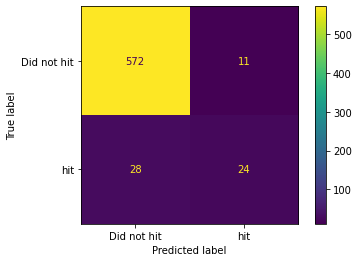

In [61]:
plot_confusion_matrix(clf_xgb2,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [62]:
X.columns

Index(['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

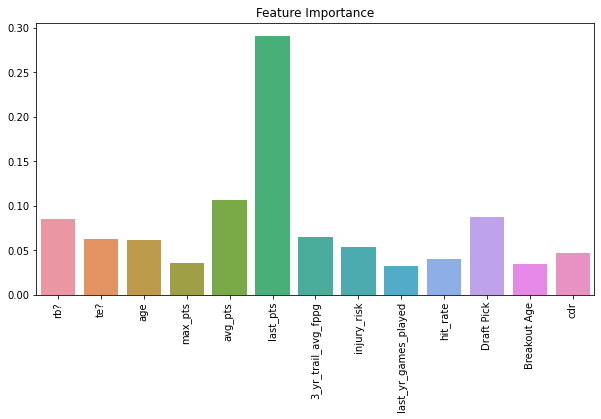

In [63]:
features = ['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf_xgb2.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Score the entire set to create the inputs for BRADY

## Score 2022

In [64]:
df_2022_X = df_2022_X.drop(columns=['id'])

In [65]:
j_scores_2022 = pd.DataFrame(clf_xgb2.predict_proba(df_2022_X)).set_index(df_2022_X_id['id']).sort_values(
    1, axis=0, ascending=False)

In [154]:
j_scores_2022.head(10)

0         1
id                                  
D.K. Metcalf      0.172026  0.827974
Tyreek Hill       0.177106  0.822894
Joe Mixon         0.183245  0.816755
Justin Jefferson  0.189278  0.810722
Ja'Marr Chase     0.199651  0.800349
Jonathan Taylor   0.225135  0.774865
Mike Evans        0.238353  0.761647
Stefon Diggs      0.241402  0.758598
Diontae Johnson   0.247968  0.752032
D.J. Moore        0.253062  0.746938

In [67]:
rb_team = pd.read_csv('rb_team.csv')
wr_team = pd.read_csv('wr_team.csv')
te_team = pd.read_csv('te_team.csv')

team_df = rb_team.append(wr_team.append(te_team))
team_df

Full Name Position                 Team
0        A.J. Dillon       RB    Green Bay Packers
1        Aaron Green       RB                    -
2        Aaron Jones       RB    Green Bay Packers
3    Aaron Ripkowski       RB                    -
4        Abram Smith       RB   New Orleans Saints
..               ...      ...                  ...
499        Zach Ertz       TE    Arizona Cardinals
500      Zach Gentry       TE  Pittsburgh Steelers
501      Zach Miller       TE                    -
502      Zach Miller       TE                    -
503     Zach Sudfeld       TE                    -

[2394 rows x 3 columns]

In [69]:
brady_inputs_2022 = j_scores_2022.reset_index().merge(team_df[['Full Name','Position','Team']], 
                                              left_on='id',right_on='Full Name',how='inner')
brady_inputs_2022

id         0         1         Full Name Position  \
0         D.K. Metcalf  0.172026  0.827974      D.K. Metcalf       WR   
1          Tyreek Hill  0.177106  0.822894       Tyreek Hill       WR   
2            Joe Mixon  0.183245  0.816755         Joe Mixon       RB   
3     Justin Jefferson  0.189278  0.810722  Justin Jefferson       WR   
4        Ja'Marr Chase  0.199651  0.800349     Ja'Marr Chase       WR   
...                ...       ...       ...               ...      ...   
1414  Javontee Herndon  0.993949  0.006051  Javontee Herndon       WR   
1415     Chris Myarick  0.993949  0.006051     Chris Myarick       TE   
1416      Jawill Davis  0.993949  0.006051      Jawill Davis       WR   
1417       Chris Gragg  0.993949  0.006051       Chris Gragg       TE   
1418  Aldrick Robinson  0.993949  0.006051  Aldrick Robinson       WR   

                    Team  
0       Seattle Seahawks  
1         Miami Dolphins  
2     Cincinnati Bengals  
3      Minnesota Vikings  
4     Cincinnati Bengals  
...                  ...  
1414                   -  
1415     New York Giants  
1416                   -  
1417                   -  
1418                   -  

[1419 rows x 6 columns]

In [149]:
brady_inputs_2022.to_csv('brady_inputs_2022_wip.csv')

In [128]:
brady_inputs_2022_fixed = pd.read_csv('brady_inputs_2022_fixed.csv')
brady_inputs_2022_fixed

Unnamed: 0                id         0         1         Full Name  \
0              0      D.K. Metcalf  0.172026  0.827974      D.K. Metcalf   
1              1       Tyreek Hill  0.177106  0.822894       Tyreek Hill   
2              2         Joe Mixon  0.183245  0.816755         Joe Mixon   
3              3  Justin Jefferson  0.189278  0.810722  Justin Jefferson   
4              4     Ja'Marr Chase  0.199651  0.800349     Ja'Marr Chase   
...          ...               ...       ...       ...               ...   
1414        1414  Javontee Herndon  0.993949  0.006051  Javontee Herndon   
1415        1415     Chris Myarick  0.993949  0.006051     Chris Myarick   
1416        1416      Jawill Davis  0.993949  0.006051      Jawill Davis   
1417        1417       Chris Gragg  0.993949  0.006051       Chris Gragg   
1418        1418  Aldrick Robinson  0.993949  0.006051  Aldrick Robinson   

     Position                Team  
0          WR    Seattle Seahawks  
1          WR      Miami Dolphins  
2          RB  Cincinnati Bengals  
3          WR   Minnesota Vikings  
4          WR  Cincinnati Bengals  
...       ...                 ...  
1414       WR                   -  
1415       TE                   -  
1416       WR                   -  
1417       TE                   -  
1418       WR                   -  

[1419 rows x 7 columns]

In [148]:
brady_2022_group_df = brady_inputs_2022_fixed.groupby(['Team']).agg({'1':'sum'})
brady_2022_group_df.to_csv('brady_input_2022.csv')

###  Score 2021

In [72]:
X_2021 = df_2021.drop(columns=['y'])
X_2021

rb?  te?   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0       1    0  23.1   40.2996   40.299600   40.2996             3.663600   
1       1    0  26.5  315.2000  206.425150  258.9006            15.123225   
3       1    0  36.2  260.8000  117.199886  124.4992             9.697314   
8       1    0  26.8  171.0000   84.274975   21.0999             8.333325   
9       1    0  22.9   86.8998   77.899900   86.8998             5.992300   
...   ...  ...   ...       ...         ...       ...                  ...   
1242    0    1  28.4  161.0000   88.080100  128.2005             6.229340   
1243    0    1  28.6  124.5000   40.216667   41.9000             3.748333   
1248    0    1  24.9   73.8000   56.833600   61.1008             8.339600   
1251    0    1  30.5  280.0000  181.700071   77.5005            12.392214   
1252    0    1  24.7    1.4000    0.700000    0.0000             0.700000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
0        0.687500                  11.0  0.000000        2.30          19.3   
1        0.850000                  14.0  0.500000        5.39          18.8   
3        0.718750                  16.0  0.142857        1.07          19.5   
8        0.578125                   3.0  0.000000        5.34          19.0   
9        0.812500                  13.0  0.000000        3.38          19.2   
...           ...                   ...       ...         ...           ...   
1242     0.864583                  15.0  0.000000        4.12          22.7   
1243     0.562500                  10.0  0.000000        3.21          20.9   
1248     0.500000                  16.0  0.000000        4.20           NaN   
1251     0.906250                  11.0  0.428571        2.03          21.8   
1252     0.083333                   2.0  0.000000        5.03           NaN   

       cdr  
0     34.8  
1     47.0  
3     42.7  
8     29.9  
9     28.7  
...    ...  
1242  15.6  
1243  11.5  
1248  10.3  
1251  31.8  
1252  15.6  

[550 rows x 13 columns]

In [73]:
id_2021 = full_data[['Full Name','Fantasy Points Per Game (2021)']].dropna(subset=['Fantasy Points Per Game (2021)'])
id_2021

Full Name  Fantasy Points Per Game (2021)
0            A.J. Dillon                         10.9176
1            Aaron Jones                         15.2667
3        Adrian Peterson                          6.6500
8           Alex Collins                          6.2545
9     Alexander Mattison                          7.8688
...                  ...                             ...
1242        Tyler Higbee                          9.8000
1243         Tyler Kroft                          4.3667
1248         Will Dissly                          3.3400
1251           Zach Ertz                         10.6294
1252         Zach Gentry                          2.1000

[550 rows x 2 columns]

In [150]:
j_scores_2021 = pd.DataFrame(clf_xgb2.predict_proba(X_2021)).set_index(id_2021['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2021.head(10)

0         1
Full Name                           
D.K. Metcalf      0.148728  0.851272
Terry McLaurin    0.155249  0.844751
Justin Jefferson  0.166978  0.833022
Tyreek Hill       0.197524  0.802476
Alvin Kamara      0.197993  0.802007
Jonathan Taylor   0.199651  0.800349
Josh Jacobs       0.227992  0.772008
Antonio Gibson    0.250124  0.749876
Dalvin Cook       0.255327  0.744673
CeeDee Lamb       0.255954  0.744046

In [78]:
brady_inputs_2021 = j_scores_2021.reset_index().merge(team_df[['Full Name','Position','Team']], 
                                              left_on='Full Name',right_on='Full Name',how='inner')
brady_inputs_2021

Full Name         0         1 Position                   Team
0        D.K. Metcalf  0.148728  0.851272       WR       Seattle Seahawks
1      Terry McLaurin  0.155249  0.844751       WR  Washington Commanders
2    Justin Jefferson  0.166978  0.833022       WR      Minnesota Vikings
3         Tyreek Hill  0.197524  0.802476       WR         Miami Dolphins
4        Alvin Kamara  0.197993  0.802007       RB     New Orleans Saints
..                ...       ...       ...      ...                    ...
551   Garrett Griffin  0.993949  0.006051       TE          Detroit Lions
552   Trent Sherfield  0.993949  0.006051       WR         Miami Dolphins
553     Trenton Irwin  0.993949  0.006051       WR     Cincinnati Bengals
554    Eric Tomlinson  0.993949  0.006051       TE       Baltimore Ravens
555      James Proche  0.993949  0.006051       WR       Baltimore Ravens

[556 rows x 5 columns]

In [79]:
brady_inputs_2021.to_csv('brady_inputs_2021_wip.csv')

In [108]:
brady_inputs_2021_fixed = pd.read_csv('brady_inputs_2021_fixed.csv')
brady_inputs_2021_fixed

Unnamed: 0         Full Name         0         1 Position  \
0             0      D.K. Metcalf  0.148728  0.851272       WR   
1             1    Terry McLaurin  0.155249  0.844751       WR   
2             2  Justin Jefferson  0.166978  0.833022       WR   
3             3       Tyreek Hill  0.197524  0.802476       WR   
4             4      Alvin Kamara  0.197993  0.802007       RB   
..          ...               ...       ...       ...      ...   
551         551   Garrett Griffin  0.993949  0.006051       TE   
552         552   Trent Sherfield  0.993949  0.006051       WR   
553         553     Trenton Irwin  0.993949  0.006051       WR   
554         554    Eric Tomlinson  0.993949  0.006051       TE   
555         555      James Proche  0.993949  0.006051       WR   

                      Team  
0         Seattle Seahawks  
1    Washington Commanders  
2        Minnesota Vikings  
3       Kansas City Chiefs  
4       New Orleans Saints  
..                     ...  
551          Detroit Lions  
552         Miami Dolphins  
553     Cincinnati Bengals  
554       Baltimore Ravens  
555       Baltimore Ravens  

[556 rows x 6 columns]

In [134]:
brady_2021_group_df = brady_inputs_2021_fixed.groupby(['Team']).agg({'1':'sum'})
brady_2021_group_df.to_csv('brady_input_2021.csv')

### Score 2020

In [84]:
X_2020 = df_2020.drop(columns=['y'])
X_2020

rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0       1    0  22.1      NaN         NaN       NaN                  NaN   
1       1    0  25.5    315.2  188.933333     315.2            14.000000   
3       1    0  35.2    260.8  115.983333     147.0            10.016667   
6       1    0  23.9     17.6   17.600000      17.6             1.600000   
7       1    0  26.0     15.2    8.266667       9.6             1.033333   
...   ...  ...   ...      ...         ...       ...                  ...   
1244    0    1  30.0    133.5   71.266667      84.0             5.750000   
1247    0    1  31.8     52.0   35.883333      22.8             3.516667   
1248    0    1  23.9     73.8   54.700000      73.8            10.600000   
1251    0    1  29.5    280.0  199.066667     213.0            13.283333   
1252    0    1  23.7      1.4    1.400000       1.4             1.400000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
0             NaN                   NaN       NaN        2.30          19.3   
1        0.791667                  16.0  0.333333        5.39          18.8   
3        0.635417                  15.0  0.166667        1.07          19.5   
6        0.687500                  11.0  0.000000         NaN           NaN   
7        0.354167                   8.0  0.000000        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1244     0.687500                  14.0  0.000000        2.23          20.2   
1247     0.656250                  12.0  0.000000        7.01          21.1   
1248     0.312500                   6.0  0.000000        4.20           NaN   
1251     0.937500                  15.0  0.500000        2.03          21.8   
1252     0.062500                   1.0  0.000000        5.03           NaN   

       cdr  
0     34.8  
1     47.0  
3     42.7  
6     10.1  
7      3.2  
...    ...  
1244  26.6  
1247  19.5  
1248  10.3  
1251  31.8  
1252  15.6  

[543 rows x 13 columns]

In [85]:
id_2020 = full_data[['Full Name','Fantasy Points Per Game (2020)']].dropna(subset=['Fantasy Points Per Game (2020)'])
id_2020

Full Name  Fantasy Points Per Game (2020)
0         A.J. Dillon                          3.6636
1         Aaron Jones                         18.4929
3     Adrian Peterson                          7.7812
6         Alec Ingold                          2.7000
7          Alex Armah                          0.6000
...               ...                             ...
1244   Vance McDonald                          1.7786
1247     Virgil Green                          2.3333
1248      Will Dissly                          3.8188
1251        Zach Ertz                          7.0455
1252      Zach Gentry                          0.0000

[543 rows x 2 columns]

In [151]:
j_scores_2020 = pd.DataFrame(clf_xgb2.predict_proba(X_2020)).set_index(id_2020['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2020.head(10)

0         1
Full Name                          
Alvin Kamara     0.226950  0.773050
Nick Chubb       0.228476  0.771524
Mike Evans       0.231921  0.768079
Chris Godwin     0.234581  0.765419
Jarvis Landry    0.252108  0.747892
Dalvin Cook      0.255327  0.744673
DeAndre Hopkins  0.270816  0.729184
D.J. Moore       0.278221  0.721779
Kenny Golladay   0.278503  0.721497
Cooper Kupp      0.291863  0.708137

In [87]:
brady_inputs_2020 = j_scores_2020.reset_index().merge(team_df[['Full Name','Position','Team']], 
                                              left_on='Full Name',right_on='Full Name',how='inner')
brady_inputs_2020

Full Name         0         1 Position                  Team
0      Alvin Kamara  0.226950  0.773050       RB    New Orleans Saints
1        Nick Chubb  0.228476  0.771524       RB      Cleveland Browns
2        Mike Evans  0.231921  0.768079       WR  Tampa Bay Buccaneers
3      Chris Godwin  0.234581  0.765419       WR  Tampa Bay Buccaneers
4     Jarvis Landry  0.252108  0.747892       WR    New Orleans Saints
..              ...       ...       ...      ...                   ...
543    Hale Hentges  0.993949  0.006051       TE                     -
544  Brandon Powell  0.993949  0.006051       WR      Los Angeles Rams
545   Kenjon Barner  0.993949  0.006051       RB  Tampa Bay Buccaneers
546     Geoff Swaim  0.993949  0.006051       TE      Tennessee Titans
547    Jakeem Grant  0.993949  0.006051       WR      Cleveland Browns

[548 rows x 5 columns]

In [88]:
brady_inputs_2020.to_csv('brady_inputs_2020_wip.csv')

In [135]:
brady_inputs_2020_fixed = pd.read_csv('brady_inputs_2020_fixed.csv')
brady_inputs_2020_fixed

Unnamed: 0       Full Name         0         1 Position  \
0             0    Alvin Kamara  0.226950  0.773050       RB   
1             1      Nick Chubb  0.228476  0.771524       RB   
2             2      Mike Evans  0.231921  0.768079       WR   
3             3    Chris Godwin  0.234581  0.765419       WR   
4             4   Jarvis Landry  0.252108  0.747892       WR   
..          ...             ...       ...       ...      ...   
543         543    Hale Hentges  0.993949  0.006051       TE   
544         544  Brandon Powell  0.993949  0.006051       WR   
545         545   Kenjon Barner  0.993949  0.006051       RB   
546         546     Geoff Swaim  0.993949  0.006051       TE   
547         547    Jakeem Grant  0.993949  0.006051       WR   

                     Team  
0      New Orleans Saints  
1        Cleveland Browns  
2    Tampa Bay Buccaneers  
3    Tampa Bay Buccaneers  
4        Cleveland Browns  
..                    ...  
543                     -  
544                     -  
545                     -  
546                     -  
547                     -  

[548 rows x 6 columns]

In [139]:
brady_2020_group_df = brady_inputs_2020_fixed.groupby(['Team']).agg({'1':'sum'})
brady_2020_group_df.to_csv('brady_input_2020.csv')

### Score 2019

In [94]:
X_2019 = df_2019.drop(columns=['y'])
X_2019

rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1       1    0  24.5    171.6  125.800000     171.6            11.150000   
3       1    0  34.2    260.8  109.780000     188.8            10.060000   
6       1    0  22.9      NaN         NaN       NaN                  NaN   
7       1    0  25.0     15.2    7.600000      15.2             0.950000   
9       1    0  20.9      NaN         NaN       NaN                  NaN   
...   ...  ...   ...      ...         ...       ...                  ...   
1247    0    1  30.8     52.0   38.500000      46.2             3.840000   
1248    0    1  22.9     35.6   35.600000      35.6             8.900000   
1250    0    1  26.7     34.4   20.533333      12.8             2.766667   
1251    0    1  28.5    280.0  196.280000     280.0            13.100000   
1252    0    1  22.7      NaN         NaN       NaN                  NaN   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1        0.687500                  12.0       0.0        5.39          18.8   
3        0.575000                  16.0       0.2        1.07          19.5   
6             NaN                   NaN       NaN         NaN           NaN   
7        0.281250                   8.0       0.0        6.08           NaN   
9             NaN                   NaN       NaN        3.38          19.2   
...           ...                   ...       ...         ...           ...   
1247     0.637500                  14.0       0.0        7.01          21.1   
1248     0.250000                   4.0       0.0        4.20           NaN   
1250     0.458333                   8.0       0.0         NaN           NaN   
1251     0.937500                  16.0       0.4        2.03          21.8   
1252          NaN                   NaN       NaN        5.03           NaN   

       cdr  
1     47.0  
3     42.7  
6     10.1  
7      3.2  
9     28.7  
...    ...  
1247  19.5  
1248  10.3  
1250  13.1  
1251  31.8  
1252  15.6  

[485 rows x 13 columns]

In [95]:
id_2019 = full_data[['Full Name','Fantasy Points Per Game (2019)']].dropna(subset=['Fantasy Points Per Game (2019)'])
id_2019

Full Name  Fantasy Points Per Game (2019)
1            Aaron Jones                            19.7
3        Adrian Peterson                             9.8
6            Alec Ingold                             1.6
7             Alex Armah                             1.2
9     Alexander Mattison                             5.3
...                  ...                             ...
1247        Virgil Green                             1.9
1248         Will Dissly                            12.3
1250      Xavier Grimble                             0.6
1251           Zach Ertz                            14.2
1252         Zach Gentry                             1.4

[485 rows x 2 columns]

In [152]:
j_scores_2019 = pd.DataFrame(clf_xgb2.predict_proba(X_2019)).set_index(id_2019['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2019.head(10)

0         1
Full Name                              
Tyreek Hill          0.173092  0.826908
Stefon Diggs         0.175944  0.824056
Mike Evans           0.189278  0.810722
Alvin Kamara         0.197993  0.802007
Davante Adams        0.214935  0.785065
JuJu Smith-Schuster  0.225135  0.774865
DeAndre Hopkins      0.240115  0.759885
Keenan Allen         0.243517  0.756483
Saquon Barkley       0.281648  0.718352
Brandin Cooks        0.288909  0.711091

In [97]:
brady_inputs_2019 = j_scores_2019.reset_index().merge(team_df[['Full Name','Position','Team']], 
                                          left_on='Full Name',right_on='Full Name',how='inner')
brady_inputs_2019

Full Name         0         1 Position                  Team
0        Tyreek Hill  0.173092  0.826908       WR        Miami Dolphins
1       Stefon Diggs  0.175944  0.824056       WR         Buffalo Bills
2         Mike Evans  0.189278  0.810722       WR  Tampa Bay Buccaneers
3       Alvin Kamara  0.197993  0.802007       RB    New Orleans Saints
4      Davante Adams  0.214935  0.785065       WR     Las Vegas Raiders
..               ...       ...       ...      ...                   ...
483      Mike Burton  0.993949  0.006051       RB    Kansas City Chiefs
484  Patrick DiMarco  0.993949  0.006051       RB                     -
485   Raheem Mostert  0.993949  0.006051       RB        Miami Dolphins
486      Tim Patrick  0.993949  0.006051       WR        Denver Broncos
487      Zach Pascal  0.993949  0.006051       WR   Philadelphia Eagles

[488 rows x 5 columns]

In [98]:
brady_inputs_2019.to_csv('brady_inputs_2019_wip.csv')

In [140]:
brady_inputs_2019_fixed = pd.read_csv('brady_inputs_2019_fixed.csv')
brady_inputs_2019_fixed

Unnamed: 0        Full Name         0         1 Position  \
0             0      Tyreek Hill  0.173092  0.826908       WR   
1             1     Stefon Diggs  0.175944  0.824056       WR   
2             2       Mike Evans  0.189278  0.810722       WR   
3             3     Alvin Kamara  0.197993  0.802007       RB   
4             4    Davante Adams  0.214935  0.785065       WR   
..          ...              ...       ...       ...      ...   
483         483      Mike Burton  0.993949  0.006051       RB   
484         484  Patrick DiMarco  0.993949  0.006051       RB   
485         485   Raheem Mostert  0.993949  0.006051       RB   
486         486      Tim Patrick  0.993949  0.006051       WR   
487         487      Zach Pascal  0.993949  0.006051       WR   

                     Team  
0      Kansas City Chiefs  
1           Buffalo Bills  
2    Tampa Bay Buccaneers  
3      New Orleans Saints  
4       Green Bay Packers  
..                    ...  
483                     -  
484                     -  
485                     -  
486                     -  
487                     -  

[488 rows x 6 columns]

In [142]:
brady_2019_group_df = brady_inputs_2019_fixed.groupby(['Team']).agg({'1':'sum'})
brady_2019_group_df.to_csv('brady_input_2019.csv')

### Score 2018

In [103]:
X_2018 = df_2018.drop(columns=['y'])
X_2018

rb?  te?   age  max_pts  avg_pts  last_pts  3_yr_trail_avg_fppg  \
1       1    0  23.5     80.0   80.000      80.0                8.000   
3       1    0  33.2    260.8   90.025      79.0                9.625   
7       1    0  24.0      0.0    0.000       0.0                0.000   
8       1    0  23.8    171.0  103.500     171.0                7.700   
11      1    0  27.1    112.0   79.000      44.8                6.025   
...   ...  ...   ...      ...      ...       ...                  ...   
1245    0    1  34.3    121.6   94.000     121.6                6.500   
1247    0    1  29.8     52.0   36.575      39.6                3.975   
1248    0    1  21.9      NaN      NaN       NaN                  NaN   
1250    0    1  25.7     34.4   24.400      14.4                3.350   
1251    0    1  27.5    203.0  175.350     203.0               12.000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1        0.625000                  10.0      0.00        5.39          18.8   
3        0.468750                  10.0      0.25        1.07          19.5   
7        0.062500                   1.0      0.00        6.08           NaN   
8        0.750000                  15.0      0.00        5.34          19.0   
11       0.812500                   8.0      0.00        6.05          21.4   
...           ...                   ...       ...         ...           ...   
1245     0.890625                  16.0      0.00        1.06          21.6   
1247     0.578125                  11.0      0.00        7.01          21.1   
1248          NaN                   NaN       NaN        4.20           NaN   
1250     0.437500                   6.0      0.00         NaN           NaN   
1251     0.921875                  14.0      0.25        2.03          21.8   

       cdr  
1     47.0  
3     42.7  
7      3.2  
8     29.9  
11    14.4  
...    ...  
1245  35.9  
1247  19.5  
1248  10.3  
1250  13.1  
1251  31.8  

[491 rows x 13 columns]

In [104]:
id_2018 = full_data[['Full Name','Fantasy Points Per Game (2018)']].dropna(subset=['Fantasy Points Per Game (2018)'])
id_2018

Full Name  Fantasy Points Per Game (2018)
1         Aaron Jones                            14.3
3     Adrian Peterson                            11.8
7          Alex Armah                             1.9
8        Alex Collins                            10.9
11        Alfred Blue                             6.1
...               ...                             ...
1245     Vernon Davis                             5.7
1247     Virgil Green                             3.3
1248      Will Dissly                             8.9
1250   Xavier Grimble                             1.6
1251        Zach Ertz                            17.5

[491 rows x 2 columns]

In [153]:
j_scores_2018 = pd.DataFrame(clf_xgb2.predict_proba(X_2018)).set_index(id_2018['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2018.head(10)

0         1
Full Name                              
Jarvis Landry        0.156600  0.843400
Christian McCaffrey  0.195035  0.804965
Alvin Kamara         0.197993  0.802007
Kareem Hunt          0.212935  0.787065
DeAndre Hopkins      0.225135  0.774865
Brandin Cooks        0.225805  0.774195
Keenan Allen         0.245038  0.754962
JuJu Smith-Schuster  0.283552  0.716448
Davante Adams        0.289770  0.710230
Todd Gurley          0.291176  0.708824

In [106]:
brady_inputs_2018 = j_scores_2018.reset_index().merge(team_df[['Full Name','Position','Team']], 
                                        left_on='Full Name',right_on='Full Name',how='inner')
brady_inputs_2018

Full Name         0         1 Position                  Team
0          Jarvis Landry  0.156600  0.843400       WR    New Orleans Saints
1    Christian McCaffrey  0.195035  0.804965       RB     Carolina Panthers
2           Alvin Kamara  0.197993  0.802007       RB    New Orleans Saints
3            Kareem Hunt  0.212935  0.787065       RB      Cleveland Browns
4        DeAndre Hopkins  0.225135  0.774865       WR     Arizona Cardinals
..                   ...       ...       ...      ...                   ...
489        Kenjon Barner  0.993949  0.006051       RB  Tampa Bay Buccaneers
490        Malcolm Brown  0.993949  0.006051       RB                     -
491        Marcus Murphy  0.993949  0.006051       RB                     -
492          Mike Burton  0.993949  0.006051       RB    Kansas City Chiefs
493         Geremy Davis  0.993949  0.006051       WR                     -

[494 rows x 5 columns]

In [107]:
brady_inputs_2018.to_csv('brady_inputs_2018_wip.csv')

In [143]:
brady_inputs_2018_fixed = pd.read_csv('brady_inputs_2018_fixed.csv')
brady_inputs_2018_fixed

Unnamed: 0            Full Name         0         1 Position  \
0             0        Jarvis Landry  0.156600  0.843400       WR   
1             1  Christian McCaffrey  0.195035  0.804965       RB   
2             2         Alvin Kamara  0.197993  0.802007       RB   
3             3          Kareem Hunt  0.212935  0.787065       RB   
4             4      DeAndre Hopkins  0.225135  0.774865       WR   
..          ...                  ...       ...       ...      ...   
489         489        Kenjon Barner  0.993949  0.006051       RB   
490         490        Malcolm Brown  0.993949  0.006051       RB   
491         491        Marcus Murphy  0.993949  0.006051       RB   
492         492          Mike Burton  0.993949  0.006051       RB   
493         493         Geremy Davis  0.993949  0.006051       WR   

                   Team  
0      Cleveland Browns  
1     Carolina Panthers  
2    New Orleans Saints  
3    Kansas City Chiefs  
4        Houston Texans  
..                  ...  
489                   -  
490                   -  
491                   -  
492                   -  
493                   -  

[494 rows x 6 columns]

In [145]:
brady_2018_group_df = brady_inputs_2018_fixed.groupby(['Team']).agg({'1':'sum'})
brady_2018_group_df.to_csv('brady_input_2018.csv')

### Score 2017

In [118]:
X_2017 = df_2017.drop(columns=['y'])
X_2017

rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1       1    0  22.5      NaN         NaN       NaN                  NaN   
2       1    0  24.4     47.0   24.900000      47.0             3.750000   
3       1    0  32.2    260.8   93.700000       9.0            10.200000   
5       1    0  24.3     19.6   18.200000      16.8             2.450000   
7       1    0  23.0      NaN         NaN       NaN                  NaN   
...   ...  ...   ...      ...         ...       ...                  ...   
1247    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0  0.000000        6.30           NaN   
3        0.416667                   3.0  0.333333        1.07          19.5   
5        0.468750                   8.0  0.000000         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.541667                  10.0  0.000000        7.01          21.1   
1249     0.906250                  16.0  0.000000         NaN          21.8   
1250     0.500000                   8.0  0.000000         NaN           NaN   
1251     0.937500                  14.0  0.000000        2.03          21.8   
1253     0.718750                  10.0  0.000000        2.06          20.7   

       cdr  
1     47.0  
2      3.9  
3     42.7  
5     27.1  
7      3.2  
...    ...  
1247  19.5  
1249  36.1  
1250  13.1  
1251  31.8  
1253  18.1  

[471 rows x 13 columns]

In [119]:
id_2017 = full_data[['Full Name','Fantasy Points Per Game (2017)']].dropna(subset=['Fantasy Points Per Game (2017)'])
id_2017

Full Name  Fantasy Points Per Game (2017)
1         Aaron Jones                             8.0
2     Aaron Ripkowski                             1.1
3     Adrian Peterson                             7.9
5          Akeem Hunt                             0.7
7          Alex Armah                             0.0
...               ...                             ...
1247     Virgil Green                             3.6
1249         Will Tye                             3.9
1250   Xavier Grimble                             2.4
1251        Zach Ertz                            14.5
1253      Zach Miller                             7.0

[471 rows x 2 columns]

In [120]:
j_scores_2017 = pd.DataFrame(clf_xgb2.predict_proba(X_2017)).set_index(id_2017['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2017

0         1
Full Name                               
Mike Evans            0.189278  0.810722
Devonta Freeman       0.234855  0.765145
Ezekiel Elliott       0.245903  0.754097
Julio Jones           0.280293  0.719707
Odell Beckham         0.283363  0.716637
...                        ...       ...
Rex Burkhead          0.993949  0.006051
Fitzgerald Toussaint  0.993949  0.006051
Fozzy Whittaker       0.993949  0.006051
J.D. McKissic         0.993949  0.006051
A.J. Derby            0.993949  0.006051

[471 rows x 2 columns]

In [121]:
brady_inputs_2017 = j_scores_2017.reset_index().merge(team_df[['Full Name','Position','Team']], 
                                        left_on='Full Name',right_on='Full Name',how='inner')
brady_inputs_2017

Full Name         0         1 Position                   Team
0              Mike Evans  0.189278  0.810722       WR   Tampa Bay Buccaneers
1         Devonta Freeman  0.234855  0.765145       RB                      -
2         Ezekiel Elliott  0.245903  0.754097       RB         Dallas Cowboys
3             Julio Jones  0.280293  0.719707       WR                      -
4           Odell Beckham  0.283363  0.716637       WR                      -
..                    ...       ...       ...      ...                    ...
470          Rex Burkhead  0.993949  0.006051       RB         Houston Texans
471  Fitzgerald Toussaint  0.993949  0.006051       RB                      -
472       Fozzy Whittaker  0.993949  0.006051       RB                      -
473         J.D. McKissic  0.993949  0.006051       RB  Washington Commanders
474            A.J. Derby  0.993949  0.006051       TE                      -

[475 rows x 5 columns]

In [122]:
brady_inputs_2017.to_csv('brady_inputs_2017_wip.csv')

In [146]:
brady_inputs_2017_fixed = pd.read_csv('brady_inputs_2017_fixed.csv')
brady_inputs_2017_fixed

Unnamed: 0             Full Name         0         1 Position  \
0             0            Mike Evans  0.189278  0.810722       WR   
1             1       Devonta Freeman  0.234855  0.765145       RB   
2             2       Ezekiel Elliott  0.245903  0.754097       RB   
3             3           Julio Jones  0.280293  0.719707       WR   
4             4         Odell Beckham  0.283363  0.716637       WR   
..          ...                   ...       ...       ...      ...   
470         470          Rex Burkhead  0.993949  0.006051       RB   
471         471  Fitzgerald Toussaint  0.993949  0.006051       RB   
472         472       Fozzy Whittaker  0.993949  0.006051       RB   
473         473         J.D. McKissic  0.993949  0.006051       RB   
474         474            A.J. Derby  0.993949  0.006051       TE   

                     Team  
0    Tampa Bay Buccaneers  
1         Atlanta Falcons  
2          Dallas Cowboys  
3         Atlanta Falcons  
4         New York Giants  
..                    ...  
470                     -  
471                     -  
472                     -  
473                     -  
474                     -  

[475 rows x 6 columns]

In [147]:
brady_2017_group_df = brady_inputs_2017_fixed.groupby(['Team']).agg({'1':'sum'})
brady_2017_group_df.to_csv('brady_input_2017.csv')